<h1>This is the code for COM3013 Coursework</h1>
<h2>Mofe Awosanya, Ebose Odijie, Hishaam Khan</h2>

These are all the imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Optimizer
import random

Check if machine is using CUDA GPU

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


We are using pytorch here to get the CIFAR10 dataset and set the classes.

In [3]:
import torch.multiprocessing as mp

# Set the sharing strategy
mp.set_sharing_strategy('file_system')

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

x_list = []
y_list = []

for inputs, labels in trainloader:
    x_list.append(inputs)
    y_list.append(labels)

x = torch.cat(x_list, dim=0)
y = torch.cat(y_list, dim=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let's see some of the images

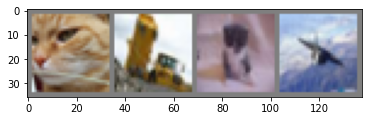

cat   truck cat   plane


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Now to create the forward Neural Network

In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(256 * 4 * 4, 120)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu5 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(-1, 256 * 4 * 4)
        x = self.relu4(self.fc1(x))
        x = self.relu5(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
model = Model()
model = model.float()

print(model)

Model(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=120, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (relu5): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Now to define the Loss Function

In [6]:
loss_func = torch.nn.CrossEntropyLoss()
loss_values = []

Now to Define the Optimisation Function for the majority of the layers, for the final layer we will be using our own.

In [7]:
default_optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

This is the setup for the genetic algorithm

In [8]:
from deap import creator, base, tools, algorithms
from sympy.combinatorics.graycode import GrayCode
from sympy.combinatorics.graycode import gray_to_bin
from sympy.combinatorics.graycode import bin_to_gray

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

pop_size = 5 #population size
num_of_bits = 30 #number of bits in a chromosome
iterations = 5 #number of generations
dspInterval = 1

cross_prob = 0.75 #crossover probability
mutate_prob = 0.95 #mutation probability
num_elitists = 5 #the number of elite individuals selected

maxnum = 2*num_of_bits

fc1shape = 256*4*4*120
fc2shape = 120*84
fc3shape = 84*10

chromosome_length = ((256*4*4)+1)*120+(120+1)*84+(84+1)*10

flip_prob = 1. / (chromosome_length * num_of_bits/30)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_bool, num_of_bits*(chromosome_length))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def retrieve_weights(model):
    fc1list = model.fc1.weight.reshape(fc1shape).tolist()
    fc2list = model.fc2.weight.reshape(fc2shape).tolist()
    fc3list = model.fc3.weight.reshape(fc3shape).tolist()

    fc1bias = model.fc1.bias.reshape(120).tolist()
    fc2bias = model.fc2.bias.reshape(84).tolist()
    fc3bias = model.fc3.bias.reshape(10).tolist()

    weights = fc1list + fc2list + fc3list + fc1bias + fc2bias + fc3bias

    return weights

def real_to_chromosome(weight):
    weight = weight/20
    if weight < -1:
        weight = -1
    if weight > 1:
        weight = 1
    integerPart = int(maxnum * (weight + 1 ) / 2)
    if (integerPart == maxnum):
        integerPart -= 1
    chromosome = [int(d) for d in str(bin(integerPart))[2:]]
    while (len(chromosome) < num_of_bits):
        chromosome.insert(0, 0)
    indasstring=''.join(map(str, chromosome))
    chromosome=bin_to_gray(indasstring)
    output=[]
    for digit in chromosome:
        output.append(int(digit))

    return output

def chromosome_to_real(c):
    indasstring=''.join(map(str, c))
    degray=gray_to_bin(indasstring)
    numasint=int(degray, 2)
    numinrange=-1.0+2.0*numasint/maxnum
    return numinrange*20

def separatevariables(v):
    sep = []
    for i in range (0,num_of_bits*(chromosome_length),num_of_bits):
        sep.append(chromosome_to_real(v[i:i+num_of_bits]))
    return sep

Now to train our model with the default optimiser for 30 epochs.

In [9]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        default_optimizer.zero_grad()
        loss.backward()
        default_optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished using initial SGD Optimization')

sgdmodel=model
gamodel=model
psmodel=model

[1,  2000] loss: 2.172
[1,  4000] loss: 1.821
[1,  6000] loss: 1.601
[1,  8000] loss: 1.463
[1, 10000] loss: 1.360
[1, 12000] loss: 1.277
[2,  2000] loss: 1.162
[2,  4000] loss: 1.100
[2,  6000] loss: 1.051
[2,  8000] loss: 0.986
[2, 10000] loss: 0.944
[2, 12000] loss: 0.939
Finished using initial SGD Optimization


In [10]:
running_loss=0.0
for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    outputs=sgdmodel(inputs)
    loss=loss_func(outputs, labels)
    default_optimizer.zero_grad()
    loss.backward()
    default_optimizer.step()
    running_loss += loss.item()
    
print("Loss of SGD Optimizer on Final Layer: ", running_loss / len(trainloader))

Loss of SGD Optimizer on Final Layer:  0.7803397503293864


Fitness Calculation Function

In [11]:
def calc_fitness(individual):
    weights=separatevariables(individual)
    weights = np.asarray(weights)
    
    
    print("Original shapes:", weights[:fc1shape].shape, weights[fc1shape:fc1shape + fc2shape].shape, weights[fc1shape + fc2shape: fc1shape + fc2shape + fc3shape].shape)

    gamodel.fc1.weight = torch.nn.Parameter(torch.from_numpy(weights[:(fc1shape)].reshape(256*4*4, 120).T).float())
    gamodel.fc2.weight = torch.nn.Parameter(torch.from_numpy(weights[fc1shape:fc1shape+fc2shape].reshape(84, 120)).float())
    gamodel.fc3.weight = torch.nn.Parameter(torch.from_numpy(weights[fc1shape+fc2shape: fc1shape+fc2shape+fc3shape].reshape(84, 10).T).float())

    gamodel.fc1.bias = torch.nn.Parameter(torch.from_numpy(weights[fc1shape + fc2shape + fc3shape: fc1shape + fc2shape + fc3shape + 120]).float())
    gamodel.fc2.bias = torch.nn.Parameter(torch.from_numpy(weights[fc1shape + fc2shape + fc3shape + 120: fc1shape + fc2shape + fc3shape + 120 + 84]).float())
    gamodel.fc3.bias = torch.nn.Parameter(torch.from_numpy(weights[fc1shape + fc2shape + fc3shape + 120 + 84: fc1shape + fc2shape + fc3shape + 120 + 84 + 10]).float())

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        finputs = inputs.float()
        outputs = gamodel(finputs)
        loss = loss_func(outputs, labels)
        running_loss+=loss.item()
#        print("Running loss in calc_fitness: ", running_loss / len(trainloader))
    return loss.item()

toolbox.register("evaluate", calc_fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=flip_prob)
toolbox.register("select", tools.selTournament, fit_attr="fitness")


Retrieve the weights from the training

In [12]:
popa = toolbox.population(n=pop_size)
pop=[]
for individual in popa:
    sep = separatevariables(individual)
    print(sep)
    weightlist=[]
    for weight in sep:
        weightlist+=real_to_chromosome(weight)
    pop.append(creator.Individual(weightlist))

fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = (fit,)

print(" Evaluated %i individuals" % len(pop))

fits = [ind.fitness.values[0] for ind in pop]

g = 0

while g < iterations:
    g = g + 1
    print("-- Generation %i -- " % g)

    offspring = tools.selBest(pop, num_elitists)
    offspring += toolbox.select(pop, len(pop)-num_elitists, 2)
    offspring = list(map(toolbox.clone, offspring))
    randomnum = random.random()
    print(randomnum)
    for ind in offspring[4:9:2]:
        print(ind)

    for child1, child2 in zip(offspring[4::2], offspring[5::2]):
        if randomnum < cross_prob:
            print("Doing crossover")
            toolbox.mate(child1, child2)
            print("Crossover Done")
            del child1.fitness.values
            del child2.fitness.values
        else:
            print("No Crossover")

    for mutant in offspring[4::]:
        if randomnum < mutate_prob:
            print("Mutating")
            toolbox.mutate(mutant)
            print("Mutated")
            del mutant.fitness.values
        else:
            print("No Mutation")

    for individual in offspring:
        weights = retrieve_weights(gamodel)
        individual.clear()
        newInd=[]
        for index in range(len(weights)):
            chromosome = real_to_chromosome(weights[index])
            newInd += chromosome
        newInd = creator.Individual(newInd)
        offspring.remove(individual)
        offspring.append(newInd)
    
    pop[:] = offspring
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = (fit,)

    fits = [ind.fitness.values[0] for ind in pop]
    loss_values.append(min(fits))

    if g%dspInterval == 0:
        fits = [ind.fitness.values[0] for ind in pop]

        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5

        print(" Min %s" % min(fits))
        print(" Max %s" % max(fits))
        print(" Avg %s" % mean)
        print(" Std %s" % std)

print("-- Completed Evolution --")

best_individual = tools.selBest(pop, 1)[0]
print("Loss of Genetic Algorithm Optimiser on Final Layer: %s" % (calc_fitness(best_individual)))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
 Evaluated 5 individuals
-- Generation 1 -- 


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Mutated
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
 Min 2.3025851249694824
 Max 2.3025851249694824
 Avg 2.3025851249694824
 Std 0.0
-- Generation 2 -- 


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
 Min 2.3025851249694824
 Max 2.3025851249694824
 Avg 2.3025851249694824
 Std 0.0
-- Generation 3 -- 


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Mutated
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
 Min 2.3025851249694824
 Max 2.3025851249694824
 Avg 2.3025851249694824
 Std 0.0
-- Generation 4 -- 


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Mutated
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
 Min 2.3025851249694824
 Max 2.3025851249694824
 Avg 2.3025851249694824
 Std 0.0
-- Generation 5 -- 


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Mutated
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
Original shapes: (491520,) (10080,) (840,)
 Min 2.3025851249694824
 Max 2.3025851249694824
 Avg 2.3025851249694824
 Std 0.0
-- Completed Evolution --
Original shapes: (491520,) (10080,) (840,)
Loss of Genetic Algorithm Optimiser on Final Layer: 2.3025851249694824


Save the Model

In [13]:
PATH = './cifar_model.pth'
torch.save(model.state_dict(), PATH)

lets look at some of the testing images

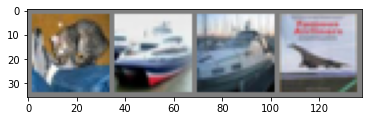

GroundTruth:  cat   ship  ship  plane


In [14]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4))) 

Now to evaluate the model using the testing batch

In [15]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Model Accuracy on Testing Images: {100 * correct // total} %')

Model Accuracy on Testing Images: 10 %


Pattern Search Algorithm

In [16]:
def calc_loss(model, data_loader, loss_func):
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            running_loss += loss.item()
            print("Running loss in PS: ", running_loss / len(data_loader))
    return loss.item()

In [17]:
def update_model_weights(model, weights):
    weights = np.asarray(weights)
    model.fc1.weight = torch.nn.Parameter(torch.from_numpy(weights[:(fc1shape)].reshape(256*4*4, 120).T).float())
    model.fc2.weight = torch.nn.Parameter(torch.from_numpy(weights[fc1shape:fc1shape+fc2shape].reshape(84, 120)).float())
    model.fc3.weight = torch.nn.Parameter(torch.from_numpy(weights[fc1shape+fc2shape: fc1shape+fc2shape+fc3shape].reshape(84, 10).T).float())
    
    model.fc1.bias = torch.nn.Parameter(torch.from_numpy(weights[fc1shape + fc2shape + fc3shape: fc1shape + fc2shape + fc3shape + 120]).float())
    model.fc2.bias = torch.nn.Parameter(torch.from_numpy(weights[fc1shape + fc2shape + fc3shape + 120: fc1shape + fc2shape + fc3shape + 120 + 84]).float())
    model.fc3.bias = torch.nn.Parameter(torch.from_numpy(weights[fc1shape + fc2shape + fc3shape + 120 + 84: fc1shape + fc2shape + fc3shape + 120 + 84 + 10]).float())


In [18]:
def pattern_search(model, trainloader, loss_func, initial_delta=1.0, delta_decay=0.5, max_iter=5):
    best_loss = calc_loss(model, trainloader, loss_func)
    current_weights = retrieve_weights(model)
    delta = initial_delta

    for iteration in range(max_iter):
        improved = False

        # Explore adding delta
        new_weights = [w + delta for w in current_weights]
        update_model_weights(model, new_weights)
        loss = calc_loss(model, trainloader, loss_func)
        if loss < best_loss:
            best_loss = loss
            current_weights = new_weights
            improved = True

        # Explore subtracting delta
        new_weights = [w - delta for w in current_weights]
        update_model_weights(model, new_weights)
        loss = calc_loss(model, trainloader, loss_func)
        if loss < best_loss:
            best_loss = loss
            current_weights = new_weights
            improved = True

        if not improved:
            delta *= delta_decay  # Reduce delta if no improvement

        # Print progress
        progress_percentage = (iteration + 1) / max_iter * 5
        print(f'Iteration {iteration}, Best Loss: {best_loss}, Delta: {delta}, Progress: {progress_percentage:.2f}%')

        if delta < 1e-6:  # Stop if delta becomes very small
            break

    # Set model weights to the best found
    update_model_weights(model, current_weights)
    print("Loss of Pattern Search Optimiser on the Final Layer: ", best_loss)

In [19]:
# Run pattern search
pattern_search(psmodel, trainloader, loss_func)

Running loss in PS:  0.0001842068099975586
Running loss in PS:  0.0003684136199951172
Running loss in PS:  0.0005526204299926758
Running loss in PS:  0.0007368272399902344
Running loss in PS:  0.0009210340499877929
Running loss in PS:  0.0011052408599853515
Running loss in PS:  0.00128944766998291
Running loss in PS:  0.0014736544799804688
Running loss in PS:  0.0016578612899780273
Running loss in PS:  0.0018420680999755858
Running loss in PS:  0.0020262749099731444
Running loss in PS:  0.002210481719970703
Running loss in PS:  0.002394688529968262
Running loss in PS:  0.00257889533996582
Running loss in PS:  0.002763102149963379
Running loss in PS:  0.0029473089599609376
Running loss in PS:  0.003131515769958496
Running loss in PS:  0.0033157225799560546
Running loss in PS:  0.0034999293899536134
Running loss in PS:  0.0036841361999511717
Running loss in PS:  0.0038683430099487304
Running loss in PS:  0.004052549819946289
Running loss in PS:  0.0042367566299438475
Running loss in PS: 

Running loss in PS:  0.040157084579467775
Running loss in PS:  0.04034129138946533
Running loss in PS:  0.04052549819946289
Running loss in PS:  0.04070970500946045
Running loss in PS:  0.040893911819458006
Running loss in PS:  0.04107811862945557
Running loss in PS:  0.04126232543945312
Running loss in PS:  0.041446532249450684
Running loss in PS:  0.041630739059448245
Running loss in PS:  0.0418149458694458
Running loss in PS:  0.04199915267944336
Running loss in PS:  0.042183359489440915
Running loss in PS:  0.042367566299438476
Running loss in PS:  0.04255177310943604
Running loss in PS:  0.04273597991943359
Running loss in PS:  0.04292018672943115
Running loss in PS:  0.04310439353942871
Running loss in PS:  0.04328860034942627
Running loss in PS:  0.04347280715942383
Running loss in PS:  0.043657013969421385
Running loss in PS:  0.043841220779418946
Running loss in PS:  0.0440254275894165
Running loss in PS:  0.04420963439941406
Running loss in PS:  0.04439384120941162
Running lo

Running loss in PS:  0.0823404440689087
Running loss in PS:  0.08252465087890624
Running loss in PS:  0.0827088576889038
Running loss in PS:  0.08289306449890137
Running loss in PS:  0.08307727130889893
Running loss in PS:  0.08326147811889649
Running loss in PS:  0.08344568492889404
Running loss in PS:  0.0836298917388916
Running loss in PS:  0.08381409854888916
Running loss in PS:  0.08399830535888672
Running loss in PS:  0.08418251216888428
Running loss in PS:  0.08436671897888183
Running loss in PS:  0.08455092578887939
Running loss in PS:  0.08473513259887695
Running loss in PS:  0.08491933940887451
Running loss in PS:  0.08510354621887208
Running loss in PS:  0.08528775302886962
Running loss in PS:  0.08547195983886718
Running loss in PS:  0.08565616664886475
Running loss in PS:  0.0858403734588623
Running loss in PS:  0.08602458026885987
Running loss in PS:  0.08620878707885742
Running loss in PS:  0.08639299388885498
Running loss in PS:  0.08657720069885254
Running loss in PS: 

Running loss in PS:  0.121023874168396
Running loss in PS:  0.12120808097839356
Running loss in PS:  0.12139228778839112
Running loss in PS:  0.12157649459838867
Running loss in PS:  0.12176070140838623
Running loss in PS:  0.12194490821838379
Running loss in PS:  0.12212911502838135
Running loss in PS:  0.12231332183837891
Running loss in PS:  0.12249752864837646
Running loss in PS:  0.12268173545837402
Running loss in PS:  0.12286594226837158
Running loss in PS:  0.12305014907836914
Running loss in PS:  0.1232343558883667
Running loss in PS:  0.12341856269836426
Running loss in PS:  0.12360276950836181
Running loss in PS:  0.12378697631835937
Running loss in PS:  0.12397118312835693
Running loss in PS:  0.1241553899383545
Running loss in PS:  0.12433959674835206
Running loss in PS:  0.1245238035583496
Running loss in PS:  0.12470801036834717
Running loss in PS:  0.12489221717834473
Running loss in PS:  0.1250764239883423
Running loss in PS:  0.12526063079833985
Running loss in PS:  0

Running loss in PS:  0.16118095874786376
Running loss in PS:  0.16136516555786132
Running loss in PS:  0.16154937236785888
Running loss in PS:  0.16173357917785644
Running loss in PS:  0.161917785987854
Running loss in PS:  0.16210199279785156
Running loss in PS:  0.16228619960784912
Running loss in PS:  0.16247040641784669
Running loss in PS:  0.16265461322784425
Running loss in PS:  0.1628388200378418
Running loss in PS:  0.16302302684783934
Running loss in PS:  0.1632072336578369
Running loss in PS:  0.16339144046783446
Running loss in PS:  0.16357564727783203
Running loss in PS:  0.1637598540878296
Running loss in PS:  0.16394406089782715
Running loss in PS:  0.1641282677078247
Running loss in PS:  0.16431247451782227
Running loss in PS:  0.16449668132781983
Running loss in PS:  0.1646808881378174
Running loss in PS:  0.16486509494781496
Running loss in PS:  0.1650493017578125
Running loss in PS:  0.16523350856781005
Running loss in PS:  0.1654177153778076
Running loss in PS:  0.16

Running loss in PS:  0.20428535228729247
Running loss in PS:  0.20446955909729003
Running loss in PS:  0.2046537659072876
Running loss in PS:  0.20483797271728515
Running loss in PS:  0.20502217952728272
Running loss in PS:  0.20520638633728028
Running loss in PS:  0.20539059314727784
Running loss in PS:  0.2055747999572754
Running loss in PS:  0.20575900676727296
Running loss in PS:  0.2059432135772705
Running loss in PS:  0.20612742038726806
Running loss in PS:  0.20631162719726562
Running loss in PS:  0.20649583400726318
Running loss in PS:  0.20668004081726074
Running loss in PS:  0.2068642476272583
Running loss in PS:  0.20704845443725586
Running loss in PS:  0.20723266124725342
Running loss in PS:  0.20741686805725099
Running loss in PS:  0.20760107486724855
Running loss in PS:  0.20778528167724608
Running loss in PS:  0.20796948848724364
Running loss in PS:  0.2081536952972412
Running loss in PS:  0.20833790210723876
Running loss in PS:  0.20852210891723633
Running loss in PS:  

Running loss in PS:  0.24665291858673097
Running loss in PS:  0.24683712539672853
Running loss in PS:  0.24702133220672606
Running loss in PS:  0.24720553901672362
Running loss in PS:  0.24738974582672119
Running loss in PS:  0.24757395263671875
Running loss in PS:  0.2477581594467163
Running loss in PS:  0.24794236625671387
Running loss in PS:  0.24812657306671143
Running loss in PS:  0.248310779876709
Running loss in PS:  0.24849498668670655
Running loss in PS:  0.24867919349670412
Running loss in PS:  0.24886340030670165
Running loss in PS:  0.2490476071166992
Running loss in PS:  0.24923181392669677
Running loss in PS:  0.24941602073669433
Running loss in PS:  0.2496002275466919
Running loss in PS:  0.24978443435668946
Running loss in PS:  0.24996864116668702
Running loss in PS:  0.2501528479766846
Running loss in PS:  0.2503370547866821
Running loss in PS:  0.2505212615966797
Running loss in PS:  0.25070546840667723
Running loss in PS:  0.2508896752166748
Running loss in PS:  0.25

Running loss in PS:  0.28938889850616456
Running loss in PS:  0.2895731053161621
Running loss in PS:  0.2897573121261597
Running loss in PS:  0.2899415189361572
Running loss in PS:  0.2901257257461548
Running loss in PS:  0.29030993255615234
Running loss in PS:  0.29049413936614993
Running loss in PS:  0.29067834617614746
Running loss in PS:  0.290862552986145
Running loss in PS:  0.2910467597961426
Running loss in PS:  0.2912309666061401
Running loss in PS:  0.2914151734161377
Running loss in PS:  0.29159938022613524
Running loss in PS:  0.29178358703613283
Running loss in PS:  0.29196779384613036
Running loss in PS:  0.29215200065612795
Running loss in PS:  0.2923362074661255
Running loss in PS:  0.292520414276123
Running loss in PS:  0.2927046210861206
Running loss in PS:  0.29288882789611814
Running loss in PS:  0.29307303470611573
Running loss in PS:  0.29325724151611327
Running loss in PS:  0.29344144832611085
Running loss in PS:  0.2936256551361084
Running loss in PS:  0.2938098

Running loss in PS:  0.3428088734054565
Running loss in PS:  0.3429930802154541
Running loss in PS:  0.34317728702545164
Running loss in PS:  0.3433614938354492
Running loss in PS:  0.34354570064544676
Running loss in PS:  0.34372990745544435
Running loss in PS:  0.3439141142654419
Running loss in PS:  0.3440983210754395
Running loss in PS:  0.344282527885437
Running loss in PS:  0.3444667346954346
Running loss in PS:  0.34465094150543213
Running loss in PS:  0.34483514831542966
Running loss in PS:  0.34501935512542725
Running loss in PS:  0.3452035619354248
Running loss in PS:  0.3453877687454224
Running loss in PS:  0.3455719755554199
Running loss in PS:  0.3457561823654175
Running loss in PS:  0.34594038917541503
Running loss in PS:  0.3461245959854126
Running loss in PS:  0.34630880279541015
Running loss in PS:  0.34649300960540774
Running loss in PS:  0.3466772164154053
Running loss in PS:  0.3468614232254028
Running loss in PS:  0.3470456300354004
Running loss in PS:  0.347229836

Running loss in PS:  0.39217629848480223
Running loss in PS:  0.3923605052947998
Running loss in PS:  0.39254471210479736
Running loss in PS:  0.39272891891479494
Running loss in PS:  0.3929131257247925
Running loss in PS:  0.39309733253479
Running loss in PS:  0.3932815393447876
Running loss in PS:  0.39346574615478513
Running loss in PS:  0.3936499529647827
Running loss in PS:  0.39383415977478026
Running loss in PS:  0.39401836658477785
Running loss in PS:  0.3942025733947754
Running loss in PS:  0.39438678020477297
Running loss in PS:  0.3945709870147705
Running loss in PS:  0.3947551938247681
Running loss in PS:  0.3949394006347656
Running loss in PS:  0.39512360744476316
Running loss in PS:  0.39530781425476075
Running loss in PS:  0.3954920210647583
Running loss in PS:  0.39567622787475587
Running loss in PS:  0.3958604346847534
Running loss in PS:  0.396044641494751
Running loss in PS:  0.3962288483047485
Running loss in PS:  0.3964130551147461
Running loss in PS:  0.3965972619

Running loss in PS:  0.43878062141418456
Running loss in PS:  0.43896482822418215
Running loss in PS:  0.4391490350341797
Running loss in PS:  0.43933324184417727
Running loss in PS:  0.4395174486541748
Running loss in PS:  0.43970165546417234
Running loss in PS:  0.4398858622741699
Running loss in PS:  0.44007006908416746
Running loss in PS:  0.44025427589416505
Running loss in PS:  0.4404384827041626
Running loss in PS:  0.44062268951416017
Running loss in PS:  0.4408068963241577
Running loss in PS:  0.4409911031341553
Running loss in PS:  0.4411753099441528
Running loss in PS:  0.4413595167541504
Running loss in PS:  0.44154372356414795
Running loss in PS:  0.4417279303741455
Running loss in PS:  0.4419121371841431
Running loss in PS:  0.4420963439941406
Running loss in PS:  0.4422805508041382
Running loss in PS:  0.44246475761413573
Running loss in PS:  0.4426489644241333
Running loss in PS:  0.44283317123413085
Running loss in PS:  0.44301737804412844
Running loss in PS:  0.443201

Running loss in PS:  0.48372708305358886
Running loss in PS:  0.48391128986358645
Running loss in PS:  0.484095496673584
Running loss in PS:  0.48427970348358157
Running loss in PS:  0.4844639102935791
Running loss in PS:  0.48464811710357664
Running loss in PS:  0.4848323239135742
Running loss in PS:  0.48501653072357176
Running loss in PS:  0.48520073753356935
Running loss in PS:  0.4853849443435669
Running loss in PS:  0.48556915115356447
Running loss in PS:  0.485753357963562
Running loss in PS:  0.4859375647735596
Running loss in PS:  0.4861217715835571
Running loss in PS:  0.48630597839355466
Running loss in PS:  0.48649018520355225
Running loss in PS:  0.4866743920135498
Running loss in PS:  0.4868585988235474
Running loss in PS:  0.4870428056335449
Running loss in PS:  0.4872270124435425
Running loss in PS:  0.48741121925354003
Running loss in PS:  0.4875954260635376
Running loss in PS:  0.48777963287353515
Running loss in PS:  0.48796383968353274
Running loss in PS:  0.4881480

Running loss in PS:  0.5290419583129883
Running loss in PS:  0.5292261651229858
Running loss in PS:  0.5294103719329833
Running loss in PS:  0.529594578742981
Running loss in PS:  0.5297787855529785
Running loss in PS:  0.5299629923629761
Running loss in PS:  0.5301471991729736
Running loss in PS:  0.5303314059829712
Running loss in PS:  0.5305156127929688
Running loss in PS:  0.5306998196029663
Running loss in PS:  0.5308840264129638
Running loss in PS:  0.5310682332229614
Running loss in PS:  0.531252440032959
Running loss in PS:  0.5314366468429566
Running loss in PS:  0.5316208536529541
Running loss in PS:  0.5318050604629516
Running loss in PS:  0.5319892672729493
Running loss in PS:  0.5321734740829468
Running loss in PS:  0.5323576808929443
Running loss in PS:  0.5325418877029419
Running loss in PS:  0.5327260945129395
Running loss in PS:  0.532910301322937
Running loss in PS:  0.5330945081329346
Running loss in PS:  0.5332787149429321
Running loss in PS:  0.5334629217529296
Run

Running loss in PS:  0.5749094540023804
Running loss in PS:  0.5750936608123779
Running loss in PS:  0.5752778676223755
Running loss in PS:  0.5754620744323731
Running loss in PS:  0.5756462812423706
Running loss in PS:  0.5758304880523681
Running loss in PS:  0.5760146948623657
Running loss in PS:  0.5761989016723633
Running loss in PS:  0.5763831084823609
Running loss in PS:  0.5765673152923584
Running loss in PS:  0.5767515221023559
Running loss in PS:  0.5769357289123536
Running loss in PS:  0.5771199357223511
Running loss in PS:  0.5773041425323486
Running loss in PS:  0.5774883493423462
Running loss in PS:  0.5776725561523437
Running loss in PS:  0.5778567629623413
Running loss in PS:  0.5780409697723389
Running loss in PS:  0.5782251765823364
Running loss in PS:  0.5784093833923339
Running loss in PS:  0.5785935902023316
Running loss in PS:  0.5787777970123291
Running loss in PS:  0.5789620038223267
Running loss in PS:  0.5791462106323242
Running loss in PS:  0.5793304174423218


Running loss in PS:  0.6178296407318116
Running loss in PS:  0.6180138475418091
Running loss in PS:  0.6181980543518066
Running loss in PS:  0.6183822611618042
Running loss in PS:  0.6185664679718017
Running loss in PS:  0.6187506747817993
Running loss in PS:  0.6189348815917969
Running loss in PS:  0.6191190884017944
Running loss in PS:  0.619303295211792
Running loss in PS:  0.6194875020217896
Running loss in PS:  0.6196717088317871
Running loss in PS:  0.6198559156417847
Running loss in PS:  0.6200401224517822
Running loss in PS:  0.6202243292617798
Running loss in PS:  0.6204085360717774
Running loss in PS:  0.6205927428817749
Running loss in PS:  0.6207769496917724
Running loss in PS:  0.62096115650177
Running loss in PS:  0.6211453633117676
Running loss in PS:  0.6213295701217652
Running loss in PS:  0.6215137769317627
Running loss in PS:  0.6216979837417602
Running loss in PS:  0.6218821905517579
Running loss in PS:  0.6220663973617554
Running loss in PS:  0.6222506041717529
Run

Running loss in PS:  0.6660918249511719
Running loss in PS:  0.6662760317611695
Running loss in PS:  0.666460238571167
Running loss in PS:  0.6666444453811645
Running loss in PS:  0.6668286521911622
Running loss in PS:  0.6670128590011597
Running loss in PS:  0.6671970658111572
Running loss in PS:  0.6673812726211548
Running loss in PS:  0.6675654794311523
Running loss in PS:  0.6677496862411499
Running loss in PS:  0.6679338930511475
Running loss in PS:  0.668118099861145
Running loss in PS:  0.6683023066711425
Running loss in PS:  0.6684865134811402
Running loss in PS:  0.6686707202911377
Running loss in PS:  0.6688549271011353
Running loss in PS:  0.6690391339111328
Running loss in PS:  0.6692233407211303
Running loss in PS:  0.669407547531128
Running loss in PS:  0.6695917543411255
Running loss in PS:  0.669775961151123
Running loss in PS:  0.6699601679611206
Running loss in PS:  0.6701443747711182
Running loss in PS:  0.6703285815811157
Running loss in PS:  0.6705127883911133
Runn

Running loss in PS:  0.7174855249404907
Running loss in PS:  0.7176697317504883
Running loss in PS:  0.7178539385604858
Running loss in PS:  0.7180381453704834
Running loss in PS:  0.7182223521804809
Running loss in PS:  0.7184065589904786
Running loss in PS:  0.7185907658004761
Running loss in PS:  0.7187749726104736
Running loss in PS:  0.7189591794204712
Running loss in PS:  0.7191433862304687
Running loss in PS:  0.7193275930404663
Running loss in PS:  0.7195117998504639
Running loss in PS:  0.7196960066604614
Running loss in PS:  0.7198802134704589
Running loss in PS:  0.7200644202804566
Running loss in PS:  0.7202486270904541
Running loss in PS:  0.7204328339004517
Running loss in PS:  0.7206170407104492
Running loss in PS:  0.7208012475204468
Running loss in PS:  0.7209854543304444
Running loss in PS:  0.7211696611404419
Running loss in PS:  0.7213538679504394
Running loss in PS:  0.721538074760437
Running loss in PS:  0.7217222815704346
Running loss in PS:  0.7219064883804321
R

Running loss in PS:  0.7605899184799194
Running loss in PS:  0.760774125289917
Running loss in PS:  0.7609583320999146
Running loss in PS:  0.7611425389099121
Running loss in PS:  0.7613267457199097
Running loss in PS:  0.7615109525299072
Running loss in PS:  0.7616951593399048
Running loss in PS:  0.7618793661499024
Running loss in PS:  0.7620635729598999
Running loss in PS:  0.7622477797698974
Running loss in PS:  0.762431986579895
Running loss in PS:  0.7626161933898926
Running loss in PS:  0.7628004001998901
Running loss in PS:  0.7629846070098877
Running loss in PS:  0.7631688138198852
Running loss in PS:  0.7633530206298829
Running loss in PS:  0.7635372274398804
Running loss in PS:  0.7637214342498779
Running loss in PS:  0.7639056410598755
Running loss in PS:  0.764089847869873
Running loss in PS:  0.7642740546798706
Running loss in PS:  0.7644582614898682
Running loss in PS:  0.7646424682998657
Running loss in PS:  0.7648266751098632
Running loss in PS:  0.7650108819198609
Run

Running loss in PS:  0.8040627256393432
Running loss in PS:  0.8042469324493409
Running loss in PS:  0.8044311392593384
Running loss in PS:  0.8046153460693359
Running loss in PS:  0.8047995528793335
Running loss in PS:  0.804983759689331
Running loss in PS:  0.8051679664993286
Running loss in PS:  0.8053521733093262
Running loss in PS:  0.8055363801193237
Running loss in PS:  0.8057205869293212
Running loss in PS:  0.8059047937393189
Running loss in PS:  0.8060890005493164
Running loss in PS:  0.806273207359314
Running loss in PS:  0.8064574141693115
Running loss in PS:  0.8066416209793091
Running loss in PS:  0.8068258277893067
Running loss in PS:  0.8070100345993042
Running loss in PS:  0.8071942414093017
Running loss in PS:  0.8073784482192993
Running loss in PS:  0.8075626550292969
Running loss in PS:  0.8077468618392944
Running loss in PS:  0.807931068649292
Running loss in PS:  0.8081152754592895
Running loss in PS:  0.8082994822692872
Running loss in PS:  0.8084836890792847
Run

Running loss in PS:  0.8482723600387573
Running loss in PS:  0.8484565668487549
Running loss in PS:  0.8486407736587525
Running loss in PS:  0.84882498046875
Running loss in PS:  0.8490091872787475
Running loss in PS:  0.8491933940887452
Running loss in PS:  0.8493776008987427
Running loss in PS:  0.8495618077087402
Running loss in PS:  0.8497460145187378
Running loss in PS:  0.8499302213287353
Running loss in PS:  0.850114428138733
Running loss in PS:  0.8502986349487305
Running loss in PS:  0.850482841758728
Running loss in PS:  0.8506670485687255
Running loss in PS:  0.8508512553787232
Running loss in PS:  0.8510354621887207
Running loss in PS:  0.8512196689987183
Running loss in PS:  0.8514038758087158
Running loss in PS:  0.8515880826187133
Running loss in PS:  0.851772289428711
Running loss in PS:  0.8519564962387085
Running loss in PS:  0.852140703048706
Running loss in PS:  0.8523249098587036
Running loss in PS:  0.8525091166687012
Running loss in PS:  0.8526933234786988
Runnin

Running loss in PS:  0.8921135808181763
Running loss in PS:  0.8922977876281738
Running loss in PS:  0.8924819944381713
Running loss in PS:  0.892666201248169
Running loss in PS:  0.8928504080581665
Running loss in PS:  0.893034614868164
Running loss in PS:  0.8932188216781616
Running loss in PS:  0.8934030284881592
Running loss in PS:  0.8935872352981568
Running loss in PS:  0.8937714421081543
Running loss in PS:  0.8939556489181518
Running loss in PS:  0.8941398557281495
Running loss in PS:  0.894324062538147
Running loss in PS:  0.8945082693481445
Running loss in PS:  0.8946924761581421
Running loss in PS:  0.8948766829681396
Running loss in PS:  0.8950608897781372
Running loss in PS:  0.8952450965881348
Running loss in PS:  0.8954293033981323
Running loss in PS:  0.8956135102081298
Running loss in PS:  0.8957977170181275
Running loss in PS:  0.895981923828125
Running loss in PS:  0.8961661306381226
Running loss in PS:  0.8963503374481201
Running loss in PS:  0.8965345442581176
Runn

Running loss in PS:  0.9366916288375855
Running loss in PS:  0.936875835647583
Running loss in PS:  0.9370600424575806
Running loss in PS:  0.9372442492675781
Running loss in PS:  0.9374284560775756
Running loss in PS:  0.9376126628875733
Running loss in PS:  0.9377968696975708
Running loss in PS:  0.9379810765075683
Running loss in PS:  0.9381652833175659
Running loss in PS:  0.9383494901275635
Running loss in PS:  0.9385336969375611
Running loss in PS:  0.9387179037475586
Running loss in PS:  0.9389021105575561
Running loss in PS:  0.9390863173675537
Running loss in PS:  0.9392705241775513
Running loss in PS:  0.9394547309875488
Running loss in PS:  0.9396389377975464
Running loss in PS:  0.9398231446075439
Running loss in PS:  0.9400073514175415
Running loss in PS:  0.9401915582275391
Running loss in PS:  0.9403757650375366
Running loss in PS:  0.9405599718475341
Running loss in PS:  0.9407441786575318
Running loss in PS:  0.9409283854675293
Running loss in PS:  0.9411125922775269
R

Running loss in PS:  0.9809012632369996
Running loss in PS:  0.9810854700469971
Running loss in PS:  0.9812696768569946
Running loss in PS:  0.9814538836669922
Running loss in PS:  0.9816380904769898
Running loss in PS:  0.9818222972869873
Running loss in PS:  0.9820065040969849
Running loss in PS:  0.9821907109069824
Running loss in PS:  0.9823749177169799
Running loss in PS:  0.9825591245269776
Running loss in PS:  0.9827433313369751
Running loss in PS:  0.9829275381469726
Running loss in PS:  0.9831117449569702
Running loss in PS:  0.9832959517669678
Running loss in PS:  0.9834801585769654
Running loss in PS:  0.9836643653869629
Running loss in PS:  0.9838485721969604
Running loss in PS:  0.984032779006958
Running loss in PS:  0.9842169858169556
Running loss in PS:  0.9844011926269531
Running loss in PS:  0.9845853994369507
Running loss in PS:  0.9847696062469482
Running loss in PS:  0.9849538130569458
Running loss in PS:  0.9851380198669434
Running loss in PS:  0.9853222266769409
R

Running loss in PS:  1.0229004159164428
Running loss in PS:  1.0230846227264405
Running loss in PS:  1.023268829536438
Running loss in PS:  1.0234530363464356
Running loss in PS:  1.0236372431564331
Running loss in PS:  1.0238214499664307
Running loss in PS:  1.0240056567764282
Running loss in PS:  1.0241898635864257
Running loss in PS:  1.0243740703964233
Running loss in PS:  1.024558277206421
Running loss in PS:  1.0247424840164185
Running loss in PS:  1.024926690826416
Running loss in PS:  1.0251108976364136
Running loss in PS:  1.0252951044464111
Running loss in PS:  1.0254793112564087
Running loss in PS:  1.0256635180664062
Running loss in PS:  1.0258477248764037
Running loss in PS:  1.0260319316864013
Running loss in PS:  1.026216138496399
Running loss in PS:  1.0264003453063966
Running loss in PS:  1.026584552116394
Running loss in PS:  1.0267687589263916
Running loss in PS:  1.0269529657363892
Running loss in PS:  1.0271371725463867
Running loss in PS:  1.0273213793563842
Runni

Running loss in PS:  1.0663732230758667
Running loss in PS:  1.0665574298858642
Running loss in PS:  1.0667416366958618
Running loss in PS:  1.0669258435058593
Running loss in PS:  1.067110050315857
Running loss in PS:  1.0672942571258546
Running loss in PS:  1.067478463935852
Running loss in PS:  1.0676626707458496
Running loss in PS:  1.0678468775558472
Running loss in PS:  1.0680310843658447
Running loss in PS:  1.0682152911758422
Running loss in PS:  1.0683994979858398
Running loss in PS:  1.0685837047958373
Running loss in PS:  1.068767911605835
Running loss in PS:  1.0689521184158326
Running loss in PS:  1.0691363252258301
Running loss in PS:  1.0693205320358277
Running loss in PS:  1.0695047388458252
Running loss in PS:  1.0696889456558227
Running loss in PS:  1.0698731524658203
Running loss in PS:  1.0700573592758178
Running loss in PS:  1.0702415660858153
Running loss in PS:  1.070425772895813
Running loss in PS:  1.0706099797058106
Running loss in PS:  1.0707941865158082
Runn

Running loss in PS:  1.1118723051452637
Running loss in PS:  1.1120565119552612
Running loss in PS:  1.1122407187652588
Running loss in PS:  1.1124249255752563
Running loss in PS:  1.1126091323852538
Running loss in PS:  1.1127933391952514
Running loss in PS:  1.1129775460052491
Running loss in PS:  1.1131617528152467
Running loss in PS:  1.1133459596252442
Running loss in PS:  1.1135301664352417
Running loss in PS:  1.1137143732452393
Running loss in PS:  1.1138985800552368
Running loss in PS:  1.1140827868652343
Running loss in PS:  1.1142669936752319
Running loss in PS:  1.1144512004852294
Running loss in PS:  1.1146354072952271
Running loss in PS:  1.1148196141052247
Running loss in PS:  1.1150038209152222
Running loss in PS:  1.1151880277252197
Running loss in PS:  1.1153722345352173
Running loss in PS:  1.1155564413452148
Running loss in PS:  1.1157406481552123
Running loss in PS:  1.1159248549652099
Running loss in PS:  1.1161090617752074
Running loss in PS:  1.1162932685852052


Running loss in PS:  1.1558977327346802
Running loss in PS:  1.1560819395446778
Running loss in PS:  1.1562661463546753
Running loss in PS:  1.1564503531646728
Running loss in PS:  1.1566345599746704
Running loss in PS:  1.1568187667846679
Running loss in PS:  1.1570029735946654
Running loss in PS:  1.1571871804046632
Running loss in PS:  1.1573713872146607
Running loss in PS:  1.1575555940246582
Running loss in PS:  1.1577398008346558
Running loss in PS:  1.1579240076446533
Running loss in PS:  1.1581082144546508
Running loss in PS:  1.1582924212646484
Running loss in PS:  1.158476628074646
Running loss in PS:  1.1586608348846437
Running loss in PS:  1.1588450416946412
Running loss in PS:  1.1590292485046387
Running loss in PS:  1.1592134553146363
Running loss in PS:  1.1593976621246338
Running loss in PS:  1.1595818689346313
Running loss in PS:  1.1597660757446289
Running loss in PS:  1.1599502825546264
Running loss in PS:  1.160134489364624
Running loss in PS:  1.1603186961746217
Ru

Running loss in PS:  1.1995547467041017
Running loss in PS:  1.1997389535140992
Running loss in PS:  1.1999231603240967
Running loss in PS:  1.2001073671340943
Running loss in PS:  1.2002915739440918
Running loss in PS:  1.2004757807540893
Running loss in PS:  1.2006599875640869
Running loss in PS:  1.2008441943740844
Running loss in PS:  1.201028401184082
Running loss in PS:  1.2012126079940797
Running loss in PS:  1.2013968148040772
Running loss in PS:  1.2015810216140748
Running loss in PS:  1.2017652284240723
Running loss in PS:  1.2019494352340698
Running loss in PS:  1.2021336420440674
Running loss in PS:  1.202317848854065
Running loss in PS:  1.2025020556640624
Running loss in PS:  1.20268626247406
Running loss in PS:  1.2028704692840577
Running loss in PS:  1.2030546760940553
Running loss in PS:  1.2032388829040528
Running loss in PS:  1.2034230897140503
Running loss in PS:  1.2036072965240479
Running loss in PS:  1.2037915033340454
Running loss in PS:  1.203975710144043
Runni

Running loss in PS:  1.2433959674835204
Running loss in PS:  1.243580174293518
Running loss in PS:  1.2437643811035157
Running loss in PS:  1.2439485879135133
Running loss in PS:  1.2441327947235108
Running loss in PS:  1.2443170015335083
Running loss in PS:  1.2445012083435059
Running loss in PS:  1.2446854151535034
Running loss in PS:  1.244869621963501
Running loss in PS:  1.2450538287734985
Running loss in PS:  1.245238035583496
Running loss in PS:  1.2454222423934938
Running loss in PS:  1.2456064492034913
Running loss in PS:  1.2457906560134888
Running loss in PS:  1.2459748628234864
Running loss in PS:  1.2461590696334839
Running loss in PS:  1.2463432764434814
Running loss in PS:  1.246527483253479
Running loss in PS:  1.2467116900634765
Running loss in PS:  1.246895896873474
Running loss in PS:  1.2470801036834718
Running loss in PS:  1.2472643104934693
Running loss in PS:  1.2474485173034668
Running loss in PS:  1.2476327241134644
Running loss in PS:  1.247816930923462
Runnin

Running loss in PS:  1.2883424291229248
Running loss in PS:  1.2885266359329224
Running loss in PS:  1.28871084274292
Running loss in PS:  1.2888950495529174
Running loss in PS:  1.289079256362915
Running loss in PS:  1.2892634631729125
Running loss in PS:  1.28944766998291
Running loss in PS:  1.2896318767929078
Running loss in PS:  1.2898160836029053
Running loss in PS:  1.2900002904129029
Running loss in PS:  1.2901844972229004
Running loss in PS:  1.290368704032898
Running loss in PS:  1.2905529108428955
Running loss in PS:  1.290737117652893
Running loss in PS:  1.2909213244628905
Running loss in PS:  1.291105531272888
Running loss in PS:  1.2912897380828858
Running loss in PS:  1.2914739448928834
Running loss in PS:  1.291658151702881
Running loss in PS:  1.2918423585128784
Running loss in PS:  1.292026565322876
Running loss in PS:  1.2922107721328735
Running loss in PS:  1.292394978942871
Running loss in PS:  1.2925791857528686
Running loss in PS:  1.2927633925628663
Running los

Running loss in PS:  1.3323678567123414
Running loss in PS:  1.332552063522339
Running loss in PS:  1.3327362703323364
Running loss in PS:  1.332920477142334
Running loss in PS:  1.3331046839523315
Running loss in PS:  1.333288890762329
Running loss in PS:  1.3334730975723266
Running loss in PS:  1.3336573043823243
Running loss in PS:  1.3338415111923219
Running loss in PS:  1.3340257180023194
Running loss in PS:  1.334209924812317
Running loss in PS:  1.3343941316223145
Running loss in PS:  1.334578338432312
Running loss in PS:  1.3347625452423095
Running loss in PS:  1.334946752052307
Running loss in PS:  1.3351309588623046
Running loss in PS:  1.3353151656723024
Running loss in PS:  1.3354993724822999
Running loss in PS:  1.3356835792922974
Running loss in PS:  1.335867786102295
Running loss in PS:  1.3360519929122925
Running loss in PS:  1.33623619972229
Running loss in PS:  1.3364204065322876
Running loss in PS:  1.336604613342285
Running loss in PS:  1.3367888201522826
Running lo

Running loss in PS:  1.3749196298217774
Running loss in PS:  1.375103836631775
Running loss in PS:  1.3752880434417725
Running loss in PS:  1.37547225025177
Running loss in PS:  1.3756564570617675
Running loss in PS:  1.375840663871765
Running loss in PS:  1.3760248706817626
Running loss in PS:  1.3762090774917604
Running loss in PS:  1.376393284301758
Running loss in PS:  1.3765774911117554
Running loss in PS:  1.376761697921753
Running loss in PS:  1.3769459047317505
Running loss in PS:  1.377130111541748
Running loss in PS:  1.3773143183517456
Running loss in PS:  1.377498525161743
Running loss in PS:  1.3776827319717406
Running loss in PS:  1.3778669387817384
Running loss in PS:  1.378051145591736
Running loss in PS:  1.3782353524017334
Running loss in PS:  1.378419559211731
Running loss in PS:  1.3786037660217285
Running loss in PS:  1.378787972831726
Running loss in PS:  1.3789721796417236
Running loss in PS:  1.3791563864517211
Running loss in PS:  1.3793405932617187
Running los

Running loss in PS:  1.4165503688812255
Running loss in PS:  1.416734575691223
Running loss in PS:  1.4169187825012206
Running loss in PS:  1.4171029893112184
Running loss in PS:  1.417287196121216
Running loss in PS:  1.4174714029312134
Running loss in PS:  1.417655609741211
Running loss in PS:  1.4178398165512085
Running loss in PS:  1.418024023361206
Running loss in PS:  1.4182082301712036
Running loss in PS:  1.418392436981201
Running loss in PS:  1.4185766437911986
Running loss in PS:  1.4187608506011964
Running loss in PS:  1.418945057411194
Running loss in PS:  1.4191292642211915
Running loss in PS:  1.419313471031189
Running loss in PS:  1.4194976778411865
Running loss in PS:  1.419681884651184
Running loss in PS:  1.4198660914611816
Running loss in PS:  1.4200502982711791
Running loss in PS:  1.4202345050811767
Running loss in PS:  1.4204187118911744
Running loss in PS:  1.420602918701172
Running loss in PS:  1.4207871255111695
Running loss in PS:  1.420971332321167
Running lo

Running loss in PS:  1.460575796470642
Running loss in PS:  1.4607600032806396
Running loss in PS:  1.4609442100906371
Running loss in PS:  1.4611284169006347
Running loss in PS:  1.4613126237106324
Running loss in PS:  1.46149683052063
Running loss in PS:  1.4616810373306275
Running loss in PS:  1.461865244140625
Running loss in PS:  1.4620494509506226
Running loss in PS:  1.46223365776062
Running loss in PS:  1.4624178645706176
Running loss in PS:  1.4626020713806152
Running loss in PS:  1.4627862781906127
Running loss in PS:  1.4629704850006104
Running loss in PS:  1.463154691810608
Running loss in PS:  1.4633388986206055
Running loss in PS:  1.463523105430603
Running loss in PS:  1.4637073122406006
Running loss in PS:  1.4638915190505981
Running loss in PS:  1.4640757258605956
Running loss in PS:  1.4642599326705932
Running loss in PS:  1.4644441394805907
Running loss in PS:  1.4646283462905885
Running loss in PS:  1.464812553100586
Running loss in PS:  1.4649967599105835
Running l

Running loss in PS:  1.5062590853500366
Running loss in PS:  1.5064432921600341
Running loss in PS:  1.5066274989700317
Running loss in PS:  1.5068117057800292
Running loss in PS:  1.506995912590027
Running loss in PS:  1.5071801194000245
Running loss in PS:  1.507364326210022
Running loss in PS:  1.5075485330200196
Running loss in PS:  1.507732739830017
Running loss in PS:  1.5079169466400146
Running loss in PS:  1.5081011534500122
Running loss in PS:  1.5082853602600097
Running loss in PS:  1.5084695670700072
Running loss in PS:  1.508653773880005
Running loss in PS:  1.5088379806900025
Running loss in PS:  1.5090221875
Running loss in PS:  1.5092063943099976
Running loss in PS:  1.5093906011199951
Running loss in PS:  1.5095748079299927
Running loss in PS:  1.5097590147399902
Running loss in PS:  1.5099432215499877
Running loss in PS:  1.5101274283599853
Running loss in PS:  1.510311635169983
Running loss in PS:  1.5104958419799805
Running loss in PS:  1.510680048789978
Running loss

Running loss in PS:  1.5510213401794433
Running loss in PS:  1.551205546989441
Running loss in PS:  1.5513897537994386
Running loss in PS:  1.551573960609436
Running loss in PS:  1.5517581674194336
Running loss in PS:  1.5519423742294312
Running loss in PS:  1.5521265810394287
Running loss in PS:  1.5523107878494262
Running loss in PS:  1.5524949946594238
Running loss in PS:  1.5526792014694213
Running loss in PS:  1.552863408279419
Running loss in PS:  1.5530476150894166
Running loss in PS:  1.5532318218994141
Running loss in PS:  1.5534160287094116
Running loss in PS:  1.5536002355194092
Running loss in PS:  1.5537844423294067
Running loss in PS:  1.5539686491394042
Running loss in PS:  1.5541528559494018
Running loss in PS:  1.5543370627593993
Running loss in PS:  1.554521269569397
Running loss in PS:  1.5547054763793946
Running loss in PS:  1.5548896831893921
Running loss in PS:  1.5550738899993897
Running loss in PS:  1.5552580968093872
Running loss in PS:  1.5554423036193847
Runn

Running loss in PS:  1.5939415269088746
Running loss in PS:  1.5941257337188721
Running loss in PS:  1.5943099405288697
Running loss in PS:  1.5944941473388672
Running loss in PS:  1.5946783541488647
Running loss in PS:  1.5948625609588623
Running loss in PS:  1.5950467677688598
Running loss in PS:  1.5952309745788573
Running loss in PS:  1.595415181388855
Running loss in PS:  1.5955993881988526
Running loss in PS:  1.5957835950088501
Running loss in PS:  1.5959678018188477
Running loss in PS:  1.5961520086288452
Running loss in PS:  1.5963362154388427
Running loss in PS:  1.5965204222488403
Running loss in PS:  1.5967046290588378
Running loss in PS:  1.5968888358688353
Running loss in PS:  1.597073042678833
Running loss in PS:  1.5972572494888306
Running loss in PS:  1.5974414562988282
Running loss in PS:  1.5976256631088257
Running loss in PS:  1.5978098699188232
Running loss in PS:  1.5979940767288208
Running loss in PS:  1.5981782835388183
Running loss in PS:  1.5983624903488158
Ru

Running loss in PS:  1.6388879885482788
Running loss in PS:  1.6390721953582763
Running loss in PS:  1.6392564021682738
Running loss in PS:  1.6394406089782714
Running loss in PS:  1.6396248157882691
Running loss in PS:  1.6398090225982667
Running loss in PS:  1.6399932294082642
Running loss in PS:  1.6401774362182617
Running loss in PS:  1.6403616430282593
Running loss in PS:  1.6405458498382568
Running loss in PS:  1.6407300566482543
Running loss in PS:  1.6409142634582519
Running loss in PS:  1.6410984702682496
Running loss in PS:  1.6412826770782472
Running loss in PS:  1.6414668838882447
Running loss in PS:  1.6416510906982422
Running loss in PS:  1.6418352975082398
Running loss in PS:  1.6420195043182373
Running loss in PS:  1.6422037111282348
Running loss in PS:  1.6423879179382324
Running loss in PS:  1.64257212474823
Running loss in PS:  1.6427563315582276
Running loss in PS:  1.6429405383682252
Running loss in PS:  1.6431247451782227
Running loss in PS:  1.6433089519882202
Ru

Running loss in PS:  1.6840186569976807
Running loss in PS:  1.6842028638076783
Running loss in PS:  1.6843870706176758
Running loss in PS:  1.6845712774276733
Running loss in PS:  1.6847554842376709
Running loss in PS:  1.6849396910476684
Running loss in PS:  1.685123897857666
Running loss in PS:  1.6853081046676637
Running loss in PS:  1.6854923114776612
Running loss in PS:  1.6856765182876587
Running loss in PS:  1.6858607250976563
Running loss in PS:  1.6860449319076538
Running loss in PS:  1.6862291387176513
Running loss in PS:  1.6864133455276489
Running loss in PS:  1.6865975523376464
Running loss in PS:  1.686781759147644
Running loss in PS:  1.6869659659576417
Running loss in PS:  1.6871501727676392
Running loss in PS:  1.6873343795776368
Running loss in PS:  1.6875185863876343
Running loss in PS:  1.6877027931976318
Running loss in PS:  1.6878870000076294
Running loss in PS:  1.688071206817627
Running loss in PS:  1.6882554136276244
Running loss in PS:  1.688439620437622
Runn

Running loss in PS:  1.730622979927063
Running loss in PS:  1.7308071867370605
Running loss in PS:  1.730991393547058
Running loss in PS:  1.7311756003570558
Running loss in PS:  1.7313598071670533
Running loss in PS:  1.7315440139770508
Running loss in PS:  1.7317282207870484
Running loss in PS:  1.731912427597046
Running loss in PS:  1.7320966344070434
Running loss in PS:  1.732280841217041
Running loss in PS:  1.7324650480270385
Running loss in PS:  1.732649254837036
Running loss in PS:  1.7328334616470338
Running loss in PS:  1.7330176684570313
Running loss in PS:  1.7332018752670288
Running loss in PS:  1.7333860820770264
Running loss in PS:  1.733570288887024
Running loss in PS:  1.7337544956970214
Running loss in PS:  1.733938702507019
Running loss in PS:  1.7341229093170165
Running loss in PS:  1.7343071161270143
Running loss in PS:  1.7344913229370118
Running loss in PS:  1.7346755297470093
Running loss in PS:  1.7348597365570069
Running loss in PS:  1.7350439433670044
Running

Running loss in PS:  1.77612206199646
Running loss in PS:  1.7763062688064575
Running loss in PS:  1.776490475616455
Running loss in PS:  1.7766746824264525
Running loss in PS:  1.7768588892364503
Running loss in PS:  1.7770430960464478
Running loss in PS:  1.7772273028564454
Running loss in PS:  1.777411509666443
Running loss in PS:  1.7775957164764404
Running loss in PS:  1.777779923286438
Running loss in PS:  1.7779641300964355
Running loss in PS:  1.778148336906433
Running loss in PS:  1.7783325437164306
Running loss in PS:  1.7785167505264283
Running loss in PS:  1.7787009573364259
Running loss in PS:  1.7788851641464234
Running loss in PS:  1.779069370956421
Running loss in PS:  1.7792535777664185
Running loss in PS:  1.779437784576416
Running loss in PS:  1.7796219913864135
Running loss in PS:  1.779806198196411
Running loss in PS:  1.7799904050064086
Running loss in PS:  1.7801746118164063
Running loss in PS:  1.7803588186264039
Running loss in PS:  1.7805430254364014
Running l

Running loss in PS:  1.821621144065857
Running loss in PS:  1.8218053508758545
Running loss in PS:  1.821989557685852
Running loss in PS:  1.8221737644958496
Running loss in PS:  1.822357971305847
Running loss in PS:  1.8225421781158446
Running loss in PS:  1.8227263849258424
Running loss in PS:  1.82291059173584
Running loss in PS:  1.8230947985458374
Running loss in PS:  1.823279005355835
Running loss in PS:  1.8234632121658325
Running loss in PS:  1.82364741897583
Running loss in PS:  1.8238316257858276
Running loss in PS:  1.8240158325958251
Running loss in PS:  1.8242000394058226
Running loss in PS:  1.8243842462158204
Running loss in PS:  1.824568453025818
Running loss in PS:  1.8247526598358155
Running loss in PS:  1.824936866645813
Running loss in PS:  1.8251210734558105
Running loss in PS:  1.825305280265808
Running loss in PS:  1.8254894870758056
Running loss in PS:  1.8256736938858031
Running loss in PS:  1.8258579006958007
Running loss in PS:  1.8260421075057984
Running los

Running loss in PS:  1.8643571239852905
Running loss in PS:  1.864541330795288
Running loss in PS:  1.8647255376052856
Running loss in PS:  1.8649097444152831
Running loss in PS:  1.8650939512252807
Running loss in PS:  1.8652781580352784
Running loss in PS:  1.865462364845276
Running loss in PS:  1.8656465716552735
Running loss in PS:  1.865830778465271
Running loss in PS:  1.8660149852752685
Running loss in PS:  1.866199192085266
Running loss in PS:  1.8663833988952636
Running loss in PS:  1.8665676057052611
Running loss in PS:  1.8667518125152587
Running loss in PS:  1.8669360193252564
Running loss in PS:  1.867120226135254
Running loss in PS:  1.8673044329452515
Running loss in PS:  1.867488639755249
Running loss in PS:  1.8676728465652466
Running loss in PS:  1.867857053375244
Running loss in PS:  1.8680412601852416
Running loss in PS:  1.8682254669952392
Running loss in PS:  1.868409673805237
Running loss in PS:  1.8685938806152345
Running loss in PS:  1.868778087425232
Running l

Running loss in PS:  1.908014137954712
Running loss in PS:  1.9081983447647095
Running loss in PS:  1.908382551574707
Running loss in PS:  1.9085667583847046
Running loss in PS:  1.908750965194702
Running loss in PS:  1.9089351720046996
Running loss in PS:  1.9091193788146972
Running loss in PS:  1.909303585624695
Running loss in PS:  1.9094877924346925
Running loss in PS:  1.90967199924469
Running loss in PS:  1.9098562060546875
Running loss in PS:  1.910040412864685
Running loss in PS:  1.9102246196746826
Running loss in PS:  1.9104088264846801
Running loss in PS:  1.9105930332946777
Running loss in PS:  1.9107772401046752
Running loss in PS:  1.910961446914673
Running loss in PS:  1.9111456537246705
Running loss in PS:  1.911329860534668
Running loss in PS:  1.9115140673446656
Running loss in PS:  1.911698274154663
Running loss in PS:  1.9118824809646606
Running loss in PS:  1.9120666877746582
Running loss in PS:  1.9122508945846557
Running loss in PS:  1.9124351013946532
Running lo

Running loss in PS:  1.950565911064148
Running loss in PS:  1.9507501178741455
Running loss in PS:  1.950934324684143
Running loss in PS:  1.9511185314941406
Running loss in PS:  1.9513027383041381
Running loss in PS:  1.9514869451141357
Running loss in PS:  1.9516711519241332
Running loss in PS:  1.951855358734131
Running loss in PS:  1.9520395655441285
Running loss in PS:  1.952223772354126
Running loss in PS:  1.9524079791641236
Running loss in PS:  1.952592185974121
Running loss in PS:  1.9527763927841186
Running loss in PS:  1.9529605995941162
Running loss in PS:  1.9531448064041137
Running loss in PS:  1.9533290132141112
Running loss in PS:  1.953513220024109
Running loss in PS:  1.9536974268341065
Running loss in PS:  1.953881633644104
Running loss in PS:  1.9540658404541016
Running loss in PS:  1.9542500472640991
Running loss in PS:  1.9544342540740967
Running loss in PS:  1.9546184608840942
Running loss in PS:  1.9548026676940917
Running loss in PS:  1.9549868745040893
Running

Running loss in PS:  1.9942229250335692
Running loss in PS:  1.994407131843567
Running loss in PS:  1.9945913386535645
Running loss in PS:  1.994775545463562
Running loss in PS:  1.9949597522735596
Running loss in PS:  1.9951439590835571
Running loss in PS:  1.9953281658935547
Running loss in PS:  1.9955123727035522
Running loss in PS:  1.9956965795135497
Running loss in PS:  1.9958807863235473
Running loss in PS:  1.996064993133545
Running loss in PS:  1.9962491999435426
Running loss in PS:  1.99643340675354
Running loss in PS:  1.9966176135635376
Running loss in PS:  1.9968018203735352
Running loss in PS:  1.9969860271835327
Running loss in PS:  1.9971702339935302
Running loss in PS:  1.9973544408035278
Running loss in PS:  1.9975386476135253
Running loss in PS:  1.997722854423523
Running loss in PS:  1.9979070612335206
Running loss in PS:  1.998091268043518
Running loss in PS:  1.9982754748535156
Running loss in PS:  1.9984596816635132
Running loss in PS:  1.9986438884735107
Running

Running loss in PS:  2.0384325594329833
Running loss in PS:  2.038616766242981
Running loss in PS:  2.0388009730529784
Running loss in PS:  2.038985179862976
Running loss in PS:  2.0391693866729734
Running loss in PS:  2.0393535934829714
Running loss in PS:  2.039537800292969
Running loss in PS:  2.0397220071029665
Running loss in PS:  2.039906213912964
Running loss in PS:  2.0400904207229615
Running loss in PS:  2.040274627532959
Running loss in PS:  2.0404588343429566
Running loss in PS:  2.040643041152954
Running loss in PS:  2.0408272479629517
Running loss in PS:  2.041011454772949
Running loss in PS:  2.0411956615829467
Running loss in PS:  2.0413798683929443
Running loss in PS:  2.041564075202942
Running loss in PS:  2.0417482820129393
Running loss in PS:  2.041932488822937
Running loss in PS:  2.0421166956329344
Running loss in PS:  2.042300902442932
Running loss in PS:  2.0424851092529295
Running loss in PS:  2.0426693160629275
Running loss in PS:  2.042853522872925
Running los

Running loss in PS:  2.081536952972412
Running loss in PS:  2.0817211597824095
Running loss in PS:  2.0819053665924074
Running loss in PS:  2.082089573402405
Running loss in PS:  2.0822737802124025
Running loss in PS:  2.0824579870224
Running loss in PS:  2.0826421938323976
Running loss in PS:  2.082826400642395
Running loss in PS:  2.0830106074523926
Running loss in PS:  2.08319481426239
Running loss in PS:  2.0833790210723877
Running loss in PS:  2.0835632278823852
Running loss in PS:  2.0837474346923828
Running loss in PS:  2.0839316415023803
Running loss in PS:  2.084115848312378
Running loss in PS:  2.0843000551223754
Running loss in PS:  2.084484261932373
Running loss in PS:  2.0846684687423704
Running loss in PS:  2.084852675552368
Running loss in PS:  2.0850368823623655
Running loss in PS:  2.0852210891723635
Running loss in PS:  2.085405295982361
Running loss in PS:  2.0855895027923586
Running loss in PS:  2.085773709602356
Running loss in PS:  2.0859579164123536
Running loss 

Running loss in PS:  2.1259307941818237
Running loss in PS:  2.1261150009918213
Running loss in PS:  2.126299207801819
Running loss in PS:  2.1264834146118163
Running loss in PS:  2.126667621421814
Running loss in PS:  2.1268518282318114
Running loss in PS:  2.127036035041809
Running loss in PS:  2.1272202418518065
Running loss in PS:  2.127404448661804
Running loss in PS:  2.1275886554718015
Running loss in PS:  2.1277728622817995
Running loss in PS:  2.127957069091797
Running loss in PS:  2.1281412759017946
Running loss in PS:  2.128325482711792
Running loss in PS:  2.1285096895217896
Running loss in PS:  2.128693896331787
Running loss in PS:  2.1288781031417847
Running loss in PS:  2.1290623099517823
Running loss in PS:  2.12924651676178
Running loss in PS:  2.1294307235717773
Running loss in PS:  2.129614930381775
Running loss in PS:  2.1297991371917724
Running loss in PS:  2.12998334400177
Running loss in PS:  2.1301675508117675
Running loss in PS:  2.130351757621765
Running loss 

Running loss in PS:  2.16995622177124
Running loss in PS:  2.170140428581238
Running loss in PS:  2.1703246353912355
Running loss in PS:  2.170508842201233
Running loss in PS:  2.1706930490112306
Running loss in PS:  2.170877255821228
Running loss in PS:  2.1710614626312257
Running loss in PS:  2.171245669441223
Running loss in PS:  2.1714298762512207
Running loss in PS:  2.1716140830612183
Running loss in PS:  2.171798289871216
Running loss in PS:  2.1719824966812133
Running loss in PS:  2.172166703491211
Running loss in PS:  2.1723509103012084
Running loss in PS:  2.172535117111206
Running loss in PS:  2.1727193239212035
Running loss in PS:  2.172903530731201
Running loss in PS:  2.1730877375411985
Running loss in PS:  2.173271944351196
Running loss in PS:  2.173456151161194
Running loss in PS:  2.1736403579711916
Running loss in PS:  2.173824564781189
Running loss in PS:  2.1740087715911867
Running loss in PS:  2.174192978401184
Running loss in PS:  2.1743771852111817
Running loss i

Running loss in PS:  2.2152710970306395
Running loss in PS:  2.215455303840637
Running loss in PS:  2.2156395106506346
Running loss in PS:  2.215823717460632
Running loss in PS:  2.21600792427063
Running loss in PS:  2.2161921310806276
Running loss in PS:  2.216376337890625
Running loss in PS:  2.2165605447006227
Running loss in PS:  2.2167447515106202
Running loss in PS:  2.2169289583206178
Running loss in PS:  2.2171131651306153
Running loss in PS:  2.217297371940613
Running loss in PS:  2.2174815787506104
Running loss in PS:  2.217665785560608
Running loss in PS:  2.2178499923706054
Running loss in PS:  2.218034199180603
Running loss in PS:  2.2182184059906005
Running loss in PS:  2.218402612800598
Running loss in PS:  2.2185868196105956
Running loss in PS:  2.218771026420593
Running loss in PS:  2.2189552332305906
Running loss in PS:  2.219139440040588
Running loss in PS:  2.219323646850586
Running loss in PS:  2.2195078536605837
Running loss in PS:  2.219692060470581
Running loss 

Running loss in PS:  2.2591123178100587
Running loss in PS:  2.2592965246200563
Running loss in PS:  2.259480731430054
Running loss in PS:  2.2596649382400513
Running loss in PS:  2.259849145050049
Running loss in PS:  2.2600333518600464
Running loss in PS:  2.260217558670044
Running loss in PS:  2.2604017654800415
Running loss in PS:  2.260585972290039
Running loss in PS:  2.2607701791000365
Running loss in PS:  2.260954385910034
Running loss in PS:  2.2611385927200316
Running loss in PS:  2.261322799530029
Running loss in PS:  2.2615070063400267
Running loss in PS:  2.261691213150024
Running loss in PS:  2.261875419960022
Running loss in PS:  2.2620596267700197
Running loss in PS:  2.2622438335800172
Running loss in PS:  2.2624280403900148
Running loss in PS:  2.2626122472000123
Running loss in PS:  2.26279645401001
Running loss in PS:  2.2629806608200074
Running loss in PS:  2.263164867630005
Running loss in PS:  2.2633490744400024
Running loss in PS:  2.26353328125
Running loss in 

Running loss in PS:  0.0001842068099975586
Running loss in PS:  0.0003684136199951172
Running loss in PS:  0.0005526204299926758
Running loss in PS:  0.0007368272399902344
Running loss in PS:  0.0009210340499877929
Running loss in PS:  0.0011052408599853515
Running loss in PS:  0.00128944766998291
Running loss in PS:  0.0014736544799804688
Running loss in PS:  0.0016578612899780273
Running loss in PS:  0.0018420680999755858
Running loss in PS:  0.0020262749099731444
Running loss in PS:  0.002210481719970703
Running loss in PS:  0.002394688529968262
Running loss in PS:  0.00257889533996582
Running loss in PS:  0.002763102149963379
Running loss in PS:  0.0029473089599609376
Running loss in PS:  0.003131515769958496
Running loss in PS:  0.0033157225799560546
Running loss in PS:  0.0034999293899536134
Running loss in PS:  0.0036841361999511717
Running loss in PS:  0.0038683430099487304
Running loss in PS:  0.004052549819946289
Running loss in PS:  0.0042367566299438475
Running loss in PS: 

Running loss in PS:  0.04642011611938476
Running loss in PS:  0.046604322929382325
Running loss in PS:  0.046788529739379886
Running loss in PS:  0.04697273654937744
Running loss in PS:  0.047156943359375
Running loss in PS:  0.047341150169372556
Running loss in PS:  0.04752535697937012
Running loss in PS:  0.04770956378936768
Running loss in PS:  0.04789377059936523
Running loss in PS:  0.048077977409362795
Running loss in PS:  0.04826218421936035
Running loss in PS:  0.04844639102935791
Running loss in PS:  0.04863059783935547
Running loss in PS:  0.048814804649353026
Running loss in PS:  0.04899901145935059
Running loss in PS:  0.04918321826934814
Running loss in PS:  0.0493674250793457
Running loss in PS:  0.049551631889343264
Running loss in PS:  0.04973583869934082
Running loss in PS:  0.04992004550933838
Running loss in PS:  0.050104252319335935
Running loss in PS:  0.050288459129333496
Running loss in PS:  0.05047266593933106
Running loss in PS:  0.05065687274932861
Running los

Running loss in PS:  0.09302443904876709
Running loss in PS:  0.09320864585876465
Running loss in PS:  0.09339285266876221
Running loss in PS:  0.09357705947875977
Running loss in PS:  0.09376126628875732
Running loss in PS:  0.09394547309875488
Running loss in PS:  0.09412967990875244
Running loss in PS:  0.09431388671875
Running loss in PS:  0.09449809352874756
Running loss in PS:  0.09468230033874511
Running loss in PS:  0.09486650714874267
Running loss in PS:  0.09505071395874023
Running loss in PS:  0.0952349207687378
Running loss in PS:  0.09541912757873536
Running loss in PS:  0.0956033343887329
Running loss in PS:  0.09578754119873047
Running loss in PS:  0.09597174800872803
Running loss in PS:  0.09615595481872559
Running loss in PS:  0.09634016162872315
Running loss in PS:  0.0965243684387207
Running loss in PS:  0.09670857524871826
Running loss in PS:  0.09689278205871582
Running loss in PS:  0.09707698886871338
Running loss in PS:  0.09726119567871094
Running loss in PS:  0

Running loss in PS:  0.1401813824081421
Running loss in PS:  0.14036558921813966
Running loss in PS:  0.14054979602813722
Running loss in PS:  0.14073400283813475
Running loss in PS:  0.14091820964813231
Running loss in PS:  0.14110241645812988
Running loss in PS:  0.14128662326812744
Running loss in PS:  0.141470830078125
Running loss in PS:  0.14165503688812256
Running loss in PS:  0.14183924369812012
Running loss in PS:  0.14202345050811768
Running loss in PS:  0.14220765731811524
Running loss in PS:  0.1423918641281128
Running loss in PS:  0.14257607093811034
Running loss in PS:  0.1427602777481079
Running loss in PS:  0.14294448455810546
Running loss in PS:  0.14312869136810302
Running loss in PS:  0.14331289817810058
Running loss in PS:  0.14349710498809815
Running loss in PS:  0.1436813117980957
Running loss in PS:  0.14386551860809327
Running loss in PS:  0.14404972541809083
Running loss in PS:  0.1442339322280884
Running loss in PS:  0.14441813903808592
Running loss in PS:  0.

Running loss in PS:  0.1851278440475464
Running loss in PS:  0.18531205085754396
Running loss in PS:  0.1854962576675415
Running loss in PS:  0.18568046447753905
Running loss in PS:  0.18586467128753661
Running loss in PS:  0.18604887809753418
Running loss in PS:  0.18623308490753174
Running loss in PS:  0.1864172917175293
Running loss in PS:  0.18660149852752686
Running loss in PS:  0.18678570533752442
Running loss in PS:  0.18696991214752198
Running loss in PS:  0.18715411895751954
Running loss in PS:  0.18733832576751708
Running loss in PS:  0.18752253257751464
Running loss in PS:  0.1877067393875122
Running loss in PS:  0.18789094619750976
Running loss in PS:  0.18807515300750732
Running loss in PS:  0.18825935981750488
Running loss in PS:  0.18844356662750245
Running loss in PS:  0.1886277734375
Running loss in PS:  0.18881198024749757
Running loss in PS:  0.18899618705749513
Running loss in PS:  0.18918039386749266
Running loss in PS:  0.18936460067749022
Running loss in PS:  0.1

Running loss in PS:  0.229521685256958
Running loss in PS:  0.22970589206695557
Running loss in PS:  0.22989009887695314
Running loss in PS:  0.23007430568695067
Running loss in PS:  0.23025851249694823
Running loss in PS:  0.2304427193069458
Running loss in PS:  0.23062692611694335
Running loss in PS:  0.23081113292694092
Running loss in PS:  0.23099533973693848
Running loss in PS:  0.23117954654693604
Running loss in PS:  0.2313637533569336
Running loss in PS:  0.23154796016693116
Running loss in PS:  0.23173216697692872
Running loss in PS:  0.23191637378692628
Running loss in PS:  0.23210058059692382
Running loss in PS:  0.23228478740692138
Running loss in PS:  0.23246899421691894
Running loss in PS:  0.2326532010269165
Running loss in PS:  0.23283740783691406
Running loss in PS:  0.23302161464691162
Running loss in PS:  0.23320582145690918
Running loss in PS:  0.23339002826690675
Running loss in PS:  0.2335742350769043
Running loss in PS:  0.23375844188690187
Running loss in PS:  0

Running loss in PS:  0.27262607879638673
Running loss in PS:  0.27281028560638426
Running loss in PS:  0.27299449241638185
Running loss in PS:  0.2731786992263794
Running loss in PS:  0.273362906036377
Running loss in PS:  0.2735471128463745
Running loss in PS:  0.2737313196563721
Running loss in PS:  0.27391552646636963
Running loss in PS:  0.27409973327636716
Running loss in PS:  0.27428394008636475
Running loss in PS:  0.2744681468963623
Running loss in PS:  0.2746523537063599
Running loss in PS:  0.2748365605163574
Running loss in PS:  0.275020767326355
Running loss in PS:  0.27520497413635253
Running loss in PS:  0.2753891809463501
Running loss in PS:  0.27557338775634765
Running loss in PS:  0.2757575945663452
Running loss in PS:  0.2759418013763428
Running loss in PS:  0.2761260081863403
Running loss in PS:  0.2763102149963379
Running loss in PS:  0.27649442180633543
Running loss in PS:  0.276678628616333
Running loss in PS:  0.27686283542633056
Running loss in PS:  0.2770470422

Running loss in PS:  0.3162830927658081
Running loss in PS:  0.31646729957580566
Running loss in PS:  0.31665150638580325
Running loss in PS:  0.3168357131958008
Running loss in PS:  0.3170199200057983
Running loss in PS:  0.3172041268157959
Running loss in PS:  0.31738833362579344
Running loss in PS:  0.31757254043579103
Running loss in PS:  0.31775674724578856
Running loss in PS:  0.31794095405578615
Running loss in PS:  0.3181251608657837
Running loss in PS:  0.3183093676757813
Running loss in PS:  0.3184935744857788
Running loss in PS:  0.31867778129577634
Running loss in PS:  0.31886198810577393
Running loss in PS:  0.31904619491577146
Running loss in PS:  0.31923040172576905
Running loss in PS:  0.3194146085357666
Running loss in PS:  0.3195988153457642
Running loss in PS:  0.3197830221557617
Running loss in PS:  0.3199672289657593
Running loss in PS:  0.32015143577575683
Running loss in PS:  0.3203356425857544
Running loss in PS:  0.32051984939575195
Running loss in PS:  0.32070

Running loss in PS:  0.3566243841552734
Running loss in PS:  0.356808590965271
Running loss in PS:  0.35699279777526854
Running loss in PS:  0.35717700458526613
Running loss in PS:  0.35736121139526367
Running loss in PS:  0.35754541820526126
Running loss in PS:  0.3577296250152588
Running loss in PS:  0.3579138318252563
Running loss in PS:  0.3580980386352539
Running loss in PS:  0.35828224544525145
Running loss in PS:  0.35846645225524904
Running loss in PS:  0.35865065906524657
Running loss in PS:  0.35883486587524416
Running loss in PS:  0.3590190726852417
Running loss in PS:  0.3592032794952393
Running loss in PS:  0.3593874863052368
Running loss in PS:  0.35957169311523435
Running loss in PS:  0.35975589992523194
Running loss in PS:  0.35994010673522947
Running loss in PS:  0.36012431354522706
Running loss in PS:  0.3603085203552246
Running loss in PS:  0.3604927271652222
Running loss in PS:  0.3606769339752197
Running loss in PS:  0.3608611407852173
Running loss in PS:  0.361045

Running loss in PS:  0.39880774364471433
Running loss in PS:  0.3989919504547119
Running loss in PS:  0.39917615726470945
Running loss in PS:  0.39936036407470704
Running loss in PS:  0.3995445708847046
Running loss in PS:  0.39972877769470216
Running loss in PS:  0.3999129845046997
Running loss in PS:  0.4000971913146973
Running loss in PS:  0.4002813981246948
Running loss in PS:  0.4004656049346924
Running loss in PS:  0.40064981174468994
Running loss in PS:  0.4008340185546875
Running loss in PS:  0.40101822536468507
Running loss in PS:  0.4012024321746826
Running loss in PS:  0.4013866389846802
Running loss in PS:  0.4015708457946777
Running loss in PS:  0.4017550526046753
Running loss in PS:  0.40193925941467284
Running loss in PS:  0.40212346622467043
Running loss in PS:  0.40230767303466797
Running loss in PS:  0.4024918798446655
Running loss in PS:  0.4026760866546631
Running loss in PS:  0.4028602934646606
Running loss in PS:  0.4030445002746582
Running loss in PS:  0.40322870

Running loss in PS:  0.44412261890411375
Running loss in PS:  0.44430682571411134
Running loss in PS:  0.4444910325241089
Running loss in PS:  0.44467523933410646
Running loss in PS:  0.444859446144104
Running loss in PS:  0.4450436529541016
Running loss in PS:  0.4452278597640991
Running loss in PS:  0.44541206657409665
Running loss in PS:  0.44559627338409424
Running loss in PS:  0.4457804801940918
Running loss in PS:  0.44596468700408937
Running loss in PS:  0.4461488938140869
Running loss in PS:  0.4463331006240845
Running loss in PS:  0.446517307434082
Running loss in PS:  0.4467015142440796
Running loss in PS:  0.44688572105407715
Running loss in PS:  0.44706992786407473
Running loss in PS:  0.44725413467407227
Running loss in PS:  0.4474383414840698
Running loss in PS:  0.4476225482940674
Running loss in PS:  0.4478067551040649
Running loss in PS:  0.4479909619140625
Running loss in PS:  0.44817516872406005
Running loss in PS:  0.44835937553405764
Running loss in PS:  0.44854358

Running loss in PS:  0.4901743214035034
Running loss in PS:  0.49035852821350095
Running loss in PS:  0.49054273502349854
Running loss in PS:  0.4907269418334961
Running loss in PS:  0.49091114864349367
Running loss in PS:  0.4910953554534912
Running loss in PS:  0.4912795622634888
Running loss in PS:  0.4914637690734863
Running loss in PS:  0.4916479758834839
Running loss in PS:  0.49183218269348145
Running loss in PS:  0.492016389503479
Running loss in PS:  0.49220059631347657
Running loss in PS:  0.4923848031234741
Running loss in PS:  0.4925690099334717
Running loss in PS:  0.4927532167434692
Running loss in PS:  0.4929374235534668
Running loss in PS:  0.49312163036346435
Running loss in PS:  0.49330583717346194
Running loss in PS:  0.49349004398345947
Running loss in PS:  0.49367425079345706
Running loss in PS:  0.4938584576034546
Running loss in PS:  0.4940426644134521
Running loss in PS:  0.4942268712234497
Running loss in PS:  0.49441107803344725
Running loss in PS:  0.49459528

Running loss in PS:  0.5354891966629028
Running loss in PS:  0.5356734034729004
Running loss in PS:  0.5358576102828979
Running loss in PS:  0.5360418170928956
Running loss in PS:  0.5362260239028931
Running loss in PS:  0.5364102307128906
Running loss in PS:  0.5365944375228882
Running loss in PS:  0.5367786443328857
Running loss in PS:  0.5369628511428833
Running loss in PS:  0.5371470579528809
Running loss in PS:  0.5373312647628784
Running loss in PS:  0.5375154715728759
Running loss in PS:  0.5376996783828736
Running loss in PS:  0.5378838851928711
Running loss in PS:  0.5380680920028686
Running loss in PS:  0.5382522988128662
Running loss in PS:  0.5384365056228637
Running loss in PS:  0.5386207124328614
Running loss in PS:  0.5388049192428589
Running loss in PS:  0.5389891260528564
Running loss in PS:  0.539173332862854
Running loss in PS:  0.5393575396728516
Running loss in PS:  0.5395417464828491
Running loss in PS:  0.5397259532928467
Running loss in PS:  0.5399101601028442
R

Running loss in PS:  0.5804356583023071
Running loss in PS:  0.5806198651123047
Running loss in PS:  0.5808040719223022
Running loss in PS:  0.5809882787322999
Running loss in PS:  0.5811724855422974
Running loss in PS:  0.5813566923522949
Running loss in PS:  0.5815408991622925
Running loss in PS:  0.58172510597229
Running loss in PS:  0.5819093127822876
Running loss in PS:  0.5820935195922852
Running loss in PS:  0.5822777264022827
Running loss in PS:  0.5824619332122802
Running loss in PS:  0.5826461400222779
Running loss in PS:  0.5828303468322754
Running loss in PS:  0.583014553642273
Running loss in PS:  0.5831987604522705
Running loss in PS:  0.583382967262268
Running loss in PS:  0.5835671740722657
Running loss in PS:  0.5837513808822632
Running loss in PS:  0.5839355876922607
Running loss in PS:  0.5841197945022583
Running loss in PS:  0.5843040013122559
Running loss in PS:  0.5844882081222534
Running loss in PS:  0.584672414932251
Running loss in PS:  0.5848566217422485
Runni

Running loss in PS:  0.6250137063217163
Running loss in PS:  0.6251979131317139
Running loss in PS:  0.6253821199417114
Running loss in PS:  0.625566326751709
Running loss in PS:  0.6257505335617065
Running loss in PS:  0.6259347403717042
Running loss in PS:  0.6261189471817017
Running loss in PS:  0.6263031539916992
Running loss in PS:  0.6264873608016968
Running loss in PS:  0.6266715676116943
Running loss in PS:  0.6268557744216919
Running loss in PS:  0.6270399812316895
Running loss in PS:  0.627224188041687
Running loss in PS:  0.6274083948516845
Running loss in PS:  0.6275926016616822
Running loss in PS:  0.6277768084716797
Running loss in PS:  0.6279610152816772
Running loss in PS:  0.6281452220916748
Running loss in PS:  0.6283294289016723
Running loss in PS:  0.62851363571167
Running loss in PS:  0.6286978425216675
Running loss in PS:  0.628882049331665
Running loss in PS:  0.6290662561416626
Running loss in PS:  0.6292504629516602
Running loss in PS:  0.6294346697616577
Runni

Running loss in PS:  0.6684865134811402
Running loss in PS:  0.6686707202911377
Running loss in PS:  0.6688549271011353
Running loss in PS:  0.6690391339111328
Running loss in PS:  0.6692233407211303
Running loss in PS:  0.669407547531128
Running loss in PS:  0.6695917543411255
Running loss in PS:  0.669775961151123
Running loss in PS:  0.6699601679611206
Running loss in PS:  0.6701443747711182
Running loss in PS:  0.6703285815811157
Running loss in PS:  0.6705127883911133
Running loss in PS:  0.6706969952011108
Running loss in PS:  0.6708812020111083
Running loss in PS:  0.671065408821106
Running loss in PS:  0.6712496156311035
Running loss in PS:  0.6714338224411011
Running loss in PS:  0.6716180292510986
Running loss in PS:  0.6718022360610962
Running loss in PS:  0.6719864428710938
Running loss in PS:  0.6721706496810913
Running loss in PS:  0.6723548564910888
Running loss in PS:  0.6725390633010864
Running loss in PS:  0.672723270111084
Running loss in PS:  0.6729074769210815
Runn

Running loss in PS:  0.7165644908905029
Running loss in PS:  0.7167486977005005
Running loss in PS:  0.7169329045104981
Running loss in PS:  0.7171171113204956
Running loss in PS:  0.7173013181304931
Running loss in PS:  0.7174855249404907
Running loss in PS:  0.7176697317504883
Running loss in PS:  0.7178539385604858
Running loss in PS:  0.7180381453704834
Running loss in PS:  0.7182223521804809
Running loss in PS:  0.7184065589904786
Running loss in PS:  0.7185907658004761
Running loss in PS:  0.7187749726104736
Running loss in PS:  0.7189591794204712
Running loss in PS:  0.7191433862304687
Running loss in PS:  0.7193275930404663
Running loss in PS:  0.7195117998504639
Running loss in PS:  0.7196960066604614
Running loss in PS:  0.7198802134704589
Running loss in PS:  0.7200644202804566
Running loss in PS:  0.7202486270904541
Running loss in PS:  0.7204328339004517
Running loss in PS:  0.7206170407104492
Running loss in PS:  0.7208012475204468
Running loss in PS:  0.7209854543304444


Running loss in PS:  0.7609583320999146
Running loss in PS:  0.7611425389099121
Running loss in PS:  0.7613267457199097
Running loss in PS:  0.7615109525299072
Running loss in PS:  0.7616951593399048
Running loss in PS:  0.7618793661499024
Running loss in PS:  0.7620635729598999
Running loss in PS:  0.7622477797698974
Running loss in PS:  0.762431986579895
Running loss in PS:  0.7626161933898926
Running loss in PS:  0.7628004001998901
Running loss in PS:  0.7629846070098877
Running loss in PS:  0.7631688138198852
Running loss in PS:  0.7633530206298829
Running loss in PS:  0.7635372274398804
Running loss in PS:  0.7637214342498779
Running loss in PS:  0.7639056410598755
Running loss in PS:  0.764089847869873
Running loss in PS:  0.7642740546798706
Running loss in PS:  0.7644582614898682
Running loss in PS:  0.7646424682998657
Running loss in PS:  0.7648266751098632
Running loss in PS:  0.7650108819198609
Running loss in PS:  0.7651950887298584
Running loss in PS:  0.765379295539856
Run

Running loss in PS:  0.8059047937393189
Running loss in PS:  0.8060890005493164
Running loss in PS:  0.806273207359314
Running loss in PS:  0.8064574141693115
Running loss in PS:  0.8066416209793091
Running loss in PS:  0.8068258277893067
Running loss in PS:  0.8070100345993042
Running loss in PS:  0.8071942414093017
Running loss in PS:  0.8073784482192993
Running loss in PS:  0.8075626550292969
Running loss in PS:  0.8077468618392944
Running loss in PS:  0.807931068649292
Running loss in PS:  0.8081152754592895
Running loss in PS:  0.8082994822692872
Running loss in PS:  0.8084836890792847
Running loss in PS:  0.8086678958892822
Running loss in PS:  0.8088521026992798
Running loss in PS:  0.8090363095092773
Running loss in PS:  0.8092205163192749
Running loss in PS:  0.8094047231292725
Running loss in PS:  0.80958892993927
Running loss in PS:  0.8097731367492675
Running loss in PS:  0.8099573435592652
Running loss in PS:  0.8101415503692627
Running loss in PS:  0.8103257571792603
Runn

Running loss in PS:  0.8493776008987427
Running loss in PS:  0.8495618077087402
Running loss in PS:  0.8497460145187378
Running loss in PS:  0.8499302213287353
Running loss in PS:  0.850114428138733
Running loss in PS:  0.8502986349487305
Running loss in PS:  0.850482841758728
Running loss in PS:  0.8506670485687255
Running loss in PS:  0.8508512553787232
Running loss in PS:  0.8510354621887207
Running loss in PS:  0.8512196689987183
Running loss in PS:  0.8514038758087158
Running loss in PS:  0.8515880826187133
Running loss in PS:  0.851772289428711
Running loss in PS:  0.8519564962387085
Running loss in PS:  0.852140703048706
Running loss in PS:  0.8523249098587036
Running loss in PS:  0.8525091166687012
Running loss in PS:  0.8526933234786988
Running loss in PS:  0.8528775302886963
Running loss in PS:  0.8530617370986938
Running loss in PS:  0.8532459439086914
Running loss in PS:  0.853430150718689
Running loss in PS:  0.8536143575286865
Running loss in PS:  0.8537985643386841
Runni

Running loss in PS:  0.8939556489181518
Running loss in PS:  0.8941398557281495
Running loss in PS:  0.894324062538147
Running loss in PS:  0.8945082693481445
Running loss in PS:  0.8946924761581421
Running loss in PS:  0.8948766829681396
Running loss in PS:  0.8950608897781372
Running loss in PS:  0.8952450965881348
Running loss in PS:  0.8954293033981323
Running loss in PS:  0.8956135102081298
Running loss in PS:  0.8957977170181275
Running loss in PS:  0.895981923828125
Running loss in PS:  0.8961661306381226
Running loss in PS:  0.8963503374481201
Running loss in PS:  0.8965345442581176
Running loss in PS:  0.8967187510681153
Running loss in PS:  0.8969029578781128
Running loss in PS:  0.8970871646881103
Running loss in PS:  0.8972713714981079
Running loss in PS:  0.8974555783081055
Running loss in PS:  0.897639785118103
Running loss in PS:  0.8978239919281006
Running loss in PS:  0.8980081987380981
Running loss in PS:  0.8981924055480957
Running loss in PS:  0.8983766123580933
Run

Running loss in PS:  0.9381652833175659
Running loss in PS:  0.9383494901275635
Running loss in PS:  0.9385336969375611
Running loss in PS:  0.9387179037475586
Running loss in PS:  0.9389021105575561
Running loss in PS:  0.9390863173675537
Running loss in PS:  0.9392705241775513
Running loss in PS:  0.9394547309875488
Running loss in PS:  0.9396389377975464
Running loss in PS:  0.9398231446075439
Running loss in PS:  0.9400073514175415
Running loss in PS:  0.9401915582275391
Running loss in PS:  0.9403757650375366
Running loss in PS:  0.9405599718475341
Running loss in PS:  0.9407441786575318
Running loss in PS:  0.9409283854675293
Running loss in PS:  0.9411125922775269
Running loss in PS:  0.9412967990875244
Running loss in PS:  0.9414810058975219
Running loss in PS:  0.9416652127075196
Running loss in PS:  0.9418494195175171
Running loss in PS:  0.9420336263275146
Running loss in PS:  0.9422178331375122
Running loss in PS:  0.9424020399475098
Running loss in PS:  0.9425862467575074


Running loss in PS:  0.9825591245269776
Running loss in PS:  0.9827433313369751
Running loss in PS:  0.9829275381469726
Running loss in PS:  0.9831117449569702
Running loss in PS:  0.9832959517669678
Running loss in PS:  0.9834801585769654
Running loss in PS:  0.9836643653869629
Running loss in PS:  0.9838485721969604
Running loss in PS:  0.984032779006958
Running loss in PS:  0.9842169858169556
Running loss in PS:  0.9844011926269531
Running loss in PS:  0.9845853994369507
Running loss in PS:  0.9847696062469482
Running loss in PS:  0.9849538130569458
Running loss in PS:  0.9851380198669434
Running loss in PS:  0.9853222266769409
Running loss in PS:  0.9855064334869384
Running loss in PS:  0.985690640296936
Running loss in PS:  0.9858748471069336
Running loss in PS:  0.9860590539169312
Running loss in PS:  0.9862432607269287
Running loss in PS:  0.9864274675369262
Running loss in PS:  0.9866116743469239
Running loss in PS:  0.9867958811569214
Running loss in PS:  0.9869800879669189
Ru

Running loss in PS:  1.024558277206421
Running loss in PS:  1.0247424840164185
Running loss in PS:  1.024926690826416
Running loss in PS:  1.0251108976364136
Running loss in PS:  1.0252951044464111
Running loss in PS:  1.0254793112564087
Running loss in PS:  1.0256635180664062
Running loss in PS:  1.0258477248764037
Running loss in PS:  1.0260319316864013
Running loss in PS:  1.026216138496399
Running loss in PS:  1.0264003453063966
Running loss in PS:  1.026584552116394
Running loss in PS:  1.0267687589263916
Running loss in PS:  1.0269529657363892
Running loss in PS:  1.0271371725463867
Running loss in PS:  1.0273213793563842
Running loss in PS:  1.0275055861663818
Running loss in PS:  1.0276897929763793
Running loss in PS:  1.027873999786377
Running loss in PS:  1.0280582065963746
Running loss in PS:  1.0282424134063721
Running loss in PS:  1.0284266202163697
Running loss in PS:  1.0286108270263672
Running loss in PS:  1.0287950338363647
Running loss in PS:  1.0289792406463623
Runni

Running loss in PS:  1.0665574298858642
Running loss in PS:  1.0667416366958618
Running loss in PS:  1.0669258435058593
Running loss in PS:  1.067110050315857
Running loss in PS:  1.0672942571258546
Running loss in PS:  1.067478463935852
Running loss in PS:  1.0676626707458496
Running loss in PS:  1.0678468775558472
Running loss in PS:  1.0680310843658447
Running loss in PS:  1.0682152911758422
Running loss in PS:  1.0683994979858398
Running loss in PS:  1.0685837047958373
Running loss in PS:  1.068767911605835
Running loss in PS:  1.0689521184158326
Running loss in PS:  1.0691363252258301
Running loss in PS:  1.0693205320358277
Running loss in PS:  1.0695047388458252
Running loss in PS:  1.0696889456558227
Running loss in PS:  1.0698731524658203
Running loss in PS:  1.0700573592758178
Running loss in PS:  1.0702415660858153
Running loss in PS:  1.070425772895813
Running loss in PS:  1.0706099797058106
Running loss in PS:  1.0707941865158082
Running loss in PS:  1.0709783933258057
Runn

Running loss in PS:  1.1078197553253173
Running loss in PS:  1.108003962135315
Running loss in PS:  1.1081881689453126
Running loss in PS:  1.1083723757553101
Running loss in PS:  1.1085565825653076
Running loss in PS:  1.1087407893753052
Running loss in PS:  1.1089249961853027
Running loss in PS:  1.1091092029953002
Running loss in PS:  1.1092934098052978
Running loss in PS:  1.1094776166152953
Running loss in PS:  1.109661823425293
Running loss in PS:  1.1098460302352906
Running loss in PS:  1.1100302370452881
Running loss in PS:  1.1102144438552857
Running loss in PS:  1.1103986506652832
Running loss in PS:  1.1105828574752807
Running loss in PS:  1.1107670642852783
Running loss in PS:  1.1109512710952758
Running loss in PS:  1.1111354779052733
Running loss in PS:  1.111319684715271
Running loss in PS:  1.1115038915252686
Running loss in PS:  1.1116880983352662
Running loss in PS:  1.1118723051452637
Running loss in PS:  1.1120565119552612
Running loss in PS:  1.1122407187652588
Run

Running loss in PS:  1.1479768399047852
Running loss in PS:  1.1481610467147827
Running loss in PS:  1.1483452535247802
Running loss in PS:  1.1485294603347778
Running loss in PS:  1.1487136671447753
Running loss in PS:  1.148897873954773
Running loss in PS:  1.1490820807647706
Running loss in PS:  1.1492662875747681
Running loss in PS:  1.1494504943847657
Running loss in PS:  1.1496347011947632
Running loss in PS:  1.1498189080047607
Running loss in PS:  1.1500031148147583
Running loss in PS:  1.1501873216247558
Running loss in PS:  1.1503715284347533
Running loss in PS:  1.150555735244751
Running loss in PS:  1.1507399420547486
Running loss in PS:  1.1509241488647461
Running loss in PS:  1.1511083556747437
Running loss in PS:  1.1512925624847412
Running loss in PS:  1.1514767692947387
Running loss in PS:  1.1516609761047363
Running loss in PS:  1.1518451829147338
Running loss in PS:  1.1520293897247313
Running loss in PS:  1.152213596534729
Running loss in PS:  1.1523978033447266
Run

Running loss in PS:  1.1875813040542602
Running loss in PS:  1.1877655108642577
Running loss in PS:  1.1879497176742553
Running loss in PS:  1.188133924484253
Running loss in PS:  1.1883181312942506
Running loss in PS:  1.188502338104248
Running loss in PS:  1.1886865449142456
Running loss in PS:  1.1888707517242432
Running loss in PS:  1.1890549585342407
Running loss in PS:  1.1892391653442382
Running loss in PS:  1.1894233721542358
Running loss in PS:  1.1896075789642333
Running loss in PS:  1.189791785774231
Running loss in PS:  1.1899759925842286
Running loss in PS:  1.1901601993942261
Running loss in PS:  1.1903444062042237
Running loss in PS:  1.1905286130142212
Running loss in PS:  1.1907128198242187
Running loss in PS:  1.1908970266342163
Running loss in PS:  1.1910812334442138
Running loss in PS:  1.1912654402542113
Running loss in PS:  1.191449647064209
Running loss in PS:  1.1916338538742066
Running loss in PS:  1.1918180606842042
Running loss in PS:  1.1920022674942017
Runn

Running loss in PS:  1.2305014907836913
Running loss in PS:  1.230685697593689
Running loss in PS:  1.2308699044036866
Running loss in PS:  1.2310541112136841
Running loss in PS:  1.2312383180236817
Running loss in PS:  1.2314225248336792
Running loss in PS:  1.2316067316436767
Running loss in PS:  1.2317909384536743
Running loss in PS:  1.2319751452636718
Running loss in PS:  1.2321593520736693
Running loss in PS:  1.232343558883667
Running loss in PS:  1.2325277656936646
Running loss in PS:  1.2327119725036622
Running loss in PS:  1.2328961793136597
Running loss in PS:  1.2330803861236572
Running loss in PS:  1.2332645929336548
Running loss in PS:  1.2334487997436523
Running loss in PS:  1.2336330065536498
Running loss in PS:  1.2338172133636474
Running loss in PS:  1.2340014201736451
Running loss in PS:  1.2341856269836426
Running loss in PS:  1.2343698337936402
Running loss in PS:  1.2345540406036377
Running loss in PS:  1.2347382474136352
Running loss in PS:  1.2349224542236328
Ru

Running loss in PS:  1.2763689864730834
Running loss in PS:  1.2765531932830811
Running loss in PS:  1.2767374000930787
Running loss in PS:  1.2769216069030762
Running loss in PS:  1.2771058137130737
Running loss in PS:  1.2772900205230713
Running loss in PS:  1.2774742273330688
Running loss in PS:  1.2776584341430663
Running loss in PS:  1.2778426409530639
Running loss in PS:  1.2780268477630614
Running loss in PS:  1.2782110545730592
Running loss in PS:  1.2783952613830567
Running loss in PS:  1.2785794681930542
Running loss in PS:  1.2787636750030518
Running loss in PS:  1.2789478818130493
Running loss in PS:  1.2791320886230468
Running loss in PS:  1.2793162954330444
Running loss in PS:  1.279500502243042
Running loss in PS:  1.2796847090530397
Running loss in PS:  1.2798689158630372
Running loss in PS:  1.2800531226730347
Running loss in PS:  1.2802373294830323
Running loss in PS:  1.2804215362930298
Running loss in PS:  1.2806057431030273
Running loss in PS:  1.2807899499130249
R

Running loss in PS:  1.3198417936325073
Running loss in PS:  1.3200260004425048
Running loss in PS:  1.3202102072525024
Running loss in PS:  1.3203944140625
Running loss in PS:  1.3205786208724977
Running loss in PS:  1.3207628276824952
Running loss in PS:  1.3209470344924927
Running loss in PS:  1.3211312413024903
Running loss in PS:  1.3213154481124878
Running loss in PS:  1.3214996549224853
Running loss in PS:  1.3216838617324829
Running loss in PS:  1.3218680685424804
Running loss in PS:  1.322052275352478
Running loss in PS:  1.3222364821624757
Running loss in PS:  1.3224206889724732
Running loss in PS:  1.3226048957824708
Running loss in PS:  1.3227891025924683
Running loss in PS:  1.3229733094024658
Running loss in PS:  1.3231575162124634
Running loss in PS:  1.323341723022461
Running loss in PS:  1.3235259298324584
Running loss in PS:  1.323710136642456
Running loss in PS:  1.3238943434524537
Running loss in PS:  1.3240785502624512
Running loss in PS:  1.3242627570724488
Runnin

Running loss in PS:  1.3614725326919557
Running loss in PS:  1.3616567395019532
Running loss in PS:  1.3618409463119507
Running loss in PS:  1.3620251531219483
Running loss in PS:  1.3622093599319458
Running loss in PS:  1.3623935667419433
Running loss in PS:  1.3625777735519409
Running loss in PS:  1.3627619803619384
Running loss in PS:  1.362946187171936
Running loss in PS:  1.3631303939819337
Running loss in PS:  1.3633146007919312
Running loss in PS:  1.3634988076019288
Running loss in PS:  1.3636830144119263
Running loss in PS:  1.3638672212219238
Running loss in PS:  1.3640514280319214
Running loss in PS:  1.364235634841919
Running loss in PS:  1.3644198416519164
Running loss in PS:  1.364604048461914
Running loss in PS:  1.3647882552719117
Running loss in PS:  1.3649724620819093
Running loss in PS:  1.3651566688919068
Running loss in PS:  1.3653408757019043
Running loss in PS:  1.3655250825119019
Running loss in PS:  1.3657092893218994
Running loss in PS:  1.365893496131897
Runn

Running loss in PS:  1.4043927194213868
Running loss in PS:  1.4045769262313843
Running loss in PS:  1.4047611330413818
Running loss in PS:  1.4049453398513794
Running loss in PS:  1.405129546661377
Running loss in PS:  1.4053137534713744
Running loss in PS:  1.405497960281372
Running loss in PS:  1.4056821670913697
Running loss in PS:  1.4058663739013673
Running loss in PS:  1.4060505807113648
Running loss in PS:  1.4062347875213623
Running loss in PS:  1.4064189943313599
Running loss in PS:  1.4066032011413574
Running loss in PS:  1.406787407951355
Running loss in PS:  1.4069716147613525
Running loss in PS:  1.40715582157135
Running loss in PS:  1.4073400283813478
Running loss in PS:  1.4075242351913453
Running loss in PS:  1.4077084420013428
Running loss in PS:  1.4078926488113404
Running loss in PS:  1.4080768556213379
Running loss in PS:  1.4082610624313354
Running loss in PS:  1.408445269241333
Running loss in PS:  1.4086294760513305
Running loss in PS:  1.408813682861328
Running

Running loss in PS:  1.4469444925308228
Running loss in PS:  1.4471286993408203
Running loss in PS:  1.4473129061508179
Running loss in PS:  1.4474971129608154
Running loss in PS:  1.447681319770813
Running loss in PS:  1.4478655265808105
Running loss in PS:  1.448049733390808
Running loss in PS:  1.4482339402008058
Running loss in PS:  1.4484181470108033
Running loss in PS:  1.4486023538208008
Running loss in PS:  1.4487865606307984
Running loss in PS:  1.448970767440796
Running loss in PS:  1.4491549742507934
Running loss in PS:  1.449339181060791
Running loss in PS:  1.4495233878707885
Running loss in PS:  1.449707594680786
Running loss in PS:  1.4498918014907838
Running loss in PS:  1.4500760083007813
Running loss in PS:  1.4502602151107788
Running loss in PS:  1.4504444219207764
Running loss in PS:  1.450628628730774
Running loss in PS:  1.4508128355407715
Running loss in PS:  1.450997042350769
Running loss in PS:  1.4511812491607665
Running loss in PS:  1.451365455970764
Running 

Running loss in PS:  1.4893120588302613
Running loss in PS:  1.4894962656402588
Running loss in PS:  1.4896804724502564
Running loss in PS:  1.489864679260254
Running loss in PS:  1.4900488860702514
Running loss in PS:  1.490233092880249
Running loss in PS:  1.4904172996902465
Running loss in PS:  1.490601506500244
Running loss in PS:  1.4907857133102418
Running loss in PS:  1.4909699201202393
Running loss in PS:  1.4911541269302369
Running loss in PS:  1.4913383337402344
Running loss in PS:  1.491522540550232
Running loss in PS:  1.4917067473602295
Running loss in PS:  1.491890954170227
Running loss in PS:  1.4920751609802245
Running loss in PS:  1.492259367790222
Running loss in PS:  1.4924435746002198
Running loss in PS:  1.4926277814102173
Running loss in PS:  1.4928119882202149
Running loss in PS:  1.4929961950302124
Running loss in PS:  1.49318040184021
Running loss in PS:  1.4933646086502075
Running loss in PS:  1.493548815460205
Running loss in PS:  1.4937330222702025
Running l

Running loss in PS:  1.5335216932296754
Running loss in PS:  1.5337059000396729
Running loss in PS:  1.5338901068496704
Running loss in PS:  1.534074313659668
Running loss in PS:  1.5342585204696655
Running loss in PS:  1.534442727279663
Running loss in PS:  1.5346269340896606
Running loss in PS:  1.5348111408996583
Running loss in PS:  1.5349953477096558
Running loss in PS:  1.5351795545196534
Running loss in PS:  1.535363761329651
Running loss in PS:  1.5355479681396484
Running loss in PS:  1.535732174949646
Running loss in PS:  1.5359163817596435
Running loss in PS:  1.536100588569641
Running loss in PS:  1.5362847953796386
Running loss in PS:  1.5364690021896363
Running loss in PS:  1.5366532089996339
Running loss in PS:  1.5368374158096314
Running loss in PS:  1.537021622619629
Running loss in PS:  1.5372058294296265
Running loss in PS:  1.537390036239624
Running loss in PS:  1.5375742430496215
Running loss in PS:  1.537758449859619
Running loss in PS:  1.5379426566696166
Running 

Running loss in PS:  1.5758892595291139
Running loss in PS:  1.5760734663391114
Running loss in PS:  1.576257673149109
Running loss in PS:  1.5764418799591065
Running loss in PS:  1.576626086769104
Running loss in PS:  1.5768102935791015
Running loss in PS:  1.576994500389099
Running loss in PS:  1.5771787071990966
Running loss in PS:  1.5773629140090943
Running loss in PS:  1.5775471208190919
Running loss in PS:  1.5777313276290894
Running loss in PS:  1.577915534439087
Running loss in PS:  1.5780997412490845
Running loss in PS:  1.578283948059082
Running loss in PS:  1.5784681548690795
Running loss in PS:  1.578652361679077
Running loss in PS:  1.5788365684890746
Running loss in PS:  1.5790207752990724
Running loss in PS:  1.57920498210907
Running loss in PS:  1.5793891889190674
Running loss in PS:  1.579573395729065
Running loss in PS:  1.5797576025390625
Running loss in PS:  1.57994180934906
Running loss in PS:  1.5801260161590576
Running loss in PS:  1.580310222969055
Running loss

Running loss in PS:  1.620835721168518
Running loss in PS:  1.6210199279785156
Running loss in PS:  1.621204134788513
Running loss in PS:  1.6213883415985106
Running loss in PS:  1.6215725484085084
Running loss in PS:  1.621756755218506
Running loss in PS:  1.6219409620285035
Running loss in PS:  1.622125168838501
Running loss in PS:  1.6223093756484985
Running loss in PS:  1.622493582458496
Running loss in PS:  1.6226777892684936
Running loss in PS:  1.6228619960784911
Running loss in PS:  1.6230462028884887
Running loss in PS:  1.6232304096984864
Running loss in PS:  1.623414616508484
Running loss in PS:  1.6235988233184815
Running loss in PS:  1.623783030128479
Running loss in PS:  1.6239672369384766
Running loss in PS:  1.624151443748474
Running loss in PS:  1.6243356505584716
Running loss in PS:  1.6245198573684692
Running loss in PS:  1.6247040641784667
Running loss in PS:  1.6248882709884644
Running loss in PS:  1.625072477798462
Running loss in PS:  1.6252566846084595
Running l

Running loss in PS:  1.665045355567932
Running loss in PS:  1.6652295623779296
Running loss in PS:  1.6654137691879272
Running loss in PS:  1.6655979759979247
Running loss in PS:  1.6657821828079225
Running loss in PS:  1.66596638961792
Running loss in PS:  1.6661505964279175
Running loss in PS:  1.666334803237915
Running loss in PS:  1.6665190100479126
Running loss in PS:  1.6667032168579101
Running loss in PS:  1.6668874236679077
Running loss in PS:  1.6670716304779052
Running loss in PS:  1.667255837287903
Running loss in PS:  1.6674400440979005
Running loss in PS:  1.667624250907898
Running loss in PS:  1.6678084577178955
Running loss in PS:  1.667992664527893
Running loss in PS:  1.6681768713378906
Running loss in PS:  1.6683610781478881
Running loss in PS:  1.6685452849578857
Running loss in PS:  1.6687294917678832
Running loss in PS:  1.668913698577881
Running loss in PS:  1.6690979053878785
Running loss in PS:  1.669282112197876
Running loss in PS:  1.6694663190078736
Running l

Running loss in PS:  1.7103602308273316
Running loss in PS:  1.710544437637329
Running loss in PS:  1.7107286444473266
Running loss in PS:  1.7109128512573242
Running loss in PS:  1.7110970580673217
Running loss in PS:  1.7112812648773192
Running loss in PS:  1.711465471687317
Running loss in PS:  1.7116496784973145
Running loss in PS:  1.711833885307312
Running loss in PS:  1.7120180921173096
Running loss in PS:  1.7122022989273071
Running loss in PS:  1.7123865057373047
Running loss in PS:  1.7125707125473022
Running loss in PS:  1.7127549193572997
Running loss in PS:  1.7129391261672973
Running loss in PS:  1.713123332977295
Running loss in PS:  1.7133075397872926
Running loss in PS:  1.71349174659729
Running loss in PS:  1.7136759534072876
Running loss in PS:  1.7138601602172852
Running loss in PS:  1.7140443670272827
Running loss in PS:  1.7142285738372802
Running loss in PS:  1.7144127806472778
Running loss in PS:  1.7145969874572753
Running loss in PS:  1.714781194267273
Running

Running loss in PS:  1.7558593128967286
Running loss in PS:  1.7560435197067261
Running loss in PS:  1.7562277265167237
Running loss in PS:  1.7564119333267212
Running loss in PS:  1.7565961401367187
Running loss in PS:  1.7567803469467163
Running loss in PS:  1.7569645537567138
Running loss in PS:  1.7571487605667113
Running loss in PS:  1.757332967376709
Running loss in PS:  1.7575171741867066
Running loss in PS:  1.7577013809967041
Running loss in PS:  1.7578855878067017
Running loss in PS:  1.7580697946166992
Running loss in PS:  1.7582540014266967
Running loss in PS:  1.7584382082366943
Running loss in PS:  1.7586224150466918
Running loss in PS:  1.7588066218566893
Running loss in PS:  1.758990828666687
Running loss in PS:  1.7591750354766846
Running loss in PS:  1.7593592422866822
Running loss in PS:  1.7595434490966797
Running loss in PS:  1.7597276559066772
Running loss in PS:  1.7599118627166748
Running loss in PS:  1.7600960695266723
Running loss in PS:  1.7602802763366698
Ru

Running loss in PS:  1.7980426723861693
Running loss in PS:  1.798226879196167
Running loss in PS:  1.7984110860061646
Running loss in PS:  1.7985952928161622
Running loss in PS:  1.7987794996261597
Running loss in PS:  1.7989637064361572
Running loss in PS:  1.7991479132461548
Running loss in PS:  1.7993321200561523
Running loss in PS:  1.7995163268661498
Running loss in PS:  1.7997005336761474
Running loss in PS:  1.799884740486145
Running loss in PS:  1.8000689472961426
Running loss in PS:  1.8002531541061402
Running loss in PS:  1.8004373609161377
Running loss in PS:  1.8006215677261352
Running loss in PS:  1.8008057745361328
Running loss in PS:  1.8009899813461303
Running loss in PS:  1.8011741881561278
Running loss in PS:  1.8013583949661256
Running loss in PS:  1.8015426017761231
Running loss in PS:  1.8017268085861207
Running loss in PS:  1.8019110153961182
Running loss in PS:  1.8020952222061157
Running loss in PS:  1.8022794290161133
Running loss in PS:  1.8024636358261108
Ru

Running loss in PS:  1.8424365135955811
Running loss in PS:  1.8426207204055787
Running loss in PS:  1.8428049272155762
Running loss in PS:  1.8429891340255737
Running loss in PS:  1.8431733408355713
Running loss in PS:  1.8433575476455688
Running loss in PS:  1.8435417544555663
Running loss in PS:  1.8437259612655639
Running loss in PS:  1.8439101680755616
Running loss in PS:  1.8440943748855592
Running loss in PS:  1.8442785816955567
Running loss in PS:  1.8444627885055542
Running loss in PS:  1.8446469953155518
Running loss in PS:  1.8448312021255493
Running loss in PS:  1.8450154089355468
Running loss in PS:  1.8451996157455444
Running loss in PS:  1.845383822555542
Running loss in PS:  1.8455680293655397
Running loss in PS:  1.8457522361755372
Running loss in PS:  1.8459364429855347
Running loss in PS:  1.8461206497955323
Running loss in PS:  1.8463048566055298
Running loss in PS:  1.8464890634155273
Running loss in PS:  1.8466732702255249
Running loss in PS:  1.8468574770355224
R

Running loss in PS:  1.8853567003250122
Running loss in PS:  1.8855409071350098
Running loss in PS:  1.8857251139450073
Running loss in PS:  1.8859093207550048
Running loss in PS:  1.8860935275650024
Running loss in PS:  1.886277734375
Running loss in PS:  1.8864619411849977
Running loss in PS:  1.8866461479949952
Running loss in PS:  1.8868303548049927
Running loss in PS:  1.8870145616149903
Running loss in PS:  1.8871987684249878
Running loss in PS:  1.8873829752349853
Running loss in PS:  1.8875671820449829
Running loss in PS:  1.8877513888549804
Running loss in PS:  1.887935595664978
Running loss in PS:  1.8881198024749757
Running loss in PS:  1.8883040092849732
Running loss in PS:  1.8884882160949708
Running loss in PS:  1.8886724229049683
Running loss in PS:  1.8888566297149658
Running loss in PS:  1.8890408365249634
Running loss in PS:  1.8892250433349609
Running loss in PS:  1.8894092501449584
Running loss in PS:  1.889593456954956
Running loss in PS:  1.8897776637649537
Runnin

Running loss in PS:  1.9308557823944092
Running loss in PS:  1.9310399892044068
Running loss in PS:  1.9312241960144043
Running loss in PS:  1.9314084028244018
Running loss in PS:  1.9315926096343994
Running loss in PS:  1.931776816444397
Running loss in PS:  1.9319610232543944
Running loss in PS:  1.932145230064392
Running loss in PS:  1.9323294368743897
Running loss in PS:  1.9325136436843873
Running loss in PS:  1.9326978504943848
Running loss in PS:  1.9328820573043823
Running loss in PS:  1.9330662641143799
Running loss in PS:  1.9332504709243774
Running loss in PS:  1.933434677734375
Running loss in PS:  1.9336188845443725
Running loss in PS:  1.93380309135437
Running loss in PS:  1.9339872981643678
Running loss in PS:  1.9341715049743653
Running loss in PS:  1.9343557117843628
Running loss in PS:  1.9345399185943604
Running loss in PS:  1.934724125404358
Running loss in PS:  1.9349083322143554
Running loss in PS:  1.935092539024353
Running loss in PS:  1.9352767458343505
Running

Running loss in PS:  1.9763548644638063
Running loss in PS:  1.9765390712738038
Running loss in PS:  1.9767232780838013
Running loss in PS:  1.9769074848937989
Running loss in PS:  1.9770916917037964
Running loss in PS:  1.977275898513794
Running loss in PS:  1.9774601053237915
Running loss in PS:  1.977644312133789
Running loss in PS:  1.9778285189437865
Running loss in PS:  1.9780127257537843
Running loss in PS:  1.9781969325637818
Running loss in PS:  1.9783811393737794
Running loss in PS:  1.9785653461837769
Running loss in PS:  1.9787495529937744
Running loss in PS:  1.978933759803772
Running loss in PS:  1.9791179666137695
Running loss in PS:  1.979302173423767
Running loss in PS:  1.9794863802337646
Running loss in PS:  1.9796705870437623
Running loss in PS:  1.9798547938537598
Running loss in PS:  1.9800390006637574
Running loss in PS:  1.980223207473755
Running loss in PS:  1.9804074142837524
Running loss in PS:  1.98059162109375
Running loss in PS:  1.9807758279037475
Running

Running loss in PS:  2.018169810333252
Running loss in PS:  2.0183540171432495
Running loss in PS:  2.018538223953247
Running loss in PS:  2.0187224307632445
Running loss in PS:  2.018906637573242
Running loss in PS:  2.0190908443832396
Running loss in PS:  2.019275051193237
Running loss in PS:  2.0194592580032347
Running loss in PS:  2.019643464813232
Running loss in PS:  2.01982767162323
Running loss in PS:  2.0200118784332277
Running loss in PS:  2.0201960852432252
Running loss in PS:  2.020380292053223
Running loss in PS:  2.0205644988632203
Running loss in PS:  2.020748705673218
Running loss in PS:  2.0209329124832154
Running loss in PS:  2.021117119293213
Running loss in PS:  2.0213013261032104
Running loss in PS:  2.021485532913208
Running loss in PS:  2.0216697397232055
Running loss in PS:  2.021853946533203
Running loss in PS:  2.0220381533432006
Running loss in PS:  2.022222360153198
Running loss in PS:  2.0224065669631957
Running loss in PS:  2.022590773773193
Running loss i

Running loss in PS:  2.0631162719726563
Running loss in PS:  2.063300478782654
Running loss in PS:  2.0634846855926514
Running loss in PS:  2.063668892402649
Running loss in PS:  2.0638530992126465
Running loss in PS:  2.064037306022644
Running loss in PS:  2.0642215128326415
Running loss in PS:  2.064405719642639
Running loss in PS:  2.0645899264526366
Running loss in PS:  2.064774133262634
Running loss in PS:  2.0649583400726317
Running loss in PS:  2.065142546882629
Running loss in PS:  2.0653267536926267
Running loss in PS:  2.0655109605026247
Running loss in PS:  2.0656951673126223
Running loss in PS:  2.06587937412262
Running loss in PS:  2.0660635809326173
Running loss in PS:  2.066247787742615
Running loss in PS:  2.0664319945526124
Running loss in PS:  2.06661620136261
Running loss in PS:  2.0668004081726075
Running loss in PS:  2.066984614982605
Running loss in PS:  2.0671688217926025
Running loss in PS:  2.0673530286026
Running loss in PS:  2.0675372354125976
Running loss in

Running loss in PS:  2.1067732859420776
Running loss in PS:  2.106957492752075
Running loss in PS:  2.1071416995620726
Running loss in PS:  2.10732590637207
Running loss in PS:  2.1075101131820677
Running loss in PS:  2.1076943199920652
Running loss in PS:  2.107878526802063
Running loss in PS:  2.1080627336120608
Running loss in PS:  2.1082469404220583
Running loss in PS:  2.108431147232056
Running loss in PS:  2.1086153540420534
Running loss in PS:  2.108799560852051
Running loss in PS:  2.1089837676620484
Running loss in PS:  2.109167974472046
Running loss in PS:  2.1093521812820435
Running loss in PS:  2.109536388092041
Running loss in PS:  2.1097205949020386
Running loss in PS:  2.109904801712036
Running loss in PS:  2.1100890085220336
Running loss in PS:  2.110273215332031
Running loss in PS:  2.1104574221420287
Running loss in PS:  2.1106416289520262
Running loss in PS:  2.1108258357620238
Running loss in PS:  2.1110100425720213
Running loss in PS:  2.111194249382019
Running los

Running loss in PS:  2.149877679481506
Running loss in PS:  2.1500618862915037
Running loss in PS:  2.1502460931015013
Running loss in PS:  2.150430299911499
Running loss in PS:  2.150614506721497
Running loss in PS:  2.1507987135314943
Running loss in PS:  2.150982920341492
Running loss in PS:  2.1511671271514894
Running loss in PS:  2.151351333961487
Running loss in PS:  2.1515355407714845
Running loss in PS:  2.151719747581482
Running loss in PS:  2.1519039543914795
Running loss in PS:  2.152088161201477
Running loss in PS:  2.1522723680114746
Running loss in PS:  2.152456574821472
Running loss in PS:  2.1526407816314697
Running loss in PS:  2.152824988441467
Running loss in PS:  2.1530091952514647
Running loss in PS:  2.1531934020614623
Running loss in PS:  2.15337760887146
Running loss in PS:  2.1535618156814573
Running loss in PS:  2.153746022491455
Running loss in PS:  2.153930229301453
Running loss in PS:  2.1541144361114504
Running loss in PS:  2.154298642921448
Running loss i

Running loss in PS:  2.193903107070923
Running loss in PS:  2.1940873138809205
Running loss in PS:  2.194271520690918
Running loss in PS:  2.1944557275009156
Running loss in PS:  2.194639934310913
Running loss in PS:  2.1948241411209106
Running loss in PS:  2.195008347930908
Running loss in PS:  2.1951925547409057
Running loss in PS:  2.195376761550903
Running loss in PS:  2.1955609683609008
Running loss in PS:  2.1957451751708983
Running loss in PS:  2.195929381980896
Running loss in PS:  2.1961135887908934
Running loss in PS:  2.1962977956008913
Running loss in PS:  2.196482002410889
Running loss in PS:  2.1966662092208864
Running loss in PS:  2.196850416030884
Running loss in PS:  2.1970346228408815
Running loss in PS:  2.197218829650879
Running loss in PS:  2.1974030364608765
Running loss in PS:  2.197587243270874
Running loss in PS:  2.1977714500808716
Running loss in PS:  2.197955656890869
Running loss in PS:  2.1981398637008667
Running loss in PS:  2.198324070510864
Running loss

Running loss in PS:  2.2379285346603393
Running loss in PS:  2.238112741470337
Running loss in PS:  2.2382969482803343
Running loss in PS:  2.238481155090332
Running loss in PS:  2.2386653619003294
Running loss in PS:  2.2388495687103274
Running loss in PS:  2.239033775520325
Running loss in PS:  2.2392179823303224
Running loss in PS:  2.23940218914032
Running loss in PS:  2.2395863959503175
Running loss in PS:  2.239770602760315
Running loss in PS:  2.2399548095703126
Running loss in PS:  2.24013901638031
Running loss in PS:  2.2403232231903076
Running loss in PS:  2.240507430000305
Running loss in PS:  2.2406916368103027
Running loss in PS:  2.2408758436203002
Running loss in PS:  2.2410600504302978
Running loss in PS:  2.2412442572402953
Running loss in PS:  2.241428464050293
Running loss in PS:  2.2416126708602904
Running loss in PS:  2.241796877670288
Running loss in PS:  2.2419810844802854
Running loss in PS:  2.2421652912902834
Running loss in PS:  2.242349498100281
Running loss

Running loss in PS:  2.2832434099197387
Running loss in PS:  2.2834276167297363
Running loss in PS:  2.283611823539734
Running loss in PS:  2.2837960303497313
Running loss in PS:  2.283980237159729
Running loss in PS:  2.2841644439697264
Running loss in PS:  2.284348650779724
Running loss in PS:  2.2845328575897215
Running loss in PS:  2.2847170643997194
Running loss in PS:  2.284901271209717
Running loss in PS:  2.2850854780197145
Running loss in PS:  2.285269684829712
Running loss in PS:  2.2854538916397096
Running loss in PS:  2.285638098449707
Running loss in PS:  2.2858223052597046
Running loss in PS:  2.286006512069702
Running loss in PS:  2.2861907188796997
Running loss in PS:  2.2863749256896972
Running loss in PS:  2.286559132499695
Running loss in PS:  2.2867433393096923
Running loss in PS:  2.28692754611969
Running loss in PS:  2.2871117529296874
Running loss in PS:  2.287295959739685
Running loss in PS:  2.2874801665496824
Running loss in PS:  2.28766437335968
Running loss 

Running loss in PS:  0.03131515769958496
Running loss in PS:  0.03149936450958252
Running loss in PS:  0.03168357131958008
Running loss in PS:  0.03186777812957764
Running loss in PS:  0.032051984939575194
Running loss in PS:  0.032236191749572755
Running loss in PS:  0.03242039855957031
Running loss in PS:  0.03260460536956787
Running loss in PS:  0.03278881217956543
Running loss in PS:  0.03297301898956299
Running loss in PS:  0.03315722579956055
Running loss in PS:  0.0333414326095581
Running loss in PS:  0.033525639419555664
Running loss in PS:  0.033709846229553225
Running loss in PS:  0.03389405303955078
Running loss in PS:  0.03407825984954834
Running loss in PS:  0.034262466659545895
Running loss in PS:  0.03444667346954346
Running loss in PS:  0.03463088027954102
Running loss in PS:  0.03481508708953857
Running loss in PS:  0.034999293899536134
Running loss in PS:  0.03518350070953369
Running loss in PS:  0.03536770751953125
Running loss in PS:  0.03555191432952881
Running los

Running loss in PS:  0.07534058528900146
Running loss in PS:  0.07552479209899902
Running loss in PS:  0.07570899890899659
Running loss in PS:  0.07589320571899415
Running loss in PS:  0.0760774125289917
Running loss in PS:  0.07626161933898926
Running loss in PS:  0.07644582614898682
Running loss in PS:  0.07663003295898438
Running loss in PS:  0.07681423976898194
Running loss in PS:  0.07699844657897949
Running loss in PS:  0.07718265338897705
Running loss in PS:  0.07736686019897461
Running loss in PS:  0.07755106700897217
Running loss in PS:  0.07773527381896973
Running loss in PS:  0.07791948062896728
Running loss in PS:  0.07810368743896484
Running loss in PS:  0.0782878942489624
Running loss in PS:  0.07847210105895996
Running loss in PS:  0.07865630786895753
Running loss in PS:  0.07884051467895507
Running loss in PS:  0.07902472148895263
Running loss in PS:  0.0792089282989502
Running loss in PS:  0.07939313510894776
Running loss in PS:  0.07957734191894532
Running loss in PS:

Running loss in PS:  0.11715553115844726
Running loss in PS:  0.11733973796844482
Running loss in PS:  0.11752394477844239
Running loss in PS:  0.11770815158843995
Running loss in PS:  0.1178923583984375
Running loss in PS:  0.11807656520843506
Running loss in PS:  0.11826077201843262
Running loss in PS:  0.11844497882843018
Running loss in PS:  0.11862918563842774
Running loss in PS:  0.11881339244842529
Running loss in PS:  0.11899759925842285
Running loss in PS:  0.11918180606842041
Running loss in PS:  0.11936601287841797
Running loss in PS:  0.11955021968841553
Running loss in PS:  0.11973442649841308
Running loss in PS:  0.11991863330841064
Running loss in PS:  0.1201028401184082
Running loss in PS:  0.12028704692840576
Running loss in PS:  0.12047125373840332
Running loss in PS:  0.12065546054840087
Running loss in PS:  0.12083966735839843
Running loss in PS:  0.121023874168396
Running loss in PS:  0.12120808097839356
Running loss in PS:  0.12139228778839112
Running loss in PS: 

Running loss in PS:  0.16007571788787842
Running loss in PS:  0.16025992469787598
Running loss in PS:  0.16044413150787354
Running loss in PS:  0.1606283383178711
Running loss in PS:  0.16081254512786866
Running loss in PS:  0.16099675193786622
Running loss in PS:  0.16118095874786376
Running loss in PS:  0.16136516555786132
Running loss in PS:  0.16154937236785888
Running loss in PS:  0.16173357917785644
Running loss in PS:  0.161917785987854
Running loss in PS:  0.16210199279785156
Running loss in PS:  0.16228619960784912
Running loss in PS:  0.16247040641784669
Running loss in PS:  0.16265461322784425
Running loss in PS:  0.1628388200378418
Running loss in PS:  0.16302302684783934
Running loss in PS:  0.1632072336578369
Running loss in PS:  0.16339144046783446
Running loss in PS:  0.16357564727783203
Running loss in PS:  0.1637598540878296
Running loss in PS:  0.16394406089782715
Running loss in PS:  0.1641282677078247
Running loss in PS:  0.16431247451782227
Running loss in PS:  0.

Running loss in PS:  0.20833790210723876
Running loss in PS:  0.20852210891723633
Running loss in PS:  0.2087063157272339
Running loss in PS:  0.20889052253723145
Running loss in PS:  0.209074729347229
Running loss in PS:  0.20925893615722657
Running loss in PS:  0.20944314296722413
Running loss in PS:  0.20962734977722167
Running loss in PS:  0.20981155658721923
Running loss in PS:  0.2099957633972168
Running loss in PS:  0.21017997020721435
Running loss in PS:  0.2103641770172119
Running loss in PS:  0.21054838382720947
Running loss in PS:  0.21073259063720703
Running loss in PS:  0.2109167974472046
Running loss in PS:  0.21110100425720216
Running loss in PS:  0.21128521106719972
Running loss in PS:  0.21146941787719725
Running loss in PS:  0.2116536246871948
Running loss in PS:  0.21183783149719237
Running loss in PS:  0.21202203830718994
Running loss in PS:  0.2122062451171875
Running loss in PS:  0.21239045192718506
Running loss in PS:  0.21257465873718262
Running loss in PS:  0.2

Running loss in PS:  0.25199491607666014
Running loss in PS:  0.2521791228866577
Running loss in PS:  0.25236332969665526
Running loss in PS:  0.25254753650665285
Running loss in PS:  0.2527317433166504
Running loss in PS:  0.25291595012664797
Running loss in PS:  0.2531001569366455
Running loss in PS:  0.2532843637466431
Running loss in PS:  0.2534685705566406
Running loss in PS:  0.25365277736663816
Running loss in PS:  0.25383698417663575
Running loss in PS:  0.2540211909866333
Running loss in PS:  0.25420539779663087
Running loss in PS:  0.2543896046066284
Running loss in PS:  0.254573811416626
Running loss in PS:  0.25475801822662353
Running loss in PS:  0.2549422250366211
Running loss in PS:  0.25512643184661865
Running loss in PS:  0.2553106386566162
Running loss in PS:  0.2554948454666138
Running loss in PS:  0.2556790522766113
Running loss in PS:  0.2558632590866089
Running loss in PS:  0.25604746589660643
Running loss in PS:  0.256231672706604
Running loss in PS:  0.256415879

Running loss in PS:  0.297125584526062
Running loss in PS:  0.29730979133605956
Running loss in PS:  0.29749399814605715
Running loss in PS:  0.2976782049560547
Running loss in PS:  0.29786241176605227
Running loss in PS:  0.2980466185760498
Running loss in PS:  0.29823082538604734
Running loss in PS:  0.2984150321960449
Running loss in PS:  0.29859923900604246
Running loss in PS:  0.29878344581604005
Running loss in PS:  0.2989676526260376
Running loss in PS:  0.2991518594360352
Running loss in PS:  0.2993360662460327
Running loss in PS:  0.2995202730560303
Running loss in PS:  0.29970447986602783
Running loss in PS:  0.2998886866760254
Running loss in PS:  0.30007289348602295
Running loss in PS:  0.3002571002960205
Running loss in PS:  0.3004413071060181
Running loss in PS:  0.3006255139160156
Running loss in PS:  0.3008097207260132
Running loss in PS:  0.30099392753601073
Running loss in PS:  0.3011781343460083
Running loss in PS:  0.30136234115600585
Running loss in PS:  0.30154654

Running loss in PS:  0.33691425548553466
Running loss in PS:  0.33709846229553225
Running loss in PS:  0.3372826691055298
Running loss in PS:  0.3374668759155273
Running loss in PS:  0.3376510827255249
Running loss in PS:  0.33783528953552244
Running loss in PS:  0.33801949634552003
Running loss in PS:  0.33820370315551757
Running loss in PS:  0.33838790996551515
Running loss in PS:  0.3385721167755127
Running loss in PS:  0.3387563235855103
Running loss in PS:  0.3389405303955078
Running loss in PS:  0.33912473720550534
Running loss in PS:  0.33930894401550293
Running loss in PS:  0.33949315082550047
Running loss in PS:  0.33967735763549806
Running loss in PS:  0.3398615644454956
Running loss in PS:  0.3400457712554932
Running loss in PS:  0.3402299780654907
Running loss in PS:  0.3404141848754883
Running loss in PS:  0.34059839168548584
Running loss in PS:  0.3407825984954834
Running loss in PS:  0.34096680530548096
Running loss in PS:  0.3411510121154785
Running loss in PS:  0.34133

Running loss in PS:  0.38296595798492433
Running loss in PS:  0.38315016479492187
Running loss in PS:  0.38333437160491945
Running loss in PS:  0.383518578414917
Running loss in PS:  0.3837027852249146
Running loss in PS:  0.3838869920349121
Running loss in PS:  0.38407119884490964
Running loss in PS:  0.38425540565490723
Running loss in PS:  0.38443961246490477
Running loss in PS:  0.38462381927490236
Running loss in PS:  0.3848080260848999
Running loss in PS:  0.3849922328948975
Running loss in PS:  0.385176439704895
Running loss in PS:  0.3853606465148926
Running loss in PS:  0.38554485332489014
Running loss in PS:  0.38572906013488767
Running loss in PS:  0.38591326694488526
Running loss in PS:  0.3860974737548828
Running loss in PS:  0.3862816805648804
Running loss in PS:  0.3864658873748779
Running loss in PS:  0.3866500941848755
Running loss in PS:  0.38683430099487304
Running loss in PS:  0.3870185078048706
Running loss in PS:  0.38720271461486816
Running loss in PS:  0.3873869

Running loss in PS:  0.426070351524353
Running loss in PS:  0.4262545583343506
Running loss in PS:  0.42643876514434814
Running loss in PS:  0.4266229719543457
Running loss in PS:  0.42680717876434326
Running loss in PS:  0.4269913855743408
Running loss in PS:  0.4271755923843384
Running loss in PS:  0.4273597991943359
Running loss in PS:  0.4275440060043335
Running loss in PS:  0.42772821281433104
Running loss in PS:  0.42791241962432863
Running loss in PS:  0.42809662643432617
Running loss in PS:  0.42828083324432376
Running loss in PS:  0.4284650400543213
Running loss in PS:  0.4286492468643188
Running loss in PS:  0.4288334536743164
Running loss in PS:  0.42901766048431395
Running loss in PS:  0.42920186729431153
Running loss in PS:  0.42938607410430907
Running loss in PS:  0.42957028091430666
Running loss in PS:  0.4297544877243042
Running loss in PS:  0.4299386945343018
Running loss in PS:  0.4301229013442993
Running loss in PS:  0.4303071081542969
Running loss in PS:  0.43049131

Running loss in PS:  0.47285888126373293
Running loss in PS:  0.47304308807373047
Running loss in PS:  0.473227294883728
Running loss in PS:  0.4734115016937256
Running loss in PS:  0.4735957085037231
Running loss in PS:  0.4737799153137207
Running loss in PS:  0.47396412212371825
Running loss in PS:  0.47414832893371583
Running loss in PS:  0.47433253574371337
Running loss in PS:  0.47451674255371096
Running loss in PS:  0.4747009493637085
Running loss in PS:  0.4748851561737061
Running loss in PS:  0.4750693629837036
Running loss in PS:  0.47525356979370115
Running loss in PS:  0.47543777660369874
Running loss in PS:  0.47562198341369627
Running loss in PS:  0.47580619022369386
Running loss in PS:  0.4759903970336914
Running loss in PS:  0.476174603843689
Running loss in PS:  0.4763588106536865
Running loss in PS:  0.4765430174636841
Running loss in PS:  0.47672722427368164
Running loss in PS:  0.47691143108367917
Running loss in PS:  0.47709563789367676
Running loss in PS:  0.477279

Running loss in PS:  0.5143054135131836
Running loss in PS:  0.5144896203231811
Running loss in PS:  0.5146738271331787
Running loss in PS:  0.5148580339431763
Running loss in PS:  0.5150422407531738
Running loss in PS:  0.5152264475631714
Running loss in PS:  0.5154106543731689
Running loss in PS:  0.5155948611831666
Running loss in PS:  0.5157790679931641
Running loss in PS:  0.5159632748031616
Running loss in PS:  0.5161474816131592
Running loss in PS:  0.5163316884231567
Running loss in PS:  0.5165158952331543
Running loss in PS:  0.5167001020431519
Running loss in PS:  0.5168843088531494
Running loss in PS:  0.5170685156631469
Running loss in PS:  0.5172527224731446
Running loss in PS:  0.5174369292831421
Running loss in PS:  0.5176211360931396
Running loss in PS:  0.5178053429031372
Running loss in PS:  0.5179895497131347
Running loss in PS:  0.5181737565231324
Running loss in PS:  0.5183579633331299
Running loss in PS:  0.5185421701431274
Running loss in PS:  0.518726376953125
R

Running loss in PS:  0.5551993253326416
Running loss in PS:  0.5553835321426391
Running loss in PS:  0.5555677389526367
Running loss in PS:  0.5557519457626343
Running loss in PS:  0.5559361525726318
Running loss in PS:  0.5561203593826294
Running loss in PS:  0.5563045661926269
Running loss in PS:  0.5564887730026246
Running loss in PS:  0.5566729798126221
Running loss in PS:  0.5568571866226196
Running loss in PS:  0.5570413934326172
Running loss in PS:  0.5572256002426147
Running loss in PS:  0.5574098070526123
Running loss in PS:  0.5575940138626099
Running loss in PS:  0.5577782206726074
Running loss in PS:  0.5579624274826049
Running loss in PS:  0.5581466342926026
Running loss in PS:  0.5583308411026001
Running loss in PS:  0.5585150479125977
Running loss in PS:  0.5586992547225952
Running loss in PS:  0.5588834615325927
Running loss in PS:  0.5590676683425904
Running loss in PS:  0.5592518751525879
Running loss in PS:  0.5594360819625854
Running loss in PS:  0.559620288772583
R

Running loss in PS:  0.6010668210220337
Running loss in PS:  0.6012510278320312
Running loss in PS:  0.6014352346420289
Running loss in PS:  0.6016194414520264
Running loss in PS:  0.6018036482620239
Running loss in PS:  0.6019878550720215
Running loss in PS:  0.602172061882019
Running loss in PS:  0.6023562686920166
Running loss in PS:  0.6025404755020142
Running loss in PS:  0.6027246823120117
Running loss in PS:  0.6029088891220092
Running loss in PS:  0.6030930959320069
Running loss in PS:  0.6032773027420044
Running loss in PS:  0.603461509552002
Running loss in PS:  0.6036457163619995
Running loss in PS:  0.603829923171997
Running loss in PS:  0.6040141299819947
Running loss in PS:  0.6041983367919922
Running loss in PS:  0.6043825436019897
Running loss in PS:  0.6045667504119873
Running loss in PS:  0.6047509572219849
Running loss in PS:  0.6049351640319824
Running loss in PS:  0.60511937084198
Running loss in PS:  0.6053035776519775
Running loss in PS:  0.605487784461975
Runnin

Running loss in PS:  0.647671143951416
Running loss in PS:  0.6478553507614135
Running loss in PS:  0.6480395575714112
Running loss in PS:  0.6482237643814087
Running loss in PS:  0.6484079711914063
Running loss in PS:  0.6485921780014038
Running loss in PS:  0.6487763848114013
Running loss in PS:  0.648960591621399
Running loss in PS:  0.6491447984313965
Running loss in PS:  0.649329005241394
Running loss in PS:  0.6495132120513916
Running loss in PS:  0.6496974188613892
Running loss in PS:  0.6498816256713867
Running loss in PS:  0.6500658324813843
Running loss in PS:  0.6502500392913818
Running loss in PS:  0.6504342461013793
Running loss in PS:  0.650618452911377
Running loss in PS:  0.6508026597213745
Running loss in PS:  0.650986866531372
Running loss in PS:  0.6511710733413696
Running loss in PS:  0.6513552801513672
Running loss in PS:  0.6515394869613648
Running loss in PS:  0.6517236937713623
Running loss in PS:  0.6519079005813598
Running loss in PS:  0.6520921073913574
Runni

Running loss in PS:  0.690222917060852
Running loss in PS:  0.6904071238708496
Running loss in PS:  0.6905913306808472
Running loss in PS:  0.6907755374908447
Running loss in PS:  0.6909597443008423
Running loss in PS:  0.6911439511108398
Running loss in PS:  0.6913281579208373
Running loss in PS:  0.691512364730835
Running loss in PS:  0.6916965715408325
Running loss in PS:  0.6918807783508301
Running loss in PS:  0.6920649851608276
Running loss in PS:  0.6922491919708252
Running loss in PS:  0.6924333987808228
Running loss in PS:  0.6926176055908203
Running loss in PS:  0.6928018124008178
Running loss in PS:  0.6929860192108155
Running loss in PS:  0.693170226020813
Running loss in PS:  0.6933544328308106
Running loss in PS:  0.6935386396408081
Running loss in PS:  0.6937228464508056
Running loss in PS:  0.6939070532608033
Running loss in PS:  0.6940912600708008
Running loss in PS:  0.6942754668807983
Running loss in PS:  0.6944596736907959
Running loss in PS:  0.6946438805007935
Run

Running loss in PS:  0.7325904833602905
Running loss in PS:  0.7327746901702881
Running loss in PS:  0.7329588969802856
Running loss in PS:  0.7331431037902832
Running loss in PS:  0.7333273106002808
Running loss in PS:  0.7335115174102783
Running loss in PS:  0.7336957242202758
Running loss in PS:  0.7338799310302735
Running loss in PS:  0.734064137840271
Running loss in PS:  0.7342483446502686
Running loss in PS:  0.7344325514602661
Running loss in PS:  0.7346167582702636
Running loss in PS:  0.7348009650802613
Running loss in PS:  0.7349851718902588
Running loss in PS:  0.7351693787002563
Running loss in PS:  0.7353535855102539
Running loss in PS:  0.7355377923202515
Running loss in PS:  0.735721999130249
Running loss in PS:  0.7359062059402466
Running loss in PS:  0.7360904127502441
Running loss in PS:  0.7362746195602416
Running loss in PS:  0.7364588263702393
Running loss in PS:  0.7366430331802368
Running loss in PS:  0.7368272399902344
Running loss in PS:  0.7370114468002319
Ru

Running loss in PS:  0.7803000471496582
Running loss in PS:  0.7804842539596558
Running loss in PS:  0.7806684607696533
Running loss in PS:  0.7808526675796509
Running loss in PS:  0.7810368743896484
Running loss in PS:  0.781221081199646
Running loss in PS:  0.7814052880096436
Running loss in PS:  0.7815894948196411
Running loss in PS:  0.7817737016296387
Running loss in PS:  0.7819579084396362
Running loss in PS:  0.7821421152496338
Running loss in PS:  0.7823263220596314
Running loss in PS:  0.7825105288696289
Running loss in PS:  0.7826947356796264
Running loss in PS:  0.782878942489624
Running loss in PS:  0.7830631492996216
Running loss in PS:  0.7832473561096192
Running loss in PS:  0.7834315629196167
Running loss in PS:  0.7836157697296142
Running loss in PS:  0.7837999765396119
Running loss in PS:  0.7839841833496094
Running loss in PS:  0.7841683901596069
Running loss in PS:  0.7843525969696045
Running loss in PS:  0.784536803779602
Running loss in PS:  0.7847210105895996
Run

Running loss in PS:  0.8263517496490479
Running loss in PS:  0.8265359564590454
Running loss in PS:  0.826720163269043
Running loss in PS:  0.8269043700790405
Running loss in PS:  0.8270885768890381
Running loss in PS:  0.8272727836990357
Running loss in PS:  0.8274569905090332
Running loss in PS:  0.8276411973190307
Running loss in PS:  0.8278254041290283
Running loss in PS:  0.8280096109390259
Running loss in PS:  0.8281938177490235
Running loss in PS:  0.828378024559021
Running loss in PS:  0.8285622313690185
Running loss in PS:  0.8287464381790162
Running loss in PS:  0.8289306449890137
Running loss in PS:  0.8291148517990112
Running loss in PS:  0.8292990586090088
Running loss in PS:  0.8294832654190063
Running loss in PS:  0.8296674722290039
Running loss in PS:  0.8298516790390015
Running loss in PS:  0.830035885848999
Running loss in PS:  0.8302200926589965
Running loss in PS:  0.8304042994689942
Running loss in PS:  0.8305885062789917
Running loss in PS:  0.8307727130889893
Run

Running loss in PS:  0.8724034521484375
Running loss in PS:  0.872587658958435
Running loss in PS:  0.8727718657684326
Running loss in PS:  0.8729560725784302
Running loss in PS:  0.8731402793884278
Running loss in PS:  0.8733244861984253
Running loss in PS:  0.8735086930084228
Running loss in PS:  0.8736928998184205
Running loss in PS:  0.873877106628418
Running loss in PS:  0.8740613134384155
Running loss in PS:  0.8742455202484131
Running loss in PS:  0.8744297270584106
Running loss in PS:  0.8746139338684082
Running loss in PS:  0.8747981406784058
Running loss in PS:  0.8749823474884033
Running loss in PS:  0.8751665542984008
Running loss in PS:  0.8753507611083985
Running loss in PS:  0.875534967918396
Running loss in PS:  0.8757191747283936
Running loss in PS:  0.8759033815383911
Running loss in PS:  0.8760875883483886
Running loss in PS:  0.8762717951583863
Running loss in PS:  0.8764560019683838
Running loss in PS:  0.8766402087783813
Running loss in PS:  0.8768244155883789
Run

Running loss in PS:  0.9177183274078369
Running loss in PS:  0.9179025342178345
Running loss in PS:  0.918086741027832
Running loss in PS:  0.9182709478378296
Running loss in PS:  0.9184551546478271
Running loss in PS:  0.9186393614578247
Running loss in PS:  0.9188235682678223
Running loss in PS:  0.9190077750778198
Running loss in PS:  0.9191919818878174
Running loss in PS:  0.9193761886978149
Running loss in PS:  0.9195603955078125
Running loss in PS:  0.9197446023178101
Running loss in PS:  0.9199288091278076
Running loss in PS:  0.9201130159378051
Running loss in PS:  0.9202972227478027
Running loss in PS:  0.9204814295578003
Running loss in PS:  0.9206656363677979
Running loss in PS:  0.9208498431777954
Running loss in PS:  0.9210340499877929
Running loss in PS:  0.9212182567977906
Running loss in PS:  0.9214024636077881
Running loss in PS:  0.9215866704177856
Running loss in PS:  0.9217708772277832
Running loss in PS:  0.9219550840377808
Running loss in PS:  0.9221392908477783
R

Running loss in PS:  0.9613753413772583
Running loss in PS:  0.9615595481872559
Running loss in PS:  0.9617437549972534
Running loss in PS:  0.9619279618072509
Running loss in PS:  0.9621121686172486
Running loss in PS:  0.9622963754272461
Running loss in PS:  0.9624805822372436
Running loss in PS:  0.9626647890472412
Running loss in PS:  0.9628489958572388
Running loss in PS:  0.9630332026672364
Running loss in PS:  0.9632174094772339
Running loss in PS:  0.9634016162872314
Running loss in PS:  0.963585823097229
Running loss in PS:  0.9637700299072266
Running loss in PS:  0.9639542367172241
Running loss in PS:  0.9641384435272217
Running loss in PS:  0.9643226503372192
Running loss in PS:  0.9645068571472168
Running loss in PS:  0.9646910639572144
Running loss in PS:  0.9648752707672119
Running loss in PS:  0.9650594775772094
Running loss in PS:  0.965243684387207
Running loss in PS:  0.9654278911972046
Running loss in PS:  0.9656120980072022
Running loss in PS:  0.9657963048171997
Ru

Running loss in PS:  1.004479734916687
Running loss in PS:  1.0046639417266845
Running loss in PS:  1.004848148536682
Running loss in PS:  1.0050323553466798
Running loss in PS:  1.0052165621566773
Running loss in PS:  1.0054007689666749
Running loss in PS:  1.0055849757766724
Running loss in PS:  1.00576918258667
Running loss in PS:  1.0059533893966675
Running loss in PS:  1.006137596206665
Running loss in PS:  1.0063218030166625
Running loss in PS:  1.00650600982666
Running loss in PS:  1.0066902166366578
Running loss in PS:  1.0068744234466553
Running loss in PS:  1.0070586302566529
Running loss in PS:  1.0072428370666504
Running loss in PS:  1.007427043876648
Running loss in PS:  1.0076112506866455
Running loss in PS:  1.007795457496643
Running loss in PS:  1.0079796643066405
Running loss in PS:  1.008163871116638
Running loss in PS:  1.0083480779266358
Running loss in PS:  1.0085322847366334
Running loss in PS:  1.008716491546631
Running loss in PS:  1.0089006983566284
Running los

Running loss in PS:  1.0488735761260986
Running loss in PS:  1.049057782936096
Running loss in PS:  1.0492419897460938
Running loss in PS:  1.0494261965560914
Running loss in PS:  1.049610403366089
Running loss in PS:  1.0497946101760864
Running loss in PS:  1.049978816986084
Running loss in PS:  1.0501630237960815
Running loss in PS:  1.050347230606079
Running loss in PS:  1.0505314374160766
Running loss in PS:  1.050715644226074
Running loss in PS:  1.0508998510360719
Running loss in PS:  1.0510840578460694
Running loss in PS:  1.051268264656067
Running loss in PS:  1.0514524714660645
Running loss in PS:  1.051636678276062
Running loss in PS:  1.0518208850860595
Running loss in PS:  1.052005091896057
Running loss in PS:  1.0521892987060546
Running loss in PS:  1.0523735055160524
Running loss in PS:  1.0525577123260499
Running loss in PS:  1.0527419191360474
Running loss in PS:  1.052926125946045
Running loss in PS:  1.0531103327560425
Running loss in PS:  1.05329453956604
Running los

Running loss in PS:  1.0914253492355346
Running loss in PS:  1.0916095560455323
Running loss in PS:  1.0917937628555299
Running loss in PS:  1.0919779696655274
Running loss in PS:  1.092162176475525
Running loss in PS:  1.0923463832855225
Running loss in PS:  1.09253059009552
Running loss in PS:  1.0927147969055175
Running loss in PS:  1.092899003715515
Running loss in PS:  1.0930832105255126
Running loss in PS:  1.0932674173355104
Running loss in PS:  1.093451624145508
Running loss in PS:  1.0936358309555054
Running loss in PS:  1.093820037765503
Running loss in PS:  1.0940042445755005
Running loss in PS:  1.094188451385498
Running loss in PS:  1.0943726581954956
Running loss in PS:  1.094556865005493
Running loss in PS:  1.0947410718154906
Running loss in PS:  1.0949252786254884
Running loss in PS:  1.095109485435486
Running loss in PS:  1.0952936922454835
Running loss in PS:  1.095477899055481
Running loss in PS:  1.0956621058654785
Running loss in PS:  1.095846312675476
Running los

Running loss in PS:  1.1339771223449706
Running loss in PS:  1.1341613291549684
Running loss in PS:  1.134345535964966
Running loss in PS:  1.1345297427749634
Running loss in PS:  1.134713949584961
Running loss in PS:  1.1348981563949585
Running loss in PS:  1.135082363204956
Running loss in PS:  1.1352665700149536
Running loss in PS:  1.135450776824951
Running loss in PS:  1.1356349836349486
Running loss in PS:  1.1358191904449464
Running loss in PS:  1.136003397254944
Running loss in PS:  1.1361876040649415
Running loss in PS:  1.136371810874939
Running loss in PS:  1.1365560176849365
Running loss in PS:  1.136740224494934
Running loss in PS:  1.1369244313049316
Running loss in PS:  1.1371086381149291
Running loss in PS:  1.1372928449249267
Running loss in PS:  1.1374770517349244
Running loss in PS:  1.137661258544922
Running loss in PS:  1.1378454653549195
Running loss in PS:  1.138029672164917
Running loss in PS:  1.1382138789749146
Running loss in PS:  1.138398085784912
Running lo

Running loss in PS:  1.1770815158843995
Running loss in PS:  1.177265722694397
Running loss in PS:  1.1774499295043945
Running loss in PS:  1.177634136314392
Running loss in PS:  1.1778183431243896
Running loss in PS:  1.1780025499343871
Running loss in PS:  1.1781867567443847
Running loss in PS:  1.1783709635543824
Running loss in PS:  1.17855517036438
Running loss in PS:  1.1787393771743775
Running loss in PS:  1.178923583984375
Running loss in PS:  1.1791077907943726
Running loss in PS:  1.17929199760437
Running loss in PS:  1.1794762044143676
Running loss in PS:  1.1796604112243652
Running loss in PS:  1.1798446180343627
Running loss in PS:  1.1800288248443604
Running loss in PS:  1.180213031654358
Running loss in PS:  1.1803972384643555
Running loss in PS:  1.180581445274353
Running loss in PS:  1.1807656520843506
Running loss in PS:  1.1809498588943481
Running loss in PS:  1.1811340657043456
Running loss in PS:  1.1813182725143432
Running loss in PS:  1.1815024793243407
Running l

Running loss in PS:  1.2216595639038086
Running loss in PS:  1.2218437707138061
Running loss in PS:  1.2220279775238037
Running loss in PS:  1.2222121843338012
Running loss in PS:  1.2223963911437987
Running loss in PS:  1.2225805979537965
Running loss in PS:  1.222764804763794
Running loss in PS:  1.2229490115737915
Running loss in PS:  1.223133218383789
Running loss in PS:  1.2233174251937866
Running loss in PS:  1.2235016320037841
Running loss in PS:  1.2236858388137817
Running loss in PS:  1.2238700456237792
Running loss in PS:  1.2240542524337767
Running loss in PS:  1.2242384592437745
Running loss in PS:  1.224422666053772
Running loss in PS:  1.2246068728637696
Running loss in PS:  1.224791079673767
Running loss in PS:  1.2249752864837646
Running loss in PS:  1.2251594932937622
Running loss in PS:  1.2253437001037597
Running loss in PS:  1.2255279069137572
Running loss in PS:  1.225712113723755
Running loss in PS:  1.2258963205337525
Running loss in PS:  1.22608052734375
Running

Running loss in PS:  1.265684991493225
Running loss in PS:  1.2658691983032226
Running loss in PS:  1.2660534051132202
Running loss in PS:  1.2662376119232177
Running loss in PS:  1.2664218187332152
Running loss in PS:  1.266606025543213
Running loss in PS:  1.2667902323532105
Running loss in PS:  1.266974439163208
Running loss in PS:  1.2671586459732056
Running loss in PS:  1.2673428527832031
Running loss in PS:  1.2675270595932007
Running loss in PS:  1.2677112664031982
Running loss in PS:  1.2678954732131957
Running loss in PS:  1.2680796800231933
Running loss in PS:  1.268263886833191
Running loss in PS:  1.2684480936431886
Running loss in PS:  1.268632300453186
Running loss in PS:  1.2688165072631836
Running loss in PS:  1.2690007140731812
Running loss in PS:  1.2691849208831787
Running loss in PS:  1.2693691276931762
Running loss in PS:  1.2695533345031738
Running loss in PS:  1.2697375413131713
Running loss in PS:  1.269921748123169
Running loss in PS:  1.2701059549331666
Runnin

Running loss in PS:  1.3106314531326293
Running loss in PS:  1.310815659942627
Running loss in PS:  1.3109998667526246
Running loss in PS:  1.3111840735626221
Running loss in PS:  1.3113682803726197
Running loss in PS:  1.3115524871826172
Running loss in PS:  1.3117366939926147
Running loss in PS:  1.3119209008026123
Running loss in PS:  1.3121051076126098
Running loss in PS:  1.3122893144226073
Running loss in PS:  1.312473521232605
Running loss in PS:  1.3126577280426026
Running loss in PS:  1.3128419348526001
Running loss in PS:  1.3130261416625977
Running loss in PS:  1.3132103484725952
Running loss in PS:  1.3133945552825927
Running loss in PS:  1.3135787620925903
Running loss in PS:  1.3137629689025878
Running loss in PS:  1.3139471757125853
Running loss in PS:  1.314131382522583
Running loss in PS:  1.3143155893325806
Running loss in PS:  1.3144997961425782
Running loss in PS:  1.3146840029525757
Running loss in PS:  1.3148682097625732
Running loss in PS:  1.3150524165725708
Run

Running loss in PS:  1.3563147420120238
Running loss in PS:  1.3564989488220214
Running loss in PS:  1.3566831556320191
Running loss in PS:  1.3568673624420167
Running loss in PS:  1.3570515692520142
Running loss in PS:  1.3572357760620117
Running loss in PS:  1.3574199828720093
Running loss in PS:  1.3576041896820068
Running loss in PS:  1.3577883964920043
Running loss in PS:  1.3579726033020019
Running loss in PS:  1.3581568101119994
Running loss in PS:  1.3583410169219972
Running loss in PS:  1.3585252237319947
Running loss in PS:  1.3587094305419922
Running loss in PS:  1.3588936373519898
Running loss in PS:  1.3590778441619873
Running loss in PS:  1.3592620509719848
Running loss in PS:  1.3594462577819824
Running loss in PS:  1.35963046459198
Running loss in PS:  1.3598146714019776
Running loss in PS:  1.3599988782119752
Running loss in PS:  1.3601830850219727
Running loss in PS:  1.3603672918319702
Running loss in PS:  1.3605514986419678
Running loss in PS:  1.3607357054519653
Ru

Running loss in PS:  1.4001559627914428
Running loss in PS:  1.4003401696014404
Running loss in PS:  1.400524376411438
Running loss in PS:  1.4007085832214357
Running loss in PS:  1.4008927900314332
Running loss in PS:  1.4010769968414307
Running loss in PS:  1.4012612036514283
Running loss in PS:  1.4014454104614258
Running loss in PS:  1.4016296172714233
Running loss in PS:  1.4018138240814209
Running loss in PS:  1.4019980308914184
Running loss in PS:  1.402182237701416
Running loss in PS:  1.4023664445114137
Running loss in PS:  1.4025506513214112
Running loss in PS:  1.4027348581314087
Running loss in PS:  1.4029190649414063
Running loss in PS:  1.4031032717514038
Running loss in PS:  1.4032874785614013
Running loss in PS:  1.4034716853713989
Running loss in PS:  1.4036558921813964
Running loss in PS:  1.403840098991394
Running loss in PS:  1.4040243058013917
Running loss in PS:  1.4042085126113892
Running loss in PS:  1.4043927194213868
Running loss in PS:  1.4045769262313843
Run

Running loss in PS:  1.4465760789108277
Running loss in PS:  1.4467602857208253
Running loss in PS:  1.4469444925308228
Running loss in PS:  1.4471286993408203
Running loss in PS:  1.4473129061508179
Running loss in PS:  1.4474971129608154
Running loss in PS:  1.447681319770813
Running loss in PS:  1.4478655265808105
Running loss in PS:  1.448049733390808
Running loss in PS:  1.4482339402008058
Running loss in PS:  1.4484181470108033
Running loss in PS:  1.4486023538208008
Running loss in PS:  1.4487865606307984
Running loss in PS:  1.448970767440796
Running loss in PS:  1.4491549742507934
Running loss in PS:  1.449339181060791
Running loss in PS:  1.4495233878707885
Running loss in PS:  1.449707594680786
Running loss in PS:  1.4498918014907838
Running loss in PS:  1.4500760083007813
Running loss in PS:  1.4502602151107788
Running loss in PS:  1.4504444219207764
Running loss in PS:  1.450628628730774
Running loss in PS:  1.4508128355407715
Running loss in PS:  1.450997042350769
Running

Running loss in PS:  1.4907857133102418
Running loss in PS:  1.4909699201202393
Running loss in PS:  1.4911541269302369
Running loss in PS:  1.4913383337402344
Running loss in PS:  1.491522540550232
Running loss in PS:  1.4917067473602295
Running loss in PS:  1.491890954170227
Running loss in PS:  1.4920751609802245
Running loss in PS:  1.492259367790222
Running loss in PS:  1.4924435746002198
Running loss in PS:  1.4926277814102173
Running loss in PS:  1.4928119882202149
Running loss in PS:  1.4929961950302124
Running loss in PS:  1.49318040184021
Running loss in PS:  1.4933646086502075
Running loss in PS:  1.493548815460205
Running loss in PS:  1.4937330222702025
Running loss in PS:  1.4939172290802003
Running loss in PS:  1.4941014358901978
Running loss in PS:  1.4942856427001954
Running loss in PS:  1.494469849510193
Running loss in PS:  1.4946540563201904
Running loss in PS:  1.494838263130188
Running loss in PS:  1.4950224699401855
Running loss in PS:  1.495206676750183
Running l

Running loss in PS:  1.5351795545196534
Running loss in PS:  1.535363761329651
Running loss in PS:  1.5355479681396484
Running loss in PS:  1.535732174949646
Running loss in PS:  1.5359163817596435
Running loss in PS:  1.536100588569641
Running loss in PS:  1.5362847953796386
Running loss in PS:  1.5364690021896363
Running loss in PS:  1.5366532089996339
Running loss in PS:  1.5368374158096314
Running loss in PS:  1.537021622619629
Running loss in PS:  1.5372058294296265
Running loss in PS:  1.537390036239624
Running loss in PS:  1.5375742430496215
Running loss in PS:  1.537758449859619
Running loss in PS:  1.5379426566696166
Running loss in PS:  1.5381268634796144
Running loss in PS:  1.538311070289612
Running loss in PS:  1.5384952770996094
Running loss in PS:  1.538679483909607
Running loss in PS:  1.5388636907196045
Running loss in PS:  1.539047897529602
Running loss in PS:  1.5392321043395996
Running loss in PS:  1.539416311149597
Running loss in PS:  1.5396005179595946
Running lo

Running loss in PS:  1.5817838774490356
Running loss in PS:  1.5819680842590331
Running loss in PS:  1.5821522910690307
Running loss in PS:  1.5823364978790284
Running loss in PS:  1.582520704689026
Running loss in PS:  1.5827049114990235
Running loss in PS:  1.582889118309021
Running loss in PS:  1.5830733251190185
Running loss in PS:  1.583257531929016
Running loss in PS:  1.5834417387390136
Running loss in PS:  1.5836259455490111
Running loss in PS:  1.5838101523590087
Running loss in PS:  1.5839943591690064
Running loss in PS:  1.584178565979004
Running loss in PS:  1.5843627727890015
Running loss in PS:  1.584546979598999
Running loss in PS:  1.5847311864089966
Running loss in PS:  1.584915393218994
Running loss in PS:  1.5850996000289916
Running loss in PS:  1.5852838068389892
Running loss in PS:  1.5854680136489867
Running loss in PS:  1.5856522204589845
Running loss in PS:  1.585836427268982
Running loss in PS:  1.5860206340789795
Running loss in PS:  1.586204840888977
Running 

Running loss in PS:  1.6248882709884644
Running loss in PS:  1.625072477798462
Running loss in PS:  1.6252566846084595
Running loss in PS:  1.625440891418457
Running loss in PS:  1.6256250982284546
Running loss in PS:  1.6258093050384521
Running loss in PS:  1.6259935118484496
Running loss in PS:  1.6261777186584472
Running loss in PS:  1.6263619254684447
Running loss in PS:  1.6265461322784425
Running loss in PS:  1.62673033908844
Running loss in PS:  1.6269145458984375
Running loss in PS:  1.627098752708435
Running loss in PS:  1.6272829595184326
Running loss in PS:  1.6274671663284301
Running loss in PS:  1.6276513731384277
Running loss in PS:  1.6278355799484252
Running loss in PS:  1.628019786758423
Running loss in PS:  1.6282039935684205
Running loss in PS:  1.628388200378418
Running loss in PS:  1.6285724071884156
Running loss in PS:  1.628756613998413
Running loss in PS:  1.6289408208084106
Running loss in PS:  1.6291250276184082
Running loss in PS:  1.6293092344284057
Running 

Running loss in PS:  1.6681768713378906
Running loss in PS:  1.6683610781478881
Running loss in PS:  1.6685452849578857
Running loss in PS:  1.6687294917678832
Running loss in PS:  1.668913698577881
Running loss in PS:  1.6690979053878785
Running loss in PS:  1.669282112197876
Running loss in PS:  1.6694663190078736
Running loss in PS:  1.669650525817871
Running loss in PS:  1.6698347326278686
Running loss in PS:  1.6700189394378662
Running loss in PS:  1.6702031462478637
Running loss in PS:  1.6703873530578612
Running loss in PS:  1.670571559867859
Running loss in PS:  1.6707557666778565
Running loss in PS:  1.670939973487854
Running loss in PS:  1.6711241802978516
Running loss in PS:  1.6713083871078491
Running loss in PS:  1.6714925939178467
Running loss in PS:  1.6716768007278442
Running loss in PS:  1.6718610075378417
Running loss in PS:  1.6720452143478393
Running loss in PS:  1.672229421157837
Running loss in PS:  1.6724136279678345
Running loss in PS:  1.672597834777832
Running

Running loss in PS:  1.7116496784973145
Running loss in PS:  1.711833885307312
Running loss in PS:  1.7120180921173096
Running loss in PS:  1.7122022989273071
Running loss in PS:  1.7123865057373047
Running loss in PS:  1.7125707125473022
Running loss in PS:  1.7127549193572997
Running loss in PS:  1.7129391261672973
Running loss in PS:  1.713123332977295
Running loss in PS:  1.7133075397872926
Running loss in PS:  1.71349174659729
Running loss in PS:  1.7136759534072876
Running loss in PS:  1.7138601602172852
Running loss in PS:  1.7140443670272827
Running loss in PS:  1.7142285738372802
Running loss in PS:  1.7144127806472778
Running loss in PS:  1.7145969874572753
Running loss in PS:  1.714781194267273
Running loss in PS:  1.7149654010772706
Running loss in PS:  1.7151496078872681
Running loss in PS:  1.7153338146972656
Running loss in PS:  1.7155180215072632
Running loss in PS:  1.7157022283172607
Running loss in PS:  1.7158864351272582
Running loss in PS:  1.7160706419372558
Runni

Running loss in PS:  1.7554908992767333
Running loss in PS:  1.755675106086731
Running loss in PS:  1.7558593128967286
Running loss in PS:  1.7560435197067261
Running loss in PS:  1.7562277265167237
Running loss in PS:  1.7564119333267212
Running loss in PS:  1.7565961401367187
Running loss in PS:  1.7567803469467163
Running loss in PS:  1.7569645537567138
Running loss in PS:  1.7571487605667113
Running loss in PS:  1.757332967376709
Running loss in PS:  1.7575171741867066
Running loss in PS:  1.7577013809967041
Running loss in PS:  1.7578855878067017
Running loss in PS:  1.7580697946166992
Running loss in PS:  1.7582540014266967
Running loss in PS:  1.7584382082366943
Running loss in PS:  1.7586224150466918
Running loss in PS:  1.7588066218566893
Running loss in PS:  1.758990828666687
Running loss in PS:  1.7591750354766846
Running loss in PS:  1.7593592422866822
Running loss in PS:  1.7595434490966797
Running loss in PS:  1.7597276559066772
Running loss in PS:  1.7599118627166748
Run

Running loss in PS:  1.8008057745361328
Running loss in PS:  1.8009899813461303
Running loss in PS:  1.8011741881561278
Running loss in PS:  1.8013583949661256
Running loss in PS:  1.8015426017761231
Running loss in PS:  1.8017268085861207
Running loss in PS:  1.8019110153961182
Running loss in PS:  1.8020952222061157
Running loss in PS:  1.8022794290161133
Running loss in PS:  1.8024636358261108
Running loss in PS:  1.8026478426361083
Running loss in PS:  1.8028320494461059
Running loss in PS:  1.8030162562561036
Running loss in PS:  1.8032004630661012
Running loss in PS:  1.8033846698760987
Running loss in PS:  1.8035688766860962
Running loss in PS:  1.8037530834960938
Running loss in PS:  1.8039372903060913
Running loss in PS:  1.8041214971160888
Running loss in PS:  1.8043057039260864
Running loss in PS:  1.804489910736084
Running loss in PS:  1.8046741175460816
Running loss in PS:  1.8048583243560792
Running loss in PS:  1.8050425311660767
Running loss in PS:  1.8052267379760742
R

Running loss in PS:  1.8451996157455444
Running loss in PS:  1.845383822555542
Running loss in PS:  1.8455680293655397
Running loss in PS:  1.8457522361755372
Running loss in PS:  1.8459364429855347
Running loss in PS:  1.8461206497955323
Running loss in PS:  1.8463048566055298
Running loss in PS:  1.8464890634155273
Running loss in PS:  1.8466732702255249
Running loss in PS:  1.8468574770355224
Running loss in PS:  1.84704168384552
Running loss in PS:  1.8472258906555177
Running loss in PS:  1.8474100974655152
Running loss in PS:  1.8475943042755127
Running loss in PS:  1.8477785110855103
Running loss in PS:  1.8479627178955078
Running loss in PS:  1.8481469247055053
Running loss in PS:  1.8483311315155029
Running loss in PS:  1.8485153383255004
Running loss in PS:  1.848699545135498
Running loss in PS:  1.8488837519454957
Running loss in PS:  1.8490679587554932
Running loss in PS:  1.8492521655654908
Running loss in PS:  1.8494363723754883
Running loss in PS:  1.8496205791854858
Runn

Running loss in PS:  1.889593456954956
Running loss in PS:  1.8897776637649537
Running loss in PS:  1.8899618705749512
Running loss in PS:  1.8901460773849488
Running loss in PS:  1.8903302841949463
Running loss in PS:  1.8905144910049438
Running loss in PS:  1.8906986978149414
Running loss in PS:  1.890882904624939
Running loss in PS:  1.8910671114349364
Running loss in PS:  1.891251318244934
Running loss in PS:  1.8914355250549317
Running loss in PS:  1.8916197318649293
Running loss in PS:  1.8918039386749268
Running loss in PS:  1.8919881454849243
Running loss in PS:  1.8921723522949219
Running loss in PS:  1.8923565591049194
Running loss in PS:  1.892540765914917
Running loss in PS:  1.8927249727249145
Running loss in PS:  1.892909179534912
Running loss in PS:  1.8930933863449098
Running loss in PS:  1.8932775931549073
Running loss in PS:  1.8934617999649048
Running loss in PS:  1.8936460067749024
Running loss in PS:  1.8938302135849
Running loss in PS:  1.8940144203948974
Running 

Running loss in PS:  1.9341715049743653
Running loss in PS:  1.9343557117843628
Running loss in PS:  1.9345399185943604
Running loss in PS:  1.934724125404358
Running loss in PS:  1.9349083322143554
Running loss in PS:  1.935092539024353
Running loss in PS:  1.9352767458343505
Running loss in PS:  1.9354609526443483
Running loss in PS:  1.9356451594543458
Running loss in PS:  1.9358293662643433
Running loss in PS:  1.9360135730743409
Running loss in PS:  1.9361977798843384
Running loss in PS:  1.936381986694336
Running loss in PS:  1.9365661935043335
Running loss in PS:  1.936750400314331
Running loss in PS:  1.9369346071243285
Running loss in PS:  1.9371188139343263
Running loss in PS:  1.9373030207443238
Running loss in PS:  1.9374872275543213
Running loss in PS:  1.9376714343643189
Running loss in PS:  1.9378556411743164
Running loss in PS:  1.938039847984314
Running loss in PS:  1.9382240547943115
Running loss in PS:  1.938408261604309
Running loss in PS:  1.9385924684143065
Runnin

Running loss in PS:  1.978933759803772
Running loss in PS:  1.9791179666137695
Running loss in PS:  1.979302173423767
Running loss in PS:  1.9794863802337646
Running loss in PS:  1.9796705870437623
Running loss in PS:  1.9798547938537598
Running loss in PS:  1.9800390006637574
Running loss in PS:  1.980223207473755
Running loss in PS:  1.9804074142837524
Running loss in PS:  1.98059162109375
Running loss in PS:  1.9807758279037475
Running loss in PS:  1.980960034713745
Running loss in PS:  1.9811442415237426
Running loss in PS:  1.9813284483337403
Running loss in PS:  1.9815126551437379
Running loss in PS:  1.9816968619537354
Running loss in PS:  1.981881068763733
Running loss in PS:  1.9820652755737305
Running loss in PS:  1.982249482383728
Running loss in PS:  1.9824336891937255
Running loss in PS:  1.982617896003723
Running loss in PS:  1.9828021028137206
Running loss in PS:  1.9829863096237184
Running loss in PS:  1.983170516433716
Running loss in PS:  1.9833547232437134
Running lo

Running loss in PS:  2.0257222895431517
Running loss in PS:  2.0259064963531492
Running loss in PS:  2.0260907031631468
Running loss in PS:  2.0262749099731447
Running loss in PS:  2.0264591167831423
Running loss in PS:  2.02664332359314
Running loss in PS:  2.0268275304031373
Running loss in PS:  2.027011737213135
Running loss in PS:  2.0271959440231324
Running loss in PS:  2.02738015083313
Running loss in PS:  2.0275643576431275
Running loss in PS:  2.027748564453125
Running loss in PS:  2.0279327712631225
Running loss in PS:  2.02811697807312
Running loss in PS:  2.0283011848831176
Running loss in PS:  2.028485391693115
Running loss in PS:  2.0286695985031127
Running loss in PS:  2.02885380531311
Running loss in PS:  2.0290380121231077
Running loss in PS:  2.0292222189331053
Running loss in PS:  2.029406425743103
Running loss in PS:  2.029590632553101
Running loss in PS:  2.0297748393630983
Running loss in PS:  2.029959046173096
Running loss in PS:  2.0301432529830934
Running loss i

Running loss in PS:  2.0708529579925536
Running loss in PS:  2.071037164802551
Running loss in PS:  2.0712213716125487
Running loss in PS:  2.0714055784225462
Running loss in PS:  2.071589785232544
Running loss in PS:  2.0717739920425413
Running loss in PS:  2.071958198852539
Running loss in PS:  2.072142405662537
Running loss in PS:  2.0723266124725344
Running loss in PS:  2.072510819282532
Running loss in PS:  2.0726950260925294
Running loss in PS:  2.072879232902527
Running loss in PS:  2.0730634397125245
Running loss in PS:  2.073247646522522
Running loss in PS:  2.0734318533325196
Running loss in PS:  2.073616060142517
Running loss in PS:  2.0738002669525146
Running loss in PS:  2.073984473762512
Running loss in PS:  2.0741686805725097
Running loss in PS:  2.0743528873825072
Running loss in PS:  2.0745370941925048
Running loss in PS:  2.0747213010025023
Running loss in PS:  2.0749055078125
Running loss in PS:  2.0750897146224974
Running loss in PS:  2.0752739214324953
Running loss

Running loss in PS:  2.1163520400619507
Running loss in PS:  2.116536246871948
Running loss in PS:  2.1167204536819457
Running loss in PS:  2.1169046604919433
Running loss in PS:  2.117088867301941
Running loss in PS:  2.1172730741119383
Running loss in PS:  2.117457280921936
Running loss in PS:  2.1176414877319334
Running loss in PS:  2.1178256945419314
Running loss in PS:  2.118009901351929
Running loss in PS:  2.1181941081619264
Running loss in PS:  2.118378314971924
Running loss in PS:  2.1185625217819215
Running loss in PS:  2.118746728591919
Running loss in PS:  2.1189309354019166
Running loss in PS:  2.119115142211914
Running loss in PS:  2.1192993490219116
Running loss in PS:  2.119483555831909
Running loss in PS:  2.1196677626419067
Running loss in PS:  2.1198519694519042
Running loss in PS:  2.1200361762619018
Running loss in PS:  2.1202203830718993
Running loss in PS:  2.120404589881897
Running loss in PS:  2.1205887966918944
Running loss in PS:  2.120773003501892
Running lo

Running loss in PS:  2.170508842201233
Running loss in PS:  2.1706930490112306
Running loss in PS:  2.170877255821228
Running loss in PS:  2.1710614626312257
Running loss in PS:  2.171245669441223
Running loss in PS:  2.1714298762512207
Running loss in PS:  2.1716140830612183
Running loss in PS:  2.171798289871216
Running loss in PS:  2.1719824966812133
Running loss in PS:  2.172166703491211
Running loss in PS:  2.1723509103012084
Running loss in PS:  2.172535117111206
Running loss in PS:  2.1727193239212035
Running loss in PS:  2.172903530731201
Running loss in PS:  2.1730877375411985
Running loss in PS:  2.173271944351196
Running loss in PS:  2.173456151161194
Running loss in PS:  2.1736403579711916
Running loss in PS:  2.173824564781189
Running loss in PS:  2.1740087715911867
Running loss in PS:  2.174192978401184
Running loss in PS:  2.1743771852111817
Running loss in PS:  2.1745613920211793
Running loss in PS:  2.174745598831177
Running loss in PS:  2.1749298056411743
Running loss

Running loss in PS:  2.2178499923706054
Running loss in PS:  2.218034199180603
Running loss in PS:  2.2182184059906005
Running loss in PS:  2.218402612800598
Running loss in PS:  2.2185868196105956
Running loss in PS:  2.218771026420593
Running loss in PS:  2.2189552332305906
Running loss in PS:  2.219139440040588
Running loss in PS:  2.219323646850586
Running loss in PS:  2.2195078536605837
Running loss in PS:  2.219692060470581
Running loss in PS:  2.2198762672805787
Running loss in PS:  2.2200604740905763
Running loss in PS:  2.220244680900574
Running loss in PS:  2.2204288877105713
Running loss in PS:  2.220613094520569
Running loss in PS:  2.2207973013305664
Running loss in PS:  2.220981508140564
Running loss in PS:  2.2211657149505615
Running loss in PS:  2.221349921760559
Running loss in PS:  2.2215341285705565
Running loss in PS:  2.221718335380554
Running loss in PS:  2.2219025421905516
Running loss in PS:  2.222086749000549
Running loss in PS:  2.2222709558105467
Running loss

Running loss in PS:  2.2655595561599733
Running loss in PS:  2.265743762969971
Running loss in PS:  2.2659279697799684
Running loss in PS:  2.266112176589966
Running loss in PS:  2.2662963833999634
Running loss in PS:  2.266480590209961
Running loss in PS:  2.2666647970199585
Running loss in PS:  2.266849003829956
Running loss in PS:  2.2670332106399536
Running loss in PS:  2.267217417449951
Running loss in PS:  2.2674016242599486
Running loss in PS:  2.267585831069946
Running loss in PS:  2.2677700378799437
Running loss in PS:  2.2679542446899412
Running loss in PS:  2.2681384514999388
Running loss in PS:  2.2683226583099367
Running loss in PS:  2.2685068651199343
Running loss in PS:  2.268691071929932
Running loss in PS:  2.2688752787399293
Running loss in PS:  2.269059485549927
Running loss in PS:  2.2692436923599244
Running loss in PS:  2.269427899169922
Running loss in PS:  2.2696121059799195
Running loss in PS:  2.269796312789917
Running loss in PS:  2.2699805195999145
Running lo

Running loss in PS:  0.015289165229797364
Running loss in PS:  0.015473372039794922
Running loss in PS:  0.01565757884979248
Running loss in PS:  0.01584178565979004
Running loss in PS:  0.016025992469787597
Running loss in PS:  0.016210199279785155
Running loss in PS:  0.016394406089782716
Running loss in PS:  0.016578612899780274
Running loss in PS:  0.016762819709777832
Running loss in PS:  0.01694702651977539
Running loss in PS:  0.017131233329772948
Running loss in PS:  0.01731544013977051
Running loss in PS:  0.017499646949768067
Running loss in PS:  0.017683853759765625
Running loss in PS:  0.017868060569763183
Running loss in PS:  0.01805226737976074
Running loss in PS:  0.018236474189758302
Running loss in PS:  0.01842068099975586
Running loss in PS:  0.018604887809753418
Running loss in PS:  0.018789094619750975
Running loss in PS:  0.018973301429748537
Running loss in PS:  0.019157508239746095
Running loss in PS:  0.019341715049743653
Running loss in PS:  0.01952592185974121

Running loss in PS:  0.060972454109191894
Running loss in PS:  0.061156660919189455
Running loss in PS:  0.06134086772918701
Running loss in PS:  0.06152507453918457
Running loss in PS:  0.06170928134918213
Running loss in PS:  0.06189348815917969
Running loss in PS:  0.06207769496917725
Running loss in PS:  0.0622619017791748
Running loss in PS:  0.062446108589172364
Running loss in PS:  0.06263031539916993
Running loss in PS:  0.06281452220916749
Running loss in PS:  0.06299872901916503
Running loss in PS:  0.0631829358291626
Running loss in PS:  0.06336714263916016
Running loss in PS:  0.06355134944915772
Running loss in PS:  0.06373555625915528
Running loss in PS:  0.06391976306915283
Running loss in PS:  0.06410396987915039
Running loss in PS:  0.06428817668914795
Running loss in PS:  0.06447238349914551
Running loss in PS:  0.06465659030914307
Running loss in PS:  0.06484079711914062
Running loss in PS:  0.06502500392913818
Running loss in PS:  0.06520921073913574
Running loss in

Running loss in PS:  0.10647153617858887
Running loss in PS:  0.10665574298858642
Running loss in PS:  0.10683994979858398
Running loss in PS:  0.10702415660858154
Running loss in PS:  0.1072083634185791
Running loss in PS:  0.10739257022857666
Running loss in PS:  0.10757677703857423
Running loss in PS:  0.10776098384857177
Running loss in PS:  0.10794519065856933
Running loss in PS:  0.1081293974685669
Running loss in PS:  0.10831360427856446
Running loss in PS:  0.10849781108856202
Running loss in PS:  0.10868201789855957
Running loss in PS:  0.10886622470855713
Running loss in PS:  0.10905043151855469
Running loss in PS:  0.10923463832855225
Running loss in PS:  0.10941884513854981
Running loss in PS:  0.10960305194854736
Running loss in PS:  0.10978725875854492
Running loss in PS:  0.10997146556854248
Running loss in PS:  0.11015567237854004
Running loss in PS:  0.1103398791885376
Running loss in PS:  0.11052408599853515
Running loss in PS:  0.11070829280853271
Running loss in PS:

Running loss in PS:  0.14920751609802246
Running loss in PS:  0.14939172290802002
Running loss in PS:  0.1495759297180176
Running loss in PS:  0.14976013652801515
Running loss in PS:  0.1499443433380127
Running loss in PS:  0.15012855014801024
Running loss in PS:  0.1503127569580078
Running loss in PS:  0.15049696376800537
Running loss in PS:  0.15068117057800293
Running loss in PS:  0.1508653773880005
Running loss in PS:  0.15104958419799805
Running loss in PS:  0.1512337910079956
Running loss in PS:  0.15141799781799317
Running loss in PS:  0.15160220462799073
Running loss in PS:  0.1517864114379883
Running loss in PS:  0.15197061824798583
Running loss in PS:  0.1521548250579834
Running loss in PS:  0.15233903186798095
Running loss in PS:  0.1525232386779785
Running loss in PS:  0.15270744548797607
Running loss in PS:  0.15289165229797363
Running loss in PS:  0.1530758591079712
Running loss in PS:  0.15326006591796876
Running loss in PS:  0.15344427272796632
Running loss in PS:  0.15

Running loss in PS:  0.19378556411743164
Running loss in PS:  0.1939697709274292
Running loss in PS:  0.19415397773742676
Running loss in PS:  0.19433818454742433
Running loss in PS:  0.1945223913574219
Running loss in PS:  0.19470659816741942
Running loss in PS:  0.19489080497741698
Running loss in PS:  0.19507501178741454
Running loss in PS:  0.1952592185974121
Running loss in PS:  0.19544342540740967
Running loss in PS:  0.19562763221740723
Running loss in PS:  0.1958118390274048
Running loss in PS:  0.19599604583740235
Running loss in PS:  0.1961802526473999
Running loss in PS:  0.19636445945739747
Running loss in PS:  0.196548666267395
Running loss in PS:  0.19673287307739257
Running loss in PS:  0.19691707988739013
Running loss in PS:  0.1971012866973877
Running loss in PS:  0.19728549350738525
Running loss in PS:  0.1974697003173828
Running loss in PS:  0.19765390712738037
Running loss in PS:  0.19783811393737794
Running loss in PS:  0.1980223207473755
Running loss in PS:  0.198

Running loss in PS:  0.23928464618682863
Running loss in PS:  0.23946885299682616
Running loss in PS:  0.23965305980682372
Running loss in PS:  0.23983726661682128
Running loss in PS:  0.24002147342681884
Running loss in PS:  0.2402056802368164
Running loss in PS:  0.24038988704681397
Running loss in PS:  0.24057409385681153
Running loss in PS:  0.2407583006668091
Running loss in PS:  0.24094250747680665
Running loss in PS:  0.2411267142868042
Running loss in PS:  0.24131092109680174
Running loss in PS:  0.2414951279067993
Running loss in PS:  0.24167933471679687
Running loss in PS:  0.24186354152679443
Running loss in PS:  0.242047748336792
Running loss in PS:  0.24223195514678955
Running loss in PS:  0.2424161619567871
Running loss in PS:  0.24260036876678467
Running loss in PS:  0.24278457557678224
Running loss in PS:  0.2429687823867798
Running loss in PS:  0.24315298919677733
Running loss in PS:  0.2433371960067749
Running loss in PS:  0.24352140281677245
Running loss in PS:  0.24

Running loss in PS:  0.2814680056762695
Running loss in PS:  0.2816522124862671
Running loss in PS:  0.28183641929626463
Running loss in PS:  0.2820206261062622
Running loss in PS:  0.28220483291625975
Running loss in PS:  0.28238903972625734
Running loss in PS:  0.2825732465362549
Running loss in PS:  0.28275745334625246
Running loss in PS:  0.28294166015625
Running loss in PS:  0.2831258669662476
Running loss in PS:  0.2833100737762451
Running loss in PS:  0.28349428058624265
Running loss in PS:  0.28367848739624024
Running loss in PS:  0.2838626942062378
Running loss in PS:  0.28404690101623536
Running loss in PS:  0.2842311078262329
Running loss in PS:  0.2844153146362305
Running loss in PS:  0.284599521446228
Running loss in PS:  0.2847837282562256
Running loss in PS:  0.28496793506622314
Running loss in PS:  0.2851521418762207
Running loss in PS:  0.28533634868621827
Running loss in PS:  0.2855205554962158
Running loss in PS:  0.2857047623062134
Running loss in PS:  0.28588896911

Running loss in PS:  0.3282565354156494
Running loss in PS:  0.32844074222564695
Running loss in PS:  0.32862494903564454
Running loss in PS:  0.3288091558456421
Running loss in PS:  0.32899336265563967
Running loss in PS:  0.3291775694656372
Running loss in PS:  0.3293617762756348
Running loss in PS:  0.3295459830856323
Running loss in PS:  0.3297301898956299
Running loss in PS:  0.32991439670562744
Running loss in PS:  0.330098603515625
Running loss in PS:  0.33028281032562257
Running loss in PS:  0.3304670171356201
Running loss in PS:  0.3306512239456177
Running loss in PS:  0.3308354307556152
Running loss in PS:  0.3310196375656128
Running loss in PS:  0.33120384437561035
Running loss in PS:  0.33138805118560793
Running loss in PS:  0.33157225799560547
Running loss in PS:  0.331756464805603
Running loss in PS:  0.3319406716156006
Running loss in PS:  0.3321248784255981
Running loss in PS:  0.3323090852355957
Running loss in PS:  0.33249329204559325
Running loss in PS:  0.3326774988

Running loss in PS:  0.3741240311050415
Running loss in PS:  0.3743082379150391
Running loss in PS:  0.3744924447250366
Running loss in PS:  0.37467665153503416
Running loss in PS:  0.37486085834503174
Running loss in PS:  0.3750450651550293
Running loss in PS:  0.37522927196502687
Running loss in PS:  0.3754134787750244
Running loss in PS:  0.375597685585022
Running loss in PS:  0.3757818923950195
Running loss in PS:  0.3759660992050171
Running loss in PS:  0.37615030601501465
Running loss in PS:  0.3763345128250122
Running loss in PS:  0.37651871963500977
Running loss in PS:  0.3767029264450073
Running loss in PS:  0.3768871332550049
Running loss in PS:  0.3770713400650024
Running loss in PS:  0.377255546875
Running loss in PS:  0.37743975368499755
Running loss in PS:  0.37762396049499514
Running loss in PS:  0.37780816730499267
Running loss in PS:  0.37799237411499026
Running loss in PS:  0.3781765809249878
Running loss in PS:  0.3783607877349853
Running loss in PS:  0.3785449945449

Running loss in PS:  0.4152021497344971
Running loss in PS:  0.41538635654449463
Running loss in PS:  0.41557056335449216
Running loss in PS:  0.41575477016448975
Running loss in PS:  0.4159389769744873
Running loss in PS:  0.4161231837844849
Running loss in PS:  0.4163073905944824
Running loss in PS:  0.41649159740448
Running loss in PS:  0.41667580421447753
Running loss in PS:  0.4168600110244751
Running loss in PS:  0.41704421783447265
Running loss in PS:  0.41722842464447024
Running loss in PS:  0.4174126314544678
Running loss in PS:  0.4175968382644653
Running loss in PS:  0.4177810450744629
Running loss in PS:  0.41796525188446043
Running loss in PS:  0.418149458694458
Running loss in PS:  0.41833366550445555
Running loss in PS:  0.41851787231445314
Running loss in PS:  0.4187020791244507
Running loss in PS:  0.41888628593444827
Running loss in PS:  0.4190704927444458
Running loss in PS:  0.41925469955444333
Running loss in PS:  0.4194389063644409
Running loss in PS:  0.419623113

Running loss in PS:  0.45922757732391356
Running loss in PS:  0.45941178413391115
Running loss in PS:  0.4595959909439087
Running loss in PS:  0.4597801977539063
Running loss in PS:  0.4599644045639038
Running loss in PS:  0.46014861137390134
Running loss in PS:  0.46033281818389893
Running loss in PS:  0.46051702499389646
Running loss in PS:  0.46070123180389405
Running loss in PS:  0.4608854386138916
Running loss in PS:  0.4610696454238892
Running loss in PS:  0.4612538522338867
Running loss in PS:  0.4614380590438843
Running loss in PS:  0.46162226585388183
Running loss in PS:  0.4618064726638794
Running loss in PS:  0.46199067947387695
Running loss in PS:  0.4621748862838745
Running loss in PS:  0.4623590930938721
Running loss in PS:  0.4625432999038696
Running loss in PS:  0.4627275067138672
Running loss in PS:  0.46291171352386473
Running loss in PS:  0.4630959203338623
Running loss in PS:  0.46328012714385985
Running loss in PS:  0.46346433395385744
Running loss in PS:  0.463648

Running loss in PS:  0.5021477640533447
Running loss in PS:  0.5023319708633422
Running loss in PS:  0.5025161776733399
Running loss in PS:  0.5027003844833374
Running loss in PS:  0.502884591293335
Running loss in PS:  0.5030687981033325
Running loss in PS:  0.50325300491333
Running loss in PS:  0.5034372117233277
Running loss in PS:  0.5036214185333252
Running loss in PS:  0.5038056253433227
Running loss in PS:  0.5039898321533203
Running loss in PS:  0.5041740389633179
Running loss in PS:  0.5043582457733155
Running loss in PS:  0.504542452583313
Running loss in PS:  0.5047266593933105
Running loss in PS:  0.504910866203308
Running loss in PS:  0.5050950730133057
Running loss in PS:  0.5052792798233032
Running loss in PS:  0.5054634866333008
Running loss in PS:  0.5056476934432983
Running loss in PS:  0.5058319002532959
Running loss in PS:  0.5060161070632935
Running loss in PS:  0.506200313873291
Running loss in PS:  0.5063845206832885
Running loss in PS:  0.5065687274932862
Runnin

Running loss in PS:  0.5443311235427857
Running loss in PS:  0.5445153303527832
Running loss in PS:  0.5446995371627807
Running loss in PS:  0.5448837439727783
Running loss in PS:  0.5450679507827759
Running loss in PS:  0.5452521575927735
Running loss in PS:  0.545436364402771
Running loss in PS:  0.5456205712127685
Running loss in PS:  0.5458047780227662
Running loss in PS:  0.5459889848327637
Running loss in PS:  0.5461731916427612
Running loss in PS:  0.5463573984527588
Running loss in PS:  0.5465416052627563
Running loss in PS:  0.546725812072754
Running loss in PS:  0.5469100188827515
Running loss in PS:  0.547094225692749
Running loss in PS:  0.5472784325027465
Running loss in PS:  0.5474626393127442
Running loss in PS:  0.5476468461227417
Running loss in PS:  0.5478310529327393
Running loss in PS:  0.5480152597427368
Running loss in PS:  0.5481994665527343
Running loss in PS:  0.548383673362732
Running loss in PS:  0.5485678801727295
Running loss in PS:  0.548752086982727
Runni

Running loss in PS:  0.5885407579421997
Running loss in PS:  0.5887249647521973
Running loss in PS:  0.5889091715621948
Running loss in PS:  0.5890933783721923
Running loss in PS:  0.58927758518219
Running loss in PS:  0.5894617919921875
Running loss in PS:  0.589645998802185
Running loss in PS:  0.5898302056121826
Running loss in PS:  0.5900144124221802
Running loss in PS:  0.5901986192321778
Running loss in PS:  0.5903828260421753
Running loss in PS:  0.5905670328521728
Running loss in PS:  0.5907512396621704
Running loss in PS:  0.590935446472168
Running loss in PS:  0.5911196532821655
Running loss in PS:  0.5913038600921631
Running loss in PS:  0.5914880669021606
Running loss in PS:  0.5916722737121582
Running loss in PS:  0.5918564805221558
Running loss in PS:  0.5920406873321533
Running loss in PS:  0.5922248941421508
Running loss in PS:  0.5924091009521485
Running loss in PS:  0.592593307762146
Running loss in PS:  0.5927775145721436
Running loss in PS:  0.5929617213821411
Runni

Running loss in PS:  0.6310925310516358
Running loss in PS:  0.6312767378616333
Running loss in PS:  0.6314609446716308
Running loss in PS:  0.6316451514816284
Running loss in PS:  0.631829358291626
Running loss in PS:  0.6320135651016235
Running loss in PS:  0.6321977719116211
Running loss in PS:  0.6323819787216186
Running loss in PS:  0.6325661855316163
Running loss in PS:  0.6327503923416138
Running loss in PS:  0.6329345991516113
Running loss in PS:  0.6331188059616089
Running loss in PS:  0.6333030127716065
Running loss in PS:  0.633487219581604
Running loss in PS:  0.6336714263916016
Running loss in PS:  0.6338556332015991
Running loss in PS:  0.6340398400115966
Running loss in PS:  0.6342240468215943
Running loss in PS:  0.6344082536315918
Running loss in PS:  0.6345924604415893
Running loss in PS:  0.6347766672515869
Running loss in PS:  0.6349608740615845
Running loss in PS:  0.6351450808715821
Running loss in PS:  0.6353292876815796
Running loss in PS:  0.6355134944915771
Ru

Running loss in PS:  0.6725390633010864
Running loss in PS:  0.672723270111084
Running loss in PS:  0.6729074769210815
Running loss in PS:  0.6730916837310791
Running loss in PS:  0.6732758905410766
Running loss in PS:  0.6734600973510743
Running loss in PS:  0.6736443041610718
Running loss in PS:  0.6738285109710693
Running loss in PS:  0.6740127177810669
Running loss in PS:  0.6741969245910645
Running loss in PS:  0.674381131401062
Running loss in PS:  0.6745653382110596
Running loss in PS:  0.6747495450210571
Running loss in PS:  0.6749337518310546
Running loss in PS:  0.6751179586410523
Running loss in PS:  0.6753021654510498
Running loss in PS:  0.6754863722610474
Running loss in PS:  0.6756705790710449
Running loss in PS:  0.6758547858810425
Running loss in PS:  0.6760389926910401
Running loss in PS:  0.6762231995010376
Running loss in PS:  0.6764074063110351
Running loss in PS:  0.6765916131210327
Running loss in PS:  0.6767758199310303
Running loss in PS:  0.6769600267410278
Ru

Running loss in PS:  0.7147224227905273
Running loss in PS:  0.7149066296005249
Running loss in PS:  0.7150908364105225
Running loss in PS:  0.71527504322052
Running loss in PS:  0.7154592500305176
Running loss in PS:  0.7156434568405151
Running loss in PS:  0.7158276636505126
Running loss in PS:  0.7160118704605103
Running loss in PS:  0.7161960772705078
Running loss in PS:  0.7163802840805054
Running loss in PS:  0.7165644908905029
Running loss in PS:  0.7167486977005005
Running loss in PS:  0.7169329045104981
Running loss in PS:  0.7171171113204956
Running loss in PS:  0.7173013181304931
Running loss in PS:  0.7174855249404907
Running loss in PS:  0.7176697317504883
Running loss in PS:  0.7178539385604858
Running loss in PS:  0.7180381453704834
Running loss in PS:  0.7182223521804809
Running loss in PS:  0.7184065589904786
Running loss in PS:  0.7185907658004761
Running loss in PS:  0.7187749726104736
Running loss in PS:  0.7189591794204712
Running loss in PS:  0.7191433862304687
Ru

Running loss in PS:  0.7589320571899414
Running loss in PS:  0.7591162639999389
Running loss in PS:  0.7593004708099366
Running loss in PS:  0.7594846776199341
Running loss in PS:  0.7596688844299316
Running loss in PS:  0.7598530912399292
Running loss in PS:  0.7600372980499268
Running loss in PS:  0.7602215048599243
Running loss in PS:  0.7604057116699219
Running loss in PS:  0.7605899184799194
Running loss in PS:  0.760774125289917
Running loss in PS:  0.7609583320999146
Running loss in PS:  0.7611425389099121
Running loss in PS:  0.7613267457199097
Running loss in PS:  0.7615109525299072
Running loss in PS:  0.7616951593399048
Running loss in PS:  0.7618793661499024
Running loss in PS:  0.7620635729598999
Running loss in PS:  0.7622477797698974
Running loss in PS:  0.762431986579895
Running loss in PS:  0.7626161933898926
Running loss in PS:  0.7628004001998901
Running loss in PS:  0.7629846070098877
Running loss in PS:  0.7631688138198852
Running loss in PS:  0.7633530206298829
Ru

Running loss in PS:  0.8024048643493652
Running loss in PS:  0.8025890711593628
Running loss in PS:  0.8027732779693604
Running loss in PS:  0.8029574847793579
Running loss in PS:  0.8031416915893554
Running loss in PS:  0.803325898399353
Running loss in PS:  0.8035101052093506
Running loss in PS:  0.8036943120193482
Running loss in PS:  0.8038785188293457
Running loss in PS:  0.8040627256393432
Running loss in PS:  0.8042469324493409
Running loss in PS:  0.8044311392593384
Running loss in PS:  0.8046153460693359
Running loss in PS:  0.8047995528793335
Running loss in PS:  0.804983759689331
Running loss in PS:  0.8051679664993286
Running loss in PS:  0.8053521733093262
Running loss in PS:  0.8055363801193237
Running loss in PS:  0.8057205869293212
Running loss in PS:  0.8059047937393189
Running loss in PS:  0.8060890005493164
Running loss in PS:  0.806273207359314
Running loss in PS:  0.8064574141693115
Running loss in PS:  0.8066416209793091
Running loss in PS:  0.8068258277893067
Run

Running loss in PS:  0.8477197396087647
Running loss in PS:  0.8479039464187622
Running loss in PS:  0.8480881532287597
Running loss in PS:  0.8482723600387573
Running loss in PS:  0.8484565668487549
Running loss in PS:  0.8486407736587525
Running loss in PS:  0.84882498046875
Running loss in PS:  0.8490091872787475
Running loss in PS:  0.8491933940887452
Running loss in PS:  0.8493776008987427
Running loss in PS:  0.8495618077087402
Running loss in PS:  0.8497460145187378
Running loss in PS:  0.8499302213287353
Running loss in PS:  0.850114428138733
Running loss in PS:  0.8502986349487305
Running loss in PS:  0.850482841758728
Running loss in PS:  0.8506670485687255
Running loss in PS:  0.8508512553787232
Running loss in PS:  0.8510354621887207
Running loss in PS:  0.8512196689987183
Running loss in PS:  0.8514038758087158
Running loss in PS:  0.8515880826187133
Running loss in PS:  0.851772289428711
Running loss in PS:  0.8519564962387085
Running loss in PS:  0.852140703048706
Runnin

Running loss in PS:  0.891376753578186
Running loss in PS:  0.8915609603881836
Running loss in PS:  0.8917451671981812
Running loss in PS:  0.8919293740081787
Running loss in PS:  0.8921135808181763
Running loss in PS:  0.8922977876281738
Running loss in PS:  0.8924819944381713
Running loss in PS:  0.892666201248169
Running loss in PS:  0.8928504080581665
Running loss in PS:  0.893034614868164
Running loss in PS:  0.8932188216781616
Running loss in PS:  0.8934030284881592
Running loss in PS:  0.8935872352981568
Running loss in PS:  0.8937714421081543
Running loss in PS:  0.8939556489181518
Running loss in PS:  0.8941398557281495
Running loss in PS:  0.894324062538147
Running loss in PS:  0.8945082693481445
Running loss in PS:  0.8946924761581421
Running loss in PS:  0.8948766829681396
Running loss in PS:  0.8950608897781372
Running loss in PS:  0.8952450965881348
Running loss in PS:  0.8954293033981323
Running loss in PS:  0.8956135102081298
Running loss in PS:  0.8957977170181275
Runn

Running loss in PS:  0.9350337675476075
Running loss in PS:  0.935217974357605
Running loss in PS:  0.9354021811676025
Running loss in PS:  0.9355863879776001
Running loss in PS:  0.9357705947875976
Running loss in PS:  0.9359548015975953
Running loss in PS:  0.9361390084075928
Running loss in PS:  0.9363232152175903
Running loss in PS:  0.9365074220275879
Running loss in PS:  0.9366916288375855
Running loss in PS:  0.936875835647583
Running loss in PS:  0.9370600424575806
Running loss in PS:  0.9372442492675781
Running loss in PS:  0.9374284560775756
Running loss in PS:  0.9376126628875733
Running loss in PS:  0.9377968696975708
Running loss in PS:  0.9379810765075683
Running loss in PS:  0.9381652833175659
Running loss in PS:  0.9383494901275635
Running loss in PS:  0.9385336969375611
Running loss in PS:  0.9387179037475586
Running loss in PS:  0.9389021105575561
Running loss in PS:  0.9390863173675537
Running loss in PS:  0.9392705241775513
Running loss in PS:  0.9394547309875488
Ru

Running loss in PS:  0.9783223678970336
Running loss in PS:  0.9785065747070313
Running loss in PS:  0.9786907815170288
Running loss in PS:  0.9788749883270264
Running loss in PS:  0.9790591951370239
Running loss in PS:  0.9792434019470215
Running loss in PS:  0.9794276087570191
Running loss in PS:  0.9796118155670166
Running loss in PS:  0.9797960223770141
Running loss in PS:  0.9799802291870117
Running loss in PS:  0.9801644359970093
Running loss in PS:  0.9803486428070068
Running loss in PS:  0.9805328496170044
Running loss in PS:  0.9807170564270019
Running loss in PS:  0.9809012632369996
Running loss in PS:  0.9810854700469971
Running loss in PS:  0.9812696768569946
Running loss in PS:  0.9814538836669922
Running loss in PS:  0.9816380904769898
Running loss in PS:  0.9818222972869873
Running loss in PS:  0.9820065040969849
Running loss in PS:  0.9821907109069824
Running loss in PS:  0.9823749177169799
Running loss in PS:  0.9825591245269776
Running loss in PS:  0.9827433313369751


Running loss in PS:  1.0210583478164672
Running loss in PS:  1.0212425546264647
Running loss in PS:  1.0214267614364625
Running loss in PS:  1.02161096824646
Running loss in PS:  1.0217951750564576
Running loss in PS:  1.021979381866455
Running loss in PS:  1.0221635886764526
Running loss in PS:  1.0223477954864502
Running loss in PS:  1.0225320022964477
Running loss in PS:  1.0227162091064452
Running loss in PS:  1.0229004159164428
Running loss in PS:  1.0230846227264405
Running loss in PS:  1.023268829536438
Running loss in PS:  1.0234530363464356
Running loss in PS:  1.0236372431564331
Running loss in PS:  1.0238214499664307
Running loss in PS:  1.0240056567764282
Running loss in PS:  1.0241898635864257
Running loss in PS:  1.0243740703964233
Running loss in PS:  1.024558277206421
Running loss in PS:  1.0247424840164185
Running loss in PS:  1.024926690826416
Running loss in PS:  1.0251108976364136
Running loss in PS:  1.0252951044464111
Running loss in PS:  1.0254793112564087
Runnin

Running loss in PS:  1.0652679822158813
Running loss in PS:  1.065452189025879
Running loss in PS:  1.0656363958358765
Running loss in PS:  1.065820602645874
Running loss in PS:  1.0660048094558716
Running loss in PS:  1.0661890162658691
Running loss in PS:  1.0663732230758667
Running loss in PS:  1.0665574298858642
Running loss in PS:  1.0667416366958618
Running loss in PS:  1.0669258435058593
Running loss in PS:  1.067110050315857
Running loss in PS:  1.0672942571258546
Running loss in PS:  1.067478463935852
Running loss in PS:  1.0676626707458496
Running loss in PS:  1.0678468775558472
Running loss in PS:  1.0680310843658447
Running loss in PS:  1.0682152911758422
Running loss in PS:  1.0683994979858398
Running loss in PS:  1.0685837047958373
Running loss in PS:  1.068767911605835
Running loss in PS:  1.0689521184158326
Running loss in PS:  1.0691363252258301
Running loss in PS:  1.0693205320358277
Running loss in PS:  1.0695047388458252
Running loss in PS:  1.0696889456558227
Runni

Running loss in PS:  1.1070829280853272
Running loss in PS:  1.1072671348953247
Running loss in PS:  1.1074513417053222
Running loss in PS:  1.1076355485153198
Running loss in PS:  1.1078197553253173
Running loss in PS:  1.108003962135315
Running loss in PS:  1.1081881689453126
Running loss in PS:  1.1083723757553101
Running loss in PS:  1.1085565825653076
Running loss in PS:  1.1087407893753052
Running loss in PS:  1.1089249961853027
Running loss in PS:  1.1091092029953002
Running loss in PS:  1.1092934098052978
Running loss in PS:  1.1094776166152953
Running loss in PS:  1.109661823425293
Running loss in PS:  1.1098460302352906
Running loss in PS:  1.1100302370452881
Running loss in PS:  1.1102144438552857
Running loss in PS:  1.1103986506652832
Running loss in PS:  1.1105828574752807
Running loss in PS:  1.1107670642852783
Running loss in PS:  1.1109512710952758
Running loss in PS:  1.1111354779052733
Running loss in PS:  1.111319684715271
Running loss in PS:  1.1115038915252686
Run

Running loss in PS:  1.1514767692947387
Running loss in PS:  1.1516609761047363
Running loss in PS:  1.1518451829147338
Running loss in PS:  1.1520293897247313
Running loss in PS:  1.152213596534729
Running loss in PS:  1.1523978033447266
Running loss in PS:  1.1525820101547242
Running loss in PS:  1.1527662169647217
Running loss in PS:  1.1529504237747192
Running loss in PS:  1.1531346305847168
Running loss in PS:  1.1533188373947143
Running loss in PS:  1.1535030442047118
Running loss in PS:  1.1536872510147094
Running loss in PS:  1.1538714578247071
Running loss in PS:  1.1540556646347047
Running loss in PS:  1.1542398714447022
Running loss in PS:  1.1544240782546997
Running loss in PS:  1.1546082850646973
Running loss in PS:  1.1547924918746948
Running loss in PS:  1.1549766986846923
Running loss in PS:  1.1551609054946899
Running loss in PS:  1.1553451123046874
Running loss in PS:  1.1555293191146851
Running loss in PS:  1.1557135259246827
Running loss in PS:  1.1558977327346802
R

Running loss in PS:  1.1951337832641602
Running loss in PS:  1.1953179900741577
Running loss in PS:  1.1955021968841553
Running loss in PS:  1.1956864036941528
Running loss in PS:  1.1958706105041503
Running loss in PS:  1.1960548173141479
Running loss in PS:  1.1962390241241454
Running loss in PS:  1.1964232309341432
Running loss in PS:  1.1966074377441407
Running loss in PS:  1.1967916445541382
Running loss in PS:  1.1969758513641358
Running loss in PS:  1.1971600581741333
Running loss in PS:  1.1973442649841308
Running loss in PS:  1.1975284717941284
Running loss in PS:  1.197712678604126
Running loss in PS:  1.1978968854141234
Running loss in PS:  1.1980810922241212
Running loss in PS:  1.1982652990341187
Running loss in PS:  1.1984495058441162
Running loss in PS:  1.1986337126541138
Running loss in PS:  1.1988179194641113
Running loss in PS:  1.1990021262741088
Running loss in PS:  1.1991863330841064
Running loss in PS:  1.199370539894104
Running loss in PS:  1.1995547467041017
Ru

Running loss in PS:  1.2408170721435547
Running loss in PS:  1.2410012789535523
Running loss in PS:  1.2411854857635498
Running loss in PS:  1.2413696925735473
Running loss in PS:  1.2415538993835449
Running loss in PS:  1.2417381061935424
Running loss in PS:  1.24192231300354
Running loss in PS:  1.2421065198135377
Running loss in PS:  1.2422907266235352
Running loss in PS:  1.2424749334335328
Running loss in PS:  1.2426591402435303
Running loss in PS:  1.2428433470535278
Running loss in PS:  1.2430275538635254
Running loss in PS:  1.243211760673523
Running loss in PS:  1.2433959674835204
Running loss in PS:  1.243580174293518
Running loss in PS:  1.2437643811035157
Running loss in PS:  1.2439485879135133
Running loss in PS:  1.2441327947235108
Running loss in PS:  1.2443170015335083
Running loss in PS:  1.2445012083435059
Running loss in PS:  1.2446854151535034
Running loss in PS:  1.244869621963501
Running loss in PS:  1.2450538287734985
Running loss in PS:  1.245238035583496
Runnin

Running loss in PS:  1.287789808692932
Running loss in PS:  1.2879740155029298
Running loss in PS:  1.2881582223129273
Running loss in PS:  1.2883424291229248
Running loss in PS:  1.2885266359329224
Running loss in PS:  1.28871084274292
Running loss in PS:  1.2888950495529174
Running loss in PS:  1.289079256362915
Running loss in PS:  1.2892634631729125
Running loss in PS:  1.28944766998291
Running loss in PS:  1.2896318767929078
Running loss in PS:  1.2898160836029053
Running loss in PS:  1.2900002904129029
Running loss in PS:  1.2901844972229004
Running loss in PS:  1.290368704032898
Running loss in PS:  1.2905529108428955
Running loss in PS:  1.290737117652893
Running loss in PS:  1.2909213244628905
Running loss in PS:  1.291105531272888
Running loss in PS:  1.2912897380828858
Running loss in PS:  1.2914739448928834
Running loss in PS:  1.291658151702881
Running loss in PS:  1.2918423585128784
Running loss in PS:  1.292026565322876
Running loss in PS:  1.2922107721328735
Running los

Running loss in PS:  1.3321836499023438
Running loss in PS:  1.3323678567123414
Running loss in PS:  1.332552063522339
Running loss in PS:  1.3327362703323364
Running loss in PS:  1.332920477142334
Running loss in PS:  1.3331046839523315
Running loss in PS:  1.333288890762329
Running loss in PS:  1.3334730975723266
Running loss in PS:  1.3336573043823243
Running loss in PS:  1.3338415111923219
Running loss in PS:  1.3340257180023194
Running loss in PS:  1.334209924812317
Running loss in PS:  1.3343941316223145
Running loss in PS:  1.334578338432312
Running loss in PS:  1.3347625452423095
Running loss in PS:  1.334946752052307
Running loss in PS:  1.3351309588623046
Running loss in PS:  1.3353151656723024
Running loss in PS:  1.3354993724822999
Running loss in PS:  1.3356835792922974
Running loss in PS:  1.335867786102295
Running loss in PS:  1.3360519929122925
Running loss in PS:  1.33623619972229
Running loss in PS:  1.3364204065322876
Running loss in PS:  1.336604613342285
Running lo

Running loss in PS:  1.3760248706817626
Running loss in PS:  1.3762090774917604
Running loss in PS:  1.376393284301758
Running loss in PS:  1.3765774911117554
Running loss in PS:  1.376761697921753
Running loss in PS:  1.3769459047317505
Running loss in PS:  1.377130111541748
Running loss in PS:  1.3773143183517456
Running loss in PS:  1.377498525161743
Running loss in PS:  1.3776827319717406
Running loss in PS:  1.3778669387817384
Running loss in PS:  1.378051145591736
Running loss in PS:  1.3782353524017334
Running loss in PS:  1.378419559211731
Running loss in PS:  1.3786037660217285
Running loss in PS:  1.378787972831726
Running loss in PS:  1.3789721796417236
Running loss in PS:  1.3791563864517211
Running loss in PS:  1.3793405932617187
Running loss in PS:  1.3795248000717164
Running loss in PS:  1.379709006881714
Running loss in PS:  1.3798932136917115
Running loss in PS:  1.380077420501709
Running loss in PS:  1.3802616273117065
Running loss in PS:  1.380445834121704
Running lo

Running loss in PS:  1.4200502982711791
Running loss in PS:  1.4202345050811767
Running loss in PS:  1.4204187118911744
Running loss in PS:  1.420602918701172
Running loss in PS:  1.4207871255111695
Running loss in PS:  1.420971332321167
Running loss in PS:  1.4211555391311645
Running loss in PS:  1.421339745941162
Running loss in PS:  1.4215239527511596
Running loss in PS:  1.4217081595611571
Running loss in PS:  1.4218923663711547
Running loss in PS:  1.4220765731811524
Running loss in PS:  1.42226077999115
Running loss in PS:  1.4224449868011475
Running loss in PS:  1.422629193611145
Running loss in PS:  1.4228134004211426
Running loss in PS:  1.42299760723114
Running loss in PS:  1.4231818140411376
Running loss in PS:  1.4233660208511352
Running loss in PS:  1.4235502276611327
Running loss in PS:  1.4237344344711305
Running loss in PS:  1.423918641281128
Running loss in PS:  1.4241028480911255
Running loss in PS:  1.424287054901123
Running loss in PS:  1.4244712617111206
Running lo

Running loss in PS:  1.4626020713806152
Running loss in PS:  1.4627862781906127
Running loss in PS:  1.4629704850006104
Running loss in PS:  1.463154691810608
Running loss in PS:  1.4633388986206055
Running loss in PS:  1.463523105430603
Running loss in PS:  1.4637073122406006
Running loss in PS:  1.4638915190505981
Running loss in PS:  1.4640757258605956
Running loss in PS:  1.4642599326705932
Running loss in PS:  1.4644441394805907
Running loss in PS:  1.4646283462905885
Running loss in PS:  1.464812553100586
Running loss in PS:  1.4649967599105835
Running loss in PS:  1.465180966720581
Running loss in PS:  1.4653651735305786
Running loss in PS:  1.4655493803405761
Running loss in PS:  1.4657335871505737
Running loss in PS:  1.4659177939605712
Running loss in PS:  1.466102000770569
Running loss in PS:  1.4662862075805665
Running loss in PS:  1.466470414390564
Running loss in PS:  1.4666546212005616
Running loss in PS:  1.466838828010559
Running loss in PS:  1.4670230348205566
Running

Running loss in PS:  1.5068117057800292
Running loss in PS:  1.506995912590027
Running loss in PS:  1.5071801194000245
Running loss in PS:  1.507364326210022
Running loss in PS:  1.5075485330200196
Running loss in PS:  1.507732739830017
Running loss in PS:  1.5079169466400146
Running loss in PS:  1.5081011534500122
Running loss in PS:  1.5082853602600097
Running loss in PS:  1.5084695670700072
Running loss in PS:  1.508653773880005
Running loss in PS:  1.5088379806900025
Running loss in PS:  1.5090221875
Running loss in PS:  1.5092063943099976
Running loss in PS:  1.5093906011199951
Running loss in PS:  1.5095748079299927
Running loss in PS:  1.5097590147399902
Running loss in PS:  1.5099432215499877
Running loss in PS:  1.5101274283599853
Running loss in PS:  1.510311635169983
Running loss in PS:  1.5104958419799805
Running loss in PS:  1.510680048789978
Running loss in PS:  1.5108642555999756
Running loss in PS:  1.5110484624099731
Running loss in PS:  1.5112326692199707
Running loss

Running loss in PS:  1.551573960609436
Running loss in PS:  1.5517581674194336
Running loss in PS:  1.5519423742294312
Running loss in PS:  1.5521265810394287
Running loss in PS:  1.5523107878494262
Running loss in PS:  1.5524949946594238
Running loss in PS:  1.5526792014694213
Running loss in PS:  1.552863408279419
Running loss in PS:  1.5530476150894166
Running loss in PS:  1.5532318218994141
Running loss in PS:  1.5534160287094116
Running loss in PS:  1.5536002355194092
Running loss in PS:  1.5537844423294067
Running loss in PS:  1.5539686491394042
Running loss in PS:  1.5541528559494018
Running loss in PS:  1.5543370627593993
Running loss in PS:  1.554521269569397
Running loss in PS:  1.5547054763793946
Running loss in PS:  1.5548896831893921
Running loss in PS:  1.5550738899993897
Running loss in PS:  1.5552580968093872
Running loss in PS:  1.5554423036193847
Running loss in PS:  1.5556265104293823
Running loss in PS:  1.5558107172393798
Running loss in PS:  1.5559949240493773
Run

Running loss in PS:  1.597073042678833
Running loss in PS:  1.5972572494888306
Running loss in PS:  1.5974414562988282
Running loss in PS:  1.5976256631088257
Running loss in PS:  1.5978098699188232
Running loss in PS:  1.5979940767288208
Running loss in PS:  1.5981782835388183
Running loss in PS:  1.5983624903488158
Running loss in PS:  1.5985466971588134
Running loss in PS:  1.5987309039688111
Running loss in PS:  1.5989151107788087
Running loss in PS:  1.5990993175888062
Running loss in PS:  1.5992835243988037
Running loss in PS:  1.5994677312088013
Running loss in PS:  1.5996519380187988
Running loss in PS:  1.5998361448287963
Running loss in PS:  1.6000203516387939
Running loss in PS:  1.6002045584487916
Running loss in PS:  1.6003887652587891
Running loss in PS:  1.6005729720687867
Running loss in PS:  1.6007571788787842
Running loss in PS:  1.6009413856887817
Running loss in PS:  1.6011255924987793
Running loss in PS:  1.6013097993087768
Running loss in PS:  1.6014940061187743
R

Running loss in PS:  1.6427563315582276
Running loss in PS:  1.6429405383682252
Running loss in PS:  1.6431247451782227
Running loss in PS:  1.6433089519882202
Running loss in PS:  1.6434931587982178
Running loss in PS:  1.6436773656082153
Running loss in PS:  1.6438615724182128
Running loss in PS:  1.6440457792282104
Running loss in PS:  1.644229986038208
Running loss in PS:  1.6444141928482057
Running loss in PS:  1.6445983996582032
Running loss in PS:  1.6447826064682007
Running loss in PS:  1.6449668132781983
Running loss in PS:  1.6451510200881958
Running loss in PS:  1.6453352268981933
Running loss in PS:  1.6455194337081909
Running loss in PS:  1.6457036405181884
Running loss in PS:  1.645887847328186
Running loss in PS:  1.6460720541381837
Running loss in PS:  1.6462562609481812
Running loss in PS:  1.6464404677581788
Running loss in PS:  1.6466246745681763
Running loss in PS:  1.6468088813781738
Running loss in PS:  1.6469930881881714
Running loss in PS:  1.647177294998169
Run

Running loss in PS:  1.688071206817627
Running loss in PS:  1.6882554136276244
Running loss in PS:  1.688439620437622
Running loss in PS:  1.6886238272476197
Running loss in PS:  1.6888080340576173
Running loss in PS:  1.6889922408676148
Running loss in PS:  1.6891764476776123
Running loss in PS:  1.6893606544876099
Running loss in PS:  1.6895448612976074
Running loss in PS:  1.689729068107605
Running loss in PS:  1.6899132749176025
Running loss in PS:  1.6900974817276
Running loss in PS:  1.6902816885375977
Running loss in PS:  1.6904658953475953
Running loss in PS:  1.6906501021575928
Running loss in PS:  1.6908343089675903
Running loss in PS:  1.6910185157775879
Running loss in PS:  1.6912027225875854
Running loss in PS:  1.691386929397583
Running loss in PS:  1.6915711362075805
Running loss in PS:  1.691755343017578
Running loss in PS:  1.6919395498275758
Running loss in PS:  1.6921237566375733
Running loss in PS:  1.6923079634475708
Running loss in PS:  1.6924921702575684
Running 

Running loss in PS:  1.7315440139770508
Running loss in PS:  1.7317282207870484
Running loss in PS:  1.731912427597046
Running loss in PS:  1.7320966344070434
Running loss in PS:  1.732280841217041
Running loss in PS:  1.7324650480270385
Running loss in PS:  1.732649254837036
Running loss in PS:  1.7328334616470338
Running loss in PS:  1.7330176684570313
Running loss in PS:  1.7332018752670288
Running loss in PS:  1.7333860820770264
Running loss in PS:  1.733570288887024
Running loss in PS:  1.7337544956970214
Running loss in PS:  1.733938702507019
Running loss in PS:  1.7341229093170165
Running loss in PS:  1.7343071161270143
Running loss in PS:  1.7344913229370118
Running loss in PS:  1.7346755297470093
Running loss in PS:  1.7348597365570069
Running loss in PS:  1.7350439433670044
Running loss in PS:  1.735228150177002
Running loss in PS:  1.7354123569869995
Running loss in PS:  1.735596563796997
Running loss in PS:  1.7357807706069945
Running loss in PS:  1.7359649774169923
Running

Running loss in PS:  1.7779641300964355
Running loss in PS:  1.778148336906433
Running loss in PS:  1.7783325437164306
Running loss in PS:  1.7785167505264283
Running loss in PS:  1.7787009573364259
Running loss in PS:  1.7788851641464234
Running loss in PS:  1.779069370956421
Running loss in PS:  1.7792535777664185
Running loss in PS:  1.779437784576416
Running loss in PS:  1.7796219913864135
Running loss in PS:  1.779806198196411
Running loss in PS:  1.7799904050064086
Running loss in PS:  1.7801746118164063
Running loss in PS:  1.7803588186264039
Running loss in PS:  1.7805430254364014
Running loss in PS:  1.780727232246399
Running loss in PS:  1.7809114390563965
Running loss in PS:  1.781095645866394
Running loss in PS:  1.7812798526763916
Running loss in PS:  1.781464059486389
Running loss in PS:  1.7816482662963866
Running loss in PS:  1.7818324731063844
Running loss in PS:  1.782016679916382
Running loss in PS:  1.7822008867263794
Running loss in PS:  1.782385093536377
Running l

Running loss in PS:  1.825305280265808
Running loss in PS:  1.8254894870758056
Running loss in PS:  1.8256736938858031
Running loss in PS:  1.8258579006958007
Running loss in PS:  1.8260421075057984
Running loss in PS:  1.826226314315796
Running loss in PS:  1.8264105211257935
Running loss in PS:  1.826594727935791
Running loss in PS:  1.8267789347457886
Running loss in PS:  1.826963141555786
Running loss in PS:  1.8271473483657836
Running loss in PS:  1.8273315551757812
Running loss in PS:  1.827515761985779
Running loss in PS:  1.8276999687957765
Running loss in PS:  1.827884175605774
Running loss in PS:  1.8280683824157715
Running loss in PS:  1.828252589225769
Running loss in PS:  1.8284367960357666
Running loss in PS:  1.8286210028457641
Running loss in PS:  1.8288052096557617
Running loss in PS:  1.8289894164657592
Running loss in PS:  1.829173623275757
Running loss in PS:  1.8293578300857545
Running loss in PS:  1.829542036895752
Running loss in PS:  1.8297262437057495
Running l

Running loss in PS:  1.869146501045227
Running loss in PS:  1.8693307078552246
Running loss in PS:  1.8695149146652221
Running loss in PS:  1.8696991214752197
Running loss in PS:  1.8698833282852172
Running loss in PS:  1.870067535095215
Running loss in PS:  1.8702517419052125
Running loss in PS:  1.87043594871521
Running loss in PS:  1.8706201555252076
Running loss in PS:  1.870804362335205
Running loss in PS:  1.8709885691452026
Running loss in PS:  1.8711727759552002
Running loss in PS:  1.8713569827651977
Running loss in PS:  1.8715411895751952
Running loss in PS:  1.871725396385193
Running loss in PS:  1.8719096031951905
Running loss in PS:  1.872093810005188
Running loss in PS:  1.8722780168151856
Running loss in PS:  1.872462223625183
Running loss in PS:  1.8726464304351806
Running loss in PS:  1.8728306372451782
Running loss in PS:  1.8730148440551757
Running loss in PS:  1.8731990508651732
Running loss in PS:  1.873383257675171
Running loss in PS:  1.8735674644851685
Running l

Running loss in PS:  1.9183297193145752
Running loss in PS:  1.9185139261245727
Running loss in PS:  1.9186981329345703
Running loss in PS:  1.9188823397445678
Running loss in PS:  1.9190665465545653
Running loss in PS:  1.919250753364563
Running loss in PS:  1.9194349601745606
Running loss in PS:  1.9196191669845581
Running loss in PS:  1.9198033737945557
Running loss in PS:  1.9199875806045532
Running loss in PS:  1.9201717874145507
Running loss in PS:  1.9203559942245483
Running loss in PS:  1.9205402010345458
Running loss in PS:  1.9207244078445433
Running loss in PS:  1.920908614654541
Running loss in PS:  1.9210928214645386
Running loss in PS:  1.9212770282745362
Running loss in PS:  1.9214612350845337
Running loss in PS:  1.9216454418945312
Running loss in PS:  1.9218296487045288
Running loss in PS:  1.9220138555145263
Running loss in PS:  1.9221980623245238
Running loss in PS:  1.9223822691345216
Running loss in PS:  1.9225664759445191
Running loss in PS:  1.9227506827545167
Ru

Running loss in PS:  1.9632761809539796
Running loss in PS:  1.9634603877639771
Running loss in PS:  1.9636445945739747
Running loss in PS:  1.9638288013839722
Running loss in PS:  1.9640130081939697
Running loss in PS:  1.9641972150039673
Running loss in PS:  1.9643814218139648
Running loss in PS:  1.9645656286239623
Running loss in PS:  1.9647498354339599
Running loss in PS:  1.9649340422439576
Running loss in PS:  1.9651182490539552
Running loss in PS:  1.9653024558639527
Running loss in PS:  1.9654866626739502
Running loss in PS:  1.9656708694839478
Running loss in PS:  1.9658550762939453
Running loss in PS:  1.9660392831039428
Running loss in PS:  1.9662234899139404
Running loss in PS:  1.966407696723938
Running loss in PS:  1.9665919035339356
Running loss in PS:  1.9667761103439332
Running loss in PS:  1.9669603171539307
Running loss in PS:  1.9671445239639282
Running loss in PS:  1.9673287307739258
Running loss in PS:  1.9675129375839233
Running loss in PS:  1.9676971443939208
R

Running loss in PS:  2.006012160873413
Running loss in PS:  2.0061963676834105
Running loss in PS:  2.006380574493408
Running loss in PS:  2.0065647813034055
Running loss in PS:  2.0067489881134035
Running loss in PS:  2.006933194923401
Running loss in PS:  2.0071174017333986
Running loss in PS:  2.007301608543396
Running loss in PS:  2.0074858153533937
Running loss in PS:  2.007670022163391
Running loss in PS:  2.0078542289733887
Running loss in PS:  2.0080384357833863
Running loss in PS:  2.008222642593384
Running loss in PS:  2.0084068494033813
Running loss in PS:  2.008591056213379
Running loss in PS:  2.0087752630233764
Running loss in PS:  2.008959469833374
Running loss in PS:  2.0091436766433715
Running loss in PS:  2.009327883453369
Running loss in PS:  2.0095120902633665
Running loss in PS:  2.009696297073364
Running loss in PS:  2.009880503883362
Running loss in PS:  2.0100647106933596
Running loss in PS:  2.010248917503357
Running loss in PS:  2.0104331243133546
Running loss

Running loss in PS:  2.052432276992798
Running loss in PS:  2.0526164838027956
Running loss in PS:  2.052800690612793
Running loss in PS:  2.0529848974227907
Running loss in PS:  2.053169104232788
Running loss in PS:  2.0533533110427857
Running loss in PS:  2.0535375178527833
Running loss in PS:  2.053721724662781
Running loss in PS:  2.0539059314727783
Running loss in PS:  2.054090138282776
Running loss in PS:  2.0542743450927734
Running loss in PS:  2.054458551902771
Running loss in PS:  2.0546427587127685
Running loss in PS:  2.054826965522766
Running loss in PS:  2.0550111723327635
Running loss in PS:  2.055195379142761
Running loss in PS:  2.0553795859527586
Running loss in PS:  2.055563792762756
Running loss in PS:  2.055747999572754
Running loss in PS:  2.0559322063827516
Running loss in PS:  2.056116413192749
Running loss in PS:  2.0563006200027467
Running loss in PS:  2.0564848268127442
Running loss in PS:  2.056669033622742
Running loss in PS:  2.0568532404327393
Running loss

Running loss in PS:  2.097378738632202
Running loss in PS:  2.0975629454421996
Running loss in PS:  2.097747152252197
Running loss in PS:  2.0979313590621946
Running loss in PS:  2.098115565872192
Running loss in PS:  2.09829977268219
Running loss in PS:  2.0984839794921877
Running loss in PS:  2.098668186302185
Running loss in PS:  2.0988523931121827
Running loss in PS:  2.0990365999221803
Running loss in PS:  2.099220806732178
Running loss in PS:  2.0994050135421753
Running loss in PS:  2.099589220352173
Running loss in PS:  2.0997734271621704
Running loss in PS:  2.099957633972168
Running loss in PS:  2.1001418407821655
Running loss in PS:  2.100326047592163
Running loss in PS:  2.1005102544021605
Running loss in PS:  2.100694461212158
Running loss in PS:  2.1008786680221556
Running loss in PS:  2.101062874832153
Running loss in PS:  2.1012470816421507
Running loss in PS:  2.101431288452148
Running loss in PS:  2.101615495262146
Running loss in PS:  2.1017997020721437
Running loss i

Running loss in PS:  2.141772579841614
Running loss in PS:  2.1419567866516114
Running loss in PS:  2.142140993461609
Running loss in PS:  2.1423252002716064
Running loss in PS:  2.142509407081604
Running loss in PS:  2.1426936138916015
Running loss in PS:  2.142877820701599
Running loss in PS:  2.1430620275115966
Running loss in PS:  2.143246234321594
Running loss in PS:  2.1434304411315916
Running loss in PS:  2.143614647941589
Running loss in PS:  2.1437988547515867
Running loss in PS:  2.1439830615615847
Running loss in PS:  2.1441672683715822
Running loss in PS:  2.1443514751815798
Running loss in PS:  2.1445356819915773
Running loss in PS:  2.144719888801575
Running loss in PS:  2.1449040956115724
Running loss in PS:  2.14508830242157
Running loss in PS:  2.1452725092315674
Running loss in PS:  2.145456716041565
Running loss in PS:  2.1456409228515625
Running loss in PS:  2.14582512966156
Running loss in PS:  2.1460093364715576
Running loss in PS:  2.146193543281555
Running loss 

Running loss in PS:  2.191324211730957
Running loss in PS:  2.1915084185409546
Running loss in PS:  2.191692625350952
Running loss in PS:  2.1918768321609496
Running loss in PS:  2.192061038970947
Running loss in PS:  2.1922452457809447
Running loss in PS:  2.1924294525909422
Running loss in PS:  2.1926136594009398
Running loss in PS:  2.1927978662109373
Running loss in PS:  2.192982073020935
Running loss in PS:  2.193166279830933
Running loss in PS:  2.1933504866409304
Running loss in PS:  2.193534693450928
Running loss in PS:  2.1937189002609254
Running loss in PS:  2.193903107070923
Running loss in PS:  2.1940873138809205
Running loss in PS:  2.194271520690918
Running loss in PS:  2.1944557275009156
Running loss in PS:  2.194639934310913
Running loss in PS:  2.1948241411209106
Running loss in PS:  2.195008347930908
Running loss in PS:  2.1951925547409057
Running loss in PS:  2.195376761550903
Running loss in PS:  2.1955609683609008
Running loss in PS:  2.1957451751708983
Running los

Running loss in PS:  2.2353496393203733
Running loss in PS:  2.235533846130371
Running loss in PS:  2.235718052940369
Running loss in PS:  2.2359022597503664
Running loss in PS:  2.236086466560364
Running loss in PS:  2.2362706733703615
Running loss in PS:  2.236454880180359
Running loss in PS:  2.2366390869903565
Running loss in PS:  2.236823293800354
Running loss in PS:  2.2370075006103516
Running loss in PS:  2.237191707420349
Running loss in PS:  2.2373759142303467
Running loss in PS:  2.237560121040344
Running loss in PS:  2.2377443278503417
Running loss in PS:  2.2379285346603393
Running loss in PS:  2.238112741470337
Running loss in PS:  2.2382969482803343
Running loss in PS:  2.238481155090332
Running loss in PS:  2.2386653619003294
Running loss in PS:  2.2388495687103274
Running loss in PS:  2.239033775520325
Running loss in PS:  2.2392179823303224
Running loss in PS:  2.23940218914032
Running loss in PS:  2.2395863959503175
Running loss in PS:  2.239770602760315
Running loss 

Running loss in PS:  2.28011189414978
Running loss in PS:  2.2802961009597777
Running loss in PS:  2.2804803077697753
Running loss in PS:  2.280664514579773
Running loss in PS:  2.2808487213897704
Running loss in PS:  2.281032928199768
Running loss in PS:  2.2812171350097654
Running loss in PS:  2.2814013418197634
Running loss in PS:  2.281585548629761
Running loss in PS:  2.2817697554397585
Running loss in PS:  2.281953962249756
Running loss in PS:  2.2821381690597535
Running loss in PS:  2.282322375869751
Running loss in PS:  2.2825065826797486
Running loss in PS:  2.282690789489746
Running loss in PS:  2.2828749962997437
Running loss in PS:  2.283059203109741
Running loss in PS:  2.2832434099197387
Running loss in PS:  2.2834276167297363
Running loss in PS:  2.283611823539734
Running loss in PS:  2.2837960303497313
Running loss in PS:  2.283980237159729
Running loss in PS:  2.2841644439697264
Running loss in PS:  2.284348650779724
Running loss in PS:  2.2845328575897215
Running loss

Running loss in PS:  0.01565757884979248
Running loss in PS:  0.01584178565979004
Running loss in PS:  0.016025992469787597
Running loss in PS:  0.016210199279785155
Running loss in PS:  0.016394406089782716
Running loss in PS:  0.016578612899780274
Running loss in PS:  0.016762819709777832
Running loss in PS:  0.01694702651977539
Running loss in PS:  0.017131233329772948
Running loss in PS:  0.01731544013977051
Running loss in PS:  0.017499646949768067
Running loss in PS:  0.017683853759765625
Running loss in PS:  0.017868060569763183
Running loss in PS:  0.01805226737976074
Running loss in PS:  0.018236474189758302
Running loss in PS:  0.01842068099975586
Running loss in PS:  0.018604887809753418
Running loss in PS:  0.018789094619750975
Running loss in PS:  0.018973301429748537
Running loss in PS:  0.019157508239746095
Running loss in PS:  0.019341715049743653
Running loss in PS:  0.01952592185974121
Running loss in PS:  0.01971012866973877
Running loss in PS:  0.01989433547973633
R

Running loss in PS:  0.059498799629211424
Running loss in PS:  0.059683006439208985
Running loss in PS:  0.05986721324920654
Running loss in PS:  0.0600514200592041
Running loss in PS:  0.06023562686920166
Running loss in PS:  0.06041983367919922
Running loss in PS:  0.06060404048919678
Running loss in PS:  0.06078824729919433
Running loss in PS:  0.060972454109191894
Running loss in PS:  0.061156660919189455
Running loss in PS:  0.06134086772918701
Running loss in PS:  0.06152507453918457
Running loss in PS:  0.06170928134918213
Running loss in PS:  0.06189348815917969
Running loss in PS:  0.06207769496917725
Running loss in PS:  0.0622619017791748
Running loss in PS:  0.062446108589172364
Running loss in PS:  0.06263031539916993
Running loss in PS:  0.06281452220916749
Running loss in PS:  0.06299872901916503
Running loss in PS:  0.0631829358291626
Running loss in PS:  0.06336714263916016
Running loss in PS:  0.06355134944915772
Running loss in PS:  0.06373555625915528
Running loss i

Running loss in PS:  0.10370843402862549
Running loss in PS:  0.10389264083862304
Running loss in PS:  0.1040768476486206
Running loss in PS:  0.10426105445861816
Running loss in PS:  0.10444526126861572
Running loss in PS:  0.10462946807861329
Running loss in PS:  0.10481367488861083
Running loss in PS:  0.1049978816986084
Running loss in PS:  0.10518208850860596
Running loss in PS:  0.10536629531860352
Running loss in PS:  0.10555050212860108
Running loss in PS:  0.10573470893859863
Running loss in PS:  0.10591891574859619
Running loss in PS:  0.10610312255859375
Running loss in PS:  0.10628732936859131
Running loss in PS:  0.10647153617858887
Running loss in PS:  0.10665574298858642
Running loss in PS:  0.10683994979858398
Running loss in PS:  0.10702415660858154
Running loss in PS:  0.1072083634185791
Running loss in PS:  0.10739257022857666
Running loss in PS:  0.10757677703857423
Running loss in PS:  0.10776098384857177
Running loss in PS:  0.10794519065856933
Running loss in PS:

Running loss in PS:  0.14810227523803712
Running loss in PS:  0.14828648204803466
Running loss in PS:  0.14847068885803222
Running loss in PS:  0.14865489566802978
Running loss in PS:  0.14883910247802734
Running loss in PS:  0.1490233092880249
Running loss in PS:  0.14920751609802246
Running loss in PS:  0.14939172290802002
Running loss in PS:  0.1495759297180176
Running loss in PS:  0.14976013652801515
Running loss in PS:  0.1499443433380127
Running loss in PS:  0.15012855014801024
Running loss in PS:  0.1503127569580078
Running loss in PS:  0.15049696376800537
Running loss in PS:  0.15068117057800293
Running loss in PS:  0.1508653773880005
Running loss in PS:  0.15104958419799805
Running loss in PS:  0.1512337910079956
Running loss in PS:  0.15141799781799317
Running loss in PS:  0.15160220462799073
Running loss in PS:  0.1517864114379883
Running loss in PS:  0.15197061824798583
Running loss in PS:  0.1521548250579834
Running loss in PS:  0.15233903186798095
Running loss in PS:  0.1

Running loss in PS:  0.19286453006744383
Running loss in PS:  0.1930487368774414
Running loss in PS:  0.19323294368743896
Running loss in PS:  0.19341715049743652
Running loss in PS:  0.19360135730743408
Running loss in PS:  0.19378556411743164
Running loss in PS:  0.1939697709274292
Running loss in PS:  0.19415397773742676
Running loss in PS:  0.19433818454742433
Running loss in PS:  0.1945223913574219
Running loss in PS:  0.19470659816741942
Running loss in PS:  0.19489080497741698
Running loss in PS:  0.19507501178741454
Running loss in PS:  0.1952592185974121
Running loss in PS:  0.19544342540740967
Running loss in PS:  0.19562763221740723
Running loss in PS:  0.1958118390274048
Running loss in PS:  0.19599604583740235
Running loss in PS:  0.1961802526473999
Running loss in PS:  0.19636445945739747
Running loss in PS:  0.196548666267395
Running loss in PS:  0.19673287307739257
Running loss in PS:  0.19691707988739013
Running loss in PS:  0.1971012866973877
Running loss in PS:  0.19

Running loss in PS:  0.23781099170684813
Running loss in PS:  0.2379951985168457
Running loss in PS:  0.23817940532684326
Running loss in PS:  0.23836361213684082
Running loss in PS:  0.23854781894683838
Running loss in PS:  0.23873202575683594
Running loss in PS:  0.2389162325668335
Running loss in PS:  0.23910043937683106
Running loss in PS:  0.23928464618682863
Running loss in PS:  0.23946885299682616
Running loss in PS:  0.23965305980682372
Running loss in PS:  0.23983726661682128
Running loss in PS:  0.24002147342681884
Running loss in PS:  0.2402056802368164
Running loss in PS:  0.24038988704681397
Running loss in PS:  0.24057409385681153
Running loss in PS:  0.2407583006668091
Running loss in PS:  0.24094250747680665
Running loss in PS:  0.2411267142868042
Running loss in PS:  0.24131092109680174
Running loss in PS:  0.2414951279067993
Running loss in PS:  0.24167933471679687
Running loss in PS:  0.24186354152679443
Running loss in PS:  0.242047748336792
Running loss in PS:  0.2

Running loss in PS:  0.28220483291625975
Running loss in PS:  0.28238903972625734
Running loss in PS:  0.2825732465362549
Running loss in PS:  0.28275745334625246
Running loss in PS:  0.28294166015625
Running loss in PS:  0.2831258669662476
Running loss in PS:  0.2833100737762451
Running loss in PS:  0.28349428058624265
Running loss in PS:  0.28367848739624024
Running loss in PS:  0.2838626942062378
Running loss in PS:  0.28404690101623536
Running loss in PS:  0.2842311078262329
Running loss in PS:  0.2844153146362305
Running loss in PS:  0.284599521446228
Running loss in PS:  0.2847837282562256
Running loss in PS:  0.28496793506622314
Running loss in PS:  0.2851521418762207
Running loss in PS:  0.28533634868621827
Running loss in PS:  0.2855205554962158
Running loss in PS:  0.2857047623062134
Running loss in PS:  0.2858889691162109
Running loss in PS:  0.2860731759262085
Running loss in PS:  0.28625738273620605
Running loss in PS:  0.28644158954620363
Running loss in PS:  0.2866257963

Running loss in PS:  0.3264144673156738
Running loss in PS:  0.3265986741256714
Running loss in PS:  0.32678288093566893
Running loss in PS:  0.3269670877456665
Running loss in PS:  0.32715129455566405
Running loss in PS:  0.32733550136566164
Running loss in PS:  0.3275197081756592
Running loss in PS:  0.32770391498565676
Running loss in PS:  0.3278881217956543
Running loss in PS:  0.32807232860565183
Running loss in PS:  0.3282565354156494
Running loss in PS:  0.32844074222564695
Running loss in PS:  0.32862494903564454
Running loss in PS:  0.3288091558456421
Running loss in PS:  0.32899336265563967
Running loss in PS:  0.3291775694656372
Running loss in PS:  0.3293617762756348
Running loss in PS:  0.3295459830856323
Running loss in PS:  0.3297301898956299
Running loss in PS:  0.32991439670562744
Running loss in PS:  0.330098603515625
Running loss in PS:  0.33028281032562257
Running loss in PS:  0.3304670171356201
Running loss in PS:  0.3306512239456177
Running loss in PS:  0.33083543

Running loss in PS:  0.3671241723251343
Running loss in PS:  0.3673083791351318
Running loss in PS:  0.3674925859451294
Running loss in PS:  0.36767679275512694
Running loss in PS:  0.3678609995651245
Running loss in PS:  0.36804520637512206
Running loss in PS:  0.36822941318511965
Running loss in PS:  0.3684136199951172
Running loss in PS:  0.36859782680511477
Running loss in PS:  0.3687820336151123
Running loss in PS:  0.36896624042510984
Running loss in PS:  0.3691504472351074
Running loss in PS:  0.36933465404510496
Running loss in PS:  0.36951886085510255
Running loss in PS:  0.3697030676651001
Running loss in PS:  0.36988727447509767
Running loss in PS:  0.3700714812850952
Running loss in PS:  0.3702556880950928
Running loss in PS:  0.37043989490509033
Running loss in PS:  0.3706241017150879
Running loss in PS:  0.37080830852508545
Running loss in PS:  0.370992515335083
Running loss in PS:  0.3711767221450806
Running loss in PS:  0.3713609289550781
Running loss in PS:  0.37154513

Running loss in PS:  0.4115180135345459
Running loss in PS:  0.41170222034454346
Running loss in PS:  0.411886427154541
Running loss in PS:  0.4120706339645386
Running loss in PS:  0.4122548407745361
Running loss in PS:  0.4124390475845337
Running loss in PS:  0.41262325439453124
Running loss in PS:  0.4128074612045288
Running loss in PS:  0.41299166801452636
Running loss in PS:  0.41317587482452395
Running loss in PS:  0.4133600816345215
Running loss in PS:  0.41354428844451907
Running loss in PS:  0.4137284952545166
Running loss in PS:  0.41391270206451414
Running loss in PS:  0.4140969088745117
Running loss in PS:  0.41428111568450926
Running loss in PS:  0.41446532249450685
Running loss in PS:  0.4146495293045044
Running loss in PS:  0.41483373611450197
Running loss in PS:  0.4150179429244995
Running loss in PS:  0.4152021497344971
Running loss in PS:  0.41538635654449463
Running loss in PS:  0.41557056335449216
Running loss in PS:  0.41575477016448975
Running loss in PS:  0.415938

Running loss in PS:  0.4559118547439575
Running loss in PS:  0.4560960615539551
Running loss in PS:  0.45628026836395263
Running loss in PS:  0.45646447517395017
Running loss in PS:  0.45664868198394776
Running loss in PS:  0.4568328887939453
Running loss in PS:  0.4570170956039429
Running loss in PS:  0.4572013024139404
Running loss in PS:  0.457385509223938
Running loss in PS:  0.45756971603393554
Running loss in PS:  0.4577539228439331
Running loss in PS:  0.45793812965393066
Running loss in PS:  0.45812233646392825
Running loss in PS:  0.4583065432739258
Running loss in PS:  0.4584907500839233
Running loss in PS:  0.4586749568939209
Running loss in PS:  0.45885916370391844
Running loss in PS:  0.459043370513916
Running loss in PS:  0.45922757732391356
Running loss in PS:  0.45941178413391115
Running loss in PS:  0.4595959909439087
Running loss in PS:  0.4597801977539063
Running loss in PS:  0.4599644045639038
Running loss in PS:  0.46014861137390134
Running loss in PS:  0.460332818

Running loss in PS:  0.5019635572433472
Running loss in PS:  0.5021477640533447
Running loss in PS:  0.5023319708633422
Running loss in PS:  0.5025161776733399
Running loss in PS:  0.5027003844833374
Running loss in PS:  0.502884591293335
Running loss in PS:  0.5030687981033325
Running loss in PS:  0.50325300491333
Running loss in PS:  0.5034372117233277
Running loss in PS:  0.5036214185333252
Running loss in PS:  0.5038056253433227
Running loss in PS:  0.5039898321533203
Running loss in PS:  0.5041740389633179
Running loss in PS:  0.5043582457733155
Running loss in PS:  0.504542452583313
Running loss in PS:  0.5047266593933105
Running loss in PS:  0.504910866203308
Running loss in PS:  0.5050950730133057
Running loss in PS:  0.5052792798233032
Running loss in PS:  0.5054634866333008
Running loss in PS:  0.5056476934432983
Running loss in PS:  0.5058319002532959
Running loss in PS:  0.5060161070632935
Running loss in PS:  0.506200313873291
Running loss in PS:  0.5063845206832885
Runnin

Running loss in PS:  0.547094225692749
Running loss in PS:  0.5472784325027465
Running loss in PS:  0.5474626393127442
Running loss in PS:  0.5476468461227417
Running loss in PS:  0.5478310529327393
Running loss in PS:  0.5480152597427368
Running loss in PS:  0.5481994665527343
Running loss in PS:  0.548383673362732
Running loss in PS:  0.5485678801727295
Running loss in PS:  0.548752086982727
Running loss in PS:  0.5489362937927246
Running loss in PS:  0.5491205006027222
Running loss in PS:  0.5493047074127198
Running loss in PS:  0.5494889142227173
Running loss in PS:  0.5496731210327148
Running loss in PS:  0.5498573278427124
Running loss in PS:  0.55004153465271
Running loss in PS:  0.5502257414627075
Running loss in PS:  0.5504099482727051
Running loss in PS:  0.5505941550827026
Running loss in PS:  0.5507783618927002
Running loss in PS:  0.5509625687026978
Running loss in PS:  0.5511467755126953
Running loss in PS:  0.5513309823226928
Running loss in PS:  0.5515151891326904
Runni

Running loss in PS:  0.5922248941421508
Running loss in PS:  0.5924091009521485
Running loss in PS:  0.592593307762146
Running loss in PS:  0.5927775145721436
Running loss in PS:  0.5929617213821411
Running loss in PS:  0.5931459281921386
Running loss in PS:  0.5933301350021363
Running loss in PS:  0.5935143418121338
Running loss in PS:  0.5936985486221313
Running loss in PS:  0.5938827554321289
Running loss in PS:  0.5940669622421265
Running loss in PS:  0.594251169052124
Running loss in PS:  0.5944353758621216
Running loss in PS:  0.5946195826721191
Running loss in PS:  0.5948037894821167
Running loss in PS:  0.5949879962921143
Running loss in PS:  0.5951722031021118
Running loss in PS:  0.5953564099121094
Running loss in PS:  0.5955406167221069
Running loss in PS:  0.5957248235321045
Running loss in PS:  0.5959090303421021
Running loss in PS:  0.5960932371520996
Running loss in PS:  0.5962774439620971
Running loss in PS:  0.5964616507720947
Running loss in PS:  0.5966458575820923
Ru

Running loss in PS:  0.6355134944915771
Running loss in PS:  0.6356977013015747
Running loss in PS:  0.6358819081115723
Running loss in PS:  0.6360661149215698
Running loss in PS:  0.6362503217315674
Running loss in PS:  0.6364345285415649
Running loss in PS:  0.6366187353515625
Running loss in PS:  0.6368029421615601
Running loss in PS:  0.6369871489715576
Running loss in PS:  0.6371713557815551
Running loss in PS:  0.6373555625915527
Running loss in PS:  0.6375397694015503
Running loss in PS:  0.6377239762115479
Running loss in PS:  0.6379081830215454
Running loss in PS:  0.6380923898315429
Running loss in PS:  0.6382765966415406
Running loss in PS:  0.6384608034515381
Running loss in PS:  0.6386450102615356
Running loss in PS:  0.6388292170715332
Running loss in PS:  0.6390134238815307
Running loss in PS:  0.6391976306915284
Running loss in PS:  0.6393818375015259
Running loss in PS:  0.6395660443115234
Running loss in PS:  0.639750251121521
Running loss in PS:  0.6399344579315186
R

Running loss in PS:  0.6773284403610229
Running loss in PS:  0.6775126471710206
Running loss in PS:  0.6776968539810181
Running loss in PS:  0.6778810607910156
Running loss in PS:  0.6780652676010132
Running loss in PS:  0.6782494744110107
Running loss in PS:  0.6784336812210083
Running loss in PS:  0.6786178880310059
Running loss in PS:  0.6788020948410034
Running loss in PS:  0.6789863016510009
Running loss in PS:  0.6791705084609986
Running loss in PS:  0.6793547152709961
Running loss in PS:  0.6795389220809936
Running loss in PS:  0.6797231288909912
Running loss in PS:  0.6799073357009888
Running loss in PS:  0.6800915425109864
Running loss in PS:  0.6802757493209839
Running loss in PS:  0.6804599561309814
Running loss in PS:  0.680644162940979
Running loss in PS:  0.6808283697509766
Running loss in PS:  0.6810125765609741
Running loss in PS:  0.6811967833709717
Running loss in PS:  0.6813809901809692
Running loss in PS:  0.6815651969909668
Running loss in PS:  0.6817494038009644
R

Running loss in PS:  0.7220906951904297
Running loss in PS:  0.7222749020004272
Running loss in PS:  0.7224591088104249
Running loss in PS:  0.7226433156204224
Running loss in PS:  0.7228275224304199
Running loss in PS:  0.7230117292404175
Running loss in PS:  0.723195936050415
Running loss in PS:  0.7233801428604126
Running loss in PS:  0.7235643496704102
Running loss in PS:  0.7237485564804077
Running loss in PS:  0.7239327632904052
Running loss in PS:  0.7241169701004029
Running loss in PS:  0.7243011769104004
Running loss in PS:  0.724485383720398
Running loss in PS:  0.7246695905303955
Running loss in PS:  0.724853797340393
Running loss in PS:  0.7250380041503907
Running loss in PS:  0.7252222109603882
Running loss in PS:  0.7254064177703857
Running loss in PS:  0.7255906245803833
Running loss in PS:  0.7257748313903809
Running loss in PS:  0.7259590382003784
Running loss in PS:  0.726143245010376
Running loss in PS:  0.7263274518203735
Running loss in PS:  0.7265116586303711
Runn

Running loss in PS:  0.7681423976898193
Running loss in PS:  0.7683266044998169
Running loss in PS:  0.7685108113098145
Running loss in PS:  0.768695018119812
Running loss in PS:  0.7688792249298095
Running loss in PS:  0.7690634317398072
Running loss in PS:  0.7692476385498047
Running loss in PS:  0.7694318453598022
Running loss in PS:  0.7696160521697998
Running loss in PS:  0.7698002589797973
Running loss in PS:  0.769984465789795
Running loss in PS:  0.7701686725997925
Running loss in PS:  0.77035287940979
Running loss in PS:  0.7705370862197876
Running loss in PS:  0.7707212930297852
Running loss in PS:  0.7709054998397827
Running loss in PS:  0.7710897066497803
Running loss in PS:  0.7712739134597778
Running loss in PS:  0.7714581202697753
Running loss in PS:  0.771642327079773
Running loss in PS:  0.7718265338897705
Running loss in PS:  0.772010740699768
Running loss in PS:  0.7721949475097656
Running loss in PS:  0.7723791543197632
Running loss in PS:  0.7725633611297608
Runnin

Running loss in PS:  0.8132730661392212
Running loss in PS:  0.8134572729492188
Running loss in PS:  0.8136414797592163
Running loss in PS:  0.8138256865692138
Running loss in PS:  0.8140098933792115
Running loss in PS:  0.814194100189209
Running loss in PS:  0.8143783069992065
Running loss in PS:  0.8145625138092041
Running loss in PS:  0.8147467206192016
Running loss in PS:  0.8149309274291993
Running loss in PS:  0.8151151342391968
Running loss in PS:  0.8152993410491943
Running loss in PS:  0.8154835478591919
Running loss in PS:  0.8156677546691895
Running loss in PS:  0.815851961479187
Running loss in PS:  0.8160361682891846
Running loss in PS:  0.8162203750991821
Running loss in PS:  0.8164045819091796
Running loss in PS:  0.8165887887191773
Running loss in PS:  0.8167729955291748
Running loss in PS:  0.8169572023391724
Running loss in PS:  0.8171414091491699
Running loss in PS:  0.8173256159591675
Running loss in PS:  0.8175098227691651
Running loss in PS:  0.8176940295791626
Ru

Running loss in PS:  0.8584037345886231
Running loss in PS:  0.8585879413986206
Running loss in PS:  0.8587721482086181
Running loss in PS:  0.8589563550186157
Running loss in PS:  0.8591405618286133
Running loss in PS:  0.8593247686386108
Running loss in PS:  0.8595089754486084
Running loss in PS:  0.8596931822586059
Running loss in PS:  0.8598773890686036
Running loss in PS:  0.8600615958786011
Running loss in PS:  0.8602458026885986
Running loss in PS:  0.8604300094985962
Running loss in PS:  0.8606142163085938
Running loss in PS:  0.8607984231185913
Running loss in PS:  0.8609826299285889
Running loss in PS:  0.8611668367385864
Running loss in PS:  0.8613510435485839
Running loss in PS:  0.8615352503585816
Running loss in PS:  0.8617194571685791
Running loss in PS:  0.8619036639785767
Running loss in PS:  0.8620878707885742
Running loss in PS:  0.8622720775985718
Running loss in PS:  0.8624562844085694
Running loss in PS:  0.8626404912185669
Running loss in PS:  0.8628246980285644


Running loss in PS:  0.9031659894180298
Running loss in PS:  0.9033501962280274
Running loss in PS:  0.9035344030380249
Running loss in PS:  0.9037186098480224
Running loss in PS:  0.90390281665802
Running loss in PS:  0.9040870234680176
Running loss in PS:  0.9042712302780151
Running loss in PS:  0.9044554370880127
Running loss in PS:  0.9046396438980102
Running loss in PS:  0.9048238507080079
Running loss in PS:  0.9050080575180054
Running loss in PS:  0.9051922643280029
Running loss in PS:  0.9053764711380005
Running loss in PS:  0.905560677947998
Running loss in PS:  0.9057448847579956
Running loss in PS:  0.9059290915679932
Running loss in PS:  0.9061132983779907
Running loss in PS:  0.9062975051879882
Running loss in PS:  0.9064817119979859
Running loss in PS:  0.9066659188079834
Running loss in PS:  0.906850125617981
Running loss in PS:  0.9070343324279785
Running loss in PS:  0.9072185392379761
Running loss in PS:  0.9074027460479737
Running loss in PS:  0.9075869528579712
Runn

Running loss in PS:  0.9470072101974487
Running loss in PS:  0.9471914170074462
Running loss in PS:  0.9473756238174439
Running loss in PS:  0.9475598306274414
Running loss in PS:  0.947744037437439
Running loss in PS:  0.9479282442474365
Running loss in PS:  0.9481124510574341
Running loss in PS:  0.9482966578674317
Running loss in PS:  0.9484808646774292
Running loss in PS:  0.9486650714874267
Running loss in PS:  0.9488492782974243
Running loss in PS:  0.9490334851074219
Running loss in PS:  0.9492176919174194
Running loss in PS:  0.949401898727417
Running loss in PS:  0.9495861055374145
Running loss in PS:  0.9497703123474122
Running loss in PS:  0.9499545191574097
Running loss in PS:  0.9501387259674072
Running loss in PS:  0.9503229327774048
Running loss in PS:  0.9505071395874023
Running loss in PS:  0.9506913463973999
Running loss in PS:  0.9508755532073975
Running loss in PS:  0.951059760017395
Running loss in PS:  0.9512439668273925
Running loss in PS:  0.9514281736373902
Run

Running loss in PS:  0.9914010514068603
Running loss in PS:  0.991585258216858
Running loss in PS:  0.9917694650268555
Running loss in PS:  0.991953671836853
Running loss in PS:  0.9921378786468505
Running loss in PS:  0.9923220854568482
Running loss in PS:  0.9925062922668457
Running loss in PS:  0.9926904990768433
Running loss in PS:  0.9928747058868408
Running loss in PS:  0.9930589126968383
Running loss in PS:  0.993243119506836
Running loss in PS:  0.9934273263168335
Running loss in PS:  0.993611533126831
Running loss in PS:  0.9937957399368286
Running loss in PS:  0.9939799467468262
Running loss in PS:  0.9941641535568237
Running loss in PS:  0.9943483603668213
Running loss in PS:  0.9945325671768188
Running loss in PS:  0.9947167739868165
Running loss in PS:  0.994900980796814
Running loss in PS:  0.9950851876068115
Running loss in PS:  0.9952693944168091
Running loss in PS:  0.9954536012268066
Running loss in PS:  0.9956378080368042
Running loss in PS:  0.9958220148468018
Runni

Running loss in PS:  1.0372685470962524
Running loss in PS:  1.03745275390625
Running loss in PS:  1.0376369607162477
Running loss in PS:  1.0378211675262452
Running loss in PS:  1.0380053743362427
Running loss in PS:  1.0381895811462403
Running loss in PS:  1.0383737879562378
Running loss in PS:  1.0385579947662353
Running loss in PS:  1.0387422015762329
Running loss in PS:  1.0389264083862304
Running loss in PS:  1.039110615196228
Running loss in PS:  1.0392948220062257
Running loss in PS:  1.0394790288162232
Running loss in PS:  1.0396632356262208
Running loss in PS:  1.0398474424362183
Running loss in PS:  1.0400316492462158
Running loss in PS:  1.0402158560562134
Running loss in PS:  1.040400062866211
Running loss in PS:  1.0405842696762084
Running loss in PS:  1.040768476486206
Running loss in PS:  1.0409526832962037
Running loss in PS:  1.0411368901062013
Running loss in PS:  1.0413210969161988
Running loss in PS:  1.0415053037261963
Running loss in PS:  1.0416895105361939
Runni

Running loss in PS:  1.0825834223556519
Running loss in PS:  1.0827676291656494
Running loss in PS:  1.082951835975647
Running loss in PS:  1.0831360427856445
Running loss in PS:  1.083320249595642
Running loss in PS:  1.0835044564056397
Running loss in PS:  1.0836886632156373
Running loss in PS:  1.0838728700256348
Running loss in PS:  1.0840570768356323
Running loss in PS:  1.0842412836456299
Running loss in PS:  1.0844254904556274
Running loss in PS:  1.084609697265625
Running loss in PS:  1.0847939040756225
Running loss in PS:  1.08497811088562
Running loss in PS:  1.0851623176956178
Running loss in PS:  1.0853465245056153
Running loss in PS:  1.0855307313156128
Running loss in PS:  1.0857149381256104
Running loss in PS:  1.085899144935608
Running loss in PS:  1.0860833517456054
Running loss in PS:  1.086267558555603
Running loss in PS:  1.0864517653656005
Running loss in PS:  1.086635972175598
Running loss in PS:  1.0868201789855958
Running loss in PS:  1.0870043857955933
Running 

Running loss in PS:  1.1278982976150513
Running loss in PS:  1.1280825044250489
Running loss in PS:  1.1282667112350464
Running loss in PS:  1.128450918045044
Running loss in PS:  1.1286351248550415
Running loss in PS:  1.128819331665039
Running loss in PS:  1.1290035384750365
Running loss in PS:  1.129187745285034
Running loss in PS:  1.1293719520950318
Running loss in PS:  1.1295561589050294
Running loss in PS:  1.129740365715027
Running loss in PS:  1.1299245725250244
Running loss in PS:  1.130108779335022
Running loss in PS:  1.1302929861450195
Running loss in PS:  1.130477192955017
Running loss in PS:  1.1306613997650146
Running loss in PS:  1.130845606575012
Running loss in PS:  1.1310298133850099
Running loss in PS:  1.1312140201950074
Running loss in PS:  1.131398227005005
Running loss in PS:  1.1315824338150025
Running loss in PS:  1.131766640625
Running loss in PS:  1.1319508474349975
Running loss in PS:  1.132135054244995
Running loss in PS:  1.1323192610549926
Running loss 

Running loss in PS:  1.1724763456344605
Running loss in PS:  1.172660552444458
Running loss in PS:  1.1728447592544555
Running loss in PS:  1.173028966064453
Running loss in PS:  1.1732131728744506
Running loss in PS:  1.1733973796844483
Running loss in PS:  1.1735815864944459
Running loss in PS:  1.1737657933044434
Running loss in PS:  1.173950000114441
Running loss in PS:  1.1741342069244385
Running loss in PS:  1.174318413734436
Running loss in PS:  1.1745026205444336
Running loss in PS:  1.174686827354431
Running loss in PS:  1.1748710341644286
Running loss in PS:  1.1750552409744264
Running loss in PS:  1.175239447784424
Running loss in PS:  1.1754236545944214
Running loss in PS:  1.175607861404419
Running loss in PS:  1.1757920682144165
Running loss in PS:  1.175976275024414
Running loss in PS:  1.1761604818344116
Running loss in PS:  1.176344688644409
Running loss in PS:  1.1765288954544066
Running loss in PS:  1.1767131022644044
Running loss in PS:  1.176897309074402
Running lo

Running loss in PS:  1.2190806685638427
Running loss in PS:  1.2192648753738404
Running loss in PS:  1.219449082183838
Running loss in PS:  1.2196332889938355
Running loss in PS:  1.219817495803833
Running loss in PS:  1.2200017026138306
Running loss in PS:  1.220185909423828
Running loss in PS:  1.2203701162338256
Running loss in PS:  1.2205543230438232
Running loss in PS:  1.2207385298538207
Running loss in PS:  1.2209227366638185
Running loss in PS:  1.221106943473816
Running loss in PS:  1.2212911502838135
Running loss in PS:  1.221475357093811
Running loss in PS:  1.2216595639038086
Running loss in PS:  1.2218437707138061
Running loss in PS:  1.2220279775238037
Running loss in PS:  1.2222121843338012
Running loss in PS:  1.2223963911437987
Running loss in PS:  1.2225805979537965
Running loss in PS:  1.222764804763794
Running loss in PS:  1.2229490115737915
Running loss in PS:  1.223133218383789
Running loss in PS:  1.2233174251937866
Running loss in PS:  1.2235016320037841
Running

Running loss in PS:  1.264027130203247
Running loss in PS:  1.2642113370132446
Running loss in PS:  1.2643955438232422
Running loss in PS:  1.2645797506332397
Running loss in PS:  1.2647639574432372
Running loss in PS:  1.2649481642532348
Running loss in PS:  1.2651323710632325
Running loss in PS:  1.26531657787323
Running loss in PS:  1.2655007846832276
Running loss in PS:  1.265684991493225
Running loss in PS:  1.2658691983032226
Running loss in PS:  1.2660534051132202
Running loss in PS:  1.2662376119232177
Running loss in PS:  1.2664218187332152
Running loss in PS:  1.266606025543213
Running loss in PS:  1.2667902323532105
Running loss in PS:  1.266974439163208
Running loss in PS:  1.2671586459732056
Running loss in PS:  1.2673428527832031
Running loss in PS:  1.2675270595932007
Running loss in PS:  1.2677112664031982
Running loss in PS:  1.2678954732131957
Running loss in PS:  1.2680796800231933
Running loss in PS:  1.268263886833191
Running loss in PS:  1.2684480936431886
Running

Running loss in PS:  1.3063946965026856
Running loss in PS:  1.3065789033126831
Running loss in PS:  1.3067631101226806
Running loss in PS:  1.3069473169326782
Running loss in PS:  1.3071315237426757
Running loss in PS:  1.3073157305526732
Running loss in PS:  1.307499937362671
Running loss in PS:  1.3076841441726685
Running loss in PS:  1.307868350982666
Running loss in PS:  1.3080525577926636
Running loss in PS:  1.3082367646026611
Running loss in PS:  1.3084209714126587
Running loss in PS:  1.3086051782226562
Running loss in PS:  1.3087893850326537
Running loss in PS:  1.3089735918426513
Running loss in PS:  1.309157798652649
Running loss in PS:  1.3093420054626466
Running loss in PS:  1.309526212272644
Running loss in PS:  1.3097104190826416
Running loss in PS:  1.3098946258926392
Running loss in PS:  1.3100788327026367
Running loss in PS:  1.3102630395126342
Running loss in PS:  1.3104472463226318
Running loss in PS:  1.3106314531326293
Running loss in PS:  1.310815659942627
Runni

Running loss in PS:  1.3489464696121216
Running loss in PS:  1.3491306764221191
Running loss in PS:  1.3493148832321167
Running loss in PS:  1.3494990900421142
Running loss in PS:  1.3496832968521117
Running loss in PS:  1.3498675036621093
Running loss in PS:  1.350051710472107
Running loss in PS:  1.3502359172821046
Running loss in PS:  1.350420124092102
Running loss in PS:  1.3506043309020996
Running loss in PS:  1.3507885377120972
Running loss in PS:  1.3509727445220947
Running loss in PS:  1.3511569513320922
Running loss in PS:  1.3513411581420898
Running loss in PS:  1.3515253649520873
Running loss in PS:  1.351709571762085
Running loss in PS:  1.3518937785720826
Running loss in PS:  1.3520779853820801
Running loss in PS:  1.3522621921920777
Running loss in PS:  1.3524463990020752
Running loss in PS:  1.3526306058120727
Running loss in PS:  1.3528148126220703
Running loss in PS:  1.3529990194320678
Running loss in PS:  1.3531832262420653
Running loss in PS:  1.353367433052063
Runn

Running loss in PS:  1.392603483581543
Running loss in PS:  1.3927876903915406
Running loss in PS:  1.3929718972015381
Running loss in PS:  1.3931561040115357
Running loss in PS:  1.3933403108215332
Running loss in PS:  1.3935245176315307
Running loss in PS:  1.3937087244415283
Running loss in PS:  1.3938929312515258
Running loss in PS:  1.3940771380615233
Running loss in PS:  1.394261344871521
Running loss in PS:  1.3944455516815186
Running loss in PS:  1.3946297584915162
Running loss in PS:  1.3948139653015137
Running loss in PS:  1.3949981721115112
Running loss in PS:  1.3951823789215088
Running loss in PS:  1.3953665857315063
Running loss in PS:  1.3955507925415038
Running loss in PS:  1.3957349993515014
Running loss in PS:  1.3959192061614991
Running loss in PS:  1.3961034129714966
Running loss in PS:  1.3962876197814942
Running loss in PS:  1.3964718265914917
Running loss in PS:  1.3966560334014892
Running loss in PS:  1.3968402402114868
Running loss in PS:  1.3970244470214843
Ru

Running loss in PS:  1.4322079477310181
Running loss in PS:  1.4323921545410156
Running loss in PS:  1.4325763613510132
Running loss in PS:  1.4327605681610107
Running loss in PS:  1.4329447749710083
Running loss in PS:  1.4331289817810058
Running loss in PS:  1.4333131885910033
Running loss in PS:  1.433497395401001
Running loss in PS:  1.4336816022109986
Running loss in PS:  1.4338658090209961
Running loss in PS:  1.4340500158309937
Running loss in PS:  1.4342342226409912
Running loss in PS:  1.4344184294509887
Running loss in PS:  1.4346026362609863
Running loss in PS:  1.4347868430709838
Running loss in PS:  1.4349710498809813
Running loss in PS:  1.435155256690979
Running loss in PS:  1.4353394635009766
Running loss in PS:  1.4355236703109742
Running loss in PS:  1.4357078771209717
Running loss in PS:  1.4358920839309692
Running loss in PS:  1.4360762907409668
Running loss in PS:  1.4362604975509643
Running loss in PS:  1.4364447043609618
Running loss in PS:  1.4366289111709594
Ru

Running loss in PS:  1.4762333753204346
Running loss in PS:  1.4764175821304322
Running loss in PS:  1.4766017889404297
Running loss in PS:  1.4767859957504272
Running loss in PS:  1.4769702025604248
Running loss in PS:  1.4771544093704223
Running loss in PS:  1.4773386161804198
Running loss in PS:  1.4775228229904174
Running loss in PS:  1.4777070298004151
Running loss in PS:  1.4778912366104127
Running loss in PS:  1.4780754434204102
Running loss in PS:  1.4782596502304077
Running loss in PS:  1.4784438570404053
Running loss in PS:  1.4786280638504028
Running loss in PS:  1.4788122706604003
Running loss in PS:  1.4789964774703979
Running loss in PS:  1.4791806842803954
Running loss in PS:  1.4793648910903932
Running loss in PS:  1.4795490979003907
Running loss in PS:  1.4797333047103882
Running loss in PS:  1.4799175115203858
Running loss in PS:  1.4801017183303833
Running loss in PS:  1.4802859251403808
Running loss in PS:  1.4804701319503784
Running loss in PS:  1.4806543387603759


Running loss in PS:  1.5233903186798097
Running loss in PS:  1.5235745254898072
Running loss in PS:  1.5237587322998047
Running loss in PS:  1.5239429391098023
Running loss in PS:  1.5241271459197998
Running loss in PS:  1.5243113527297973
Running loss in PS:  1.5244955595397949
Running loss in PS:  1.5246797663497924
Running loss in PS:  1.52486397315979
Running loss in PS:  1.5250481799697877
Running loss in PS:  1.5252323867797852
Running loss in PS:  1.5254165935897828
Running loss in PS:  1.5256008003997803
Running loss in PS:  1.5257850072097778
Running loss in PS:  1.5259692140197754
Running loss in PS:  1.526153420829773
Running loss in PS:  1.5263376276397704
Running loss in PS:  1.526521834449768
Running loss in PS:  1.5267060412597657
Running loss in PS:  1.5268902480697633
Running loss in PS:  1.5270744548797608
Running loss in PS:  1.5272586616897583
Running loss in PS:  1.5274428684997559
Running loss in PS:  1.5276270753097534
Running loss in PS:  1.527811282119751
Runni

Running loss in PS:  1.5688894007492065
Running loss in PS:  1.569073607559204
Running loss in PS:  1.5692578143692018
Running loss in PS:  1.5694420211791993
Running loss in PS:  1.5696262279891968
Running loss in PS:  1.5698104347991944
Running loss in PS:  1.5699946416091919
Running loss in PS:  1.5701788484191894
Running loss in PS:  1.570363055229187
Running loss in PS:  1.5705472620391845
Running loss in PS:  1.570731468849182
Running loss in PS:  1.5709156756591798
Running loss in PS:  1.5710998824691773
Running loss in PS:  1.5712840892791748
Running loss in PS:  1.5714682960891724
Running loss in PS:  1.57165250289917
Running loss in PS:  1.5718367097091674
Running loss in PS:  1.572020916519165
Running loss in PS:  1.5722051233291625
Running loss in PS:  1.57238933013916
Running loss in PS:  1.5725735369491578
Running loss in PS:  1.5727577437591553
Running loss in PS:  1.5729419505691529
Running loss in PS:  1.5731261573791504
Running loss in PS:  1.573310364189148
Running l

Running loss in PS:  1.6127306215286255
Running loss in PS:  1.612914828338623
Running loss in PS:  1.6130990351486205
Running loss in PS:  1.6132832419586183
Running loss in PS:  1.6134674487686158
Running loss in PS:  1.6136516555786133
Running loss in PS:  1.6138358623886109
Running loss in PS:  1.6140200691986084
Running loss in PS:  1.614204276008606
Running loss in PS:  1.6143884828186035
Running loss in PS:  1.614572689628601
Running loss in PS:  1.6147568964385985
Running loss in PS:  1.6149411032485963
Running loss in PS:  1.6151253100585938
Running loss in PS:  1.6153095168685914
Running loss in PS:  1.615493723678589
Running loss in PS:  1.6156779304885864
Running loss in PS:  1.615862137298584
Running loss in PS:  1.6160463441085815
Running loss in PS:  1.616230550918579
Running loss in PS:  1.6164147577285766
Running loss in PS:  1.6165989645385743
Running loss in PS:  1.6167831713485719
Running loss in PS:  1.6169673781585694
Running loss in PS:  1.617151584968567
Running

Running loss in PS:  1.6578612899780274
Running loss in PS:  1.658045496788025
Running loss in PS:  1.6582297035980225
Running loss in PS:  1.65841391040802
Running loss in PS:  1.6585981172180175
Running loss in PS:  1.658782324028015
Running loss in PS:  1.6589665308380126
Running loss in PS:  1.6591507376480104
Running loss in PS:  1.6593349444580079
Running loss in PS:  1.6595191512680054
Running loss in PS:  1.659703358078003
Running loss in PS:  1.6598875648880005
Running loss in PS:  1.660071771697998
Running loss in PS:  1.6602559785079956
Running loss in PS:  1.660440185317993
Running loss in PS:  1.6606243921279906
Running loss in PS:  1.6608085989379884
Running loss in PS:  1.660992805747986
Running loss in PS:  1.6611770125579834
Running loss in PS:  1.661361219367981
Running loss in PS:  1.6615454261779785
Running loss in PS:  1.661729632987976
Running loss in PS:  1.6619138397979736
Running loss in PS:  1.6620980466079711
Running loss in PS:  1.6622822534179686
Running lo

Running loss in PS:  1.704281406097412
Running loss in PS:  1.7044656129074096
Running loss in PS:  1.7046498197174071
Running loss in PS:  1.7048340265274047
Running loss in PS:  1.7050182333374024
Running loss in PS:  1.7052024401474
Running loss in PS:  1.7053866469573975
Running loss in PS:  1.705570853767395
Running loss in PS:  1.7057550605773926
Running loss in PS:  1.70593926738739
Running loss in PS:  1.7061234741973876
Running loss in PS:  1.7063076810073852
Running loss in PS:  1.7064918878173827
Running loss in PS:  1.7066760946273805
Running loss in PS:  1.706860301437378
Running loss in PS:  1.7070445082473755
Running loss in PS:  1.707228715057373
Running loss in PS:  1.7074129218673706
Running loss in PS:  1.7075971286773681
Running loss in PS:  1.7077813354873657
Running loss in PS:  1.7079655422973632
Running loss in PS:  1.708149749107361
Running loss in PS:  1.7083339559173585
Running loss in PS:  1.708518162727356
Running loss in PS:  1.7087023695373535
Running los

Running loss in PS:  1.748122626876831
Running loss in PS:  1.7483068336868286
Running loss in PS:  1.7484910404968261
Running loss in PS:  1.7486752473068237
Running loss in PS:  1.7488594541168212
Running loss in PS:  1.749043660926819
Running loss in PS:  1.7492278677368165
Running loss in PS:  1.749412074546814
Running loss in PS:  1.7495962813568116
Running loss in PS:  1.749780488166809
Running loss in PS:  1.7499646949768066
Running loss in PS:  1.7501489017868042
Running loss in PS:  1.7503331085968017
Running loss in PS:  1.7505173154067992
Running loss in PS:  1.750701522216797
Running loss in PS:  1.7508857290267945
Running loss in PS:  1.751069935836792
Running loss in PS:  1.7512541426467896
Running loss in PS:  1.7514383494567871
Running loss in PS:  1.7516225562667846
Running loss in PS:  1.7518067630767822
Running loss in PS:  1.7519909698867797
Running loss in PS:  1.7521751766967772
Running loss in PS:  1.752359383506775
Running loss in PS:  1.7525435903167725
Running

Running loss in PS:  1.793253295326233
Running loss in PS:  1.7934375021362305
Running loss in PS:  1.793621708946228
Running loss in PS:  1.7938059157562256
Running loss in PS:  1.7939901225662231
Running loss in PS:  1.7941743293762207
Running loss in PS:  1.7943585361862182
Running loss in PS:  1.7945427429962157
Running loss in PS:  1.7947269498062133
Running loss in PS:  1.794911156616211
Running loss in PS:  1.7950953634262086
Running loss in PS:  1.795279570236206
Running loss in PS:  1.7954637770462036
Running loss in PS:  1.7956479838562012
Running loss in PS:  1.7958321906661987
Running loss in PS:  1.7960163974761962
Running loss in PS:  1.7962006042861938
Running loss in PS:  1.7963848110961913
Running loss in PS:  1.796569017906189
Running loss in PS:  1.7967532247161866
Running loss in PS:  1.7969374315261841
Running loss in PS:  1.7971216383361817
Running loss in PS:  1.7973058451461792
Running loss in PS:  1.7974900519561767
Running loss in PS:  1.7976742587661743
Runni

Running loss in PS:  1.8380155501556397
Running loss in PS:  1.8381997569656372
Running loss in PS:  1.8383839637756347
Running loss in PS:  1.8385681705856323
Running loss in PS:  1.8387523773956298
Running loss in PS:  1.8389365842056273
Running loss in PS:  1.839120791015625
Running loss in PS:  1.8393049978256226
Running loss in PS:  1.8394892046356202
Running loss in PS:  1.8396734114456177
Running loss in PS:  1.8398576182556152
Running loss in PS:  1.8400418250656128
Running loss in PS:  1.8402260318756103
Running loss in PS:  1.8404102386856078
Running loss in PS:  1.8405944454956054
Running loss in PS:  1.8407786523056031
Running loss in PS:  1.8409628591156006
Running loss in PS:  1.8411470659255982
Running loss in PS:  1.8413312727355957
Running loss in PS:  1.8415154795455932
Running loss in PS:  1.8416996863555908
Running loss in PS:  1.8418838931655883
Running loss in PS:  1.8420680999755858
Running loss in PS:  1.8422523067855836
Running loss in PS:  1.8424365135955811
R

Running loss in PS:  1.8813041505050658
Running loss in PS:  1.8814883573150636
Running loss in PS:  1.8816725641250611
Running loss in PS:  1.8818567709350587
Running loss in PS:  1.8820409777450562
Running loss in PS:  1.8822251845550537
Running loss in PS:  1.8824093913650513
Running loss in PS:  1.8825935981750488
Running loss in PS:  1.8827778049850463
Running loss in PS:  1.8829620117950439
Running loss in PS:  1.8831462186050416
Running loss in PS:  1.8833304254150391
Running loss in PS:  1.8835146322250367
Running loss in PS:  1.8836988390350342
Running loss in PS:  1.8838830458450317
Running loss in PS:  1.8840672526550293
Running loss in PS:  1.8842514594650268
Running loss in PS:  1.8844356662750243
Running loss in PS:  1.8846198730850219
Running loss in PS:  1.8848040798950196
Running loss in PS:  1.8849882867050172
Running loss in PS:  1.8851724935150147
Running loss in PS:  1.8853567003250122
Running loss in PS:  1.8855409071350098
Running loss in PS:  1.8857251139450073


Running loss in PS:  1.9258821985244752
Running loss in PS:  1.9260664053344727
Running loss in PS:  1.9262506121444702
Running loss in PS:  1.9264348189544678
Running loss in PS:  1.9266190257644653
Running loss in PS:  1.9268032325744628
Running loss in PS:  1.9269874393844604
Running loss in PS:  1.927171646194458
Running loss in PS:  1.9273558530044557
Running loss in PS:  1.9275400598144532
Running loss in PS:  1.9277242666244507
Running loss in PS:  1.9279084734344483
Running loss in PS:  1.9280926802444458
Running loss in PS:  1.9282768870544433
Running loss in PS:  1.9284610938644409
Running loss in PS:  1.9286453006744384
Running loss in PS:  1.928829507484436
Running loss in PS:  1.9290137142944337
Running loss in PS:  1.9291979211044312
Running loss in PS:  1.9293821279144288
Running loss in PS:  1.9295663347244263
Running loss in PS:  1.9297505415344238
Running loss in PS:  1.9299347483444214
Running loss in PS:  1.930118955154419
Running loss in PS:  1.9303031619644164
Run

Running loss in PS:  1.9693550056838989
Running loss in PS:  1.9695392124938964
Running loss in PS:  1.969723419303894
Running loss in PS:  1.9699076261138917
Running loss in PS:  1.9700918329238892
Running loss in PS:  1.9702760397338868
Running loss in PS:  1.9704602465438843
Running loss in PS:  1.9706444533538818
Running loss in PS:  1.9708286601638794
Running loss in PS:  1.971012866973877
Running loss in PS:  1.9711970737838744
Running loss in PS:  1.971381280593872
Running loss in PS:  1.9715654874038697
Running loss in PS:  1.9717496942138673
Running loss in PS:  1.9719339010238648
Running loss in PS:  1.9721181078338623
Running loss in PS:  1.9723023146438599
Running loss in PS:  1.9724865214538574
Running loss in PS:  1.972670728263855
Running loss in PS:  1.9728549350738525
Running loss in PS:  1.97303914188385
Running loss in PS:  1.9732233486938477
Running loss in PS:  1.9734075555038453
Running loss in PS:  1.9735917623138428
Running loss in PS:  1.9737759691238403
Runnin

Running loss in PS:  2.014854087753296
Running loss in PS:  2.0150382945632934
Running loss in PS:  2.015222501373291
Running loss in PS:  2.0154067081832885
Running loss in PS:  2.015590914993286
Running loss in PS:  2.0157751218032836
Running loss in PS:  2.015959328613281
Running loss in PS:  2.0161435354232786
Running loss in PS:  2.016327742233276
Running loss in PS:  2.016511949043274
Running loss in PS:  2.0166961558532717
Running loss in PS:  2.016880362663269
Running loss in PS:  2.0170645694732667
Running loss in PS:  2.0172487762832643
Running loss in PS:  2.017432983093262
Running loss in PS:  2.0176171899032593
Running loss in PS:  2.017801396713257
Running loss in PS:  2.0179856035232544
Running loss in PS:  2.018169810333252
Running loss in PS:  2.0183540171432495
Running loss in PS:  2.018538223953247
Running loss in PS:  2.0187224307632445
Running loss in PS:  2.018906637573242
Running loss in PS:  2.0190908443832396
Running loss in PS:  2.019275051193237
Running loss 

Running loss in PS:  2.060353169822693
Running loss in PS:  2.0605373766326904
Running loss in PS:  2.060721583442688
Running loss in PS:  2.0609057902526855
Running loss in PS:  2.061089997062683
Running loss in PS:  2.0612742038726806
Running loss in PS:  2.061458410682678
Running loss in PS:  2.0616426174926756
Running loss in PS:  2.061826824302673
Running loss in PS:  2.0620110311126707
Running loss in PS:  2.0621952379226687
Running loss in PS:  2.062379444732666
Running loss in PS:  2.0625636515426637
Running loss in PS:  2.0627478583526613
Running loss in PS:  2.062932065162659
Running loss in PS:  2.0631162719726563
Running loss in PS:  2.063300478782654
Running loss in PS:  2.0634846855926514
Running loss in PS:  2.063668892402649
Running loss in PS:  2.0638530992126465
Running loss in PS:  2.064037306022644
Running loss in PS:  2.0642215128326415
Running loss in PS:  2.064405719642639
Running loss in PS:  2.0645899264526366
Running loss in PS:  2.064774133262634
Running loss

Running loss in PS:  2.106220665512085
Running loss in PS:  2.1064048723220825
Running loss in PS:  2.10658907913208
Running loss in PS:  2.1067732859420776
Running loss in PS:  2.106957492752075
Running loss in PS:  2.1071416995620726
Running loss in PS:  2.10732590637207
Running loss in PS:  2.1075101131820677
Running loss in PS:  2.1076943199920652
Running loss in PS:  2.107878526802063
Running loss in PS:  2.1080627336120608
Running loss in PS:  2.1082469404220583
Running loss in PS:  2.108431147232056
Running loss in PS:  2.1086153540420534
Running loss in PS:  2.108799560852051
Running loss in PS:  2.1089837676620484
Running loss in PS:  2.109167974472046
Running loss in PS:  2.1093521812820435
Running loss in PS:  2.109536388092041
Running loss in PS:  2.1097205949020386
Running loss in PS:  2.109904801712036
Running loss in PS:  2.1100890085220336
Running loss in PS:  2.110273215332031
Running loss in PS:  2.1104574221420287
Running loss in PS:  2.1106416289520262
Running loss 

Running loss in PS:  2.1519039543914795
Running loss in PS:  2.152088161201477
Running loss in PS:  2.1522723680114746
Running loss in PS:  2.152456574821472
Running loss in PS:  2.1526407816314697
Running loss in PS:  2.152824988441467
Running loss in PS:  2.1530091952514647
Running loss in PS:  2.1531934020614623
Running loss in PS:  2.15337760887146
Running loss in PS:  2.1535618156814573
Running loss in PS:  2.153746022491455
Running loss in PS:  2.153930229301453
Running loss in PS:  2.1541144361114504
Running loss in PS:  2.154298642921448
Running loss in PS:  2.1544828497314454
Running loss in PS:  2.154667056541443
Running loss in PS:  2.1548512633514405
Running loss in PS:  2.155035470161438
Running loss in PS:  2.1552196769714356
Running loss in PS:  2.155403883781433
Running loss in PS:  2.1555880905914306
Running loss in PS:  2.155772297401428
Running loss in PS:  2.1559565042114257
Running loss in PS:  2.1561407110214232
Running loss in PS:  2.1563249178314208
Running loss

Running loss in PS:  2.1970346228408815
Running loss in PS:  2.197218829650879
Running loss in PS:  2.1974030364608765
Running loss in PS:  2.197587243270874
Running loss in PS:  2.1977714500808716
Running loss in PS:  2.197955656890869
Running loss in PS:  2.1981398637008667
Running loss in PS:  2.198324070510864
Running loss in PS:  2.1985082773208617
Running loss in PS:  2.1986924841308593
Running loss in PS:  2.198876690940857
Running loss in PS:  2.1990608977508543
Running loss in PS:  2.199245104560852
Running loss in PS:  2.1994293113708494
Running loss in PS:  2.1996135181808474
Running loss in PS:  2.199797724990845
Running loss in PS:  2.1999819318008424
Running loss in PS:  2.20016613861084
Running loss in PS:  2.2003503454208375
Running loss in PS:  2.200534552230835
Running loss in PS:  2.2007187590408326
Running loss in PS:  2.20090296585083
Running loss in PS:  2.2010871726608277
Running loss in PS:  2.201271379470825
Running loss in PS:  2.2014555862808227
Running loss 

Running loss in PS:  2.2425337049102785
Running loss in PS:  2.242717911720276
Running loss in PS:  2.2429021185302735
Running loss in PS:  2.243086325340271
Running loss in PS:  2.2432705321502686
Running loss in PS:  2.243454738960266
Running loss in PS:  2.2436389457702637
Running loss in PS:  2.243823152580261
Running loss in PS:  2.2440073593902587
Running loss in PS:  2.2441915662002563
Running loss in PS:  2.244375773010254
Running loss in PS:  2.2445599798202513
Running loss in PS:  2.244744186630249
Running loss in PS:  2.2449283934402464
Running loss in PS:  2.245112600250244
Running loss in PS:  2.2452968070602415
Running loss in PS:  2.2454810138702395
Running loss in PS:  2.245665220680237
Running loss in PS:  2.2458494274902345
Running loss in PS:  2.246033634300232
Running loss in PS:  2.2462178411102296
Running loss in PS:  2.246402047920227
Running loss in PS:  2.2465862547302247
Running loss in PS:  2.246770461540222
Running loss in PS:  2.2469546683502197
Running los

Running loss in PS:  2.289874855079651
Running loss in PS:  2.2900590618896484
Running loss in PS:  2.290243268699646
Running loss in PS:  2.2904274755096434
Running loss in PS:  2.290611682319641
Running loss in PS:  2.2907958891296385
Running loss in PS:  2.290980095939636
Running loss in PS:  2.291164302749634
Running loss in PS:  2.2913485095596315
Running loss in PS:  2.291532716369629
Running loss in PS:  2.2917169231796266
Running loss in PS:  2.291901129989624
Running loss in PS:  2.2920853367996217
Running loss in PS:  2.292269543609619
Running loss in PS:  2.2924537504196167
Running loss in PS:  2.2926379572296143
Running loss in PS:  2.292822164039612
Running loss in PS:  2.2930063708496093
Running loss in PS:  2.293190577659607
Running loss in PS:  2.2933747844696044
Running loss in PS:  2.293558991279602
Running loss in PS:  2.2937431980895995
Running loss in PS:  2.293927404899597
Running loss in PS:  2.2941116117095945
Running loss in PS:  2.294295818519592
Running loss 

Running loss in PS:  0.026894194259643556
Running loss in PS:  0.027078401069641114
Running loss in PS:  0.027262607879638672
Running loss in PS:  0.02744681468963623
Running loss in PS:  0.027631021499633788
Running loss in PS:  0.02781522830963135
Running loss in PS:  0.027999435119628907
Running loss in PS:  0.028183641929626465
Running loss in PS:  0.028367848739624023
Running loss in PS:  0.02855205554962158
Running loss in PS:  0.028736262359619142
Running loss in PS:  0.0289204691696167
Running loss in PS:  0.029104675979614258
Running loss in PS:  0.029288882789611816
Running loss in PS:  0.029473089599609373
Running loss in PS:  0.029657296409606935
Running loss in PS:  0.029841503219604493
Running loss in PS:  0.03002571002960205
Running loss in PS:  0.03020991683959961
Running loss in PS:  0.030394123649597166
Running loss in PS:  0.030578330459594728
Running loss in PS:  0.030762537269592286
Running loss in PS:  0.030946744079589843
Running loss in PS:  0.0311309508895874
R

Running loss in PS:  0.06926176055908204
Running loss in PS:  0.06944596736907958
Running loss in PS:  0.06963017417907715
Running loss in PS:  0.0698143809890747
Running loss in PS:  0.06999858779907227
Running loss in PS:  0.07018279460906983
Running loss in PS:  0.07036700141906738
Running loss in PS:  0.07055120822906494
Running loss in PS:  0.0707354150390625
Running loss in PS:  0.07091962184906006
Running loss in PS:  0.07110382865905762
Running loss in PS:  0.07128803546905517
Running loss in PS:  0.07147224227905273
Running loss in PS:  0.07165644908905029
Running loss in PS:  0.07184065589904785
Running loss in PS:  0.07202486270904541
Running loss in PS:  0.07220906951904296
Running loss in PS:  0.07239327632904052
Running loss in PS:  0.07257748313903808
Running loss in PS:  0.07276168994903565
Running loss in PS:  0.07294589675903321
Running loss in PS:  0.07313010356903075
Running loss in PS:  0.07331431037902832
Running loss in PS:  0.07349851718902588
Running loss in PS

Running loss in PS:  0.11181353366851807
Running loss in PS:  0.11199774047851563
Running loss in PS:  0.11218194728851319
Running loss in PS:  0.11236615409851074
Running loss in PS:  0.1125503609085083
Running loss in PS:  0.11273456771850586
Running loss in PS:  0.11291877452850342
Running loss in PS:  0.11310298133850098
Running loss in PS:  0.11328718814849853
Running loss in PS:  0.11347139495849609
Running loss in PS:  0.11365560176849365
Running loss in PS:  0.11383980857849121
Running loss in PS:  0.11402401538848878
Running loss in PS:  0.11420822219848632
Running loss in PS:  0.11439242900848388
Running loss in PS:  0.11457663581848145
Running loss in PS:  0.114760842628479
Running loss in PS:  0.11494504943847657
Running loss in PS:  0.11512925624847412
Running loss in PS:  0.11531346305847168
Running loss in PS:  0.11549766986846924
Running loss in PS:  0.1156818766784668
Running loss in PS:  0.11586608348846436
Running loss in PS:  0.11605029029846191
Running loss in PS: 

Running loss in PS:  0.15418109996795654
Running loss in PS:  0.1543653067779541
Running loss in PS:  0.15454951358795166
Running loss in PS:  0.15473372039794922
Running loss in PS:  0.15491792720794678
Running loss in PS:  0.15510213401794434
Running loss in PS:  0.1552863408279419
Running loss in PS:  0.15547054763793947
Running loss in PS:  0.155654754447937
Running loss in PS:  0.15583896125793456
Running loss in PS:  0.15602316806793212
Running loss in PS:  0.15620737487792968
Running loss in PS:  0.15639158168792724
Running loss in PS:  0.1565757884979248
Running loss in PS:  0.15675999530792237
Running loss in PS:  0.15694420211791993
Running loss in PS:  0.1571284089279175
Running loss in PS:  0.15731261573791505
Running loss in PS:  0.15749682254791258
Running loss in PS:  0.15768102935791015
Running loss in PS:  0.1578652361679077
Running loss in PS:  0.15804944297790527
Running loss in PS:  0.15823364978790283
Running loss in PS:  0.1584178565979004
Running loss in PS:  0.1

Running loss in PS:  0.19691707988739013
Running loss in PS:  0.1971012866973877
Running loss in PS:  0.19728549350738525
Running loss in PS:  0.1974697003173828
Running loss in PS:  0.19765390712738037
Running loss in PS:  0.19783811393737794
Running loss in PS:  0.1980223207473755
Running loss in PS:  0.19820652755737306
Running loss in PS:  0.19839073436737062
Running loss in PS:  0.19857494117736815
Running loss in PS:  0.19875914798736571
Running loss in PS:  0.19894335479736328
Running loss in PS:  0.19912756160736084
Running loss in PS:  0.1993117684173584
Running loss in PS:  0.19949597522735596
Running loss in PS:  0.19968018203735352
Running loss in PS:  0.19986438884735108
Running loss in PS:  0.20004859565734864
Running loss in PS:  0.2002328024673462
Running loss in PS:  0.20041700927734374
Running loss in PS:  0.2006012160873413
Running loss in PS:  0.20078542289733886
Running loss in PS:  0.20096962970733642
Running loss in PS:  0.20115383651733398
Running loss in PS:  0

Running loss in PS:  0.23744257808685304
Running loss in PS:  0.23762678489685057
Running loss in PS:  0.23781099170684813
Running loss in PS:  0.2379951985168457
Running loss in PS:  0.23817940532684326
Running loss in PS:  0.23836361213684082
Running loss in PS:  0.23854781894683838
Running loss in PS:  0.23873202575683594
Running loss in PS:  0.2389162325668335
Running loss in PS:  0.23910043937683106
Running loss in PS:  0.23928464618682863
Running loss in PS:  0.23946885299682616
Running loss in PS:  0.23965305980682372
Running loss in PS:  0.23983726661682128
Running loss in PS:  0.24002147342681884
Running loss in PS:  0.2402056802368164
Running loss in PS:  0.24038988704681397
Running loss in PS:  0.24057409385681153
Running loss in PS:  0.2407583006668091
Running loss in PS:  0.24094250747680665
Running loss in PS:  0.2411267142868042
Running loss in PS:  0.24131092109680174
Running loss in PS:  0.2414951279067993
Running loss in PS:  0.24167933471679687
Running loss in PS:  0

Running loss in PS:  0.276678628616333
Running loss in PS:  0.27686283542633056
Running loss in PS:  0.27704704223632814
Running loss in PS:  0.2772312490463257
Running loss in PS:  0.27741545585632327
Running loss in PS:  0.2775996626663208
Running loss in PS:  0.27778386947631833
Running loss in PS:  0.2779680762863159
Running loss in PS:  0.27815228309631346
Running loss in PS:  0.27833648990631105
Running loss in PS:  0.2785206967163086
Running loss in PS:  0.27870490352630617
Running loss in PS:  0.2788891103363037
Running loss in PS:  0.2790733171463013
Running loss in PS:  0.2792575239562988
Running loss in PS:  0.27944173076629636
Running loss in PS:  0.27962593757629395
Running loss in PS:  0.2798101443862915
Running loss in PS:  0.27999435119628907
Running loss in PS:  0.2801785580062866
Running loss in PS:  0.2803627648162842
Running loss in PS:  0.2805469716262817
Running loss in PS:  0.2807311784362793
Running loss in PS:  0.28091538524627685
Running loss in PS:  0.2810995

Running loss in PS:  0.31867778129577634
Running loss in PS:  0.31886198810577393
Running loss in PS:  0.31904619491577146
Running loss in PS:  0.31923040172576905
Running loss in PS:  0.3194146085357666
Running loss in PS:  0.3195988153457642
Running loss in PS:  0.3197830221557617
Running loss in PS:  0.3199672289657593
Running loss in PS:  0.32015143577575683
Running loss in PS:  0.3203356425857544
Running loss in PS:  0.32051984939575195
Running loss in PS:  0.3207040562057495
Running loss in PS:  0.3208882630157471
Running loss in PS:  0.3210724698257446
Running loss in PS:  0.3212566766357422
Running loss in PS:  0.32144088344573973
Running loss in PS:  0.3216250902557373
Running loss in PS:  0.32180929706573486
Running loss in PS:  0.32199350387573245
Running loss in PS:  0.32217771068573
Running loss in PS:  0.3223619174957275
Running loss in PS:  0.3225461243057251
Running loss in PS:  0.32273033111572264
Running loss in PS:  0.3229145379257202
Running loss in PS:  0.323098744

Running loss in PS:  0.3566243841552734
Running loss in PS:  0.356808590965271
Running loss in PS:  0.35699279777526854
Running loss in PS:  0.35717700458526613
Running loss in PS:  0.35736121139526367
Running loss in PS:  0.35754541820526126
Running loss in PS:  0.3577296250152588
Running loss in PS:  0.3579138318252563
Running loss in PS:  0.3580980386352539
Running loss in PS:  0.35828224544525145
Running loss in PS:  0.35846645225524904
Running loss in PS:  0.35865065906524657
Running loss in PS:  0.35883486587524416
Running loss in PS:  0.3590190726852417
Running loss in PS:  0.3592032794952393
Running loss in PS:  0.3593874863052368
Running loss in PS:  0.35957169311523435
Running loss in PS:  0.35975589992523194
Running loss in PS:  0.35994010673522947
Running loss in PS:  0.36012431354522706
Running loss in PS:  0.3603085203552246
Running loss in PS:  0.3604927271652222
Running loss in PS:  0.3606769339752197
Running loss in PS:  0.3608611407852173
Running loss in PS:  0.361045

Running loss in PS:  0.3986235368347168
Running loss in PS:  0.39880774364471433
Running loss in PS:  0.3989919504547119
Running loss in PS:  0.39917615726470945
Running loss in PS:  0.39936036407470704
Running loss in PS:  0.3995445708847046
Running loss in PS:  0.39972877769470216
Running loss in PS:  0.3999129845046997
Running loss in PS:  0.4000971913146973
Running loss in PS:  0.4002813981246948
Running loss in PS:  0.4004656049346924
Running loss in PS:  0.40064981174468994
Running loss in PS:  0.4008340185546875
Running loss in PS:  0.40101822536468507
Running loss in PS:  0.4012024321746826
Running loss in PS:  0.4013866389846802
Running loss in PS:  0.4015708457946777
Running loss in PS:  0.4017550526046753
Running loss in PS:  0.40193925941467284
Running loss in PS:  0.40212346622467043
Running loss in PS:  0.40230767303466797
Running loss in PS:  0.4024918798446655
Running loss in PS:  0.4026760866546631
Running loss in PS:  0.4028602934646606
Running loss in PS:  0.40304450

Running loss in PS:  0.43878062141418456
Running loss in PS:  0.43896482822418215
Running loss in PS:  0.4391490350341797
Running loss in PS:  0.43933324184417727
Running loss in PS:  0.4395174486541748
Running loss in PS:  0.43970165546417234
Running loss in PS:  0.4398858622741699
Running loss in PS:  0.44007006908416746
Running loss in PS:  0.44025427589416505
Running loss in PS:  0.4404384827041626
Running loss in PS:  0.44062268951416017
Running loss in PS:  0.4408068963241577
Running loss in PS:  0.4409911031341553
Running loss in PS:  0.4411753099441528
Running loss in PS:  0.4413595167541504
Running loss in PS:  0.44154372356414795
Running loss in PS:  0.4417279303741455
Running loss in PS:  0.4419121371841431
Running loss in PS:  0.4420963439941406
Running loss in PS:  0.4422805508041382
Running loss in PS:  0.44246475761413573
Running loss in PS:  0.4426489644241333
Running loss in PS:  0.44283317123413085
Running loss in PS:  0.44301737804412844
Running loss in PS:  0.443201

Running loss in PS:  0.4787534991836548
Running loss in PS:  0.4789377059936523
Running loss in PS:  0.4791219128036499
Running loss in PS:  0.47930611961364744
Running loss in PS:  0.47949032642364503
Running loss in PS:  0.47967453323364256
Running loss in PS:  0.47985874004364015
Running loss in PS:  0.4800429468536377
Running loss in PS:  0.4802271536636353
Running loss in PS:  0.4804113604736328
Running loss in PS:  0.4805955672836304
Running loss in PS:  0.48077977409362793
Running loss in PS:  0.48096398090362547
Running loss in PS:  0.48114818771362305
Running loss in PS:  0.4813323945236206
Running loss in PS:  0.4815166013336182
Running loss in PS:  0.4817008081436157
Running loss in PS:  0.4818850149536133
Running loss in PS:  0.48206922176361083
Running loss in PS:  0.4822534285736084
Running loss in PS:  0.48243763538360596
Running loss in PS:  0.4826218421936035
Running loss in PS:  0.4828060490036011
Running loss in PS:  0.4829902558135986
Running loss in PS:  0.48317446

Running loss in PS:  0.5209368586730957
Running loss in PS:  0.5211210654830932
Running loss in PS:  0.5213052722930909
Running loss in PS:  0.5214894791030884
Running loss in PS:  0.5216736859130859
Running loss in PS:  0.5218578927230835
Running loss in PS:  0.522042099533081
Running loss in PS:  0.5222263063430787
Running loss in PS:  0.5224105131530762
Running loss in PS:  0.5225947199630737
Running loss in PS:  0.5227789267730713
Running loss in PS:  0.5229631335830689
Running loss in PS:  0.5231473403930664
Running loss in PS:  0.523331547203064
Running loss in PS:  0.5235157540130615
Running loss in PS:  0.523699960823059
Running loss in PS:  0.5238841676330567
Running loss in PS:  0.5240683744430542
Running loss in PS:  0.5242525812530517
Running loss in PS:  0.5244367880630493
Running loss in PS:  0.5246209948730469
Running loss in PS:  0.5248052016830445
Running loss in PS:  0.524989408493042
Running loss in PS:  0.5251736153030395
Running loss in PS:  0.525357822113037
Runni

Running loss in PS:  0.5627518045425415
Running loss in PS:  0.562936011352539
Running loss in PS:  0.5631202181625367
Running loss in PS:  0.5633044249725342
Running loss in PS:  0.5634886317825317
Running loss in PS:  0.5636728385925293
Running loss in PS:  0.5638570454025269
Running loss in PS:  0.5640412522125244
Running loss in PS:  0.564225459022522
Running loss in PS:  0.5644096658325195
Running loss in PS:  0.564593872642517
Running loss in PS:  0.5647780794525147
Running loss in PS:  0.5649622862625122
Running loss in PS:  0.5651464930725097
Running loss in PS:  0.5653306998825073
Running loss in PS:  0.5655149066925049
Running loss in PS:  0.5656991135025025
Running loss in PS:  0.5658833203125
Running loss in PS:  0.5660675271224975
Running loss in PS:  0.5662517339324952
Running loss in PS:  0.5664359407424927
Running loss in PS:  0.5666201475524902
Running loss in PS:  0.5668043543624878
Running loss in PS:  0.5669885611724853
Running loss in PS:  0.567172767982483
Running

Running loss in PS:  0.6049351640319824
Running loss in PS:  0.60511937084198
Running loss in PS:  0.6053035776519775
Running loss in PS:  0.605487784461975
Running loss in PS:  0.6056719912719727
Running loss in PS:  0.6058561980819702
Running loss in PS:  0.6060404048919678
Running loss in PS:  0.6062246117019653
Running loss in PS:  0.6064088185119629
Running loss in PS:  0.6065930253219605
Running loss in PS:  0.606777232131958
Running loss in PS:  0.6069614389419555
Running loss in PS:  0.6071456457519532
Running loss in PS:  0.6073298525619507
Running loss in PS:  0.6075140593719482
Running loss in PS:  0.6076982661819458
Running loss in PS:  0.6078824729919433
Running loss in PS:  0.608066679801941
Running loss in PS:  0.6082508866119385
Running loss in PS:  0.608435093421936
Running loss in PS:  0.6086193002319336
Running loss in PS:  0.6088035070419312
Running loss in PS:  0.6089877138519287
Running loss in PS:  0.6091719206619263
Running loss in PS:  0.6093561274719238
Runnin

Running loss in PS:  0.6467501099014282
Running loss in PS:  0.6469343167114258
Running loss in PS:  0.6471185235214233
Running loss in PS:  0.6473027303314209
Running loss in PS:  0.6474869371414185
Running loss in PS:  0.647671143951416
Running loss in PS:  0.6478553507614135
Running loss in PS:  0.6480395575714112
Running loss in PS:  0.6482237643814087
Running loss in PS:  0.6484079711914063
Running loss in PS:  0.6485921780014038
Running loss in PS:  0.6487763848114013
Running loss in PS:  0.648960591621399
Running loss in PS:  0.6491447984313965
Running loss in PS:  0.649329005241394
Running loss in PS:  0.6495132120513916
Running loss in PS:  0.6496974188613892
Running loss in PS:  0.6498816256713867
Running loss in PS:  0.6500658324813843
Running loss in PS:  0.6502500392913818
Running loss in PS:  0.6504342461013793
Running loss in PS:  0.650618452911377
Running loss in PS:  0.6508026597213745
Running loss in PS:  0.650986866531372
Running loss in PS:  0.6511710733413696
Runni

Running loss in PS:  0.6880124353408813
Running loss in PS:  0.688196642150879
Running loss in PS:  0.6883808489608765
Running loss in PS:  0.688565055770874
Running loss in PS:  0.6887492625808715
Running loss in PS:  0.6889334693908692
Running loss in PS:  0.6891176762008667
Running loss in PS:  0.6893018830108643
Running loss in PS:  0.6894860898208618
Running loss in PS:  0.6896702966308593
Running loss in PS:  0.689854503440857
Running loss in PS:  0.6900387102508545
Running loss in PS:  0.690222917060852
Running loss in PS:  0.6904071238708496
Running loss in PS:  0.6905913306808472
Running loss in PS:  0.6907755374908447
Running loss in PS:  0.6909597443008423
Running loss in PS:  0.6911439511108398
Running loss in PS:  0.6913281579208373
Running loss in PS:  0.691512364730835
Running loss in PS:  0.6916965715408325
Running loss in PS:  0.6918807783508301
Running loss in PS:  0.6920649851608276
Running loss in PS:  0.6922491919708252
Running loss in PS:  0.6924333987808228
Runni

Running loss in PS:  0.7298273812103272
Running loss in PS:  0.7300115880203247
Running loss in PS:  0.7301957948303223
Running loss in PS:  0.7303800016403198
Running loss in PS:  0.7305642084503173
Running loss in PS:  0.730748415260315
Running loss in PS:  0.7309326220703125
Running loss in PS:  0.73111682888031
Running loss in PS:  0.7313010356903076
Running loss in PS:  0.7314852425003052
Running loss in PS:  0.7316694493103028
Running loss in PS:  0.7318536561203003
Running loss in PS:  0.7320378629302978
Running loss in PS:  0.7322220697402954
Running loss in PS:  0.732406276550293
Running loss in PS:  0.7325904833602905
Running loss in PS:  0.7327746901702881
Running loss in PS:  0.7329588969802856
Running loss in PS:  0.7331431037902832
Running loss in PS:  0.7333273106002808
Running loss in PS:  0.7335115174102783
Running loss in PS:  0.7336957242202758
Running loss in PS:  0.7338799310302735
Running loss in PS:  0.734064137840271
Running loss in PS:  0.7342483446502686
Runni

Running loss in PS:  0.7707212930297852
Running loss in PS:  0.7709054998397827
Running loss in PS:  0.7710897066497803
Running loss in PS:  0.7712739134597778
Running loss in PS:  0.7714581202697753
Running loss in PS:  0.771642327079773
Running loss in PS:  0.7718265338897705
Running loss in PS:  0.772010740699768
Running loss in PS:  0.7721949475097656
Running loss in PS:  0.7723791543197632
Running loss in PS:  0.7725633611297608
Running loss in PS:  0.7727475679397583
Running loss in PS:  0.7729317747497558
Running loss in PS:  0.7731159815597535
Running loss in PS:  0.773300188369751
Running loss in PS:  0.7734843951797485
Running loss in PS:  0.7736686019897461
Running loss in PS:  0.7738528087997436
Running loss in PS:  0.7740370156097413
Running loss in PS:  0.7742212224197388
Running loss in PS:  0.7744054292297363
Running loss in PS:  0.7745896360397339
Running loss in PS:  0.7747738428497315
Running loss in PS:  0.774958049659729
Running loss in PS:  0.7751422564697266
Runn

Running loss in PS:  0.812536238899231
Running loss in PS:  0.8127204457092285
Running loss in PS:  0.8129046525192261
Running loss in PS:  0.8130888593292236
Running loss in PS:  0.8132730661392212
Running loss in PS:  0.8134572729492188
Running loss in PS:  0.8136414797592163
Running loss in PS:  0.8138256865692138
Running loss in PS:  0.8140098933792115
Running loss in PS:  0.814194100189209
Running loss in PS:  0.8143783069992065
Running loss in PS:  0.8145625138092041
Running loss in PS:  0.8147467206192016
Running loss in PS:  0.8149309274291993
Running loss in PS:  0.8151151342391968
Running loss in PS:  0.8152993410491943
Running loss in PS:  0.8154835478591919
Running loss in PS:  0.8156677546691895
Running loss in PS:  0.815851961479187
Running loss in PS:  0.8160361682891846
Running loss in PS:  0.8162203750991821
Running loss in PS:  0.8164045819091796
Running loss in PS:  0.8165887887191773
Running loss in PS:  0.8167729955291748
Running loss in PS:  0.8169572023391724
Run

Running loss in PS:  0.8560090460586548
Running loss in PS:  0.8561932528686523
Running loss in PS:  0.8563774596786499
Running loss in PS:  0.8565616664886475
Running loss in PS:  0.856745873298645
Running loss in PS:  0.8569300801086426
Running loss in PS:  0.8571142869186401
Running loss in PS:  0.8572984937286376
Running loss in PS:  0.8574827005386353
Running loss in PS:  0.8576669073486328
Running loss in PS:  0.8578511141586304
Running loss in PS:  0.8580353209686279
Running loss in PS:  0.8582195277786255
Running loss in PS:  0.8584037345886231
Running loss in PS:  0.8585879413986206
Running loss in PS:  0.8587721482086181
Running loss in PS:  0.8589563550186157
Running loss in PS:  0.8591405618286133
Running loss in PS:  0.8593247686386108
Running loss in PS:  0.8595089754486084
Running loss in PS:  0.8596931822586059
Running loss in PS:  0.8598773890686036
Running loss in PS:  0.8600615958786011
Running loss in PS:  0.8602458026885986
Running loss in PS:  0.8604300094985962
R

Running loss in PS:  0.8969029578781128
Running loss in PS:  0.8970871646881103
Running loss in PS:  0.8972713714981079
Running loss in PS:  0.8974555783081055
Running loss in PS:  0.897639785118103
Running loss in PS:  0.8978239919281006
Running loss in PS:  0.8980081987380981
Running loss in PS:  0.8981924055480957
Running loss in PS:  0.8983766123580933
Running loss in PS:  0.8985608191680908
Running loss in PS:  0.8987450259780884
Running loss in PS:  0.8989292327880859
Running loss in PS:  0.8991134395980835
Running loss in PS:  0.8992976464080811
Running loss in PS:  0.8994818532180786
Running loss in PS:  0.8996660600280761
Running loss in PS:  0.8998502668380737
Running loss in PS:  0.9000344736480713
Running loss in PS:  0.9002186804580689
Running loss in PS:  0.9004028872680664
Running loss in PS:  0.9005870940780639
Running loss in PS:  0.9007713008880616
Running loss in PS:  0.9009555076980591
Running loss in PS:  0.9011397145080566
Running loss in PS:  0.9013239213180542
R

Running loss in PS:  0.9381652833175659
Running loss in PS:  0.9383494901275635
Running loss in PS:  0.9385336969375611
Running loss in PS:  0.9387179037475586
Running loss in PS:  0.9389021105575561
Running loss in PS:  0.9390863173675537
Running loss in PS:  0.9392705241775513
Running loss in PS:  0.9394547309875488
Running loss in PS:  0.9396389377975464
Running loss in PS:  0.9398231446075439
Running loss in PS:  0.9400073514175415
Running loss in PS:  0.9401915582275391
Running loss in PS:  0.9403757650375366
Running loss in PS:  0.9405599718475341
Running loss in PS:  0.9407441786575318
Running loss in PS:  0.9409283854675293
Running loss in PS:  0.9411125922775269
Running loss in PS:  0.9412967990875244
Running loss in PS:  0.9414810058975219
Running loss in PS:  0.9416652127075196
Running loss in PS:  0.9418494195175171
Running loss in PS:  0.9420336263275146
Running loss in PS:  0.9422178331375122
Running loss in PS:  0.9424020399475098
Running loss in PS:  0.9425862467575074


Running loss in PS:  0.9801644359970093
Running loss in PS:  0.9803486428070068
Running loss in PS:  0.9805328496170044
Running loss in PS:  0.9807170564270019
Running loss in PS:  0.9809012632369996
Running loss in PS:  0.9810854700469971
Running loss in PS:  0.9812696768569946
Running loss in PS:  0.9814538836669922
Running loss in PS:  0.9816380904769898
Running loss in PS:  0.9818222972869873
Running loss in PS:  0.9820065040969849
Running loss in PS:  0.9821907109069824
Running loss in PS:  0.9823749177169799
Running loss in PS:  0.9825591245269776
Running loss in PS:  0.9827433313369751
Running loss in PS:  0.9829275381469726
Running loss in PS:  0.9831117449569702
Running loss in PS:  0.9832959517669678
Running loss in PS:  0.9834801585769654
Running loss in PS:  0.9836643653869629
Running loss in PS:  0.9838485721969604
Running loss in PS:  0.984032779006958
Running loss in PS:  0.9842169858169556
Running loss in PS:  0.9844011926269531
Running loss in PS:  0.9845853994369507
R

Running loss in PS:  1.0195846933364867
Running loss in PS:  1.0197689001464845
Running loss in PS:  1.019953106956482
Running loss in PS:  1.0201373137664795
Running loss in PS:  1.020321520576477
Running loss in PS:  1.0205057273864746
Running loss in PS:  1.0206899341964721
Running loss in PS:  1.0208741410064697
Running loss in PS:  1.0210583478164672
Running loss in PS:  1.0212425546264647
Running loss in PS:  1.0214267614364625
Running loss in PS:  1.02161096824646
Running loss in PS:  1.0217951750564576
Running loss in PS:  1.021979381866455
Running loss in PS:  1.0221635886764526
Running loss in PS:  1.0223477954864502
Running loss in PS:  1.0225320022964477
Running loss in PS:  1.0227162091064452
Running loss in PS:  1.0229004159164428
Running loss in PS:  1.0230846227264405
Running loss in PS:  1.023268829536438
Running loss in PS:  1.0234530363464356
Running loss in PS:  1.0236372431564331
Running loss in PS:  1.0238214499664307
Running loss in PS:  1.0240056567764282
Runnin

Running loss in PS:  1.0610312255859375
Running loss in PS:  1.061215432395935
Running loss in PS:  1.0613996392059326
Running loss in PS:  1.0615838460159301
Running loss in PS:  1.0617680528259277
Running loss in PS:  1.0619522596359252
Running loss in PS:  1.0621364664459227
Running loss in PS:  1.0623206732559205
Running loss in PS:  1.062504880065918
Running loss in PS:  1.0626890868759156
Running loss in PS:  1.062873293685913
Running loss in PS:  1.0630575004959106
Running loss in PS:  1.0632417073059082
Running loss in PS:  1.0634259141159057
Running loss in PS:  1.0636101209259032
Running loss in PS:  1.0637943277359008
Running loss in PS:  1.0639785345458985
Running loss in PS:  1.064162741355896
Running loss in PS:  1.0643469481658936
Running loss in PS:  1.0645311549758911
Running loss in PS:  1.0647153617858887
Running loss in PS:  1.0648995685958862
Running loss in PS:  1.0650837754058837
Running loss in PS:  1.0652679822158813
Running loss in PS:  1.065452189025879
Runni

Running loss in PS:  1.1032145850753785
Running loss in PS:  1.103398791885376
Running loss in PS:  1.1035829986953736
Running loss in PS:  1.103767205505371
Running loss in PS:  1.1039514123153686
Running loss in PS:  1.1041356191253662
Running loss in PS:  1.1043198259353637
Running loss in PS:  1.1045040327453612
Running loss in PS:  1.104688239555359
Running loss in PS:  1.1048724463653565
Running loss in PS:  1.105056653175354
Running loss in PS:  1.1052408599853516
Running loss in PS:  1.1054250667953491
Running loss in PS:  1.1056092736053467
Running loss in PS:  1.1057934804153442
Running loss in PS:  1.1059776872253417
Running loss in PS:  1.1061618940353393
Running loss in PS:  1.106346100845337
Running loss in PS:  1.1065303076553346
Running loss in PS:  1.106714514465332
Running loss in PS:  1.1068987212753296
Running loss in PS:  1.1070829280853272
Running loss in PS:  1.1072671348953247
Running loss in PS:  1.1074513417053222
Running loss in PS:  1.1076355485153198
Runnin

Running loss in PS:  1.1509241488647461
Running loss in PS:  1.1511083556747437
Running loss in PS:  1.1512925624847412
Running loss in PS:  1.1514767692947387
Running loss in PS:  1.1516609761047363
Running loss in PS:  1.1518451829147338
Running loss in PS:  1.1520293897247313
Running loss in PS:  1.152213596534729
Running loss in PS:  1.1523978033447266
Running loss in PS:  1.1525820101547242
Running loss in PS:  1.1527662169647217
Running loss in PS:  1.1529504237747192
Running loss in PS:  1.1531346305847168
Running loss in PS:  1.1533188373947143
Running loss in PS:  1.1535030442047118
Running loss in PS:  1.1536872510147094
Running loss in PS:  1.1538714578247071
Running loss in PS:  1.1540556646347047
Running loss in PS:  1.1542398714447022
Running loss in PS:  1.1544240782546997
Running loss in PS:  1.1546082850646973
Running loss in PS:  1.1547924918746948
Running loss in PS:  1.1549766986846923
Running loss in PS:  1.1551609054946899
Running loss in PS:  1.1553451123046874
R

Running loss in PS:  1.1947653696441651
Running loss in PS:  1.1949495764541627
Running loss in PS:  1.1951337832641602
Running loss in PS:  1.1953179900741577
Running loss in PS:  1.1955021968841553
Running loss in PS:  1.1956864036941528
Running loss in PS:  1.1958706105041503
Running loss in PS:  1.1960548173141479
Running loss in PS:  1.1962390241241454
Running loss in PS:  1.1964232309341432
Running loss in PS:  1.1966074377441407
Running loss in PS:  1.1967916445541382
Running loss in PS:  1.1969758513641358
Running loss in PS:  1.1971600581741333
Running loss in PS:  1.1973442649841308
Running loss in PS:  1.1975284717941284
Running loss in PS:  1.197712678604126
Running loss in PS:  1.1978968854141234
Running loss in PS:  1.1980810922241212
Running loss in PS:  1.1982652990341187
Running loss in PS:  1.1984495058441162
Running loss in PS:  1.1986337126541138
Running loss in PS:  1.1988179194641113
Running loss in PS:  1.1990021262741088
Running loss in PS:  1.1991863330841064
R

Running loss in PS:  1.240264451713562
Running loss in PS:  1.2404486585235597
Running loss in PS:  1.2406328653335572
Running loss in PS:  1.2408170721435547
Running loss in PS:  1.2410012789535523
Running loss in PS:  1.2411854857635498
Running loss in PS:  1.2413696925735473
Running loss in PS:  1.2415538993835449
Running loss in PS:  1.2417381061935424
Running loss in PS:  1.24192231300354
Running loss in PS:  1.2421065198135377
Running loss in PS:  1.2422907266235352
Running loss in PS:  1.2424749334335328
Running loss in PS:  1.2426591402435303
Running loss in PS:  1.2428433470535278
Running loss in PS:  1.2430275538635254
Running loss in PS:  1.243211760673523
Running loss in PS:  1.2433959674835204
Running loss in PS:  1.243580174293518
Running loss in PS:  1.2437643811035157
Running loss in PS:  1.2439485879135133
Running loss in PS:  1.2441327947235108
Running loss in PS:  1.2443170015335083
Running loss in PS:  1.2445012083435059
Running loss in PS:  1.2446854151535034
Runni

Running loss in PS:  1.287421395072937
Running loss in PS:  1.2876056018829345
Running loss in PS:  1.287789808692932
Running loss in PS:  1.2879740155029298
Running loss in PS:  1.2881582223129273
Running loss in PS:  1.2883424291229248
Running loss in PS:  1.2885266359329224
Running loss in PS:  1.28871084274292
Running loss in PS:  1.2888950495529174
Running loss in PS:  1.289079256362915
Running loss in PS:  1.2892634631729125
Running loss in PS:  1.28944766998291
Running loss in PS:  1.2896318767929078
Running loss in PS:  1.2898160836029053
Running loss in PS:  1.2900002904129029
Running loss in PS:  1.2901844972229004
Running loss in PS:  1.290368704032898
Running loss in PS:  1.2905529108428955
Running loss in PS:  1.290737117652893
Running loss in PS:  1.2909213244628905
Running loss in PS:  1.291105531272888
Running loss in PS:  1.2912897380828858
Running loss in PS:  1.2914739448928834
Running loss in PS:  1.291658151702881
Running loss in PS:  1.2918423585128784
Running los

Running loss in PS:  1.334946752052307
Running loss in PS:  1.3351309588623046
Running loss in PS:  1.3353151656723024
Running loss in PS:  1.3354993724822999
Running loss in PS:  1.3356835792922974
Running loss in PS:  1.335867786102295
Running loss in PS:  1.3360519929122925
Running loss in PS:  1.33623619972229
Running loss in PS:  1.3364204065322876
Running loss in PS:  1.336604613342285
Running loss in PS:  1.3367888201522826
Running loss in PS:  1.3369730269622804
Running loss in PS:  1.337157233772278
Running loss in PS:  1.3373414405822754
Running loss in PS:  1.337525647392273
Running loss in PS:  1.3377098542022705
Running loss in PS:  1.337894061012268
Running loss in PS:  1.3380782678222656
Running loss in PS:  1.338262474632263
Running loss in PS:  1.3384466814422606
Running loss in PS:  1.3386308882522584
Running loss in PS:  1.338815095062256
Running loss in PS:  1.3389993018722535
Running loss in PS:  1.339183508682251
Running loss in PS:  1.3393677154922485
Running los

Running loss in PS:  1.3782353524017334
Running loss in PS:  1.378419559211731
Running loss in PS:  1.3786037660217285
Running loss in PS:  1.378787972831726
Running loss in PS:  1.3789721796417236
Running loss in PS:  1.3791563864517211
Running loss in PS:  1.3793405932617187
Running loss in PS:  1.3795248000717164
Running loss in PS:  1.379709006881714
Running loss in PS:  1.3798932136917115
Running loss in PS:  1.380077420501709
Running loss in PS:  1.3802616273117065
Running loss in PS:  1.380445834121704
Running loss in PS:  1.3806300409317016
Running loss in PS:  1.3808142477416991
Running loss in PS:  1.3809984545516967
Running loss in PS:  1.3811826613616944
Running loss in PS:  1.381366868171692
Running loss in PS:  1.3815510749816895
Running loss in PS:  1.381735281791687
Running loss in PS:  1.3819194886016846
Running loss in PS:  1.382103695411682
Running loss in PS:  1.3822879022216796
Running loss in PS:  1.3824721090316772
Running loss in PS:  1.3826563158416747
Running 

Running loss in PS:  1.4218923663711547
Running loss in PS:  1.4220765731811524
Running loss in PS:  1.42226077999115
Running loss in PS:  1.4224449868011475
Running loss in PS:  1.422629193611145
Running loss in PS:  1.4228134004211426
Running loss in PS:  1.42299760723114
Running loss in PS:  1.4231818140411376
Running loss in PS:  1.4233660208511352
Running loss in PS:  1.4235502276611327
Running loss in PS:  1.4237344344711305
Running loss in PS:  1.423918641281128
Running loss in PS:  1.4241028480911255
Running loss in PS:  1.424287054901123
Running loss in PS:  1.4244712617111206
Running loss in PS:  1.4246554685211181
Running loss in PS:  1.4248396753311157
Running loss in PS:  1.4250238821411132
Running loss in PS:  1.4252080889511107
Running loss in PS:  1.4253922957611085
Running loss in PS:  1.425576502571106
Running loss in PS:  1.4257607093811036
Running loss in PS:  1.425944916191101
Running loss in PS:  1.4261291230010986
Running loss in PS:  1.4263133298110962
Running l

Running loss in PS:  1.4673914484405517
Running loss in PS:  1.4675756552505492
Running loss in PS:  1.467759862060547
Running loss in PS:  1.4679440688705445
Running loss in PS:  1.468128275680542
Running loss in PS:  1.4683124824905396
Running loss in PS:  1.4684966893005371
Running loss in PS:  1.4686808961105347
Running loss in PS:  1.4688651029205322
Running loss in PS:  1.4690493097305297
Running loss in PS:  1.4692335165405273
Running loss in PS:  1.469417723350525
Running loss in PS:  1.4696019301605225
Running loss in PS:  1.46978613697052
Running loss in PS:  1.4699703437805176
Running loss in PS:  1.4701545505905151
Running loss in PS:  1.4703387574005127
Running loss in PS:  1.4705229642105102
Running loss in PS:  1.4707071710205077
Running loss in PS:  1.4708913778305053
Running loss in PS:  1.471075584640503
Running loss in PS:  1.4712597914505006
Running loss in PS:  1.471443998260498
Running loss in PS:  1.4716282050704956
Running loss in PS:  1.4718124118804932
Running

Running loss in PS:  1.5125221168899536
Running loss in PS:  1.5127063236999512
Running loss in PS:  1.5128905305099487
Running loss in PS:  1.5130747373199462
Running loss in PS:  1.5132589441299438
Running loss in PS:  1.5134431509399413
Running loss in PS:  1.513627357749939
Running loss in PS:  1.5138115645599366
Running loss in PS:  1.5139957713699341
Running loss in PS:  1.5141799781799317
Running loss in PS:  1.5143641849899292
Running loss in PS:  1.5145483917999267
Running loss in PS:  1.5147325986099243
Running loss in PS:  1.5149168054199218
Running loss in PS:  1.5151010122299193
Running loss in PS:  1.515285219039917
Running loss in PS:  1.5154694258499146
Running loss in PS:  1.5156536326599122
Running loss in PS:  1.5158378394699097
Running loss in PS:  1.5160220462799072
Running loss in PS:  1.5162062530899048
Running loss in PS:  1.5163904598999023
Running loss in PS:  1.5165746667098998
Running loss in PS:  1.5167588735198974
Running loss in PS:  1.516943080329895
Run

Running loss in PS:  1.5583896125793457
Running loss in PS:  1.5585738193893433
Running loss in PS:  1.5587580261993408
Running loss in PS:  1.5589422330093383
Running loss in PS:  1.5591264398193359
Running loss in PS:  1.5593106466293334
Running loss in PS:  1.5594948534393311
Running loss in PS:  1.5596790602493287
Running loss in PS:  1.5598632670593262
Running loss in PS:  1.5600474738693237
Running loss in PS:  1.5602316806793213
Running loss in PS:  1.5604158874893188
Running loss in PS:  1.5606000942993163
Running loss in PS:  1.5607843011093139
Running loss in PS:  1.5609685079193116
Running loss in PS:  1.5611527147293092
Running loss in PS:  1.5613369215393067
Running loss in PS:  1.5615211283493042
Running loss in PS:  1.5617053351593018
Running loss in PS:  1.5618895419692993
Running loss in PS:  1.5620737487792968
Running loss in PS:  1.5622579555892944
Running loss in PS:  1.562442162399292
Running loss in PS:  1.5626263692092897
Running loss in PS:  1.5628105760192872
R

Running loss in PS:  1.60333607421875
Running loss in PS:  1.6035202810287477
Running loss in PS:  1.6037044878387452
Running loss in PS:  1.6038886946487427
Running loss in PS:  1.6040729014587403
Running loss in PS:  1.6042571082687378
Running loss in PS:  1.6044413150787353
Running loss in PS:  1.6046255218887329
Running loss in PS:  1.6048097286987304
Running loss in PS:  1.604993935508728
Running loss in PS:  1.6051781423187257
Running loss in PS:  1.6053623491287232
Running loss in PS:  1.6055465559387208
Running loss in PS:  1.6057307627487183
Running loss in PS:  1.6059149695587158
Running loss in PS:  1.6060991763687134
Running loss in PS:  1.6062833831787109
Running loss in PS:  1.6064675899887084
Running loss in PS:  1.606651796798706
Running loss in PS:  1.6068360036087037
Running loss in PS:  1.6070202104187012
Running loss in PS:  1.6072044172286988
Running loss in PS:  1.6073886240386963
Running loss in PS:  1.6075728308486938
Running loss in PS:  1.6077570376586914
Runn

Running loss in PS:  1.6490193630981445
Running loss in PS:  1.649203569908142
Running loss in PS:  1.6493877767181397
Running loss in PS:  1.6495719835281373
Running loss in PS:  1.6497561903381348
Running loss in PS:  1.6499403971481323
Running loss in PS:  1.6501246039581299
Running loss in PS:  1.6503088107681274
Running loss in PS:  1.650493017578125
Running loss in PS:  1.6506772243881225
Running loss in PS:  1.65086143119812
Running loss in PS:  1.6510456380081178
Running loss in PS:  1.6512298448181153
Running loss in PS:  1.6514140516281128
Running loss in PS:  1.6515982584381104
Running loss in PS:  1.651782465248108
Running loss in PS:  1.6519666720581054
Running loss in PS:  1.652150878868103
Running loss in PS:  1.6523350856781005
Running loss in PS:  1.652519292488098
Running loss in PS:  1.6527034992980958
Running loss in PS:  1.6528877061080933
Running loss in PS:  1.6530719129180909
Running loss in PS:  1.6532561197280884
Running loss in PS:  1.653440326538086
Running 

Running loss in PS:  1.691386929397583
Running loss in PS:  1.6915711362075805
Running loss in PS:  1.691755343017578
Running loss in PS:  1.6919395498275758
Running loss in PS:  1.6921237566375733
Running loss in PS:  1.6923079634475708
Running loss in PS:  1.6924921702575684
Running loss in PS:  1.692676377067566
Running loss in PS:  1.6928605838775634
Running loss in PS:  1.693044790687561
Running loss in PS:  1.6932289974975585
Running loss in PS:  1.693413204307556
Running loss in PS:  1.6935974111175538
Running loss in PS:  1.6937816179275513
Running loss in PS:  1.6939658247375489
Running loss in PS:  1.6941500315475464
Running loss in PS:  1.694334238357544
Running loss in PS:  1.6945184451675415
Running loss in PS:  1.694702651977539
Running loss in PS:  1.6948868587875365
Running loss in PS:  1.6950710655975343
Running loss in PS:  1.6952552724075318
Running loss in PS:  1.6954394792175294
Running loss in PS:  1.6956236860275269
Running loss in PS:  1.6958078928375244
Running

Running loss in PS:  1.7361491842269898
Running loss in PS:  1.7363333910369874
Running loss in PS:  1.736517597846985
Running loss in PS:  1.7367018046569824
Running loss in PS:  1.73688601146698
Running loss in PS:  1.7370702182769775
Running loss in PS:  1.737254425086975
Running loss in PS:  1.7374386318969726
Running loss in PS:  1.7376228387069703
Running loss in PS:  1.7378070455169679
Running loss in PS:  1.7379912523269654
Running loss in PS:  1.738175459136963
Running loss in PS:  1.7383596659469605
Running loss in PS:  1.738543872756958
Running loss in PS:  1.7387280795669555
Running loss in PS:  1.738912286376953
Running loss in PS:  1.7390964931869506
Running loss in PS:  1.7392806999969483
Running loss in PS:  1.7394649068069459
Running loss in PS:  1.7396491136169434
Running loss in PS:  1.739833320426941
Running loss in PS:  1.7400175272369385
Running loss in PS:  1.740201734046936
Running loss in PS:  1.7403859408569335
Running loss in PS:  1.740570147666931
Running lo

Running loss in PS:  1.779806198196411
Running loss in PS:  1.7799904050064086
Running loss in PS:  1.7801746118164063
Running loss in PS:  1.7803588186264039
Running loss in PS:  1.7805430254364014
Running loss in PS:  1.780727232246399
Running loss in PS:  1.7809114390563965
Running loss in PS:  1.781095645866394
Running loss in PS:  1.7812798526763916
Running loss in PS:  1.781464059486389
Running loss in PS:  1.7816482662963866
Running loss in PS:  1.7818324731063844
Running loss in PS:  1.782016679916382
Running loss in PS:  1.7822008867263794
Running loss in PS:  1.782385093536377
Running loss in PS:  1.7825693003463745
Running loss in PS:  1.782753507156372
Running loss in PS:  1.7829377139663696
Running loss in PS:  1.783121920776367
Running loss in PS:  1.7833061275863646
Running loss in PS:  1.7834903343963624
Running loss in PS:  1.78367454120636
Running loss in PS:  1.7838587480163575
Running loss in PS:  1.784042954826355
Running loss in PS:  1.7842271616363525
Running los

Running loss in PS:  1.82291059173584
Running loss in PS:  1.8230947985458374
Running loss in PS:  1.823279005355835
Running loss in PS:  1.8234632121658325
Running loss in PS:  1.82364741897583
Running loss in PS:  1.8238316257858276
Running loss in PS:  1.8240158325958251
Running loss in PS:  1.8242000394058226
Running loss in PS:  1.8243842462158204
Running loss in PS:  1.824568453025818
Running loss in PS:  1.8247526598358155
Running loss in PS:  1.824936866645813
Running loss in PS:  1.8251210734558105
Running loss in PS:  1.825305280265808
Running loss in PS:  1.8254894870758056
Running loss in PS:  1.8256736938858031
Running loss in PS:  1.8258579006958007
Running loss in PS:  1.8260421075057984
Running loss in PS:  1.826226314315796
Running loss in PS:  1.8264105211257935
Running loss in PS:  1.826594727935791
Running loss in PS:  1.8267789347457886
Running loss in PS:  1.826963141555786
Running loss in PS:  1.8271473483657836
Running loss in PS:  1.8273315551757812
Running los

Running loss in PS:  1.8663833988952636
Running loss in PS:  1.8665676057052611
Running loss in PS:  1.8667518125152587
Running loss in PS:  1.8669360193252564
Running loss in PS:  1.867120226135254
Running loss in PS:  1.8673044329452515
Running loss in PS:  1.867488639755249
Running loss in PS:  1.8676728465652466
Running loss in PS:  1.867857053375244
Running loss in PS:  1.8680412601852416
Running loss in PS:  1.8682254669952392
Running loss in PS:  1.868409673805237
Running loss in PS:  1.8685938806152345
Running loss in PS:  1.868778087425232
Running loss in PS:  1.8689622942352295
Running loss in PS:  1.869146501045227
Running loss in PS:  1.8693307078552246
Running loss in PS:  1.8695149146652221
Running loss in PS:  1.8696991214752197
Running loss in PS:  1.8698833282852172
Running loss in PS:  1.870067535095215
Running loss in PS:  1.8702517419052125
Running loss in PS:  1.87043594871521
Running loss in PS:  1.8706201555252076
Running loss in PS:  1.870804362335205
Running lo

Running loss in PS:  1.9111456537246705
Running loss in PS:  1.911329860534668
Running loss in PS:  1.9115140673446656
Running loss in PS:  1.911698274154663
Running loss in PS:  1.9118824809646606
Running loss in PS:  1.9120666877746582
Running loss in PS:  1.9122508945846557
Running loss in PS:  1.9124351013946532
Running loss in PS:  1.912619308204651
Running loss in PS:  1.9128035150146485
Running loss in PS:  1.912987721824646
Running loss in PS:  1.9131719286346436
Running loss in PS:  1.9133561354446411
Running loss in PS:  1.9135403422546386
Running loss in PS:  1.9137245490646362
Running loss in PS:  1.9139087558746337
Running loss in PS:  1.9140929626846312
Running loss in PS:  1.914277169494629
Running loss in PS:  1.9144613763046265
Running loss in PS:  1.914645583114624
Running loss in PS:  1.9148297899246216
Running loss in PS:  1.9150139967346191
Running loss in PS:  1.9151982035446167
Running loss in PS:  1.9153824103546142
Running loss in PS:  1.9155666171646117
Runnin

Running loss in PS:  1.9540658404541016
Running loss in PS:  1.9542500472640991
Running loss in PS:  1.9544342540740967
Running loss in PS:  1.9546184608840942
Running loss in PS:  1.9548026676940917
Running loss in PS:  1.9549868745040893
Running loss in PS:  1.955171081314087
Running loss in PS:  1.9553552881240845
Running loss in PS:  1.955539494934082
Running loss in PS:  1.9557237017440796
Running loss in PS:  1.9559079085540771
Running loss in PS:  1.9560921153640747
Running loss in PS:  1.9562763221740722
Running loss in PS:  1.9564605289840697
Running loss in PS:  1.9566447357940673
Running loss in PS:  1.956828942604065
Running loss in PS:  1.9570131494140626
Running loss in PS:  1.95719735622406
Running loss in PS:  1.9573815630340576
Running loss in PS:  1.9575657698440552
Running loss in PS:  1.9577499766540527
Running loss in PS:  1.9579341834640502
Running loss in PS:  1.9581183902740478
Running loss in PS:  1.9583025970840453
Running loss in PS:  1.958486803894043
Runnin

Running loss in PS:  1.9988280952835082
Running loss in PS:  1.9990123020935058
Running loss in PS:  1.9991965089035033
Running loss in PS:  1.999380715713501
Running loss in PS:  1.9995649225234986
Running loss in PS:  1.9997491293334961
Running loss in PS:  1.9999333361434937
Running loss in PS:  2.0001175429534914
Running loss in PS:  2.000301749763489
Running loss in PS:  2.0004859565734865
Running loss in PS:  2.000670163383484
Running loss in PS:  2.0008543701934816
Running loss in PS:  2.001038577003479
Running loss in PS:  2.0012227838134766
Running loss in PS:  2.001406990623474
Running loss in PS:  2.0015911974334717
Running loss in PS:  2.0017754042434692
Running loss in PS:  2.0019596110534668
Running loss in PS:  2.0021438178634643
Running loss in PS:  2.002328024673462
Running loss in PS:  2.0025122314834594
Running loss in PS:  2.002696438293457
Running loss in PS:  2.0028806451034544
Running loss in PS:  2.003064851913452
Running loss in PS:  2.0032490587234495
Running 

Running loss in PS:  2.04322193649292
Running loss in PS:  2.0434061433029176
Running loss in PS:  2.043590350112915
Running loss in PS:  2.0437745569229127
Running loss in PS:  2.04395876373291
Running loss in PS:  2.0441429705429077
Running loss in PS:  2.0443271773529053
Running loss in PS:  2.044511384162903
Running loss in PS:  2.0446955909729003
Running loss in PS:  2.044879797782898
Running loss in PS:  2.0450640045928954
Running loss in PS:  2.045248211402893
Running loss in PS:  2.0454324182128905
Running loss in PS:  2.045616625022888
Running loss in PS:  2.0458008318328855
Running loss in PS:  2.0459850386428835
Running loss in PS:  2.046169245452881
Running loss in PS:  2.0463534522628786
Running loss in PS:  2.046537659072876
Running loss in PS:  2.0467218658828736
Running loss in PS:  2.046906072692871
Running loss in PS:  2.0470902795028687
Running loss in PS:  2.0472744863128662
Running loss in PS:  2.0474586931228638
Running loss in PS:  2.0476428999328613
Running loss

Running loss in PS:  2.087431570892334
Running loss in PS:  2.0876157777023314
Running loss in PS:  2.087799984512329
Running loss in PS:  2.0879841913223265
Running loss in PS:  2.088168398132324
Running loss in PS:  2.0883526049423216
Running loss in PS:  2.0885368117523195
Running loss in PS:  2.088721018562317
Running loss in PS:  2.0889052253723146
Running loss in PS:  2.089089432182312
Running loss in PS:  2.0892736389923097
Running loss in PS:  2.089457845802307
Running loss in PS:  2.0896420526123047
Running loss in PS:  2.0898262594223023
Running loss in PS:  2.0900104662323
Running loss in PS:  2.0901946730422973
Running loss in PS:  2.090378879852295
Running loss in PS:  2.0905630866622924
Running loss in PS:  2.09074729347229
Running loss in PS:  2.0909315002822875
Running loss in PS:  2.091115707092285
Running loss in PS:  2.0912999139022825
Running loss in PS:  2.09148412071228
Running loss in PS:  2.091668327522278
Running loss in PS:  2.0918525343322756
Running loss in 

Running loss in PS:  2.131272791671753
Running loss in PS:  2.1314569984817506
Running loss in PS:  2.131641205291748
Running loss in PS:  2.1318254121017457
Running loss in PS:  2.1320096189117432
Running loss in PS:  2.1321938257217408
Running loss in PS:  2.1323780325317383
Running loss in PS:  2.132562239341736
Running loss in PS:  2.1327464461517334
Running loss in PS:  2.132930652961731
Running loss in PS:  2.1331148597717284
Running loss in PS:  2.133299066581726
Running loss in PS:  2.1334832733917235
Running loss in PS:  2.133667480201721
Running loss in PS:  2.1338516870117186
Running loss in PS:  2.134035893821716
Running loss in PS:  2.134220100631714
Running loss in PS:  2.1344043074417116
Running loss in PS:  2.134588514251709
Running loss in PS:  2.1347727210617067
Running loss in PS:  2.134956927871704
Running loss in PS:  2.1351411346817017
Running loss in PS:  2.1353253414916993
Running loss in PS:  2.135509548301697
Running loss in PS:  2.1356937551116943
Running los

Running loss in PS:  2.1745613920211793
Running loss in PS:  2.174745598831177
Running loss in PS:  2.1749298056411743
Running loss in PS:  2.175114012451172
Running loss in PS:  2.1752982192611694
Running loss in PS:  2.175482426071167
Running loss in PS:  2.1756666328811645
Running loss in PS:  2.175850839691162
Running loss in PS:  2.1760350465011595
Running loss in PS:  2.176219253311157
Running loss in PS:  2.1764034601211546
Running loss in PS:  2.176587666931152
Running loss in PS:  2.17677187374115
Running loss in PS:  2.1769560805511476
Running loss in PS:  2.177140287361145
Running loss in PS:  2.1773244941711427
Running loss in PS:  2.1775087009811402
Running loss in PS:  2.1776929077911378
Running loss in PS:  2.1778771146011353
Running loss in PS:  2.178061321411133
Running loss in PS:  2.1782455282211304
Running loss in PS:  2.178429735031128
Running loss in PS:  2.1786139418411254
Running loss in PS:  2.178798148651123
Running loss in PS:  2.1789823554611205
Running loss

Running loss in PS:  2.2263235056304933
Running loss in PS:  2.226507712440491
Running loss in PS:  2.2266919192504884
Running loss in PS:  2.226876126060486
Running loss in PS:  2.2270603328704834
Running loss in PS:  2.227244539680481
Running loss in PS:  2.2274287464904785
Running loss in PS:  2.227612953300476
Running loss in PS:  2.2277971601104736
Running loss in PS:  2.227981366920471
Running loss in PS:  2.2281655737304686
Running loss in PS:  2.228349780540466
Running loss in PS:  2.2285339873504637
Running loss in PS:  2.2287181941604612
Running loss in PS:  2.2289024009704588
Running loss in PS:  2.2290866077804568
Running loss in PS:  2.2292708145904543
Running loss in PS:  2.229455021400452
Running loss in PS:  2.2296392282104494
Running loss in PS:  2.229823435020447
Running loss in PS:  2.2300076418304444
Running loss in PS:  2.230191848640442
Running loss in PS:  2.2303760554504395
Running loss in PS:  2.230560262260437
Running loss in PS:  2.2307444690704346
Running lo

Running loss in PS:  2.271638380889893
Running loss in PS:  2.2718225876998903
Running loss in PS:  2.272006794509888
Running loss in PS:  2.2721910013198854
Running loss in PS:  2.272375208129883
Running loss in PS:  2.2725594149398805
Running loss in PS:  2.272743621749878
Running loss in PS:  2.2729278285598755
Running loss in PS:  2.273112035369873
Running loss in PS:  2.2732962421798706
Running loss in PS:  2.273480448989868
Running loss in PS:  2.2736646557998657
Running loss in PS:  2.273848862609863
Running loss in PS:  2.2740330694198607
Running loss in PS:  2.2742172762298583
Running loss in PS:  2.274401483039856
Running loss in PS:  2.2745856898498533
Running loss in PS:  2.274769896659851
Running loss in PS:  2.274954103469849
Running loss in PS:  2.2751383102798464
Running loss in PS:  2.275322517089844
Running loss in PS:  2.2755067238998414
Running loss in PS:  2.275690930709839
Running loss in PS:  2.2758751375198365
Running loss in PS:  2.276059344329834
Running loss 

Running loss in PS:  0.014183924369812011
Running loss in PS:  0.014368131179809571
Running loss in PS:  0.014552337989807129
Running loss in PS:  0.014736544799804687
Running loss in PS:  0.014920751609802246
Running loss in PS:  0.015104958419799804
Running loss in PS:  0.015289165229797364
Running loss in PS:  0.015473372039794922
Running loss in PS:  0.01565757884979248
Running loss in PS:  0.01584178565979004
Running loss in PS:  0.016025992469787597
Running loss in PS:  0.016210199279785155
Running loss in PS:  0.016394406089782716
Running loss in PS:  0.016578612899780274
Running loss in PS:  0.016762819709777832
Running loss in PS:  0.01694702651977539
Running loss in PS:  0.017131233329772948
Running loss in PS:  0.01731544013977051
Running loss in PS:  0.017499646949768067
Running loss in PS:  0.017683853759765625
Running loss in PS:  0.017868060569763183
Running loss in PS:  0.01805226737976074
Running loss in PS:  0.018236474189758302
Running loss in PS:  0.0184206809997558

Running loss in PS:  0.0600514200592041
Running loss in PS:  0.06023562686920166
Running loss in PS:  0.06041983367919922
Running loss in PS:  0.06060404048919678
Running loss in PS:  0.06078824729919433
Running loss in PS:  0.060972454109191894
Running loss in PS:  0.061156660919189455
Running loss in PS:  0.06134086772918701
Running loss in PS:  0.06152507453918457
Running loss in PS:  0.06170928134918213
Running loss in PS:  0.06189348815917969
Running loss in PS:  0.06207769496917725
Running loss in PS:  0.0622619017791748
Running loss in PS:  0.062446108589172364
Running loss in PS:  0.06263031539916993
Running loss in PS:  0.06281452220916749
Running loss in PS:  0.06299872901916503
Running loss in PS:  0.0631829358291626
Running loss in PS:  0.06336714263916016
Running loss in PS:  0.06355134944915772
Running loss in PS:  0.06373555625915528
Running loss in PS:  0.06391976306915283
Running loss in PS:  0.06410396987915039
Running loss in PS:  0.06428817668914795
Running loss in 

Running loss in PS:  0.1040768476486206
Running loss in PS:  0.10426105445861816
Running loss in PS:  0.10444526126861572
Running loss in PS:  0.10462946807861329
Running loss in PS:  0.10481367488861083
Running loss in PS:  0.1049978816986084
Running loss in PS:  0.10518208850860596
Running loss in PS:  0.10536629531860352
Running loss in PS:  0.10555050212860108
Running loss in PS:  0.10573470893859863
Running loss in PS:  0.10591891574859619
Running loss in PS:  0.10610312255859375
Running loss in PS:  0.10628732936859131
Running loss in PS:  0.10647153617858887
Running loss in PS:  0.10665574298858642
Running loss in PS:  0.10683994979858398
Running loss in PS:  0.10702415660858154
Running loss in PS:  0.1072083634185791
Running loss in PS:  0.10739257022857666
Running loss in PS:  0.10757677703857423
Running loss in PS:  0.10776098384857177
Running loss in PS:  0.10794519065856933
Running loss in PS:  0.1081293974685669
Running loss in PS:  0.10831360427856446
Running loss in PS: 

Running loss in PS:  0.1503127569580078
Running loss in PS:  0.15049696376800537
Running loss in PS:  0.15068117057800293
Running loss in PS:  0.1508653773880005
Running loss in PS:  0.15104958419799805
Running loss in PS:  0.1512337910079956
Running loss in PS:  0.15141799781799317
Running loss in PS:  0.15160220462799073
Running loss in PS:  0.1517864114379883
Running loss in PS:  0.15197061824798583
Running loss in PS:  0.1521548250579834
Running loss in PS:  0.15233903186798095
Running loss in PS:  0.1525232386779785
Running loss in PS:  0.15270744548797607
Running loss in PS:  0.15289165229797363
Running loss in PS:  0.1530758591079712
Running loss in PS:  0.15326006591796876
Running loss in PS:  0.15344427272796632
Running loss in PS:  0.15362847953796388
Running loss in PS:  0.1538126863479614
Running loss in PS:  0.15399689315795898
Running loss in PS:  0.15418109996795654
Running loss in PS:  0.1543653067779541
Running loss in PS:  0.15454951358795166
Running loss in PS:  0.15

Running loss in PS:  0.1939697709274292
Running loss in PS:  0.19415397773742676
Running loss in PS:  0.19433818454742433
Running loss in PS:  0.1945223913574219
Running loss in PS:  0.19470659816741942
Running loss in PS:  0.19489080497741698
Running loss in PS:  0.19507501178741454
Running loss in PS:  0.1952592185974121
Running loss in PS:  0.19544342540740967
Running loss in PS:  0.19562763221740723
Running loss in PS:  0.1958118390274048
Running loss in PS:  0.19599604583740235
Running loss in PS:  0.1961802526473999
Running loss in PS:  0.19636445945739747
Running loss in PS:  0.196548666267395
Running loss in PS:  0.19673287307739257
Running loss in PS:  0.19691707988739013
Running loss in PS:  0.1971012866973877
Running loss in PS:  0.19728549350738525
Running loss in PS:  0.1974697003173828
Running loss in PS:  0.19765390712738037
Running loss in PS:  0.19783811393737794
Running loss in PS:  0.1980223207473755
Running loss in PS:  0.19820652755737306
Running loss in PS:  0.198

Running loss in PS:  0.2389162325668335
Running loss in PS:  0.23910043937683106
Running loss in PS:  0.23928464618682863
Running loss in PS:  0.23946885299682616
Running loss in PS:  0.23965305980682372
Running loss in PS:  0.23983726661682128
Running loss in PS:  0.24002147342681884
Running loss in PS:  0.2402056802368164
Running loss in PS:  0.24038988704681397
Running loss in PS:  0.24057409385681153
Running loss in PS:  0.2407583006668091
Running loss in PS:  0.24094250747680665
Running loss in PS:  0.2411267142868042
Running loss in PS:  0.24131092109680174
Running loss in PS:  0.2414951279067993
Running loss in PS:  0.24167933471679687
Running loss in PS:  0.24186354152679443
Running loss in PS:  0.242047748336792
Running loss in PS:  0.24223195514678955
Running loss in PS:  0.2424161619567871
Running loss in PS:  0.24260036876678467
Running loss in PS:  0.24278457557678224
Running loss in PS:  0.2429687823867798
Running loss in PS:  0.24315298919677733
Running loss in PS:  0.24

Running loss in PS:  0.2842311078262329
Running loss in PS:  0.2844153146362305
Running loss in PS:  0.284599521446228
Running loss in PS:  0.2847837282562256
Running loss in PS:  0.28496793506622314
Running loss in PS:  0.2851521418762207
Running loss in PS:  0.28533634868621827
Running loss in PS:  0.2855205554962158
Running loss in PS:  0.2857047623062134
Running loss in PS:  0.2858889691162109
Running loss in PS:  0.2860731759262085
Running loss in PS:  0.28625738273620605
Running loss in PS:  0.28644158954620363
Running loss in PS:  0.28662579635620117
Running loss in PS:  0.28681000316619876
Running loss in PS:  0.2869942099761963
Running loss in PS:  0.2871784167861938
Running loss in PS:  0.2873626235961914
Running loss in PS:  0.28754683040618895
Running loss in PS:  0.28773103721618654
Running loss in PS:  0.28791524402618407
Running loss in PS:  0.28809945083618166
Running loss in PS:  0.2882836576461792
Running loss in PS:  0.2884678644561768
Running loss in PS:  0.28865207

Running loss in PS:  0.32770391498565676
Running loss in PS:  0.3278881217956543
Running loss in PS:  0.32807232860565183
Running loss in PS:  0.3282565354156494
Running loss in PS:  0.32844074222564695
Running loss in PS:  0.32862494903564454
Running loss in PS:  0.3288091558456421
Running loss in PS:  0.32899336265563967
Running loss in PS:  0.3291775694656372
Running loss in PS:  0.3293617762756348
Running loss in PS:  0.3295459830856323
Running loss in PS:  0.3297301898956299
Running loss in PS:  0.32991439670562744
Running loss in PS:  0.330098603515625
Running loss in PS:  0.33028281032562257
Running loss in PS:  0.3304670171356201
Running loss in PS:  0.3306512239456177
Running loss in PS:  0.3308354307556152
Running loss in PS:  0.3310196375656128
Running loss in PS:  0.33120384437561035
Running loss in PS:  0.33138805118560793
Running loss in PS:  0.33157225799560547
Running loss in PS:  0.331756464805603
Running loss in PS:  0.3319406716156006
Running loss in PS:  0.332124878

Running loss in PS:  0.36951886085510255
Running loss in PS:  0.3697030676651001
Running loss in PS:  0.36988727447509767
Running loss in PS:  0.3700714812850952
Running loss in PS:  0.3702556880950928
Running loss in PS:  0.37043989490509033
Running loss in PS:  0.3706241017150879
Running loss in PS:  0.37080830852508545
Running loss in PS:  0.370992515335083
Running loss in PS:  0.3711767221450806
Running loss in PS:  0.3713609289550781
Running loss in PS:  0.3715451357650757
Running loss in PS:  0.37172934257507323
Running loss in PS:  0.3719135493850708
Running loss in PS:  0.37209775619506835
Running loss in PS:  0.37228196300506594
Running loss in PS:  0.3724661698150635
Running loss in PS:  0.372650376625061
Running loss in PS:  0.3728345834350586
Running loss in PS:  0.37301879024505613
Running loss in PS:  0.3732029970550537
Running loss in PS:  0.37338720386505125
Running loss in PS:  0.37357141067504884
Running loss in PS:  0.3737556174850464
Running loss in PS:  0.373939824

Running loss in PS:  0.4128074612045288
Running loss in PS:  0.41299166801452636
Running loss in PS:  0.41317587482452395
Running loss in PS:  0.4133600816345215
Running loss in PS:  0.41354428844451907
Running loss in PS:  0.4137284952545166
Running loss in PS:  0.41391270206451414
Running loss in PS:  0.4140969088745117
Running loss in PS:  0.41428111568450926
Running loss in PS:  0.41446532249450685
Running loss in PS:  0.4146495293045044
Running loss in PS:  0.41483373611450197
Running loss in PS:  0.4150179429244995
Running loss in PS:  0.4152021497344971
Running loss in PS:  0.41538635654449463
Running loss in PS:  0.41557056335449216
Running loss in PS:  0.41575477016448975
Running loss in PS:  0.4159389769744873
Running loss in PS:  0.4161231837844849
Running loss in PS:  0.4163073905944824
Running loss in PS:  0.41649159740448
Running loss in PS:  0.41667580421447753
Running loss in PS:  0.4168600110244751
Running loss in PS:  0.41704421783447265
Running loss in PS:  0.4172284

Running loss in PS:  0.45793812965393066
Running loss in PS:  0.45812233646392825
Running loss in PS:  0.4583065432739258
Running loss in PS:  0.4584907500839233
Running loss in PS:  0.4586749568939209
Running loss in PS:  0.45885916370391844
Running loss in PS:  0.459043370513916
Running loss in PS:  0.45922757732391356
Running loss in PS:  0.45941178413391115
Running loss in PS:  0.4595959909439087
Running loss in PS:  0.4597801977539063
Running loss in PS:  0.4599644045639038
Running loss in PS:  0.46014861137390134
Running loss in PS:  0.46033281818389893
Running loss in PS:  0.46051702499389646
Running loss in PS:  0.46070123180389405
Running loss in PS:  0.4608854386138916
Running loss in PS:  0.4610696454238892
Running loss in PS:  0.4612538522338867
Running loss in PS:  0.4614380590438843
Running loss in PS:  0.46162226585388183
Running loss in PS:  0.4618064726638794
Running loss in PS:  0.46199067947387695
Running loss in PS:  0.4621748862838745
Running loss in PS:  0.4623590

Running loss in PS:  0.501595143623352
Running loss in PS:  0.5017793504333496
Running loss in PS:  0.5019635572433472
Running loss in PS:  0.5021477640533447
Running loss in PS:  0.5023319708633422
Running loss in PS:  0.5025161776733399
Running loss in PS:  0.5027003844833374
Running loss in PS:  0.502884591293335
Running loss in PS:  0.5030687981033325
Running loss in PS:  0.50325300491333
Running loss in PS:  0.5034372117233277
Running loss in PS:  0.5036214185333252
Running loss in PS:  0.5038056253433227
Running loss in PS:  0.5039898321533203
Running loss in PS:  0.5041740389633179
Running loss in PS:  0.5043582457733155
Running loss in PS:  0.504542452583313
Running loss in PS:  0.5047266593933105
Running loss in PS:  0.504910866203308
Running loss in PS:  0.5050950730133057
Running loss in PS:  0.5052792798233032
Running loss in PS:  0.5054634866333008
Running loss in PS:  0.5056476934432983
Running loss in PS:  0.5058319002532959
Running loss in PS:  0.5060161070632935
Runnin

Running loss in PS:  0.5448837439727783
Running loss in PS:  0.5450679507827759
Running loss in PS:  0.5452521575927735
Running loss in PS:  0.545436364402771
Running loss in PS:  0.5456205712127685
Running loss in PS:  0.5458047780227662
Running loss in PS:  0.5459889848327637
Running loss in PS:  0.5461731916427612
Running loss in PS:  0.5463573984527588
Running loss in PS:  0.5465416052627563
Running loss in PS:  0.546725812072754
Running loss in PS:  0.5469100188827515
Running loss in PS:  0.547094225692749
Running loss in PS:  0.5472784325027465
Running loss in PS:  0.5474626393127442
Running loss in PS:  0.5476468461227417
Running loss in PS:  0.5478310529327393
Running loss in PS:  0.5480152597427368
Running loss in PS:  0.5481994665527343
Running loss in PS:  0.548383673362732
Running loss in PS:  0.5485678801727295
Running loss in PS:  0.548752086982727
Running loss in PS:  0.5489362937927246
Running loss in PS:  0.5491205006027222
Running loss in PS:  0.5493047074127198
Runni

Running loss in PS:  0.5868828966522217
Running loss in PS:  0.5870671034622192
Running loss in PS:  0.5872513102722168
Running loss in PS:  0.5874355170822143
Running loss in PS:  0.587619723892212
Running loss in PS:  0.5878039307022095
Running loss in PS:  0.587988137512207
Running loss in PS:  0.5881723443222046
Running loss in PS:  0.5883565511322022
Running loss in PS:  0.5885407579421997
Running loss in PS:  0.5887249647521973
Running loss in PS:  0.5889091715621948
Running loss in PS:  0.5890933783721923
Running loss in PS:  0.58927758518219
Running loss in PS:  0.5894617919921875
Running loss in PS:  0.589645998802185
Running loss in PS:  0.5898302056121826
Running loss in PS:  0.5900144124221802
Running loss in PS:  0.5901986192321778
Running loss in PS:  0.5903828260421753
Running loss in PS:  0.5905670328521728
Running loss in PS:  0.5907512396621704
Running loss in PS:  0.590935446472168
Running loss in PS:  0.5911196532821655
Running loss in PS:  0.5913038600921631
Runnin

Running loss in PS:  0.6316451514816284
Running loss in PS:  0.631829358291626
Running loss in PS:  0.6320135651016235
Running loss in PS:  0.6321977719116211
Running loss in PS:  0.6323819787216186
Running loss in PS:  0.6325661855316163
Running loss in PS:  0.6327503923416138
Running loss in PS:  0.6329345991516113
Running loss in PS:  0.6331188059616089
Running loss in PS:  0.6333030127716065
Running loss in PS:  0.633487219581604
Running loss in PS:  0.6336714263916016
Running loss in PS:  0.6338556332015991
Running loss in PS:  0.6340398400115966
Running loss in PS:  0.6342240468215943
Running loss in PS:  0.6344082536315918
Running loss in PS:  0.6345924604415893
Running loss in PS:  0.6347766672515869
Running loss in PS:  0.6349608740615845
Running loss in PS:  0.6351450808715821
Running loss in PS:  0.6353292876815796
Running loss in PS:  0.6355134944915771
Running loss in PS:  0.6356977013015747
Running loss in PS:  0.6358819081115723
Running loss in PS:  0.6360661149215698
Ru

Running loss in PS:  0.6762231995010376
Running loss in PS:  0.6764074063110351
Running loss in PS:  0.6765916131210327
Running loss in PS:  0.6767758199310303
Running loss in PS:  0.6769600267410278
Running loss in PS:  0.6771442335510254
Running loss in PS:  0.6773284403610229
Running loss in PS:  0.6775126471710206
Running loss in PS:  0.6776968539810181
Running loss in PS:  0.6778810607910156
Running loss in PS:  0.6780652676010132
Running loss in PS:  0.6782494744110107
Running loss in PS:  0.6784336812210083
Running loss in PS:  0.6786178880310059
Running loss in PS:  0.6788020948410034
Running loss in PS:  0.6789863016510009
Running loss in PS:  0.6791705084609986
Running loss in PS:  0.6793547152709961
Running loss in PS:  0.6795389220809936
Running loss in PS:  0.6797231288909912
Running loss in PS:  0.6799073357009888
Running loss in PS:  0.6800915425109864
Running loss in PS:  0.6802757493209839
Running loss in PS:  0.6804599561309814
Running loss in PS:  0.680644162940979
R

Running loss in PS:  0.7211696611404419
Running loss in PS:  0.7213538679504394
Running loss in PS:  0.721538074760437
Running loss in PS:  0.7217222815704346
Running loss in PS:  0.7219064883804321
Running loss in PS:  0.7220906951904297
Running loss in PS:  0.7222749020004272
Running loss in PS:  0.7224591088104249
Running loss in PS:  0.7226433156204224
Running loss in PS:  0.7228275224304199
Running loss in PS:  0.7230117292404175
Running loss in PS:  0.723195936050415
Running loss in PS:  0.7233801428604126
Running loss in PS:  0.7235643496704102
Running loss in PS:  0.7237485564804077
Running loss in PS:  0.7239327632904052
Running loss in PS:  0.7241169701004029
Running loss in PS:  0.7243011769104004
Running loss in PS:  0.724485383720398
Running loss in PS:  0.7246695905303955
Running loss in PS:  0.724853797340393
Running loss in PS:  0.7250380041503907
Running loss in PS:  0.7252222109603882
Running loss in PS:  0.7254064177703857
Running loss in PS:  0.7255906245803833
Runn

Running loss in PS:  0.7727475679397583
Running loss in PS:  0.7729317747497558
Running loss in PS:  0.7731159815597535
Running loss in PS:  0.773300188369751
Running loss in PS:  0.7734843951797485
Running loss in PS:  0.7736686019897461
Running loss in PS:  0.7738528087997436
Running loss in PS:  0.7740370156097413
Running loss in PS:  0.7742212224197388
Running loss in PS:  0.7744054292297363
Running loss in PS:  0.7745896360397339
Running loss in PS:  0.7747738428497315
Running loss in PS:  0.774958049659729
Running loss in PS:  0.7751422564697266
Running loss in PS:  0.7753264632797241
Running loss in PS:  0.7755106700897216
Running loss in PS:  0.7756948768997193
Running loss in PS:  0.7758790837097168
Running loss in PS:  0.7760632905197143
Running loss in PS:  0.7762474973297119
Running loss in PS:  0.7764317041397095
Running loss in PS:  0.7766159109497071
Running loss in PS:  0.7768001177597046
Running loss in PS:  0.7769843245697021
Running loss in PS:  0.7771685313796997
Ru

Running loss in PS:  0.8199045112991333
Running loss in PS:  0.8200887181091309
Running loss in PS:  0.8202729249191284
Running loss in PS:  0.8204571317291259
Running loss in PS:  0.8206413385391236
Running loss in PS:  0.8208255453491211
Running loss in PS:  0.8210097521591186
Running loss in PS:  0.8211939589691162
Running loss in PS:  0.8213781657791138
Running loss in PS:  0.8215623725891114
Running loss in PS:  0.8217465793991089
Running loss in PS:  0.8219307862091064
Running loss in PS:  0.822114993019104
Running loss in PS:  0.8222991998291016
Running loss in PS:  0.8224834066390991
Running loss in PS:  0.8226676134490967
Running loss in PS:  0.8228518202590942
Running loss in PS:  0.8230360270690918
Running loss in PS:  0.8232202338790894
Running loss in PS:  0.8234044406890869
Running loss in PS:  0.8235886474990844
Running loss in PS:  0.823772854309082
Running loss in PS:  0.8239570611190796
Running loss in PS:  0.8241412679290772
Running loss in PS:  0.8243254747390747
Ru

Running loss in PS:  0.8639299388885499
Running loss in PS:  0.8641141456985474
Running loss in PS:  0.8642983525085449
Running loss in PS:  0.8644825593185425
Running loss in PS:  0.86466676612854
Running loss in PS:  0.8648509729385376
Running loss in PS:  0.8650351797485352
Running loss in PS:  0.8652193865585327
Running loss in PS:  0.8654035933685302
Running loss in PS:  0.8655878001785279
Running loss in PS:  0.8657720069885254
Running loss in PS:  0.865956213798523
Running loss in PS:  0.8661404206085205
Running loss in PS:  0.866324627418518
Running loss in PS:  0.8665088342285157
Running loss in PS:  0.8666930410385132
Running loss in PS:  0.8668772478485107
Running loss in PS:  0.8670614546585083
Running loss in PS:  0.8672456614685059
Running loss in PS:  0.8674298682785034
Running loss in PS:  0.867614075088501
Running loss in PS:  0.8677982818984985
Running loss in PS:  0.8679824887084961
Running loss in PS:  0.8681666955184937
Running loss in PS:  0.8683509023284912
Runni

Running loss in PS:  0.9088764005279542
Running loss in PS:  0.9090606073379517
Running loss in PS:  0.9092448141479492
Running loss in PS:  0.9094290209579468
Running loss in PS:  0.9096132277679443
Running loss in PS:  0.9097974345779419
Running loss in PS:  0.9099816413879395
Running loss in PS:  0.910165848197937
Running loss in PS:  0.9103500550079345
Running loss in PS:  0.9105342618179322
Running loss in PS:  0.9107184686279297
Running loss in PS:  0.9109026754379272
Running loss in PS:  0.9110868822479248
Running loss in PS:  0.9112710890579223
Running loss in PS:  0.91145529586792
Running loss in PS:  0.9116395026779175
Running loss in PS:  0.911823709487915
Running loss in PS:  0.9120079162979126
Running loss in PS:  0.9121921231079102
Running loss in PS:  0.9123763299179077
Running loss in PS:  0.9125605367279053
Running loss in PS:  0.9127447435379028
Running loss in PS:  0.9129289503479003
Running loss in PS:  0.913113157157898
Running loss in PS:  0.9132973639678955
Runni

Running loss in PS:  0.9547438962173462
Running loss in PS:  0.9549281030273438
Running loss in PS:  0.9551123098373413
Running loss in PS:  0.9552965166473388
Running loss in PS:  0.9554807234573365
Running loss in PS:  0.955664930267334
Running loss in PS:  0.9558491370773315
Running loss in PS:  0.9560333438873291
Running loss in PS:  0.9562175506973266
Running loss in PS:  0.9564017575073243
Running loss in PS:  0.9565859643173218
Running loss in PS:  0.9567701711273193
Running loss in PS:  0.9569543779373169
Running loss in PS:  0.9571385847473145
Running loss in PS:  0.957322791557312
Running loss in PS:  0.9575069983673096
Running loss in PS:  0.9576912051773071
Running loss in PS:  0.9578754119873046
Running loss in PS:  0.9580596187973023
Running loss in PS:  0.9582438256072998
Running loss in PS:  0.9584280324172973
Running loss in PS:  0.9586122392272949
Running loss in PS:  0.9587964460372925
Running loss in PS:  0.9589806528472901
Running loss in PS:  0.9591648596572876
Ru

Running loss in PS:  0.9996903578567505
Running loss in PS:  0.9998745646667481
Running loss in PS:  1.0000587714767457
Running loss in PS:  1.0002429782867432
Running loss in PS:  1.0004271850967408
Running loss in PS:  1.0006113919067383
Running loss in PS:  1.0007955987167358
Running loss in PS:  1.0009798055267334
Running loss in PS:  1.001164012336731
Running loss in PS:  1.0013482191467284
Running loss in PS:  1.001532425956726
Running loss in PS:  1.0017166327667237
Running loss in PS:  1.0019008395767213
Running loss in PS:  1.0020850463867188
Running loss in PS:  1.0022692531967163
Running loss in PS:  1.0024534600067139
Running loss in PS:  1.0026376668167114
Running loss in PS:  1.002821873626709
Running loss in PS:  1.0030060804367065
Running loss in PS:  1.003190287246704
Running loss in PS:  1.0033744940567018
Running loss in PS:  1.0035587008666993
Running loss in PS:  1.0037429076766968
Running loss in PS:  1.0039271144866944
Running loss in PS:  1.004111321296692
Runni

Running loss in PS:  1.0438999922561645
Running loss in PS:  1.044084199066162
Running loss in PS:  1.0442684058761598
Running loss in PS:  1.0444526126861573
Running loss in PS:  1.0446368194961548
Running loss in PS:  1.0448210263061524
Running loss in PS:  1.04500523311615
Running loss in PS:  1.0451894399261474
Running loss in PS:  1.045373646736145
Running loss in PS:  1.0455578535461425
Running loss in PS:  1.04574206035614
Running loss in PS:  1.0459262671661378
Running loss in PS:  1.0461104739761353
Running loss in PS:  1.0462946807861329
Running loss in PS:  1.0464788875961304
Running loss in PS:  1.046663094406128
Running loss in PS:  1.0468473012161255
Running loss in PS:  1.047031508026123
Running loss in PS:  1.0472157148361205
Running loss in PS:  1.047399921646118
Running loss in PS:  1.0475841284561158
Running loss in PS:  1.0477683352661133
Running loss in PS:  1.0479525420761109
Running loss in PS:  1.0481367488861084
Running loss in PS:  1.048320955696106
Running lo

Running loss in PS:  1.0877412130355835
Running loss in PS:  1.087925419845581
Running loss in PS:  1.0881096266555785
Running loss in PS:  1.088293833465576
Running loss in PS:  1.0884780402755738
Running loss in PS:  1.0886622470855714
Running loss in PS:  1.0888464538955689
Running loss in PS:  1.0890306607055664
Running loss in PS:  1.089214867515564
Running loss in PS:  1.0893990743255615
Running loss in PS:  1.089583281135559
Running loss in PS:  1.0897674879455566
Running loss in PS:  1.089951694755554
Running loss in PS:  1.0901359015655518
Running loss in PS:  1.0903201083755494
Running loss in PS:  1.090504315185547
Running loss in PS:  1.0906885219955444
Running loss in PS:  1.090872728805542
Running loss in PS:  1.0910569356155395
Running loss in PS:  1.091241142425537
Running loss in PS:  1.0914253492355346
Running loss in PS:  1.0916095560455323
Running loss in PS:  1.0917937628555299
Running loss in PS:  1.0919779696655274
Running loss in PS:  1.092162176475525
Running l

Running loss in PS:  1.1302929861450195
Running loss in PS:  1.130477192955017
Running loss in PS:  1.1306613997650146
Running loss in PS:  1.130845606575012
Running loss in PS:  1.1310298133850099
Running loss in PS:  1.1312140201950074
Running loss in PS:  1.131398227005005
Running loss in PS:  1.1315824338150025
Running loss in PS:  1.131766640625
Running loss in PS:  1.1319508474349975
Running loss in PS:  1.132135054244995
Running loss in PS:  1.1323192610549926
Running loss in PS:  1.1325034678649903
Running loss in PS:  1.1326876746749879
Running loss in PS:  1.1328718814849854
Running loss in PS:  1.133056088294983
Running loss in PS:  1.1332402951049805
Running loss in PS:  1.133424501914978
Running loss in PS:  1.1336087087249755
Running loss in PS:  1.133792915534973
Running loss in PS:  1.1339771223449706
Running loss in PS:  1.1341613291549684
Running loss in PS:  1.134345535964966
Running loss in PS:  1.1345297427749634
Running loss in PS:  1.134713949584961
Running loss 

Running loss in PS:  1.1767131022644044
Running loss in PS:  1.176897309074402
Running loss in PS:  1.1770815158843995
Running loss in PS:  1.177265722694397
Running loss in PS:  1.1774499295043945
Running loss in PS:  1.177634136314392
Running loss in PS:  1.1778183431243896
Running loss in PS:  1.1780025499343871
Running loss in PS:  1.1781867567443847
Running loss in PS:  1.1783709635543824
Running loss in PS:  1.17855517036438
Running loss in PS:  1.1787393771743775
Running loss in PS:  1.178923583984375
Running loss in PS:  1.1791077907943726
Running loss in PS:  1.17929199760437
Running loss in PS:  1.1794762044143676
Running loss in PS:  1.1796604112243652
Running loss in PS:  1.1798446180343627
Running loss in PS:  1.1800288248443604
Running loss in PS:  1.180213031654358
Running loss in PS:  1.1803972384643555
Running loss in PS:  1.180581445274353
Running loss in PS:  1.1807656520843506
Running loss in PS:  1.1809498588943481
Running loss in PS:  1.1811340657043456
Running lo

Running loss in PS:  1.221106943473816
Running loss in PS:  1.2212911502838135
Running loss in PS:  1.221475357093811
Running loss in PS:  1.2216595639038086
Running loss in PS:  1.2218437707138061
Running loss in PS:  1.2220279775238037
Running loss in PS:  1.2222121843338012
Running loss in PS:  1.2223963911437987
Running loss in PS:  1.2225805979537965
Running loss in PS:  1.222764804763794
Running loss in PS:  1.2229490115737915
Running loss in PS:  1.223133218383789
Running loss in PS:  1.2233174251937866
Running loss in PS:  1.2235016320037841
Running loss in PS:  1.2236858388137817
Running loss in PS:  1.2238700456237792
Running loss in PS:  1.2240542524337767
Running loss in PS:  1.2242384592437745
Running loss in PS:  1.224422666053772
Running loss in PS:  1.2246068728637696
Running loss in PS:  1.224791079673767
Running loss in PS:  1.2249752864837646
Running loss in PS:  1.2251594932937622
Running loss in PS:  1.2253437001037597
Running loss in PS:  1.2255279069137572
Runnin

Running loss in PS:  1.2655007846832276
Running loss in PS:  1.265684991493225
Running loss in PS:  1.2658691983032226
Running loss in PS:  1.2660534051132202
Running loss in PS:  1.2662376119232177
Running loss in PS:  1.2664218187332152
Running loss in PS:  1.266606025543213
Running loss in PS:  1.2667902323532105
Running loss in PS:  1.266974439163208
Running loss in PS:  1.2671586459732056
Running loss in PS:  1.2673428527832031
Running loss in PS:  1.2675270595932007
Running loss in PS:  1.2677112664031982
Running loss in PS:  1.2678954732131957
Running loss in PS:  1.2680796800231933
Running loss in PS:  1.268263886833191
Running loss in PS:  1.2684480936431886
Running loss in PS:  1.268632300453186
Running loss in PS:  1.2688165072631836
Running loss in PS:  1.2690007140731812
Running loss in PS:  1.2691849208831787
Running loss in PS:  1.2693691276931762
Running loss in PS:  1.2695533345031738
Running loss in PS:  1.2697375413131713
Running loss in PS:  1.269921748123169
Runnin

Running loss in PS:  1.307499937362671
Running loss in PS:  1.3076841441726685
Running loss in PS:  1.307868350982666
Running loss in PS:  1.3080525577926636
Running loss in PS:  1.3082367646026611
Running loss in PS:  1.3084209714126587
Running loss in PS:  1.3086051782226562
Running loss in PS:  1.3087893850326537
Running loss in PS:  1.3089735918426513
Running loss in PS:  1.309157798652649
Running loss in PS:  1.3093420054626466
Running loss in PS:  1.309526212272644
Running loss in PS:  1.3097104190826416
Running loss in PS:  1.3098946258926392
Running loss in PS:  1.3100788327026367
Running loss in PS:  1.3102630395126342
Running loss in PS:  1.3104472463226318
Running loss in PS:  1.3106314531326293
Running loss in PS:  1.310815659942627
Running loss in PS:  1.3109998667526246
Running loss in PS:  1.3111840735626221
Running loss in PS:  1.3113682803726197
Running loss in PS:  1.3115524871826172
Running loss in PS:  1.3117366939926147
Running loss in PS:  1.3119209008026123
Runni

Running loss in PS:  1.3520779853820801
Running loss in PS:  1.3522621921920777
Running loss in PS:  1.3524463990020752
Running loss in PS:  1.3526306058120727
Running loss in PS:  1.3528148126220703
Running loss in PS:  1.3529990194320678
Running loss in PS:  1.3531832262420653
Running loss in PS:  1.353367433052063
Running loss in PS:  1.3535516398620606
Running loss in PS:  1.3537358466720582
Running loss in PS:  1.3539200534820557
Running loss in PS:  1.3541042602920532
Running loss in PS:  1.3542884671020508
Running loss in PS:  1.3544726739120483
Running loss in PS:  1.3546568807220458
Running loss in PS:  1.3548410875320434
Running loss in PS:  1.355025294342041
Running loss in PS:  1.3552095011520386
Running loss in PS:  1.3553937079620362
Running loss in PS:  1.3555779147720337
Running loss in PS:  1.3557621215820312
Running loss in PS:  1.3559463283920288
Running loss in PS:  1.3561305352020263
Running loss in PS:  1.3563147420120238
Running loss in PS:  1.3564989488220214
Ru

Running loss in PS:  1.3953665857315063
Running loss in PS:  1.3955507925415038
Running loss in PS:  1.3957349993515014
Running loss in PS:  1.3959192061614991
Running loss in PS:  1.3961034129714966
Running loss in PS:  1.3962876197814942
Running loss in PS:  1.3964718265914917
Running loss in PS:  1.3966560334014892
Running loss in PS:  1.3968402402114868
Running loss in PS:  1.3970244470214843
Running loss in PS:  1.3972086538314819
Running loss in PS:  1.3973928606414794
Running loss in PS:  1.3975770674514771
Running loss in PS:  1.3977612742614747
Running loss in PS:  1.3979454810714722
Running loss in PS:  1.3981296878814697
Running loss in PS:  1.3983138946914673
Running loss in PS:  1.3984981015014648
Running loss in PS:  1.3986823083114623
Running loss in PS:  1.3988665151214599
Running loss in PS:  1.3990507219314576
Running loss in PS:  1.3992349287414552
Running loss in PS:  1.3994191355514527
Running loss in PS:  1.3996033423614502
Running loss in PS:  1.3997875491714478


Running loss in PS:  1.4381025656509399
Running loss in PS:  1.4382867724609374
Running loss in PS:  1.4384709792709351
Running loss in PS:  1.4386551860809327
Running loss in PS:  1.4388393928909302
Running loss in PS:  1.4390235997009277
Running loss in PS:  1.4392078065109253
Running loss in PS:  1.4393920133209228
Running loss in PS:  1.4395762201309203
Running loss in PS:  1.4397604269409179
Running loss in PS:  1.4399446337509156
Running loss in PS:  1.4401288405609132
Running loss in PS:  1.4403130473709107
Running loss in PS:  1.4404972541809082
Running loss in PS:  1.4406814609909058
Running loss in PS:  1.4408656678009033
Running loss in PS:  1.4410498746109008
Running loss in PS:  1.4412340814208984
Running loss in PS:  1.441418288230896
Running loss in PS:  1.4416024950408937
Running loss in PS:  1.4417867018508912
Running loss in PS:  1.4419709086608887
Running loss in PS:  1.4421551154708863
Running loss in PS:  1.4423393222808838
Running loss in PS:  1.4425235290908813
R

Running loss in PS:  1.4806543387603759
Running loss in PS:  1.4808385455703736
Running loss in PS:  1.4810227523803712
Running loss in PS:  1.4812069591903687
Running loss in PS:  1.4813911660003662
Running loss in PS:  1.4815753728103638
Running loss in PS:  1.4817595796203613
Running loss in PS:  1.4819437864303588
Running loss in PS:  1.4821279932403564
Running loss in PS:  1.482312200050354
Running loss in PS:  1.4824964068603517
Running loss in PS:  1.4826806136703492
Running loss in PS:  1.4828648204803467
Running loss in PS:  1.4830490272903443
Running loss in PS:  1.4832332341003418
Running loss in PS:  1.4834174409103393
Running loss in PS:  1.4836016477203369
Running loss in PS:  1.4837858545303344
Running loss in PS:  1.483970061340332
Running loss in PS:  1.4841542681503297
Running loss in PS:  1.4843384749603272
Running loss in PS:  1.4845226817703248
Running loss in PS:  1.4847068885803223
Running loss in PS:  1.4848910953903198
Running loss in PS:  1.4850753022003174
Ru

Running loss in PS:  1.5337059000396729
Running loss in PS:  1.5338901068496704
Running loss in PS:  1.534074313659668
Running loss in PS:  1.5342585204696655
Running loss in PS:  1.534442727279663
Running loss in PS:  1.5346269340896606
Running loss in PS:  1.5348111408996583
Running loss in PS:  1.5349953477096558
Running loss in PS:  1.5351795545196534
Running loss in PS:  1.535363761329651
Running loss in PS:  1.5355479681396484
Running loss in PS:  1.535732174949646
Running loss in PS:  1.5359163817596435
Running loss in PS:  1.536100588569641
Running loss in PS:  1.5362847953796386
Running loss in PS:  1.5364690021896363
Running loss in PS:  1.5366532089996339
Running loss in PS:  1.5368374158096314
Running loss in PS:  1.537021622619629
Running loss in PS:  1.5372058294296265
Running loss in PS:  1.537390036239624
Running loss in PS:  1.5375742430496215
Running loss in PS:  1.537758449859619
Running loss in PS:  1.5379426566696166
Running loss in PS:  1.5381268634796144
Running 

Running loss in PS:  1.5804944297790526
Running loss in PS:  1.5806786365890504
Running loss in PS:  1.580862843399048
Running loss in PS:  1.5810470502090455
Running loss in PS:  1.581231257019043
Running loss in PS:  1.5814154638290405
Running loss in PS:  1.581599670639038
Running loss in PS:  1.5817838774490356
Running loss in PS:  1.5819680842590331
Running loss in PS:  1.5821522910690307
Running loss in PS:  1.5823364978790284
Running loss in PS:  1.582520704689026
Running loss in PS:  1.5827049114990235
Running loss in PS:  1.582889118309021
Running loss in PS:  1.5830733251190185
Running loss in PS:  1.583257531929016
Running loss in PS:  1.5834417387390136
Running loss in PS:  1.5836259455490111
Running loss in PS:  1.5838101523590087
Running loss in PS:  1.5839943591690064
Running loss in PS:  1.584178565979004
Running loss in PS:  1.5843627727890015
Running loss in PS:  1.584546979598999
Running loss in PS:  1.5847311864089966
Running loss in PS:  1.584915393218994
Running l

Running loss in PS:  1.6259935118484496
Running loss in PS:  1.6261777186584472
Running loss in PS:  1.6263619254684447
Running loss in PS:  1.6265461322784425
Running loss in PS:  1.62673033908844
Running loss in PS:  1.6269145458984375
Running loss in PS:  1.627098752708435
Running loss in PS:  1.6272829595184326
Running loss in PS:  1.6274671663284301
Running loss in PS:  1.6276513731384277
Running loss in PS:  1.6278355799484252
Running loss in PS:  1.628019786758423
Running loss in PS:  1.6282039935684205
Running loss in PS:  1.628388200378418
Running loss in PS:  1.6285724071884156
Running loss in PS:  1.628756613998413
Running loss in PS:  1.6289408208084106
Running loss in PS:  1.6291250276184082
Running loss in PS:  1.6293092344284057
Running loss in PS:  1.6294934412384032
Running loss in PS:  1.629677648048401
Running loss in PS:  1.6298618548583985
Running loss in PS:  1.630046061668396
Running loss in PS:  1.6302302684783936
Running loss in PS:  1.6304144752883911
Running 

Running loss in PS:  1.6744399028778076
Running loss in PS:  1.6746241096878052
Running loss in PS:  1.6748083164978027
Running loss in PS:  1.6749925233078002
Running loss in PS:  1.6751767301177978
Running loss in PS:  1.6753609369277953
Running loss in PS:  1.675545143737793
Running loss in PS:  1.6757293505477906
Running loss in PS:  1.6759135573577881
Running loss in PS:  1.6760977641677857
Running loss in PS:  1.6762819709777832
Running loss in PS:  1.6764661777877807
Running loss in PS:  1.6766503845977783
Running loss in PS:  1.6768345914077758
Running loss in PS:  1.6770187982177733
Running loss in PS:  1.677203005027771
Running loss in PS:  1.6773872118377686
Running loss in PS:  1.6775714186477662
Running loss in PS:  1.6777556254577637
Running loss in PS:  1.6779398322677612
Running loss in PS:  1.6781240390777588
Running loss in PS:  1.6783082458877563
Running loss in PS:  1.6784924526977538
Running loss in PS:  1.6786766595077514
Running loss in PS:  1.6788608663177491
Ru

Running loss in PS:  1.7171758827972412
Running loss in PS:  1.7173600896072387
Running loss in PS:  1.7175442964172363
Running loss in PS:  1.7177285032272338
Running loss in PS:  1.7179127100372313
Running loss in PS:  1.718096916847229
Running loss in PS:  1.7182811236572266
Running loss in PS:  1.7184653304672242
Running loss in PS:  1.7186495372772217
Running loss in PS:  1.7188337440872192
Running loss in PS:  1.7190179508972168
Running loss in PS:  1.7192021577072143
Running loss in PS:  1.7193863645172118
Running loss in PS:  1.7195705713272094
Running loss in PS:  1.7197547781372071
Running loss in PS:  1.7199389849472047
Running loss in PS:  1.7201231917572022
Running loss in PS:  1.7203073985671997
Running loss in PS:  1.7204916053771973
Running loss in PS:  1.7206758121871948
Running loss in PS:  1.7208600189971923
Running loss in PS:  1.7210442258071899
Running loss in PS:  1.7212284326171876
Running loss in PS:  1.7214126394271851
Running loss in PS:  1.7215968462371827
R

Running loss in PS:  1.7621223444366456
Running loss in PS:  1.7623065512466431
Running loss in PS:  1.7624907580566407
Running loss in PS:  1.7626749648666382
Running loss in PS:  1.7628591716766358
Running loss in PS:  1.7630433784866333
Running loss in PS:  1.7632275852966308
Running loss in PS:  1.7634117921066284
Running loss in PS:  1.7635959989166259
Running loss in PS:  1.7637802057266236
Running loss in PS:  1.7639644125366212
Running loss in PS:  1.7641486193466187
Running loss in PS:  1.7643328261566162
Running loss in PS:  1.7645170329666138
Running loss in PS:  1.7647012397766113
Running loss in PS:  1.7648854465866088
Running loss in PS:  1.7650696533966064
Running loss in PS:  1.765253860206604
Running loss in PS:  1.7654380670166017
Running loss in PS:  1.7656222738265992
Running loss in PS:  1.7658064806365967
Running loss in PS:  1.7659906874465943
Running loss in PS:  1.7661748942565918
Running loss in PS:  1.7663591010665893
Running loss in PS:  1.7665433078765869
R

Running loss in PS:  1.8059635652160644
Running loss in PS:  1.806147772026062
Running loss in PS:  1.8063319788360597
Running loss in PS:  1.8065161856460572
Running loss in PS:  1.8067003924560547
Running loss in PS:  1.8068845992660523
Running loss in PS:  1.8070688060760498
Running loss in PS:  1.8072530128860473
Running loss in PS:  1.8074372196960449
Running loss in PS:  1.8076214265060424
Running loss in PS:  1.80780563331604
Running loss in PS:  1.8079898401260377
Running loss in PS:  1.8081740469360352
Running loss in PS:  1.8083582537460328
Running loss in PS:  1.8085424605560303
Running loss in PS:  1.8087266673660278
Running loss in PS:  1.8089108741760254
Running loss in PS:  1.809095080986023
Running loss in PS:  1.8092792877960204
Running loss in PS:  1.809463494606018
Running loss in PS:  1.8096477014160157
Running loss in PS:  1.8098319082260133
Running loss in PS:  1.8100161150360108
Running loss in PS:  1.8102003218460083
Running loss in PS:  1.8103845286560059
Runni

Running loss in PS:  1.852015267715454
Running loss in PS:  1.8521994745254518
Running loss in PS:  1.8523836813354493
Running loss in PS:  1.8525678881454468
Running loss in PS:  1.8527520949554444
Running loss in PS:  1.8529363017654419
Running loss in PS:  1.8531205085754394
Running loss in PS:  1.853304715385437
Running loss in PS:  1.8534889221954345
Running loss in PS:  1.853673129005432
Running loss in PS:  1.8538573358154298
Running loss in PS:  1.8540415426254273
Running loss in PS:  1.8542257494354248
Running loss in PS:  1.8544099562454224
Running loss in PS:  1.85459416305542
Running loss in PS:  1.8547783698654174
Running loss in PS:  1.854962576675415
Running loss in PS:  1.8551467834854125
Running loss in PS:  1.8553309902954103
Running loss in PS:  1.8555151971054078
Running loss in PS:  1.8556994039154053
Running loss in PS:  1.8558836107254029
Running loss in PS:  1.8560678175354004
Running loss in PS:  1.856252024345398
Running loss in PS:  1.8564362311553955
Running

Running loss in PS:  1.8973301429748535
Running loss in PS:  1.897514349784851
Running loss in PS:  1.8976985565948485
Running loss in PS:  1.8978827634048463
Running loss in PS:  1.8980669702148438
Running loss in PS:  1.8982511770248414
Running loss in PS:  1.898435383834839
Running loss in PS:  1.8986195906448364
Running loss in PS:  1.898803797454834
Running loss in PS:  1.8989880042648315
Running loss in PS:  1.899172211074829
Running loss in PS:  1.8993564178848266
Running loss in PS:  1.8995406246948243
Running loss in PS:  1.8997248315048219
Running loss in PS:  1.8999090383148194
Running loss in PS:  1.900093245124817
Running loss in PS:  1.9002774519348145
Running loss in PS:  1.900461658744812
Running loss in PS:  1.9006458655548095
Running loss in PS:  1.900830072364807
Running loss in PS:  1.9010142791748046
Running loss in PS:  1.9011984859848023
Running loss in PS:  1.9013826927947999
Running loss in PS:  1.9015668996047974
Running loss in PS:  1.901751106414795
Running 

Running loss in PS:  1.9415397773742675
Running loss in PS:  1.941723984184265
Running loss in PS:  1.9419081909942626
Running loss in PS:  1.9420923978042604
Running loss in PS:  1.9422766046142579
Running loss in PS:  1.9424608114242554
Running loss in PS:  1.942645018234253
Running loss in PS:  1.9428292250442505
Running loss in PS:  1.943013431854248
Running loss in PS:  1.9431976386642456
Running loss in PS:  1.943381845474243
Running loss in PS:  1.9435660522842406
Running loss in PS:  1.9437502590942384
Running loss in PS:  1.943934465904236
Running loss in PS:  1.9441186727142334
Running loss in PS:  1.944302879524231
Running loss in PS:  1.9444870863342285
Running loss in PS:  1.944671293144226
Running loss in PS:  1.9448554999542236
Running loss in PS:  1.945039706764221
Running loss in PS:  1.9452239135742186
Running loss in PS:  1.9454081203842164
Running loss in PS:  1.945592327194214
Running loss in PS:  1.9457765340042115
Running loss in PS:  1.945960740814209
Running lo

Running loss in PS:  1.9857494117736816
Running loss in PS:  1.9859336185836791
Running loss in PS:  1.9861178253936767
Running loss in PS:  1.9863020322036744
Running loss in PS:  1.986486239013672
Running loss in PS:  1.9866704458236695
Running loss in PS:  1.986854652633667
Running loss in PS:  1.9870388594436645
Running loss in PS:  1.987223066253662
Running loss in PS:  1.9874072730636596
Running loss in PS:  1.9875914798736571
Running loss in PS:  1.9877756866836547
Running loss in PS:  1.9879598934936524
Running loss in PS:  1.98814410030365
Running loss in PS:  1.9883283071136475
Running loss in PS:  1.988512513923645
Running loss in PS:  1.9886967207336426
Running loss in PS:  1.98888092754364
Running loss in PS:  1.9890651343536376
Running loss in PS:  1.9892493411636352
Running loss in PS:  1.989433547973633
Running loss in PS:  1.9896177547836305
Running loss in PS:  1.989801961593628
Running loss in PS:  1.9899861684036255
Running loss in PS:  1.990170375213623
Running los

Running loss in PS:  2.0292222189331053
Running loss in PS:  2.029406425743103
Running loss in PS:  2.029590632553101
Running loss in PS:  2.0297748393630983
Running loss in PS:  2.029959046173096
Running loss in PS:  2.0301432529830934
Running loss in PS:  2.030327459793091
Running loss in PS:  2.0305116666030885
Running loss in PS:  2.030695873413086
Running loss in PS:  2.0308800802230835
Running loss in PS:  2.031064287033081
Running loss in PS:  2.0312484938430786
Running loss in PS:  2.031432700653076
Running loss in PS:  2.0316169074630737
Running loss in PS:  2.031801114273071
Running loss in PS:  2.0319853210830687
Running loss in PS:  2.0321695278930663
Running loss in PS:  2.032353734703064
Running loss in PS:  2.0325379415130613
Running loss in PS:  2.032722148323059
Running loss in PS:  2.032906355133057
Running loss in PS:  2.0330905619430544
Running loss in PS:  2.033274768753052
Running loss in PS:  2.0334589755630494
Running loss in PS:  2.033643182373047
Running loss 

Running loss in PS:  2.0734318533325196
Running loss in PS:  2.073616060142517
Running loss in PS:  2.0738002669525146
Running loss in PS:  2.073984473762512
Running loss in PS:  2.0741686805725097
Running loss in PS:  2.0743528873825072
Running loss in PS:  2.0745370941925048
Running loss in PS:  2.0747213010025023
Running loss in PS:  2.0749055078125
Running loss in PS:  2.0750897146224974
Running loss in PS:  2.0752739214324953
Running loss in PS:  2.075458128242493
Running loss in PS:  2.0756423350524904
Running loss in PS:  2.075826541862488
Running loss in PS:  2.0760107486724855
Running loss in PS:  2.076194955482483
Running loss in PS:  2.0763791622924805
Running loss in PS:  2.076563369102478
Running loss in PS:  2.0767475759124756
Running loss in PS:  2.076931782722473
Running loss in PS:  2.0771159895324707
Running loss in PS:  2.077300196342468
Running loss in PS:  2.0774844031524657
Running loss in PS:  2.0776686099624633
Running loss in PS:  2.077852816772461
Running loss

Running loss in PS:  2.1156152128219605
Running loss in PS:  2.115799419631958
Running loss in PS:  2.1159836264419556
Running loss in PS:  2.116167833251953
Running loss in PS:  2.1163520400619507
Running loss in PS:  2.116536246871948
Running loss in PS:  2.1167204536819457
Running loss in PS:  2.1169046604919433
Running loss in PS:  2.117088867301941
Running loss in PS:  2.1172730741119383
Running loss in PS:  2.117457280921936
Running loss in PS:  2.1176414877319334
Running loss in PS:  2.1178256945419314
Running loss in PS:  2.118009901351929
Running loss in PS:  2.1181941081619264
Running loss in PS:  2.118378314971924
Running loss in PS:  2.1185625217819215
Running loss in PS:  2.118746728591919
Running loss in PS:  2.1189309354019166
Running loss in PS:  2.119115142211914
Running loss in PS:  2.1192993490219116
Running loss in PS:  2.119483555831909
Running loss in PS:  2.1196677626419067
Running loss in PS:  2.1198519694519042
Running loss in PS:  2.1200361762619018
Running lo

Running loss in PS:  2.159088019981384
Running loss in PS:  2.1592722267913818
Running loss in PS:  2.1594564336013793
Running loss in PS:  2.159640640411377
Running loss in PS:  2.1598248472213744
Running loss in PS:  2.160009054031372
Running loss in PS:  2.1601932608413694
Running loss in PS:  2.1603774676513674
Running loss in PS:  2.160561674461365
Running loss in PS:  2.1607458812713625
Running loss in PS:  2.16093008808136
Running loss in PS:  2.1611142948913575
Running loss in PS:  2.161298501701355
Running loss in PS:  2.1614827085113526
Running loss in PS:  2.16166691532135
Running loss in PS:  2.1618511221313477
Running loss in PS:  2.162035328941345
Running loss in PS:  2.1622195357513427
Running loss in PS:  2.1624037425613403
Running loss in PS:  2.162587949371338
Running loss in PS:  2.1627721561813353
Running loss in PS:  2.162956362991333
Running loss in PS:  2.1631405698013304
Running loss in PS:  2.163324776611328
Running loss in PS:  2.1635089834213255
Running loss 

Running loss in PS:  2.202192413520813
Running loss in PS:  2.2023766203308104
Running loss in PS:  2.202560827140808
Running loss in PS:  2.2027450339508055
Running loss in PS:  2.2029292407608034
Running loss in PS:  2.203113447570801
Running loss in PS:  2.2032976543807985
Running loss in PS:  2.203481861190796
Running loss in PS:  2.2036660680007936
Running loss in PS:  2.203850274810791
Running loss in PS:  2.2040344816207886
Running loss in PS:  2.204218688430786
Running loss in PS:  2.2044028952407837
Running loss in PS:  2.2045871020507812
Running loss in PS:  2.2047713088607788
Running loss in PS:  2.2049555156707763
Running loss in PS:  2.205139722480774
Running loss in PS:  2.2053239292907714
Running loss in PS:  2.205508136100769
Running loss in PS:  2.2056923429107664
Running loss in PS:  2.205876549720764
Running loss in PS:  2.2060607565307615
Running loss in PS:  2.2062449633407595
Running loss in PS:  2.206429170150757
Running loss in PS:  2.2066133769607545
Running lo

Running loss in PS:  2.243086325340271
Running loss in PS:  2.2432705321502686
Running loss in PS:  2.243454738960266
Running loss in PS:  2.2436389457702637
Running loss in PS:  2.243823152580261
Running loss in PS:  2.2440073593902587
Running loss in PS:  2.2441915662002563
Running loss in PS:  2.244375773010254
Running loss in PS:  2.2445599798202513
Running loss in PS:  2.244744186630249
Running loss in PS:  2.2449283934402464
Running loss in PS:  2.245112600250244
Running loss in PS:  2.2452968070602415
Running loss in PS:  2.2454810138702395
Running loss in PS:  2.245665220680237
Running loss in PS:  2.2458494274902345
Running loss in PS:  2.246033634300232
Running loss in PS:  2.2462178411102296
Running loss in PS:  2.246402047920227
Running loss in PS:  2.2465862547302247
Running loss in PS:  2.246770461540222
Running loss in PS:  2.2469546683502197
Running loss in PS:  2.2471388751602173
Running loss in PS:  2.247323081970215
Running loss in PS:  2.2475072887802123
Running los

Running loss in PS:  2.2878485801696775
Running loss in PS:  2.2880327869796755
Running loss in PS:  2.288216993789673
Running loss in PS:  2.2884012005996706
Running loss in PS:  2.288585407409668
Running loss in PS:  2.2887696142196656
Running loss in PS:  2.288953821029663
Running loss in PS:  2.2891380278396607
Running loss in PS:  2.2893222346496582
Running loss in PS:  2.2895064414596558
Running loss in PS:  2.2896906482696533
Running loss in PS:  2.289874855079651
Running loss in PS:  2.2900590618896484
Running loss in PS:  2.290243268699646
Running loss in PS:  2.2904274755096434
Running loss in PS:  2.290611682319641
Running loss in PS:  2.2907958891296385
Running loss in PS:  2.290980095939636
Running loss in PS:  2.291164302749634
Running loss in PS:  2.2913485095596315
Running loss in PS:  2.291532716369629
Running loss in PS:  2.2917169231796266
Running loss in PS:  2.291901129989624
Running loss in PS:  2.2920853367996217
Running loss in PS:  2.292269543609619
Running los

Running loss in PS:  0.03131515769958496
Running loss in PS:  0.03149936450958252
Running loss in PS:  0.03168357131958008
Running loss in PS:  0.03186777812957764
Running loss in PS:  0.032051984939575194
Running loss in PS:  0.032236191749572755
Running loss in PS:  0.03242039855957031
Running loss in PS:  0.03260460536956787
Running loss in PS:  0.03278881217956543
Running loss in PS:  0.03297301898956299
Running loss in PS:  0.03315722579956055
Running loss in PS:  0.0333414326095581
Running loss in PS:  0.033525639419555664
Running loss in PS:  0.033709846229553225
Running loss in PS:  0.03389405303955078
Running loss in PS:  0.03407825984954834
Running loss in PS:  0.034262466659545895
Running loss in PS:  0.03444667346954346
Running loss in PS:  0.03463088027954102
Running loss in PS:  0.03481508708953857
Running loss in PS:  0.034999293899536134
Running loss in PS:  0.03518350070953369
Running loss in PS:  0.03536770751953125
Running loss in PS:  0.03555191432952881
Running los

Running loss in PS:  0.07644582614898682
Running loss in PS:  0.07663003295898438
Running loss in PS:  0.07681423976898194
Running loss in PS:  0.07699844657897949
Running loss in PS:  0.07718265338897705
Running loss in PS:  0.07736686019897461
Running loss in PS:  0.07755106700897217
Running loss in PS:  0.07773527381896973
Running loss in PS:  0.07791948062896728
Running loss in PS:  0.07810368743896484
Running loss in PS:  0.0782878942489624
Running loss in PS:  0.07847210105895996
Running loss in PS:  0.07865630786895753
Running loss in PS:  0.07884051467895507
Running loss in PS:  0.07902472148895263
Running loss in PS:  0.0792089282989502
Running loss in PS:  0.07939313510894776
Running loss in PS:  0.07957734191894532
Running loss in PS:  0.07976154872894287
Running loss in PS:  0.07994575553894043
Running loss in PS:  0.08012996234893799
Running loss in PS:  0.08031416915893555
Running loss in PS:  0.08049837596893311
Running loss in PS:  0.08068258277893066
Running loss in PS

Running loss in PS:  0.12047125373840332
Running loss in PS:  0.12065546054840087
Running loss in PS:  0.12083966735839843
Running loss in PS:  0.121023874168396
Running loss in PS:  0.12120808097839356
Running loss in PS:  0.12139228778839112
Running loss in PS:  0.12157649459838867
Running loss in PS:  0.12176070140838623
Running loss in PS:  0.12194490821838379
Running loss in PS:  0.12212911502838135
Running loss in PS:  0.12231332183837891
Running loss in PS:  0.12249752864837646
Running loss in PS:  0.12268173545837402
Running loss in PS:  0.12286594226837158
Running loss in PS:  0.12305014907836914
Running loss in PS:  0.1232343558883667
Running loss in PS:  0.12341856269836426
Running loss in PS:  0.12360276950836181
Running loss in PS:  0.12378697631835937
Running loss in PS:  0.12397118312835693
Running loss in PS:  0.1241553899383545
Running loss in PS:  0.12433959674835206
Running loss in PS:  0.1245238035583496
Running loss in PS:  0.12470801036834717
Running loss in PS:  

Running loss in PS:  0.16154937236785888
Running loss in PS:  0.16173357917785644
Running loss in PS:  0.161917785987854
Running loss in PS:  0.16210199279785156
Running loss in PS:  0.16228619960784912
Running loss in PS:  0.16247040641784669
Running loss in PS:  0.16265461322784425
Running loss in PS:  0.1628388200378418
Running loss in PS:  0.16302302684783934
Running loss in PS:  0.1632072336578369
Running loss in PS:  0.16339144046783446
Running loss in PS:  0.16357564727783203
Running loss in PS:  0.1637598540878296
Running loss in PS:  0.16394406089782715
Running loss in PS:  0.1641282677078247
Running loss in PS:  0.16431247451782227
Running loss in PS:  0.16449668132781983
Running loss in PS:  0.1646808881378174
Running loss in PS:  0.16486509494781496
Running loss in PS:  0.1650493017578125
Running loss in PS:  0.16523350856781005
Running loss in PS:  0.1654177153778076
Running loss in PS:  0.16560192218780517
Running loss in PS:  0.16578612899780273
Running loss in PS:  0.16

Running loss in PS:  0.2033643182373047
Running loss in PS:  0.20354852504730225
Running loss in PS:  0.20373273185729981
Running loss in PS:  0.20391693866729738
Running loss in PS:  0.2041011454772949
Running loss in PS:  0.20428535228729247
Running loss in PS:  0.20446955909729003
Running loss in PS:  0.2046537659072876
Running loss in PS:  0.20483797271728515
Running loss in PS:  0.20502217952728272
Running loss in PS:  0.20520638633728028
Running loss in PS:  0.20539059314727784
Running loss in PS:  0.2055747999572754
Running loss in PS:  0.20575900676727296
Running loss in PS:  0.2059432135772705
Running loss in PS:  0.20612742038726806
Running loss in PS:  0.20631162719726562
Running loss in PS:  0.20649583400726318
Running loss in PS:  0.20668004081726074
Running loss in PS:  0.2068642476272583
Running loss in PS:  0.20704845443725586
Running loss in PS:  0.20723266124725342
Running loss in PS:  0.20741686805725099
Running loss in PS:  0.20760107486724855
Running loss in PS:  0

Running loss in PS:  0.24683712539672853
Running loss in PS:  0.24702133220672606
Running loss in PS:  0.24720553901672362
Running loss in PS:  0.24738974582672119
Running loss in PS:  0.24757395263671875
Running loss in PS:  0.2477581594467163
Running loss in PS:  0.24794236625671387
Running loss in PS:  0.24812657306671143
Running loss in PS:  0.248310779876709
Running loss in PS:  0.24849498668670655
Running loss in PS:  0.24867919349670412
Running loss in PS:  0.24886340030670165
Running loss in PS:  0.2490476071166992
Running loss in PS:  0.24923181392669677
Running loss in PS:  0.24941602073669433
Running loss in PS:  0.2496002275466919
Running loss in PS:  0.24978443435668946
Running loss in PS:  0.24996864116668702
Running loss in PS:  0.2501528479766846
Running loss in PS:  0.2503370547866821
Running loss in PS:  0.2505212615966797
Running loss in PS:  0.25070546840667723
Running loss in PS:  0.2508896752166748
Running loss in PS:  0.25107388202667236
Running loss in PS:  0.25

Running loss in PS:  0.2895731053161621
Running loss in PS:  0.2897573121261597
Running loss in PS:  0.2899415189361572
Running loss in PS:  0.2901257257461548
Running loss in PS:  0.29030993255615234
Running loss in PS:  0.29049413936614993
Running loss in PS:  0.29067834617614746
Running loss in PS:  0.290862552986145
Running loss in PS:  0.2910467597961426
Running loss in PS:  0.2912309666061401
Running loss in PS:  0.2914151734161377
Running loss in PS:  0.29159938022613524
Running loss in PS:  0.29178358703613283
Running loss in PS:  0.29196779384613036
Running loss in PS:  0.29215200065612795
Running loss in PS:  0.2923362074661255
Running loss in PS:  0.292520414276123
Running loss in PS:  0.2927046210861206
Running loss in PS:  0.29288882789611814
Running loss in PS:  0.29307303470611573
Running loss in PS:  0.29325724151611327
Running loss in PS:  0.29344144832611085
Running loss in PS:  0.2936256551361084
Running loss in PS:  0.293809861946106
Running loss in PS:  0.293994068

Running loss in PS:  0.33120384437561035
Running loss in PS:  0.33138805118560793
Running loss in PS:  0.33157225799560547
Running loss in PS:  0.331756464805603
Running loss in PS:  0.3319406716156006
Running loss in PS:  0.3321248784255981
Running loss in PS:  0.3323090852355957
Running loss in PS:  0.33249329204559325
Running loss in PS:  0.33267749885559084
Running loss in PS:  0.33286170566558837
Running loss in PS:  0.33304591247558596
Running loss in PS:  0.3332301192855835
Running loss in PS:  0.3334143260955811
Running loss in PS:  0.3335985329055786
Running loss in PS:  0.33378273971557615
Running loss in PS:  0.33396694652557374
Running loss in PS:  0.33415115333557127
Running loss in PS:  0.33433536014556886
Running loss in PS:  0.3345195669555664
Running loss in PS:  0.334703773765564
Running loss in PS:  0.3348879805755615
Running loss in PS:  0.3350721873855591
Running loss in PS:  0.33525639419555664
Running loss in PS:  0.3354406010055542
Running loss in PS:  0.3356248

Running loss in PS:  0.3744924447250366
Running loss in PS:  0.37467665153503416
Running loss in PS:  0.37486085834503174
Running loss in PS:  0.3750450651550293
Running loss in PS:  0.37522927196502687
Running loss in PS:  0.3754134787750244
Running loss in PS:  0.375597685585022
Running loss in PS:  0.3757818923950195
Running loss in PS:  0.3759660992050171
Running loss in PS:  0.37615030601501465
Running loss in PS:  0.3763345128250122
Running loss in PS:  0.37651871963500977
Running loss in PS:  0.3767029264450073
Running loss in PS:  0.3768871332550049
Running loss in PS:  0.3770713400650024
Running loss in PS:  0.377255546875
Running loss in PS:  0.37743975368499755
Running loss in PS:  0.37762396049499514
Running loss in PS:  0.37780816730499267
Running loss in PS:  0.37799237411499026
Running loss in PS:  0.3781765809249878
Running loss in PS:  0.3783607877349853
Running loss in PS:  0.3785449945449829
Running loss in PS:  0.37872920135498045
Running loss in PS:  0.378913408164

Running loss in PS:  0.411886427154541
Running loss in PS:  0.4120706339645386
Running loss in PS:  0.4122548407745361
Running loss in PS:  0.4124390475845337
Running loss in PS:  0.41262325439453124
Running loss in PS:  0.4128074612045288
Running loss in PS:  0.41299166801452636
Running loss in PS:  0.41317587482452395
Running loss in PS:  0.4133600816345215
Running loss in PS:  0.41354428844451907
Running loss in PS:  0.4137284952545166
Running loss in PS:  0.41391270206451414
Running loss in PS:  0.4140969088745117
Running loss in PS:  0.41428111568450926
Running loss in PS:  0.41446532249450685
Running loss in PS:  0.4146495293045044
Running loss in PS:  0.41483373611450197
Running loss in PS:  0.4150179429244995
Running loss in PS:  0.4152021497344971
Running loss in PS:  0.41538635654449463
Running loss in PS:  0.41557056335449216
Running loss in PS:  0.41575477016448975
Running loss in PS:  0.4159389769744873
Running loss in PS:  0.4161231837844849
Running loss in PS:  0.4163073

Running loss in PS:  0.46051702499389646
Running loss in PS:  0.46070123180389405
Running loss in PS:  0.4608854386138916
Running loss in PS:  0.4610696454238892
Running loss in PS:  0.4612538522338867
Running loss in PS:  0.4614380590438843
Running loss in PS:  0.46162226585388183
Running loss in PS:  0.4618064726638794
Running loss in PS:  0.46199067947387695
Running loss in PS:  0.4621748862838745
Running loss in PS:  0.4623590930938721
Running loss in PS:  0.4625432999038696
Running loss in PS:  0.4627275067138672
Running loss in PS:  0.46291171352386473
Running loss in PS:  0.4630959203338623
Running loss in PS:  0.46328012714385985
Running loss in PS:  0.46346433395385744
Running loss in PS:  0.463648540763855
Running loss in PS:  0.46383274757385257
Running loss in PS:  0.4640169543838501
Running loss in PS:  0.46420116119384763
Running loss in PS:  0.4643853680038452
Running loss in PS:  0.46456957481384276
Running loss in PS:  0.46475378162384035
Running loss in PS:  0.4649379

Running loss in PS:  0.507489761543274
Running loss in PS:  0.5076739683532715
Running loss in PS:  0.507858175163269
Running loss in PS:  0.5080423819732666
Running loss in PS:  0.5082265887832642
Running loss in PS:  0.5084107955932617
Running loss in PS:  0.5085950024032593
Running loss in PS:  0.5087792092132568
Running loss in PS:  0.5089634160232543
Running loss in PS:  0.509147622833252
Running loss in PS:  0.5093318296432495
Running loss in PS:  0.5095160364532471
Running loss in PS:  0.5097002432632446
Running loss in PS:  0.5098844500732422
Running loss in PS:  0.5100686568832398
Running loss in PS:  0.5102528636932373
Running loss in PS:  0.5104370705032348
Running loss in PS:  0.5106212773132324
Running loss in PS:  0.51080548412323
Running loss in PS:  0.5109896909332275
Running loss in PS:  0.5111738977432251
Running loss in PS:  0.5113581045532226
Running loss in PS:  0.5115423113632203
Running loss in PS:  0.5117265181732178
Running loss in PS:  0.5119107249832153
Runni

Running loss in PS:  0.5555677389526367
Running loss in PS:  0.5557519457626343
Running loss in PS:  0.5559361525726318
Running loss in PS:  0.5561203593826294
Running loss in PS:  0.5563045661926269
Running loss in PS:  0.5564887730026246
Running loss in PS:  0.5566729798126221
Running loss in PS:  0.5568571866226196
Running loss in PS:  0.5570413934326172
Running loss in PS:  0.5572256002426147
Running loss in PS:  0.5574098070526123
Running loss in PS:  0.5575940138626099
Running loss in PS:  0.5577782206726074
Running loss in PS:  0.5579624274826049
Running loss in PS:  0.5581466342926026
Running loss in PS:  0.5583308411026001
Running loss in PS:  0.5585150479125977
Running loss in PS:  0.5586992547225952
Running loss in PS:  0.5588834615325927
Running loss in PS:  0.5590676683425904
Running loss in PS:  0.5592518751525879
Running loss in PS:  0.5594360819625854
Running loss in PS:  0.559620288772583
Running loss in PS:  0.5598044955825806
Running loss in PS:  0.5599887023925781
R

Running loss in PS:  0.6006984074020386
Running loss in PS:  0.6008826142120361
Running loss in PS:  0.6010668210220337
Running loss in PS:  0.6012510278320312
Running loss in PS:  0.6014352346420289
Running loss in PS:  0.6016194414520264
Running loss in PS:  0.6018036482620239
Running loss in PS:  0.6019878550720215
Running loss in PS:  0.602172061882019
Running loss in PS:  0.6023562686920166
Running loss in PS:  0.6025404755020142
Running loss in PS:  0.6027246823120117
Running loss in PS:  0.6029088891220092
Running loss in PS:  0.6030930959320069
Running loss in PS:  0.6032773027420044
Running loss in PS:  0.603461509552002
Running loss in PS:  0.6036457163619995
Running loss in PS:  0.603829923171997
Running loss in PS:  0.6040141299819947
Running loss in PS:  0.6041983367919922
Running loss in PS:  0.6043825436019897
Running loss in PS:  0.6045667504119873
Running loss in PS:  0.6047509572219849
Running loss in PS:  0.6049351640319824
Running loss in PS:  0.60511937084198
Runni

Running loss in PS:  0.6436185941314697
Running loss in PS:  0.6438028009414672
Running loss in PS:  0.6439870077514649
Running loss in PS:  0.6441712145614624
Running loss in PS:  0.64435542137146
Running loss in PS:  0.6445396281814575
Running loss in PS:  0.644723834991455
Running loss in PS:  0.6449080418014527
Running loss in PS:  0.6450922486114502
Running loss in PS:  0.6452764554214477
Running loss in PS:  0.6454606622314453
Running loss in PS:  0.6456448690414429
Running loss in PS:  0.6458290758514404
Running loss in PS:  0.646013282661438
Running loss in PS:  0.6461974894714355
Running loss in PS:  0.6463816962814332
Running loss in PS:  0.6465659030914307
Running loss in PS:  0.6467501099014282
Running loss in PS:  0.6469343167114258
Running loss in PS:  0.6471185235214233
Running loss in PS:  0.6473027303314209
Running loss in PS:  0.6474869371414185
Running loss in PS:  0.647671143951416
Running loss in PS:  0.6478553507614135
Running loss in PS:  0.6480395575714112
Runni

Running loss in PS:  0.686907194480896
Running loss in PS:  0.6870914012908935
Running loss in PS:  0.6872756081008912
Running loss in PS:  0.6874598149108887
Running loss in PS:  0.6876440217208862
Running loss in PS:  0.6878282285308838
Running loss in PS:  0.6880124353408813
Running loss in PS:  0.688196642150879
Running loss in PS:  0.6883808489608765
Running loss in PS:  0.688565055770874
Running loss in PS:  0.6887492625808715
Running loss in PS:  0.6889334693908692
Running loss in PS:  0.6891176762008667
Running loss in PS:  0.6893018830108643
Running loss in PS:  0.6894860898208618
Running loss in PS:  0.6896702966308593
Running loss in PS:  0.689854503440857
Running loss in PS:  0.6900387102508545
Running loss in PS:  0.690222917060852
Running loss in PS:  0.6904071238708496
Running loss in PS:  0.6905913306808472
Running loss in PS:  0.6907755374908447
Running loss in PS:  0.6909597443008423
Running loss in PS:  0.6911439511108398
Running loss in PS:  0.6913281579208373
Runni

Running loss in PS:  0.73111682888031
Running loss in PS:  0.7313010356903076
Running loss in PS:  0.7314852425003052
Running loss in PS:  0.7316694493103028
Running loss in PS:  0.7318536561203003
Running loss in PS:  0.7320378629302978
Running loss in PS:  0.7322220697402954
Running loss in PS:  0.732406276550293
Running loss in PS:  0.7325904833602905
Running loss in PS:  0.7327746901702881
Running loss in PS:  0.7329588969802856
Running loss in PS:  0.7331431037902832
Running loss in PS:  0.7333273106002808
Running loss in PS:  0.7335115174102783
Running loss in PS:  0.7336957242202758
Running loss in PS:  0.7338799310302735
Running loss in PS:  0.734064137840271
Running loss in PS:  0.7342483446502686
Running loss in PS:  0.7344325514602661
Running loss in PS:  0.7346167582702636
Running loss in PS:  0.7348009650802613
Running loss in PS:  0.7349851718902588
Running loss in PS:  0.7351693787002563
Running loss in PS:  0.7353535855102539
Running loss in PS:  0.7355377923202515
Runn

Running loss in PS:  0.7756948768997193
Running loss in PS:  0.7758790837097168
Running loss in PS:  0.7760632905197143
Running loss in PS:  0.7762474973297119
Running loss in PS:  0.7764317041397095
Running loss in PS:  0.7766159109497071
Running loss in PS:  0.7768001177597046
Running loss in PS:  0.7769843245697021
Running loss in PS:  0.7771685313796997
Running loss in PS:  0.7773527381896973
Running loss in PS:  0.7775369449996948
Running loss in PS:  0.7777211518096924
Running loss in PS:  0.7779053586196899
Running loss in PS:  0.7780895654296875
Running loss in PS:  0.7782737722396851
Running loss in PS:  0.7784579790496826
Running loss in PS:  0.7786421858596801
Running loss in PS:  0.7788263926696777
Running loss in PS:  0.7790105994796753
Running loss in PS:  0.7791948062896729
Running loss in PS:  0.7793790130996704
Running loss in PS:  0.7795632199096679
Running loss in PS:  0.7797474267196656
Running loss in PS:  0.7799316335296631
Running loss in PS:  0.7801158403396606


Running loss in PS:  0.8272727836990357
Running loss in PS:  0.8274569905090332
Running loss in PS:  0.8276411973190307
Running loss in PS:  0.8278254041290283
Running loss in PS:  0.8280096109390259
Running loss in PS:  0.8281938177490235
Running loss in PS:  0.828378024559021
Running loss in PS:  0.8285622313690185
Running loss in PS:  0.8287464381790162
Running loss in PS:  0.8289306449890137
Running loss in PS:  0.8291148517990112
Running loss in PS:  0.8292990586090088
Running loss in PS:  0.8294832654190063
Running loss in PS:  0.8296674722290039
Running loss in PS:  0.8298516790390015
Running loss in PS:  0.830035885848999
Running loss in PS:  0.8302200926589965
Running loss in PS:  0.8304042994689942
Running loss in PS:  0.8305885062789917
Running loss in PS:  0.8307727130889893
Running loss in PS:  0.8309569198989868
Running loss in PS:  0.8311411267089843
Running loss in PS:  0.831325333518982
Running loss in PS:  0.8315095403289795
Running loss in PS:  0.831693747138977
Runn

Running loss in PS:  0.8729560725784302
Running loss in PS:  0.8731402793884278
Running loss in PS:  0.8733244861984253
Running loss in PS:  0.8735086930084228
Running loss in PS:  0.8736928998184205
Running loss in PS:  0.873877106628418
Running loss in PS:  0.8740613134384155
Running loss in PS:  0.8742455202484131
Running loss in PS:  0.8744297270584106
Running loss in PS:  0.8746139338684082
Running loss in PS:  0.8747981406784058
Running loss in PS:  0.8749823474884033
Running loss in PS:  0.8751665542984008
Running loss in PS:  0.8753507611083985
Running loss in PS:  0.875534967918396
Running loss in PS:  0.8757191747283936
Running loss in PS:  0.8759033815383911
Running loss in PS:  0.8760875883483886
Running loss in PS:  0.8762717951583863
Running loss in PS:  0.8764560019683838
Running loss in PS:  0.8766402087783813
Running loss in PS:  0.8768244155883789
Running loss in PS:  0.8770086223983765
Running loss in PS:  0.877192829208374
Running loss in PS:  0.8773770360183716
Run

Running loss in PS:  0.9171657069778443
Running loss in PS:  0.9173499137878418
Running loss in PS:  0.9175341205978393
Running loss in PS:  0.9177183274078369
Running loss in PS:  0.9179025342178345
Running loss in PS:  0.918086741027832
Running loss in PS:  0.9182709478378296
Running loss in PS:  0.9184551546478271
Running loss in PS:  0.9186393614578247
Running loss in PS:  0.9188235682678223
Running loss in PS:  0.9190077750778198
Running loss in PS:  0.9191919818878174
Running loss in PS:  0.9193761886978149
Running loss in PS:  0.9195603955078125
Running loss in PS:  0.9197446023178101
Running loss in PS:  0.9199288091278076
Running loss in PS:  0.9201130159378051
Running loss in PS:  0.9202972227478027
Running loss in PS:  0.9204814295578003
Running loss in PS:  0.9206656363677979
Running loss in PS:  0.9208498431777954
Running loss in PS:  0.9210340499877929
Running loss in PS:  0.9212182567977906
Running loss in PS:  0.9214024636077881
Running loss in PS:  0.9215866704177856
R

Running loss in PS:  0.9632174094772339
Running loss in PS:  0.9634016162872314
Running loss in PS:  0.963585823097229
Running loss in PS:  0.9637700299072266
Running loss in PS:  0.9639542367172241
Running loss in PS:  0.9641384435272217
Running loss in PS:  0.9643226503372192
Running loss in PS:  0.9645068571472168
Running loss in PS:  0.9646910639572144
Running loss in PS:  0.9648752707672119
Running loss in PS:  0.9650594775772094
Running loss in PS:  0.965243684387207
Running loss in PS:  0.9654278911972046
Running loss in PS:  0.9656120980072022
Running loss in PS:  0.9657963048171997
Running loss in PS:  0.9659805116271972
Running loss in PS:  0.9661647184371949
Running loss in PS:  0.9663489252471924
Running loss in PS:  0.9665331320571899
Running loss in PS:  0.9667173388671875
Running loss in PS:  0.966901545677185
Running loss in PS:  0.9670857524871826
Running loss in PS:  0.9672699592971802
Running loss in PS:  0.9674541661071777
Running loss in PS:  0.9676383729171752
Run

Running loss in PS:  1.006137596206665
Running loss in PS:  1.0063218030166625
Running loss in PS:  1.00650600982666
Running loss in PS:  1.0066902166366578
Running loss in PS:  1.0068744234466553
Running loss in PS:  1.0070586302566529
Running loss in PS:  1.0072428370666504
Running loss in PS:  1.007427043876648
Running loss in PS:  1.0076112506866455
Running loss in PS:  1.007795457496643
Running loss in PS:  1.0079796643066405
Running loss in PS:  1.008163871116638
Running loss in PS:  1.0083480779266358
Running loss in PS:  1.0085322847366334
Running loss in PS:  1.008716491546631
Running loss in PS:  1.0089006983566284
Running loss in PS:  1.009084905166626
Running loss in PS:  1.0092691119766235
Running loss in PS:  1.009453318786621
Running loss in PS:  1.0096375255966186
Running loss in PS:  1.009821732406616
Running loss in PS:  1.0100059392166139
Running loss in PS:  1.0101901460266114
Running loss in PS:  1.010374352836609
Running loss in PS:  1.0105585596466065
Running los

Running loss in PS:  1.048689369316101
Running loss in PS:  1.0488735761260986
Running loss in PS:  1.049057782936096
Running loss in PS:  1.0492419897460938
Running loss in PS:  1.0494261965560914
Running loss in PS:  1.049610403366089
Running loss in PS:  1.0497946101760864
Running loss in PS:  1.049978816986084
Running loss in PS:  1.0501630237960815
Running loss in PS:  1.050347230606079
Running loss in PS:  1.0505314374160766
Running loss in PS:  1.050715644226074
Running loss in PS:  1.0508998510360719
Running loss in PS:  1.0510840578460694
Running loss in PS:  1.051268264656067
Running loss in PS:  1.0514524714660645
Running loss in PS:  1.051636678276062
Running loss in PS:  1.0518208850860595
Running loss in PS:  1.052005091896057
Running loss in PS:  1.0521892987060546
Running loss in PS:  1.0523735055160524
Running loss in PS:  1.0525577123260499
Running loss in PS:  1.0527419191360474
Running loss in PS:  1.052926125946045
Running loss in PS:  1.0531103327560425
Running lo

Running loss in PS:  1.09253059009552
Running loss in PS:  1.0927147969055175
Running loss in PS:  1.092899003715515
Running loss in PS:  1.0930832105255126
Running loss in PS:  1.0932674173355104
Running loss in PS:  1.093451624145508
Running loss in PS:  1.0936358309555054
Running loss in PS:  1.093820037765503
Running loss in PS:  1.0940042445755005
Running loss in PS:  1.094188451385498
Running loss in PS:  1.0943726581954956
Running loss in PS:  1.094556865005493
Running loss in PS:  1.0947410718154906
Running loss in PS:  1.0949252786254884
Running loss in PS:  1.095109485435486
Running loss in PS:  1.0952936922454835
Running loss in PS:  1.095477899055481
Running loss in PS:  1.0956621058654785
Running loss in PS:  1.095846312675476
Running loss in PS:  1.0960305194854736
Running loss in PS:  1.0962147262954711
Running loss in PS:  1.0963989331054687
Running loss in PS:  1.0965831399154664
Running loss in PS:  1.096767346725464
Running loss in PS:  1.0969515535354615
Running los

Running loss in PS:  1.1374770517349244
Running loss in PS:  1.137661258544922
Running loss in PS:  1.1378454653549195
Running loss in PS:  1.138029672164917
Running loss in PS:  1.1382138789749146
Running loss in PS:  1.138398085784912
Running loss in PS:  1.1385822925949096
Running loss in PS:  1.1387664994049072
Running loss in PS:  1.1389507062149047
Running loss in PS:  1.1391349130249024
Running loss in PS:  1.1393191198349
Running loss in PS:  1.1395033266448975
Running loss in PS:  1.139687533454895
Running loss in PS:  1.1398717402648926
Running loss in PS:  1.14005594707489
Running loss in PS:  1.1402401538848876
Running loss in PS:  1.1404243606948852
Running loss in PS:  1.1406085675048827
Running loss in PS:  1.1407927743148805
Running loss in PS:  1.140976981124878
Running loss in PS:  1.1411611879348755
Running loss in PS:  1.141345394744873
Running loss in PS:  1.1415296015548706
Running loss in PS:  1.1417138083648681
Running loss in PS:  1.1418980151748657
Running los

Running loss in PS:  1.181870892944336
Running loss in PS:  1.1820550997543335
Running loss in PS:  1.182239306564331
Running loss in PS:  1.1824235133743286
Running loss in PS:  1.1826077201843261
Running loss in PS:  1.1827919269943237
Running loss in PS:  1.1829761338043212
Running loss in PS:  1.1831603406143187
Running loss in PS:  1.1833445474243165
Running loss in PS:  1.183528754234314
Running loss in PS:  1.1837129610443116
Running loss in PS:  1.183897167854309
Running loss in PS:  1.1840813746643066
Running loss in PS:  1.1842655814743042
Running loss in PS:  1.1844497882843017
Running loss in PS:  1.1846339950942992
Running loss in PS:  1.184818201904297
Running loss in PS:  1.1850024087142945
Running loss in PS:  1.185186615524292
Running loss in PS:  1.1853708223342896
Running loss in PS:  1.1855550291442871
Running loss in PS:  1.1857392359542847
Running loss in PS:  1.1859234427642822
Running loss in PS:  1.1861076495742797
Running loss in PS:  1.1862918563842773
Runnin

Running loss in PS:  1.221475357093811
Running loss in PS:  1.2216595639038086
Running loss in PS:  1.2218437707138061
Running loss in PS:  1.2220279775238037
Running loss in PS:  1.2222121843338012
Running loss in PS:  1.2223963911437987
Running loss in PS:  1.2225805979537965
Running loss in PS:  1.222764804763794
Running loss in PS:  1.2229490115737915
Running loss in PS:  1.223133218383789
Running loss in PS:  1.2233174251937866
Running loss in PS:  1.2235016320037841
Running loss in PS:  1.2236858388137817
Running loss in PS:  1.2238700456237792
Running loss in PS:  1.2240542524337767
Running loss in PS:  1.2242384592437745
Running loss in PS:  1.224422666053772
Running loss in PS:  1.2246068728637696
Running loss in PS:  1.224791079673767
Running loss in PS:  1.2249752864837646
Running loss in PS:  1.2251594932937622
Running loss in PS:  1.2253437001037597
Running loss in PS:  1.2255279069137572
Running loss in PS:  1.225712113723755
Running loss in PS:  1.2258963205337525
Runnin

Running loss in PS:  1.262369268913269
Running loss in PS:  1.2625534757232666
Running loss in PS:  1.2627376825332641
Running loss in PS:  1.2629218893432617
Running loss in PS:  1.2631060961532592
Running loss in PS:  1.2632903029632567
Running loss in PS:  1.2634745097732545
Running loss in PS:  1.263658716583252
Running loss in PS:  1.2638429233932496
Running loss in PS:  1.264027130203247
Running loss in PS:  1.2642113370132446
Running loss in PS:  1.2643955438232422
Running loss in PS:  1.2645797506332397
Running loss in PS:  1.2647639574432372
Running loss in PS:  1.2649481642532348
Running loss in PS:  1.2651323710632325
Running loss in PS:  1.26531657787323
Running loss in PS:  1.2655007846832276
Running loss in PS:  1.265684991493225
Running loss in PS:  1.2658691983032226
Running loss in PS:  1.2660534051132202
Running loss in PS:  1.2662376119232177
Running loss in PS:  1.2664218187332152
Running loss in PS:  1.266606025543213
Running loss in PS:  1.2667902323532105
Running

Running loss in PS:  1.3014211126327515
Running loss in PS:  1.301605319442749
Running loss in PS:  1.3017895262527466
Running loss in PS:  1.301973733062744
Running loss in PS:  1.3021579398727416
Running loss in PS:  1.3023421466827392
Running loss in PS:  1.3025263534927367
Running loss in PS:  1.3027105603027345
Running loss in PS:  1.302894767112732
Running loss in PS:  1.3030789739227295
Running loss in PS:  1.303263180732727
Running loss in PS:  1.3034473875427246
Running loss in PS:  1.3036315943527221
Running loss in PS:  1.3038158011627197
Running loss in PS:  1.3040000079727172
Running loss in PS:  1.3041842147827147
Running loss in PS:  1.3043684215927125
Running loss in PS:  1.30455262840271
Running loss in PS:  1.3047368352127076
Running loss in PS:  1.304921042022705
Running loss in PS:  1.3051052488327026
Running loss in PS:  1.3052894556427002
Running loss in PS:  1.3054736624526977
Running loss in PS:  1.3056578692626952
Running loss in PS:  1.305842076072693
Running 

Running loss in PS:  1.3436044721221925
Running loss in PS:  1.34378867893219
Running loss in PS:  1.3439728857421875
Running loss in PS:  1.344157092552185
Running loss in PS:  1.3443412993621826
Running loss in PS:  1.3445255061721801
Running loss in PS:  1.3447097129821777
Running loss in PS:  1.3448939197921752
Running loss in PS:  1.3450781266021727
Running loss in PS:  1.3452623334121705
Running loss in PS:  1.345446540222168
Running loss in PS:  1.3456307470321656
Running loss in PS:  1.345814953842163
Running loss in PS:  1.3459991606521606
Running loss in PS:  1.3461833674621582
Running loss in PS:  1.3463675742721557
Running loss in PS:  1.3465517810821532
Running loss in PS:  1.346735987892151
Running loss in PS:  1.3469201947021485
Running loss in PS:  1.347104401512146
Running loss in PS:  1.3472886083221436
Running loss in PS:  1.3474728151321411
Running loss in PS:  1.3476570219421387
Running loss in PS:  1.3478412287521362
Running loss in PS:  1.3480254355621337
Running

Running loss in PS:  1.3878141065216065
Running loss in PS:  1.387998313331604
Running loss in PS:  1.3881825201416016
Running loss in PS:  1.3883667269515991
Running loss in PS:  1.3885509337615967
Running loss in PS:  1.3887351405715942
Running loss in PS:  1.3889193473815917
Running loss in PS:  1.3891035541915893
Running loss in PS:  1.389287761001587
Running loss in PS:  1.3894719678115846
Running loss in PS:  1.389656174621582
Running loss in PS:  1.3898403814315796
Running loss in PS:  1.3900245882415772
Running loss in PS:  1.3902087950515747
Running loss in PS:  1.3903930018615722
Running loss in PS:  1.3905772086715698
Running loss in PS:  1.3907614154815673
Running loss in PS:  1.390945622291565
Running loss in PS:  1.3911298291015626
Running loss in PS:  1.39131403591156
Running loss in PS:  1.3914982427215576
Running loss in PS:  1.3916824495315552
Running loss in PS:  1.3918666563415527
Running loss in PS:  1.3920508631515502
Running loss in PS:  1.3922350699615478
Runnin

Running loss in PS:  1.4323921545410156
Running loss in PS:  1.4325763613510132
Running loss in PS:  1.4327605681610107
Running loss in PS:  1.4329447749710083
Running loss in PS:  1.4331289817810058
Running loss in PS:  1.4333131885910033
Running loss in PS:  1.433497395401001
Running loss in PS:  1.4336816022109986
Running loss in PS:  1.4338658090209961
Running loss in PS:  1.4340500158309937
Running loss in PS:  1.4342342226409912
Running loss in PS:  1.4344184294509887
Running loss in PS:  1.4346026362609863
Running loss in PS:  1.4347868430709838
Running loss in PS:  1.4349710498809813
Running loss in PS:  1.435155256690979
Running loss in PS:  1.4353394635009766
Running loss in PS:  1.4355236703109742
Running loss in PS:  1.4357078771209717
Running loss in PS:  1.4358920839309692
Running loss in PS:  1.4360762907409668
Running loss in PS:  1.4362604975509643
Running loss in PS:  1.4364447043609618
Running loss in PS:  1.4366289111709594
Running loss in PS:  1.4368131179809571
Ru

Running loss in PS:  1.4767859957504272
Running loss in PS:  1.4769702025604248
Running loss in PS:  1.4771544093704223
Running loss in PS:  1.4773386161804198
Running loss in PS:  1.4775228229904174
Running loss in PS:  1.4777070298004151
Running loss in PS:  1.4778912366104127
Running loss in PS:  1.4780754434204102
Running loss in PS:  1.4782596502304077
Running loss in PS:  1.4784438570404053
Running loss in PS:  1.4786280638504028
Running loss in PS:  1.4788122706604003
Running loss in PS:  1.4789964774703979
Running loss in PS:  1.4791806842803954
Running loss in PS:  1.4793648910903932
Running loss in PS:  1.4795490979003907
Running loss in PS:  1.4797333047103882
Running loss in PS:  1.4799175115203858
Running loss in PS:  1.4801017183303833
Running loss in PS:  1.4802859251403808
Running loss in PS:  1.4804701319503784
Running loss in PS:  1.4806543387603759
Running loss in PS:  1.4808385455703736
Running loss in PS:  1.4810227523803712
Running loss in PS:  1.4812069591903687


Running loss in PS:  1.5230219050598144
Running loss in PS:  1.523206111869812
Running loss in PS:  1.5233903186798097
Running loss in PS:  1.5235745254898072
Running loss in PS:  1.5237587322998047
Running loss in PS:  1.5239429391098023
Running loss in PS:  1.5241271459197998
Running loss in PS:  1.5243113527297973
Running loss in PS:  1.5244955595397949
Running loss in PS:  1.5246797663497924
Running loss in PS:  1.52486397315979
Running loss in PS:  1.5250481799697877
Running loss in PS:  1.5252323867797852
Running loss in PS:  1.5254165935897828
Running loss in PS:  1.5256008003997803
Running loss in PS:  1.5257850072097778
Running loss in PS:  1.5259692140197754
Running loss in PS:  1.526153420829773
Running loss in PS:  1.5263376276397704
Running loss in PS:  1.526521834449768
Running loss in PS:  1.5267060412597657
Running loss in PS:  1.5268902480697633
Running loss in PS:  1.5270744548797608
Running loss in PS:  1.5272586616897583
Running loss in PS:  1.5274428684997559
Runni

Running loss in PS:  1.5664947122192383
Running loss in PS:  1.5666789190292358
Running loss in PS:  1.5668631258392334
Running loss in PS:  1.567047332649231
Running loss in PS:  1.5672315394592284
Running loss in PS:  1.567415746269226
Running loss in PS:  1.5675999530792237
Running loss in PS:  1.5677841598892213
Running loss in PS:  1.5679683666992188
Running loss in PS:  1.5681525735092163
Running loss in PS:  1.5683367803192139
Running loss in PS:  1.5685209871292114
Running loss in PS:  1.568705193939209
Running loss in PS:  1.5688894007492065
Running loss in PS:  1.569073607559204
Running loss in PS:  1.5692578143692018
Running loss in PS:  1.5694420211791993
Running loss in PS:  1.5696262279891968
Running loss in PS:  1.5698104347991944
Running loss in PS:  1.5699946416091919
Running loss in PS:  1.5701788484191894
Running loss in PS:  1.570363055229187
Running loss in PS:  1.5705472620391845
Running loss in PS:  1.570731468849182
Running loss in PS:  1.5709156756591798
Runnin

Running loss in PS:  1.611256967048645
Running loss in PS:  1.6114411738586425
Running loss in PS:  1.61162538066864
Running loss in PS:  1.6118095874786378
Running loss in PS:  1.6119937942886353
Running loss in PS:  1.6121780010986329
Running loss in PS:  1.6123622079086304
Running loss in PS:  1.612546414718628
Running loss in PS:  1.6127306215286255
Running loss in PS:  1.612914828338623
Running loss in PS:  1.6130990351486205
Running loss in PS:  1.6132832419586183
Running loss in PS:  1.6134674487686158
Running loss in PS:  1.6136516555786133
Running loss in PS:  1.6138358623886109
Running loss in PS:  1.6140200691986084
Running loss in PS:  1.614204276008606
Running loss in PS:  1.6143884828186035
Running loss in PS:  1.614572689628601
Running loss in PS:  1.6147568964385985
Running loss in PS:  1.6149411032485963
Running loss in PS:  1.6151253100585938
Running loss in PS:  1.6153095168685914
Running loss in PS:  1.615493723678589
Running loss in PS:  1.6156779304885864
Running 

Running loss in PS:  1.655098187828064
Running loss in PS:  1.6552823946380615
Running loss in PS:  1.655466601448059
Running loss in PS:  1.6556508082580565
Running loss in PS:  1.6558350150680543
Running loss in PS:  1.6560192218780518
Running loss in PS:  1.6562034286880494
Running loss in PS:  1.656387635498047
Running loss in PS:  1.6565718423080444
Running loss in PS:  1.656756049118042
Running loss in PS:  1.6569402559280395
Running loss in PS:  1.657124462738037
Running loss in PS:  1.6573086695480346
Running loss in PS:  1.6574928763580323
Running loss in PS:  1.6576770831680299
Running loss in PS:  1.6578612899780274
Running loss in PS:  1.658045496788025
Running loss in PS:  1.6582297035980225
Running loss in PS:  1.65841391040802
Running loss in PS:  1.6585981172180175
Running loss in PS:  1.658782324028015
Running loss in PS:  1.6589665308380126
Running loss in PS:  1.6591507376480104
Running loss in PS:  1.6593349444580079
Running loss in PS:  1.6595191512680054
Running l

Running loss in PS:  1.6991236154174805
Running loss in PS:  1.699307822227478
Running loss in PS:  1.6994920290374755
Running loss in PS:  1.699676235847473
Running loss in PS:  1.6998604426574706
Running loss in PS:  1.7000446494674684
Running loss in PS:  1.700228856277466
Running loss in PS:  1.7004130630874634
Running loss in PS:  1.700597269897461
Running loss in PS:  1.7007814767074585
Running loss in PS:  1.700965683517456
Running loss in PS:  1.7011498903274536
Running loss in PS:  1.701334097137451
Running loss in PS:  1.7015183039474486
Running loss in PS:  1.7017025107574464
Running loss in PS:  1.701886717567444
Running loss in PS:  1.7020709243774415
Running loss in PS:  1.702255131187439
Running loss in PS:  1.7024393379974365
Running loss in PS:  1.702623544807434
Running loss in PS:  1.7028077516174316
Running loss in PS:  1.7029919584274291
Running loss in PS:  1.7031761652374267
Running loss in PS:  1.7033603720474244
Running loss in PS:  1.703544578857422
Running lo

Running loss in PS:  1.7437016634368896
Running loss in PS:  1.7438858702468871
Running loss in PS:  1.7440700770568847
Running loss in PS:  1.7442542838668824
Running loss in PS:  1.74443849067688
Running loss in PS:  1.7446226974868775
Running loss in PS:  1.744806904296875
Running loss in PS:  1.7449911111068725
Running loss in PS:  1.74517531791687
Running loss in PS:  1.7453595247268676
Running loss in PS:  1.7455437315368652
Running loss in PS:  1.7457279383468627
Running loss in PS:  1.7459121451568604
Running loss in PS:  1.746096351966858
Running loss in PS:  1.7462805587768555
Running loss in PS:  1.746464765586853
Running loss in PS:  1.7466489723968506
Running loss in PS:  1.746833179206848
Running loss in PS:  1.7470173860168456
Running loss in PS:  1.7472015928268432
Running loss in PS:  1.747385799636841
Running loss in PS:  1.7475700064468385
Running loss in PS:  1.747754213256836
Running loss in PS:  1.7479384200668335
Running loss in PS:  1.748122626876831
Running los

Running loss in PS:  1.7877270910263061
Running loss in PS:  1.7879112978363036
Running loss in PS:  1.7880955046463012
Running loss in PS:  1.788279711456299
Running loss in PS:  1.7884639182662965
Running loss in PS:  1.788648125076294
Running loss in PS:  1.7888323318862915
Running loss in PS:  1.789016538696289
Running loss in PS:  1.7892007455062866
Running loss in PS:  1.7893849523162841
Running loss in PS:  1.7895691591262817
Running loss in PS:  1.7897533659362792
Running loss in PS:  1.789937572746277
Running loss in PS:  1.7901217795562745
Running loss in PS:  1.790305986366272
Running loss in PS:  1.7904901931762696
Running loss in PS:  1.790674399986267
Running loss in PS:  1.7908586067962646
Running loss in PS:  1.7910428136062622
Running loss in PS:  1.7912270204162597
Running loss in PS:  1.7914112272262572
Running loss in PS:  1.791595434036255
Running loss in PS:  1.7917796408462525
Running loss in PS:  1.79196384765625
Running loss in PS:  1.7921480544662476
Running l

Running loss in PS:  1.831568311805725
Running loss in PS:  1.8317525186157226
Running loss in PS:  1.8319367254257202
Running loss in PS:  1.8321209322357177
Running loss in PS:  1.8323051390457152
Running loss in PS:  1.832489345855713
Running loss in PS:  1.8326735526657105
Running loss in PS:  1.832857759475708
Running loss in PS:  1.8330419662857056
Running loss in PS:  1.8332261730957031
Running loss in PS:  1.8334103799057007
Running loss in PS:  1.8335945867156982
Running loss in PS:  1.8337787935256957
Running loss in PS:  1.8339630003356933
Running loss in PS:  1.834147207145691
Running loss in PS:  1.8343314139556886
Running loss in PS:  1.834515620765686
Running loss in PS:  1.8346998275756836
Running loss in PS:  1.8348840343856812
Running loss in PS:  1.8350682411956787
Running loss in PS:  1.8352524480056762
Running loss in PS:  1.8354366548156738
Running loss in PS:  1.8356208616256713
Running loss in PS:  1.835805068435669
Running loss in PS:  1.8359892752456666
Runnin

Running loss in PS:  1.8755937393951416
Running loss in PS:  1.8757779462051392
Running loss in PS:  1.8759621530151367
Running loss in PS:  1.8761463598251342
Running loss in PS:  1.8763305666351318
Running loss in PS:  1.8765147734451293
Running loss in PS:  1.876698980255127
Running loss in PS:  1.8768831870651246
Running loss in PS:  1.8770673938751221
Running loss in PS:  1.8772516006851196
Running loss in PS:  1.8774358074951172
Running loss in PS:  1.8776200143051147
Running loss in PS:  1.8778042211151122
Running loss in PS:  1.8779884279251098
Running loss in PS:  1.8781726347351073
Running loss in PS:  1.878356841545105
Running loss in PS:  1.8785410483551026
Running loss in PS:  1.8787252551651001
Running loss in PS:  1.8789094619750977
Running loss in PS:  1.8790936687850952
Running loss in PS:  1.8792778755950927
Running loss in PS:  1.8794620824050903
Running loss in PS:  1.8796462892150878
Running loss in PS:  1.8798304960250853
Running loss in PS:  1.880014702835083
Run

Running loss in PS:  1.9203559942245483
Running loss in PS:  1.9205402010345458
Running loss in PS:  1.9207244078445433
Running loss in PS:  1.920908614654541
Running loss in PS:  1.9210928214645386
Running loss in PS:  1.9212770282745362
Running loss in PS:  1.9214612350845337
Running loss in PS:  1.9216454418945312
Running loss in PS:  1.9218296487045288
Running loss in PS:  1.9220138555145263
Running loss in PS:  1.9221980623245238
Running loss in PS:  1.9223822691345216
Running loss in PS:  1.9225664759445191
Running loss in PS:  1.9227506827545167
Running loss in PS:  1.9229348895645142
Running loss in PS:  1.9231190963745117
Running loss in PS:  1.9233033031845093
Running loss in PS:  1.9234875099945068
Running loss in PS:  1.9236717168045043
Running loss in PS:  1.9238559236145019
Running loss in PS:  1.9240401304244996
Running loss in PS:  1.9242243372344972
Running loss in PS:  1.9244085440444947
Running loss in PS:  1.9245927508544922
Running loss in PS:  1.9247769576644898
R

Running loss in PS:  1.9641972150039673
Running loss in PS:  1.9643814218139648
Running loss in PS:  1.9645656286239623
Running loss in PS:  1.9647498354339599
Running loss in PS:  1.9649340422439576
Running loss in PS:  1.9651182490539552
Running loss in PS:  1.9653024558639527
Running loss in PS:  1.9654866626739502
Running loss in PS:  1.9656708694839478
Running loss in PS:  1.9658550762939453
Running loss in PS:  1.9660392831039428
Running loss in PS:  1.9662234899139404
Running loss in PS:  1.966407696723938
Running loss in PS:  1.9665919035339356
Running loss in PS:  1.9667761103439332
Running loss in PS:  1.9669603171539307
Running loss in PS:  1.9671445239639282
Running loss in PS:  1.9673287307739258
Running loss in PS:  1.9675129375839233
Running loss in PS:  1.9676971443939208
Running loss in PS:  1.9678813512039184
Running loss in PS:  1.968065558013916
Running loss in PS:  1.9682497648239137
Running loss in PS:  1.9684339716339112
Running loss in PS:  1.9686181784439087
Ru

Running loss in PS:  2.0071174017333986
Running loss in PS:  2.007301608543396
Running loss in PS:  2.0074858153533937
Running loss in PS:  2.007670022163391
Running loss in PS:  2.0078542289733887
Running loss in PS:  2.0080384357833863
Running loss in PS:  2.008222642593384
Running loss in PS:  2.0084068494033813
Running loss in PS:  2.008591056213379
Running loss in PS:  2.0087752630233764
Running loss in PS:  2.008959469833374
Running loss in PS:  2.0091436766433715
Running loss in PS:  2.009327883453369
Running loss in PS:  2.0095120902633665
Running loss in PS:  2.009696297073364
Running loss in PS:  2.009880503883362
Running loss in PS:  2.0100647106933596
Running loss in PS:  2.010248917503357
Running loss in PS:  2.0104331243133546
Running loss in PS:  2.010617331123352
Running loss in PS:  2.0108015379333497
Running loss in PS:  2.0109857447433472
Running loss in PS:  2.0111699515533448
Running loss in PS:  2.0113541583633423
Running loss in PS:  2.01153836517334
Running loss

Running loss in PS:  2.0487481407928465
Running loss in PS:  2.048932347602844
Running loss in PS:  2.049116554412842
Running loss in PS:  2.0493007612228396
Running loss in PS:  2.049484968032837
Running loss in PS:  2.0496691748428346
Running loss in PS:  2.049853381652832
Running loss in PS:  2.0500375884628297
Running loss in PS:  2.050221795272827
Running loss in PS:  2.0504060020828248
Running loss in PS:  2.0505902088928223
Running loss in PS:  2.05077441570282
Running loss in PS:  2.0509586225128174
Running loss in PS:  2.051142829322815
Running loss in PS:  2.0513270361328124
Running loss in PS:  2.05151124294281
Running loss in PS:  2.0516954497528075
Running loss in PS:  2.051879656562805
Running loss in PS:  2.0520638633728026
Running loss in PS:  2.0522480701828
Running loss in PS:  2.052432276992798
Running loss in PS:  2.0526164838027956
Running loss in PS:  2.052800690612793
Running loss in PS:  2.0529848974227907
Running loss in PS:  2.053169104232788
Running loss in P

Running loss in PS:  2.092405154762268
Running loss in PS:  2.0925893615722657
Running loss in PS:  2.0927735683822632
Running loss in PS:  2.092957775192261
Running loss in PS:  2.0931419820022583
Running loss in PS:  2.093326188812256
Running loss in PS:  2.0935103956222534
Running loss in PS:  2.093694602432251
Running loss in PS:  2.0938788092422485
Running loss in PS:  2.094063016052246
Running loss in PS:  2.0942472228622435
Running loss in PS:  2.094431429672241
Running loss in PS:  2.0946156364822386
Running loss in PS:  2.094799843292236
Running loss in PS:  2.094984050102234
Running loss in PS:  2.0951682569122316
Running loss in PS:  2.095352463722229
Running loss in PS:  2.0955366705322267
Running loss in PS:  2.0957208773422242
Running loss in PS:  2.0959050841522218
Running loss in PS:  2.0960892909622193
Running loss in PS:  2.096273497772217
Running loss in PS:  2.0964577045822144
Running loss in PS:  2.096641911392212
Running loss in PS:  2.0968261182022094
Running los

Running loss in PS:  2.1377200300216677
Running loss in PS:  2.137904236831665
Running loss in PS:  2.1380884436416627
Running loss in PS:  2.1382726504516603
Running loss in PS:  2.138456857261658
Running loss in PS:  2.1386410640716553
Running loss in PS:  2.138825270881653
Running loss in PS:  2.1390094776916504
Running loss in PS:  2.139193684501648
Running loss in PS:  2.1393778913116455
Running loss in PS:  2.139562098121643
Running loss in PS:  2.1397463049316405
Running loss in PS:  2.139930511741638
Running loss in PS:  2.1401147185516356
Running loss in PS:  2.140298925361633
Running loss in PS:  2.1404831321716307
Running loss in PS:  2.140667338981628
Running loss in PS:  2.140851545791626
Running loss in PS:  2.1410357526016237
Running loss in PS:  2.1412199594116212
Running loss in PS:  2.1414041662216188
Running loss in PS:  2.1415883730316163
Running loss in PS:  2.141772579841614
Running loss in PS:  2.1419567866516114
Running loss in PS:  2.142140993461609
Running los

Running loss in PS:  2.1841401461410523
Running loss in PS:  2.18432435295105
Running loss in PS:  2.1845085597610474
Running loss in PS:  2.184692766571045
Running loss in PS:  2.1848769733810425
Running loss in PS:  2.18506118019104
Running loss in PS:  2.1852453870010375
Running loss in PS:  2.185429593811035
Running loss in PS:  2.1856138006210326
Running loss in PS:  2.18579800743103
Running loss in PS:  2.1859822142410277
Running loss in PS:  2.186166421051025
Running loss in PS:  2.1863506278610227
Running loss in PS:  2.1865348346710207
Running loss in PS:  2.1867190414810183
Running loss in PS:  2.186903248291016
Running loss in PS:  2.1870874551010133
Running loss in PS:  2.187271661911011
Running loss in PS:  2.1874558687210084
Running loss in PS:  2.187640075531006
Running loss in PS:  2.1878242823410035
Running loss in PS:  2.188008489151001
Running loss in PS:  2.1881926959609985
Running loss in PS:  2.188376902770996
Running loss in PS:  2.1885611095809936
Running loss i

Running loss in PS:  2.229823435020447
Running loss in PS:  2.2300076418304444
Running loss in PS:  2.230191848640442
Running loss in PS:  2.2303760554504395
Running loss in PS:  2.230560262260437
Running loss in PS:  2.2307444690704346
Running loss in PS:  2.230928675880432
Running loss in PS:  2.2311128826904296
Running loss in PS:  2.231297089500427
Running loss in PS:  2.2314812963104247
Running loss in PS:  2.2316655031204222
Running loss in PS:  2.2318497099304198
Running loss in PS:  2.2320339167404173
Running loss in PS:  2.232218123550415
Running loss in PS:  2.232402330360413
Running loss in PS:  2.2325865371704103
Running loss in PS:  2.232770743980408
Running loss in PS:  2.2329549507904054
Running loss in PS:  2.233139157600403
Running loss in PS:  2.2333233644104005
Running loss in PS:  2.233507571220398
Running loss in PS:  2.2336917780303955
Running loss in PS:  2.233875984840393
Running loss in PS:  2.2340601916503906
Running loss in PS:  2.234244398460388
Running loss

Running loss in PS:  2.273848862609863
Running loss in PS:  2.2740330694198607
Running loss in PS:  2.2742172762298583
Running loss in PS:  2.274401483039856
Running loss in PS:  2.2745856898498533
Running loss in PS:  2.274769896659851
Running loss in PS:  2.274954103469849
Running loss in PS:  2.2751383102798464
Running loss in PS:  2.275322517089844
Running loss in PS:  2.2755067238998414
Running loss in PS:  2.275690930709839
Running loss in PS:  2.2758751375198365
Running loss in PS:  2.276059344329834
Running loss in PS:  2.2762435511398316
Running loss in PS:  2.276427757949829
Running loss in PS:  2.2766119647598266
Running loss in PS:  2.276796171569824
Running loss in PS:  2.2769803783798217
Running loss in PS:  2.2771645851898192
Running loss in PS:  2.2773487919998168
Running loss in PS:  2.2775329988098143
Running loss in PS:  2.277717205619812
Running loss in PS:  2.2779014124298094
Running loss in PS:  2.2780856192398073
Running loss in PS:  2.278269826049805
Running los

Running loss in PS:  0.014920751609802246
Running loss in PS:  0.015104958419799804
Running loss in PS:  0.015289165229797364
Running loss in PS:  0.015473372039794922
Running loss in PS:  0.01565757884979248
Running loss in PS:  0.01584178565979004
Running loss in PS:  0.016025992469787597
Running loss in PS:  0.016210199279785155
Running loss in PS:  0.016394406089782716
Running loss in PS:  0.016578612899780274
Running loss in PS:  0.016762819709777832
Running loss in PS:  0.01694702651977539
Running loss in PS:  0.017131233329772948
Running loss in PS:  0.01731544013977051
Running loss in PS:  0.017499646949768067
Running loss in PS:  0.017683853759765625
Running loss in PS:  0.017868060569763183
Running loss in PS:  0.01805226737976074
Running loss in PS:  0.018236474189758302
Running loss in PS:  0.01842068099975586
Running loss in PS:  0.018604887809753418
Running loss in PS:  0.018789094619750975
Running loss in PS:  0.018973301429748537
Running loss in PS:  0.01915750823974609

Running loss in PS:  0.05765673152923584
Running loss in PS:  0.0578409383392334
Running loss in PS:  0.058025145149230954
Running loss in PS:  0.058209351959228516
Running loss in PS:  0.05839355876922608
Running loss in PS:  0.05857776557922363
Running loss in PS:  0.05876197238922119
Running loss in PS:  0.05894617919921875
Running loss in PS:  0.05913038600921631
Running loss in PS:  0.05931459281921387
Running loss in PS:  0.059498799629211424
Running loss in PS:  0.059683006439208985
Running loss in PS:  0.05986721324920654
Running loss in PS:  0.0600514200592041
Running loss in PS:  0.06023562686920166
Running loss in PS:  0.06041983367919922
Running loss in PS:  0.06060404048919678
Running loss in PS:  0.06078824729919433
Running loss in PS:  0.060972454109191894
Running loss in PS:  0.061156660919189455
Running loss in PS:  0.06134086772918701
Running loss in PS:  0.06152507453918457
Running loss in PS:  0.06170928134918213
Running loss in PS:  0.06189348815917969
Running loss

Running loss in PS:  0.09947167739868164
Running loss in PS:  0.0996558842086792
Running loss in PS:  0.09984009101867676
Running loss in PS:  0.10002429782867432
Running loss in PS:  0.10020850463867187
Running loss in PS:  0.10039271144866943
Running loss in PS:  0.10057691825866699
Running loss in PS:  0.10076112506866455
Running loss in PS:  0.10094533187866211
Running loss in PS:  0.10112953868865966
Running loss in PS:  0.10131374549865722
Running loss in PS:  0.10149795230865478
Running loss in PS:  0.10168215911865235
Running loss in PS:  0.10186636592864991
Running loss in PS:  0.10205057273864745
Running loss in PS:  0.10223477954864502
Running loss in PS:  0.10241898635864258
Running loss in PS:  0.10260319316864014
Running loss in PS:  0.1027873999786377
Running loss in PS:  0.10297160678863525
Running loss in PS:  0.10315581359863281
Running loss in PS:  0.10334002040863037
Running loss in PS:  0.10352422721862793
Running loss in PS:  0.10370843402862549
Running loss in PS

Running loss in PS:  0.14386551860809327
Running loss in PS:  0.14404972541809083
Running loss in PS:  0.1442339322280884
Running loss in PS:  0.14441813903808592
Running loss in PS:  0.14460234584808349
Running loss in PS:  0.14478655265808105
Running loss in PS:  0.1449707594680786
Running loss in PS:  0.14515496627807617
Running loss in PS:  0.14533917308807373
Running loss in PS:  0.1455233798980713
Running loss in PS:  0.14570758670806885
Running loss in PS:  0.14589179351806641
Running loss in PS:  0.14607600032806398
Running loss in PS:  0.1462602071380615
Running loss in PS:  0.14644441394805907
Running loss in PS:  0.14662862075805663
Running loss in PS:  0.1468128275680542
Running loss in PS:  0.14699703437805176
Running loss in PS:  0.14718124118804932
Running loss in PS:  0.14736544799804688
Running loss in PS:  0.14754965480804444
Running loss in PS:  0.147733861618042
Running loss in PS:  0.14791806842803956
Running loss in PS:  0.14810227523803712
Running loss in PS:  0.

Running loss in PS:  0.1836541895675659
Running loss in PS:  0.18383839637756347
Running loss in PS:  0.18402260318756103
Running loss in PS:  0.1842068099975586
Running loss in PS:  0.18439101680755615
Running loss in PS:  0.1845752236175537
Running loss in PS:  0.18475943042755127
Running loss in PS:  0.18494363723754884
Running loss in PS:  0.1851278440475464
Running loss in PS:  0.18531205085754396
Running loss in PS:  0.1854962576675415
Running loss in PS:  0.18568046447753905
Running loss in PS:  0.18586467128753661
Running loss in PS:  0.18604887809753418
Running loss in PS:  0.18623308490753174
Running loss in PS:  0.1864172917175293
Running loss in PS:  0.18660149852752686
Running loss in PS:  0.18678570533752442
Running loss in PS:  0.18696991214752198
Running loss in PS:  0.18715411895751954
Running loss in PS:  0.18733832576751708
Running loss in PS:  0.18752253257751464
Running loss in PS:  0.1877067393875122
Running loss in PS:  0.18789094619750976
Running loss in PS:  0.

Running loss in PS:  0.22399548095703126
Running loss in PS:  0.22417968776702882
Running loss in PS:  0.22436389457702638
Running loss in PS:  0.2245481013870239
Running loss in PS:  0.22473230819702147
Running loss in PS:  0.22491651500701904
Running loss in PS:  0.2251007218170166
Running loss in PS:  0.22528492862701416
Running loss in PS:  0.22546913543701172
Running loss in PS:  0.22565334224700928
Running loss in PS:  0.22583754905700684
Running loss in PS:  0.2260217558670044
Running loss in PS:  0.22620596267700196
Running loss in PS:  0.2263901694869995
Running loss in PS:  0.22657437629699706
Running loss in PS:  0.22675858310699462
Running loss in PS:  0.22694278991699218
Running loss in PS:  0.22712699672698974
Running loss in PS:  0.2273112035369873
Running loss in PS:  0.22749541034698487
Running loss in PS:  0.22767961715698243
Running loss in PS:  0.22786382396698
Running loss in PS:  0.22804803077697755
Running loss in PS:  0.22823223758697508
Running loss in PS:  0.2

Running loss in PS:  0.26728408130645753
Running loss in PS:  0.26746828811645507
Running loss in PS:  0.26765249492645266
Running loss in PS:  0.2678367017364502
Running loss in PS:  0.2680209085464478
Running loss in PS:  0.2682051153564453
Running loss in PS:  0.26838932216644285
Running loss in PS:  0.26857352897644043
Running loss in PS:  0.26875773578643797
Running loss in PS:  0.26894194259643556
Running loss in PS:  0.2691261494064331
Running loss in PS:  0.2693103562164307
Running loss in PS:  0.2694945630264282
Running loss in PS:  0.2696787698364258
Running loss in PS:  0.26986297664642334
Running loss in PS:  0.2700471834564209
Running loss in PS:  0.27023139026641846
Running loss in PS:  0.270415597076416
Running loss in PS:  0.2705998038864136
Running loss in PS:  0.2707840106964111
Running loss in PS:  0.2709682175064087
Running loss in PS:  0.27115242431640624
Running loss in PS:  0.2713366311264038
Running loss in PS:  0.27152083793640136
Running loss in PS:  0.2717050

Running loss in PS:  0.3090990271759033
Running loss in PS:  0.30928323398590085
Running loss in PS:  0.30946744079589844
Running loss in PS:  0.309651647605896
Running loss in PS:  0.30983585441589356
Running loss in PS:  0.3100200612258911
Running loss in PS:  0.3102042680358887
Running loss in PS:  0.3103884748458862
Running loss in PS:  0.3105726816558838
Running loss in PS:  0.31075688846588134
Running loss in PS:  0.31094109527587893
Running loss in PS:  0.31112530208587647
Running loss in PS:  0.311309508895874
Running loss in PS:  0.3114937157058716
Running loss in PS:  0.3116779225158691
Running loss in PS:  0.3118621293258667
Running loss in PS:  0.31204633613586424
Running loss in PS:  0.31223054294586183
Running loss in PS:  0.31241474975585937
Running loss in PS:  0.31259895656585696
Running loss in PS:  0.3127831633758545
Running loss in PS:  0.3129673701858521
Running loss in PS:  0.3131515769958496
Running loss in PS:  0.31333578380584715
Running loss in PS:  0.31351999

Running loss in PS:  0.34722983684539793
Running loss in PS:  0.3474140436553955
Running loss in PS:  0.34759825046539305
Running loss in PS:  0.34778245727539064
Running loss in PS:  0.3479666640853882
Running loss in PS:  0.34815087089538577
Running loss in PS:  0.3483350777053833
Running loss in PS:  0.34851928451538083
Running loss in PS:  0.3487034913253784
Running loss in PS:  0.34888769813537596
Running loss in PS:  0.34907190494537355
Running loss in PS:  0.3492561117553711
Running loss in PS:  0.34944031856536867
Running loss in PS:  0.3496245253753662
Running loss in PS:  0.3498087321853638
Running loss in PS:  0.3499929389953613
Running loss in PS:  0.3501771458053589
Running loss in PS:  0.35036135261535645
Running loss in PS:  0.350545559425354
Running loss in PS:  0.35072976623535157
Running loss in PS:  0.3509139730453491
Running loss in PS:  0.3510981798553467
Running loss in PS:  0.3512823866653442
Running loss in PS:  0.3514665934753418
Running loss in PS:  0.35165080

Running loss in PS:  0.3932815393447876
Running loss in PS:  0.39346574615478513
Running loss in PS:  0.3936499529647827
Running loss in PS:  0.39383415977478026
Running loss in PS:  0.39401836658477785
Running loss in PS:  0.3942025733947754
Running loss in PS:  0.39438678020477297
Running loss in PS:  0.3945709870147705
Running loss in PS:  0.3947551938247681
Running loss in PS:  0.3949394006347656
Running loss in PS:  0.39512360744476316
Running loss in PS:  0.39530781425476075
Running loss in PS:  0.3954920210647583
Running loss in PS:  0.39567622787475587
Running loss in PS:  0.3958604346847534
Running loss in PS:  0.396044641494751
Running loss in PS:  0.3962288483047485
Running loss in PS:  0.3964130551147461
Running loss in PS:  0.39659726192474365
Running loss in PS:  0.39678146873474124
Running loss in PS:  0.39696567554473877
Running loss in PS:  0.3971498823547363
Running loss in PS:  0.3973340891647339
Running loss in PS:  0.39751829597473143
Running loss in PS:  0.3977025

Running loss in PS:  0.438596414604187
Running loss in PS:  0.43878062141418456
Running loss in PS:  0.43896482822418215
Running loss in PS:  0.4391490350341797
Running loss in PS:  0.43933324184417727
Running loss in PS:  0.4395174486541748
Running loss in PS:  0.43970165546417234
Running loss in PS:  0.4398858622741699
Running loss in PS:  0.44007006908416746
Running loss in PS:  0.44025427589416505
Running loss in PS:  0.4404384827041626
Running loss in PS:  0.44062268951416017
Running loss in PS:  0.4408068963241577
Running loss in PS:  0.4409911031341553
Running loss in PS:  0.4411753099441528
Running loss in PS:  0.4413595167541504
Running loss in PS:  0.44154372356414795
Running loss in PS:  0.4417279303741455
Running loss in PS:  0.4419121371841431
Running loss in PS:  0.4420963439941406
Running loss in PS:  0.4422805508041382
Running loss in PS:  0.44246475761413573
Running loss in PS:  0.4426489644241333
Running loss in PS:  0.44283317123413085
Running loss in PS:  0.44301737

Running loss in PS:  0.48427970348358157
Running loss in PS:  0.4844639102935791
Running loss in PS:  0.48464811710357664
Running loss in PS:  0.4848323239135742
Running loss in PS:  0.48501653072357176
Running loss in PS:  0.48520073753356935
Running loss in PS:  0.4853849443435669
Running loss in PS:  0.48556915115356447
Running loss in PS:  0.485753357963562
Running loss in PS:  0.4859375647735596
Running loss in PS:  0.4861217715835571
Running loss in PS:  0.48630597839355466
Running loss in PS:  0.48649018520355225
Running loss in PS:  0.4866743920135498
Running loss in PS:  0.4868585988235474
Running loss in PS:  0.4870428056335449
Running loss in PS:  0.4872270124435425
Running loss in PS:  0.48741121925354003
Running loss in PS:  0.4875954260635376
Running loss in PS:  0.48777963287353515
Running loss in PS:  0.48796383968353274
Running loss in PS:  0.4881480464935303
Running loss in PS:  0.4883322533035278
Running loss in PS:  0.4885164601135254
Running loss in PS:  0.48870066

Running loss in PS:  0.5248052016830445
Running loss in PS:  0.524989408493042
Running loss in PS:  0.5251736153030395
Running loss in PS:  0.525357822113037
Running loss in PS:  0.5255420289230347
Running loss in PS:  0.5257262357330322
Running loss in PS:  0.5259104425430298
Running loss in PS:  0.5260946493530273
Running loss in PS:  0.5262788561630249
Running loss in PS:  0.5264630629730225
Running loss in PS:  0.52664726978302
Running loss in PS:  0.5268314765930175
Running loss in PS:  0.5270156834030152
Running loss in PS:  0.5271998902130127
Running loss in PS:  0.5273840970230103
Running loss in PS:  0.5275683038330078
Running loss in PS:  0.5277525106430053
Running loss in PS:  0.527936717453003
Running loss in PS:  0.5281209242630005
Running loss in PS:  0.528305131072998
Running loss in PS:  0.5284893378829956
Running loss in PS:  0.5286735446929932
Running loss in PS:  0.5288577515029907
Running loss in PS:  0.5290419583129883
Running loss in PS:  0.5292261651229858
Runnin

Running loss in PS:  0.5662517339324952
Running loss in PS:  0.5664359407424927
Running loss in PS:  0.5666201475524902
Running loss in PS:  0.5668043543624878
Running loss in PS:  0.5669885611724853
Running loss in PS:  0.567172767982483
Running loss in PS:  0.5673569747924805
Running loss in PS:  0.567541181602478
Running loss in PS:  0.5677253884124756
Running loss in PS:  0.5679095952224732
Running loss in PS:  0.5680938020324707
Running loss in PS:  0.5682780088424683
Running loss in PS:  0.5684622156524658
Running loss in PS:  0.5686464224624633
Running loss in PS:  0.568830629272461
Running loss in PS:  0.5690148360824585
Running loss in PS:  0.569199042892456
Running loss in PS:  0.5693832497024536
Running loss in PS:  0.5695674565124512
Running loss in PS:  0.5697516633224488
Running loss in PS:  0.5699358701324463
Running loss in PS:  0.5701200769424438
Running loss in PS:  0.5703042837524414
Running loss in PS:  0.570488490562439
Running loss in PS:  0.5706726973724365
Runni

Running loss in PS:  0.6093561274719238
Running loss in PS:  0.6095403342819213
Running loss in PS:  0.609724541091919
Running loss in PS:  0.6099087479019165
Running loss in PS:  0.610092954711914
Running loss in PS:  0.6102771615219116
Running loss in PS:  0.6104613683319092
Running loss in PS:  0.6106455751419068
Running loss in PS:  0.6108297819519043
Running loss in PS:  0.6110139887619018
Running loss in PS:  0.6111981955718994
Running loss in PS:  0.611382402381897
Running loss in PS:  0.6115666091918945
Running loss in PS:  0.6117508160018921
Running loss in PS:  0.6119350228118896
Running loss in PS:  0.6121192296218873
Running loss in PS:  0.6123034364318848
Running loss in PS:  0.6124876432418823
Running loss in PS:  0.6126718500518799
Running loss in PS:  0.6128560568618775
Running loss in PS:  0.613040263671875
Running loss in PS:  0.6132244704818726
Running loss in PS:  0.6134086772918701
Running loss in PS:  0.6135928841018676
Running loss in PS:  0.6137770909118653
Runn

Running loss in PS:  0.6537499686813355
Running loss in PS:  0.653934175491333
Running loss in PS:  0.6541183823013306
Running loss in PS:  0.6543025891113281
Running loss in PS:  0.6544867959213256
Running loss in PS:  0.6546710027313233
Running loss in PS:  0.6548552095413208
Running loss in PS:  0.6550394163513183
Running loss in PS:  0.6552236231613159
Running loss in PS:  0.6554078299713135
Running loss in PS:  0.6555920367813111
Running loss in PS:  0.6557762435913086
Running loss in PS:  0.6559604504013061
Running loss in PS:  0.6561446572113037
Running loss in PS:  0.6563288640213013
Running loss in PS:  0.6565130708312988
Running loss in PS:  0.6566972776412964
Running loss in PS:  0.6568814844512939
Running loss in PS:  0.6570656912612916
Running loss in PS:  0.6572498980712891
Running loss in PS:  0.6574341048812866
Running loss in PS:  0.6576183116912842
Running loss in PS:  0.6578025185012817
Running loss in PS:  0.6579867253112793
Running loss in PS:  0.6581709321212769
R

Running loss in PS:  0.6946438805007935
Running loss in PS:  0.694828087310791
Running loss in PS:  0.6950122941207886
Running loss in PS:  0.6951965009307861
Running loss in PS:  0.6953807077407836
Running loss in PS:  0.6955649145507813
Running loss in PS:  0.6957491213607788
Running loss in PS:  0.6959333281707764
Running loss in PS:  0.6961175349807739
Running loss in PS:  0.6963017417907715
Running loss in PS:  0.6964859486007691
Running loss in PS:  0.6966701554107666
Running loss in PS:  0.6968543622207641
Running loss in PS:  0.6970385690307617
Running loss in PS:  0.6972227758407593
Running loss in PS:  0.6974069826507568
Running loss in PS:  0.6975911894607544
Running loss in PS:  0.6977753962707519
Running loss in PS:  0.6979596030807496
Running loss in PS:  0.6981438098907471
Running loss in PS:  0.6983280167007446
Running loss in PS:  0.6985122235107422
Running loss in PS:  0.6986964303207397
Running loss in PS:  0.6988806371307373
Running loss in PS:  0.6990648439407349
R

Running loss in PS:  0.7381166876602173
Running loss in PS:  0.7383008944702149
Running loss in PS:  0.7384851012802124
Running loss in PS:  0.7386693080902099
Running loss in PS:  0.7388535149002076
Running loss in PS:  0.7390377217102051
Running loss in PS:  0.7392219285202026
Running loss in PS:  0.7394061353302002
Running loss in PS:  0.7395903421401977
Running loss in PS:  0.7397745489501953
Running loss in PS:  0.7399587557601929
Running loss in PS:  0.7401429625701904
Running loss in PS:  0.7403271693801879
Running loss in PS:  0.7405113761901856
Running loss in PS:  0.7406955830001831
Running loss in PS:  0.7408797898101807
Running loss in PS:  0.7410639966201782
Running loss in PS:  0.7412482034301758
Running loss in PS:  0.7414324102401734
Running loss in PS:  0.7416166170501709
Running loss in PS:  0.7418008238601684
Running loss in PS:  0.741985030670166
Running loss in PS:  0.7421692374801636
Running loss in PS:  0.7423534442901611
Running loss in PS:  0.7425376511001587
R

Running loss in PS:  0.7854578378295899
Running loss in PS:  0.7856420446395874
Running loss in PS:  0.785826251449585
Running loss in PS:  0.7860104582595825
Running loss in PS:  0.78619466506958
Running loss in PS:  0.7863788718795777
Running loss in PS:  0.7865630786895752
Running loss in PS:  0.7867472854995727
Running loss in PS:  0.7869314923095703
Running loss in PS:  0.7871156991195679
Running loss in PS:  0.7872999059295654
Running loss in PS:  0.787484112739563
Running loss in PS:  0.7876683195495605
Running loss in PS:  0.7878525263595582
Running loss in PS:  0.7880367331695557
Running loss in PS:  0.7882209399795532
Running loss in PS:  0.7884051467895508
Running loss in PS:  0.7885893535995483
Running loss in PS:  0.7887735604095459
Running loss in PS:  0.7889577672195435
Running loss in PS:  0.789141974029541
Running loss in PS:  0.7893261808395385
Running loss in PS:  0.7895103876495362
Running loss in PS:  0.7896945944595337
Running loss in PS:  0.7898788012695312
Runni

Running loss in PS:  0.8305885062789917
Running loss in PS:  0.8307727130889893
Running loss in PS:  0.8309569198989868
Running loss in PS:  0.8311411267089843
Running loss in PS:  0.831325333518982
Running loss in PS:  0.8315095403289795
Running loss in PS:  0.831693747138977
Running loss in PS:  0.8318779539489746
Running loss in PS:  0.8320621607589722
Running loss in PS:  0.8322463675689697
Running loss in PS:  0.8324305743789673
Running loss in PS:  0.8326147811889648
Running loss in PS:  0.8327989879989623
Running loss in PS:  0.83298319480896
Running loss in PS:  0.8331674016189575
Running loss in PS:  0.8333516084289551
Running loss in PS:  0.8335358152389526
Running loss in PS:  0.8337200220489502
Running loss in PS:  0.8339042288589478
Running loss in PS:  0.8340884356689453
Running loss in PS:  0.8342726424789428
Running loss in PS:  0.8344568492889405
Running loss in PS:  0.834641056098938
Running loss in PS:  0.8348252629089356
Running loss in PS:  0.8350094697189331
Runni

Running loss in PS:  0.8729560725784302
Running loss in PS:  0.8731402793884278
Running loss in PS:  0.8733244861984253
Running loss in PS:  0.8735086930084228
Running loss in PS:  0.8736928998184205
Running loss in PS:  0.873877106628418
Running loss in PS:  0.8740613134384155
Running loss in PS:  0.8742455202484131
Running loss in PS:  0.8744297270584106
Running loss in PS:  0.8746139338684082
Running loss in PS:  0.8747981406784058
Running loss in PS:  0.8749823474884033
Running loss in PS:  0.8751665542984008
Running loss in PS:  0.8753507611083985
Running loss in PS:  0.875534967918396
Running loss in PS:  0.8757191747283936
Running loss in PS:  0.8759033815383911
Running loss in PS:  0.8760875883483886
Running loss in PS:  0.8762717951583863
Running loss in PS:  0.8764560019683838
Running loss in PS:  0.8766402087783813
Running loss in PS:  0.8768244155883789
Running loss in PS:  0.8770086223983765
Running loss in PS:  0.877192829208374
Running loss in PS:  0.8773770360183716
Run

Running loss in PS:  0.916428879737854
Running loss in PS:  0.9166130865478516
Running loss in PS:  0.9167972933578491
Running loss in PS:  0.9169815001678466
Running loss in PS:  0.9171657069778443
Running loss in PS:  0.9173499137878418
Running loss in PS:  0.9175341205978393
Running loss in PS:  0.9177183274078369
Running loss in PS:  0.9179025342178345
Running loss in PS:  0.918086741027832
Running loss in PS:  0.9182709478378296
Running loss in PS:  0.9184551546478271
Running loss in PS:  0.9186393614578247
Running loss in PS:  0.9188235682678223
Running loss in PS:  0.9190077750778198
Running loss in PS:  0.9191919818878174
Running loss in PS:  0.9193761886978149
Running loss in PS:  0.9195603955078125
Running loss in PS:  0.9197446023178101
Running loss in PS:  0.9199288091278076
Running loss in PS:  0.9201130159378051
Running loss in PS:  0.9202972227478027
Running loss in PS:  0.9204814295578003
Running loss in PS:  0.9206656363677979
Running loss in PS:  0.9208498431777954
Ru

Running loss in PS:  0.9621121686172486
Running loss in PS:  0.9622963754272461
Running loss in PS:  0.9624805822372436
Running loss in PS:  0.9626647890472412
Running loss in PS:  0.9628489958572388
Running loss in PS:  0.9630332026672364
Running loss in PS:  0.9632174094772339
Running loss in PS:  0.9634016162872314
Running loss in PS:  0.963585823097229
Running loss in PS:  0.9637700299072266
Running loss in PS:  0.9639542367172241
Running loss in PS:  0.9641384435272217
Running loss in PS:  0.9643226503372192
Running loss in PS:  0.9645068571472168
Running loss in PS:  0.9646910639572144
Running loss in PS:  0.9648752707672119
Running loss in PS:  0.9650594775772094
Running loss in PS:  0.965243684387207
Running loss in PS:  0.9654278911972046
Running loss in PS:  0.9656120980072022
Running loss in PS:  0.9657963048171997
Running loss in PS:  0.9659805116271972
Running loss in PS:  0.9661647184371949
Running loss in PS:  0.9663489252471924
Running loss in PS:  0.9665331320571899
Ru

Running loss in PS:  1.0079796643066405
Running loss in PS:  1.008163871116638
Running loss in PS:  1.0083480779266358
Running loss in PS:  1.0085322847366334
Running loss in PS:  1.008716491546631
Running loss in PS:  1.0089006983566284
Running loss in PS:  1.009084905166626
Running loss in PS:  1.0092691119766235
Running loss in PS:  1.009453318786621
Running loss in PS:  1.0096375255966186
Running loss in PS:  1.009821732406616
Running loss in PS:  1.0100059392166139
Running loss in PS:  1.0101901460266114
Running loss in PS:  1.010374352836609
Running loss in PS:  1.0105585596466065
Running loss in PS:  1.010742766456604
Running loss in PS:  1.0109269732666015
Running loss in PS:  1.011111180076599
Running loss in PS:  1.0112953868865966
Running loss in PS:  1.0114795936965943
Running loss in PS:  1.0116638005065919
Running loss in PS:  1.0118480073165894
Running loss in PS:  1.012032214126587
Running loss in PS:  1.0122164209365845
Running loss in PS:  1.012400627746582
Running lo

Running loss in PS:  1.052005091896057
Running loss in PS:  1.0521892987060546
Running loss in PS:  1.0523735055160524
Running loss in PS:  1.0525577123260499
Running loss in PS:  1.0527419191360474
Running loss in PS:  1.052926125946045
Running loss in PS:  1.0531103327560425
Running loss in PS:  1.05329453956604
Running loss in PS:  1.0534787463760376
Running loss in PS:  1.053662953186035
Running loss in PS:  1.0538471599960326
Running loss in PS:  1.0540313668060304
Running loss in PS:  1.054215573616028
Running loss in PS:  1.0543997804260254
Running loss in PS:  1.054583987236023
Running loss in PS:  1.0547681940460205
Running loss in PS:  1.054952400856018
Running loss in PS:  1.0551366076660156
Running loss in PS:  1.0553208144760131
Running loss in PS:  1.0555050212860106
Running loss in PS:  1.0556892280960084
Running loss in PS:  1.055873434906006
Running loss in PS:  1.0560576417160035
Running loss in PS:  1.056241848526001
Running loss in PS:  1.0564260553359985
Running lo

Running loss in PS:  1.0976883807754516
Running loss in PS:  1.0978725875854491
Running loss in PS:  1.0980567943954467
Running loss in PS:  1.0982410012054444
Running loss in PS:  1.098425208015442
Running loss in PS:  1.0986094148254395
Running loss in PS:  1.098793621635437
Running loss in PS:  1.0989778284454346
Running loss in PS:  1.099162035255432
Running loss in PS:  1.0993462420654296
Running loss in PS:  1.0995304488754272
Running loss in PS:  1.0997146556854247
Running loss in PS:  1.0998988624954225
Running loss in PS:  1.10008306930542
Running loss in PS:  1.1002672761154175
Running loss in PS:  1.100451482925415
Running loss in PS:  1.1006356897354126
Running loss in PS:  1.1008198965454101
Running loss in PS:  1.1010041033554077
Running loss in PS:  1.1011883101654052
Running loss in PS:  1.1013725169754027
Running loss in PS:  1.1015567237854005
Running loss in PS:  1.101740930595398
Running loss in PS:  1.1019251374053955
Running loss in PS:  1.102109344215393
Running 

Running loss in PS:  1.140976981124878
Running loss in PS:  1.1411611879348755
Running loss in PS:  1.141345394744873
Running loss in PS:  1.1415296015548706
Running loss in PS:  1.1417138083648681
Running loss in PS:  1.1418980151748657
Running loss in PS:  1.1420822219848632
Running loss in PS:  1.1422664287948607
Running loss in PS:  1.1424506356048585
Running loss in PS:  1.142634842414856
Running loss in PS:  1.1428190492248536
Running loss in PS:  1.143003256034851
Running loss in PS:  1.1431874628448486
Running loss in PS:  1.1433716696548462
Running loss in PS:  1.1435558764648437
Running loss in PS:  1.1437400832748412
Running loss in PS:  1.1439242900848388
Running loss in PS:  1.1441084968948365
Running loss in PS:  1.144292703704834
Running loss in PS:  1.1444769105148316
Running loss in PS:  1.1446611173248291
Running loss in PS:  1.1448453241348266
Running loss in PS:  1.1450295309448242
Running loss in PS:  1.1452137377548217
Running loss in PS:  1.1453979445648192
Runni

Running loss in PS:  1.1842655814743042
Running loss in PS:  1.1844497882843017
Running loss in PS:  1.1846339950942992
Running loss in PS:  1.184818201904297
Running loss in PS:  1.1850024087142945
Running loss in PS:  1.185186615524292
Running loss in PS:  1.1853708223342896
Running loss in PS:  1.1855550291442871
Running loss in PS:  1.1857392359542847
Running loss in PS:  1.1859234427642822
Running loss in PS:  1.1861076495742797
Running loss in PS:  1.1862918563842773
Running loss in PS:  1.186476063194275
Running loss in PS:  1.1866602700042725
Running loss in PS:  1.18684447681427
Running loss in PS:  1.1870286836242676
Running loss in PS:  1.1872128904342651
Running loss in PS:  1.1873970972442627
Running loss in PS:  1.1875813040542602
Running loss in PS:  1.1877655108642577
Running loss in PS:  1.1879497176742553
Running loss in PS:  1.188133924484253
Running loss in PS:  1.1883181312942506
Running loss in PS:  1.188502338104248
Running loss in PS:  1.1886865449142456
Running

Running loss in PS:  1.2286594226837158
Running loss in PS:  1.2288436294937133
Running loss in PS:  1.229027836303711
Running loss in PS:  1.2292120431137086
Running loss in PS:  1.229396249923706
Running loss in PS:  1.2295804567337036
Running loss in PS:  1.2297646635437012
Running loss in PS:  1.2299488703536987
Running loss in PS:  1.2301330771636962
Running loss in PS:  1.2303172839736938
Running loss in PS:  1.2305014907836913
Running loss in PS:  1.230685697593689
Running loss in PS:  1.2308699044036866
Running loss in PS:  1.2310541112136841
Running loss in PS:  1.2312383180236817
Running loss in PS:  1.2314225248336792
Running loss in PS:  1.2316067316436767
Running loss in PS:  1.2317909384536743
Running loss in PS:  1.2319751452636718
Running loss in PS:  1.2321593520736693
Running loss in PS:  1.232343558883667
Running loss in PS:  1.2325277656936646
Running loss in PS:  1.2327119725036622
Running loss in PS:  1.2328961793136597
Running loss in PS:  1.2330803861236572
Runn

Running loss in PS:  1.2743427115631103
Running loss in PS:  1.2745269183731078
Running loss in PS:  1.2747111251831054
Running loss in PS:  1.2748953319931031
Running loss in PS:  1.2750795388031007
Running loss in PS:  1.2752637456130982
Running loss in PS:  1.2754479524230957
Running loss in PS:  1.2756321592330933
Running loss in PS:  1.2758163660430908
Running loss in PS:  1.2760005728530883
Running loss in PS:  1.2761847796630859
Running loss in PS:  1.2763689864730834
Running loss in PS:  1.2765531932830811
Running loss in PS:  1.2767374000930787
Running loss in PS:  1.2769216069030762
Running loss in PS:  1.2771058137130737
Running loss in PS:  1.2772900205230713
Running loss in PS:  1.2774742273330688
Running loss in PS:  1.2776584341430663
Running loss in PS:  1.2778426409530639
Running loss in PS:  1.2780268477630614
Running loss in PS:  1.2782110545730592
Running loss in PS:  1.2783952613830567
Running loss in PS:  1.2785794681930542
Running loss in PS:  1.2787636750030518


Running loss in PS:  1.3179997255325318
Running loss in PS:  1.3181839323425293
Running loss in PS:  1.3183681391525268
Running loss in PS:  1.3185523459625244
Running loss in PS:  1.3187365527725219
Running loss in PS:  1.3189207595825196
Running loss in PS:  1.3191049663925172
Running loss in PS:  1.3192891732025147
Running loss in PS:  1.3194733800125122
Running loss in PS:  1.3196575868225098
Running loss in PS:  1.3198417936325073
Running loss in PS:  1.3200260004425048
Running loss in PS:  1.3202102072525024
Running loss in PS:  1.3203944140625
Running loss in PS:  1.3205786208724977
Running loss in PS:  1.3207628276824952
Running loss in PS:  1.3209470344924927
Running loss in PS:  1.3211312413024903
Running loss in PS:  1.3213154481124878
Running loss in PS:  1.3214996549224853
Running loss in PS:  1.3216838617324829
Running loss in PS:  1.3218680685424804
Running loss in PS:  1.322052275352478
Running loss in PS:  1.3222364821624757
Running loss in PS:  1.3224206889724732
Runn

Running loss in PS:  1.362946187171936
Running loss in PS:  1.3631303939819337
Running loss in PS:  1.3633146007919312
Running loss in PS:  1.3634988076019288
Running loss in PS:  1.3636830144119263
Running loss in PS:  1.3638672212219238
Running loss in PS:  1.3640514280319214
Running loss in PS:  1.364235634841919
Running loss in PS:  1.3644198416519164
Running loss in PS:  1.364604048461914
Running loss in PS:  1.3647882552719117
Running loss in PS:  1.3649724620819093
Running loss in PS:  1.3651566688919068
Running loss in PS:  1.3653408757019043
Running loss in PS:  1.3655250825119019
Running loss in PS:  1.3657092893218994
Running loss in PS:  1.365893496131897
Running loss in PS:  1.3660777029418945
Running loss in PS:  1.366261909751892
Running loss in PS:  1.3664461165618897
Running loss in PS:  1.3666303233718873
Running loss in PS:  1.3668145301818848
Running loss in PS:  1.3669987369918823
Running loss in PS:  1.3671829438018799
Running loss in PS:  1.3673671506118774
Runni

Running loss in PS:  1.4078926488113404
Running loss in PS:  1.4080768556213379
Running loss in PS:  1.4082610624313354
Running loss in PS:  1.408445269241333
Running loss in PS:  1.4086294760513305
Running loss in PS:  1.408813682861328
Running loss in PS:  1.4089978896713258
Running loss in PS:  1.4091820964813233
Running loss in PS:  1.4093663032913208
Running loss in PS:  1.4095505101013184
Running loss in PS:  1.409734716911316
Running loss in PS:  1.4099189237213134
Running loss in PS:  1.410103130531311
Running loss in PS:  1.4102873373413085
Running loss in PS:  1.410471544151306
Running loss in PS:  1.4106557509613038
Running loss in PS:  1.4108399577713013
Running loss in PS:  1.4110241645812989
Running loss in PS:  1.4112083713912964
Running loss in PS:  1.411392578201294
Running loss in PS:  1.4115767850112915
Running loss in PS:  1.411760991821289
Running loss in PS:  1.4119451986312865
Running loss in PS:  1.412129405441284
Running loss in PS:  1.4123136122512818
Running 

Running loss in PS:  1.4550495921707154
Running loss in PS:  1.455233798980713
Running loss in PS:  1.4554180057907105
Running loss in PS:  1.455602212600708
Running loss in PS:  1.4557864194107055
Running loss in PS:  1.455970626220703
Running loss in PS:  1.4561548330307006
Running loss in PS:  1.4563390398406983
Running loss in PS:  1.4565232466506959
Running loss in PS:  1.4567074534606934
Running loss in PS:  1.456891660270691
Running loss in PS:  1.4570758670806885
Running loss in PS:  1.457260073890686
Running loss in PS:  1.4574442807006835
Running loss in PS:  1.457628487510681
Running loss in PS:  1.4578126943206786
Running loss in PS:  1.4579969011306764
Running loss in PS:  1.458181107940674
Running loss in PS:  1.4583653147506714
Running loss in PS:  1.458549521560669
Running loss in PS:  1.4587337283706665
Running loss in PS:  1.458917935180664
Running loss in PS:  1.4591021419906616
Running loss in PS:  1.459286348800659
Running loss in PS:  1.4594705556106566
Running lo

Running loss in PS:  1.5018381219100951
Running loss in PS:  1.5020223287200927
Running loss in PS:  1.5022065355300904
Running loss in PS:  1.502390742340088
Running loss in PS:  1.5025749491500855
Running loss in PS:  1.502759155960083
Running loss in PS:  1.5029433627700806
Running loss in PS:  1.503127569580078
Running loss in PS:  1.5033117763900756
Running loss in PS:  1.5034959832000732
Running loss in PS:  1.5036801900100707
Running loss in PS:  1.5038643968200684
Running loss in PS:  1.504048603630066
Running loss in PS:  1.5042328104400635
Running loss in PS:  1.504417017250061
Running loss in PS:  1.5046012240600586
Running loss in PS:  1.5047854308700561
Running loss in PS:  1.5049696376800537
Running loss in PS:  1.5051538444900512
Running loss in PS:  1.5053380513000487
Running loss in PS:  1.5055222581100465
Running loss in PS:  1.505706464920044
Running loss in PS:  1.5058906717300415
Running loss in PS:  1.506074878540039
Running loss in PS:  1.5062590853500366
Running

Running loss in PS:  1.5475214107894897
Running loss in PS:  1.5477056175994872
Running loss in PS:  1.547889824409485
Running loss in PS:  1.5480740312194825
Running loss in PS:  1.54825823802948
Running loss in PS:  1.5484424448394776
Running loss in PS:  1.548626651649475
Running loss in PS:  1.5488108584594726
Running loss in PS:  1.5489950652694702
Running loss in PS:  1.5491792720794677
Running loss in PS:  1.5493634788894652
Running loss in PS:  1.549547685699463
Running loss in PS:  1.5497318925094605
Running loss in PS:  1.549916099319458
Running loss in PS:  1.5501003061294556
Running loss in PS:  1.5502845129394531
Running loss in PS:  1.5504687197494507
Running loss in PS:  1.5506529265594482
Running loss in PS:  1.5508371333694457
Running loss in PS:  1.5510213401794433
Running loss in PS:  1.551205546989441
Running loss in PS:  1.5513897537994386
Running loss in PS:  1.551573960609436
Running loss in PS:  1.5517581674194336
Running loss in PS:  1.5519423742294312
Running 

Running loss in PS:  1.5895205634689331
Running loss in PS:  1.5897047702789306
Running loss in PS:  1.5898889770889282
Running loss in PS:  1.5900731838989257
Running loss in PS:  1.5902573907089232
Running loss in PS:  1.590441597518921
Running loss in PS:  1.5906258043289185
Running loss in PS:  1.590810011138916
Running loss in PS:  1.5909942179489136
Running loss in PS:  1.5911784247589111
Running loss in PS:  1.5913626315689087
Running loss in PS:  1.5915468383789062
Running loss in PS:  1.5917310451889037
Running loss in PS:  1.5919152519989013
Running loss in PS:  1.592099458808899
Running loss in PS:  1.5922836656188966
Running loss in PS:  1.592467872428894
Running loss in PS:  1.5926520792388916
Running loss in PS:  1.5928362860488892
Running loss in PS:  1.5930204928588867
Running loss in PS:  1.5932046996688842
Running loss in PS:  1.5933889064788818
Running loss in PS:  1.5935731132888793
Running loss in PS:  1.593757320098877
Running loss in PS:  1.5939415269088746
Runni

Running loss in PS:  1.629677648048401
Running loss in PS:  1.6298618548583985
Running loss in PS:  1.630046061668396
Running loss in PS:  1.6302302684783936
Running loss in PS:  1.6304144752883911
Running loss in PS:  1.6305986820983887
Running loss in PS:  1.6307828889083862
Running loss in PS:  1.6309670957183837
Running loss in PS:  1.6311513025283813
Running loss in PS:  1.631335509338379
Running loss in PS:  1.6315197161483765
Running loss in PS:  1.631703922958374
Running loss in PS:  1.6318881297683716
Running loss in PS:  1.6320723365783691
Running loss in PS:  1.6322565433883667
Running loss in PS:  1.6324407501983642
Running loss in PS:  1.6326249570083617
Running loss in PS:  1.6328091638183593
Running loss in PS:  1.632993370628357
Running loss in PS:  1.6331775774383546
Running loss in PS:  1.633361784248352
Running loss in PS:  1.6335459910583496
Running loss in PS:  1.6337301978683472
Running loss in PS:  1.6339144046783447
Running loss in PS:  1.6340986114883422
Runnin

Running loss in PS:  1.6713083871078491
Running loss in PS:  1.6714925939178467
Running loss in PS:  1.6716768007278442
Running loss in PS:  1.6718610075378417
Running loss in PS:  1.6720452143478393
Running loss in PS:  1.672229421157837
Running loss in PS:  1.6724136279678345
Running loss in PS:  1.672597834777832
Running loss in PS:  1.6727820415878296
Running loss in PS:  1.6729662483978271
Running loss in PS:  1.6731504552078247
Running loss in PS:  1.6733346620178222
Running loss in PS:  1.6735188688278197
Running loss in PS:  1.6737030756378173
Running loss in PS:  1.673887282447815
Running loss in PS:  1.6740714892578126
Running loss in PS:  1.67425569606781
Running loss in PS:  1.6744399028778076
Running loss in PS:  1.6746241096878052
Running loss in PS:  1.6748083164978027
Running loss in PS:  1.6749925233078002
Running loss in PS:  1.6751767301177978
Running loss in PS:  1.6753609369277953
Running loss in PS:  1.675545143737793
Running loss in PS:  1.6757293505477906
Runnin

Running loss in PS:  1.7144127806472778
Running loss in PS:  1.7145969874572753
Running loss in PS:  1.714781194267273
Running loss in PS:  1.7149654010772706
Running loss in PS:  1.7151496078872681
Running loss in PS:  1.7153338146972656
Running loss in PS:  1.7155180215072632
Running loss in PS:  1.7157022283172607
Running loss in PS:  1.7158864351272582
Running loss in PS:  1.7160706419372558
Running loss in PS:  1.7162548487472533
Running loss in PS:  1.716439055557251
Running loss in PS:  1.7166232623672486
Running loss in PS:  1.7168074691772461
Running loss in PS:  1.7169916759872437
Running loss in PS:  1.7171758827972412
Running loss in PS:  1.7173600896072387
Running loss in PS:  1.7175442964172363
Running loss in PS:  1.7177285032272338
Running loss in PS:  1.7179127100372313
Running loss in PS:  1.718096916847229
Running loss in PS:  1.7182811236572266
Running loss in PS:  1.7184653304672242
Running loss in PS:  1.7186495372772217
Running loss in PS:  1.7188337440872192
Run

Running loss in PS:  1.7564119333267212
Running loss in PS:  1.7565961401367187
Running loss in PS:  1.7567803469467163
Running loss in PS:  1.7569645537567138
Running loss in PS:  1.7571487605667113
Running loss in PS:  1.757332967376709
Running loss in PS:  1.7575171741867066
Running loss in PS:  1.7577013809967041
Running loss in PS:  1.7578855878067017
Running loss in PS:  1.7580697946166992
Running loss in PS:  1.7582540014266967
Running loss in PS:  1.7584382082366943
Running loss in PS:  1.7586224150466918
Running loss in PS:  1.7588066218566893
Running loss in PS:  1.758990828666687
Running loss in PS:  1.7591750354766846
Running loss in PS:  1.7593592422866822
Running loss in PS:  1.7595434490966797
Running loss in PS:  1.7597276559066772
Running loss in PS:  1.7599118627166748
Running loss in PS:  1.7600960695266723
Running loss in PS:  1.7602802763366698
Running loss in PS:  1.7604644831466676
Running loss in PS:  1.7606486899566651
Running loss in PS:  1.7608328967666627
Ru

Running loss in PS:  1.798226879196167
Running loss in PS:  1.7984110860061646
Running loss in PS:  1.7985952928161622
Running loss in PS:  1.7987794996261597
Running loss in PS:  1.7989637064361572
Running loss in PS:  1.7991479132461548
Running loss in PS:  1.7993321200561523
Running loss in PS:  1.7995163268661498
Running loss in PS:  1.7997005336761474
Running loss in PS:  1.799884740486145
Running loss in PS:  1.8000689472961426
Running loss in PS:  1.8002531541061402
Running loss in PS:  1.8004373609161377
Running loss in PS:  1.8006215677261352
Running loss in PS:  1.8008057745361328
Running loss in PS:  1.8009899813461303
Running loss in PS:  1.8011741881561278
Running loss in PS:  1.8013583949661256
Running loss in PS:  1.8015426017761231
Running loss in PS:  1.8017268085861207
Running loss in PS:  1.8019110153961182
Running loss in PS:  1.8020952222061157
Running loss in PS:  1.8022794290161133
Running loss in PS:  1.8024636358261108
Running loss in PS:  1.8026478426361083
Ru

Running loss in PS:  1.8426207204055787
Running loss in PS:  1.8428049272155762
Running loss in PS:  1.8429891340255737
Running loss in PS:  1.8431733408355713
Running loss in PS:  1.8433575476455688
Running loss in PS:  1.8435417544555663
Running loss in PS:  1.8437259612655639
Running loss in PS:  1.8439101680755616
Running loss in PS:  1.8440943748855592
Running loss in PS:  1.8442785816955567
Running loss in PS:  1.8444627885055542
Running loss in PS:  1.8446469953155518
Running loss in PS:  1.8448312021255493
Running loss in PS:  1.8450154089355468
Running loss in PS:  1.8451996157455444
Running loss in PS:  1.845383822555542
Running loss in PS:  1.8455680293655397
Running loss in PS:  1.8457522361755372
Running loss in PS:  1.8459364429855347
Running loss in PS:  1.8461206497955323
Running loss in PS:  1.8463048566055298
Running loss in PS:  1.8464890634155273
Running loss in PS:  1.8466732702255249
Running loss in PS:  1.8468574770355224
Running loss in PS:  1.84704168384552
Run

Running loss in PS:  1.8859093207550048
Running loss in PS:  1.8860935275650024
Running loss in PS:  1.886277734375
Running loss in PS:  1.8864619411849977
Running loss in PS:  1.8866461479949952
Running loss in PS:  1.8868303548049927
Running loss in PS:  1.8870145616149903
Running loss in PS:  1.8871987684249878
Running loss in PS:  1.8873829752349853
Running loss in PS:  1.8875671820449829
Running loss in PS:  1.8877513888549804
Running loss in PS:  1.887935595664978
Running loss in PS:  1.8881198024749757
Running loss in PS:  1.8883040092849732
Running loss in PS:  1.8884882160949708
Running loss in PS:  1.8886724229049683
Running loss in PS:  1.8888566297149658
Running loss in PS:  1.8890408365249634
Running loss in PS:  1.8892250433349609
Running loss in PS:  1.8894092501449584
Running loss in PS:  1.889593456954956
Running loss in PS:  1.8897776637649537
Running loss in PS:  1.8899618705749512
Running loss in PS:  1.8901460773849488
Running loss in PS:  1.8903302841949463
Runnin

Running loss in PS:  1.9306715755844117
Running loss in PS:  1.9308557823944092
Running loss in PS:  1.9310399892044068
Running loss in PS:  1.9312241960144043
Running loss in PS:  1.9314084028244018
Running loss in PS:  1.9315926096343994
Running loss in PS:  1.931776816444397
Running loss in PS:  1.9319610232543944
Running loss in PS:  1.932145230064392
Running loss in PS:  1.9323294368743897
Running loss in PS:  1.9325136436843873
Running loss in PS:  1.9326978504943848
Running loss in PS:  1.9328820573043823
Running loss in PS:  1.9330662641143799
Running loss in PS:  1.9332504709243774
Running loss in PS:  1.933434677734375
Running loss in PS:  1.9336188845443725
Running loss in PS:  1.93380309135437
Running loss in PS:  1.9339872981643678
Running loss in PS:  1.9341715049743653
Running loss in PS:  1.9343557117843628
Running loss in PS:  1.9345399185943604
Running loss in PS:  1.934724125404358
Running loss in PS:  1.9349083322143554
Running loss in PS:  1.935092539024353
Running

Running loss in PS:  1.9734075555038453
Running loss in PS:  1.9735917623138428
Running loss in PS:  1.9737759691238403
Running loss in PS:  1.9739601759338379
Running loss in PS:  1.9741443827438354
Running loss in PS:  1.974328589553833
Running loss in PS:  1.9745127963638305
Running loss in PS:  1.9746970031738282
Running loss in PS:  1.9748812099838258
Running loss in PS:  1.9750654167938233
Running loss in PS:  1.9752496236038208
Running loss in PS:  1.9754338304138184
Running loss in PS:  1.975618037223816
Running loss in PS:  1.9758022440338134
Running loss in PS:  1.975986450843811
Running loss in PS:  1.9761706576538085
Running loss in PS:  1.9763548644638063
Running loss in PS:  1.9765390712738038
Running loss in PS:  1.9767232780838013
Running loss in PS:  1.9769074848937989
Running loss in PS:  1.9770916917037964
Running loss in PS:  1.977275898513794
Running loss in PS:  1.9774601053237915
Running loss in PS:  1.977644312133789
Running loss in PS:  1.9778285189437865
Runni

Running loss in PS:  2.017801396713257
Running loss in PS:  2.0179856035232544
Running loss in PS:  2.018169810333252
Running loss in PS:  2.0183540171432495
Running loss in PS:  2.018538223953247
Running loss in PS:  2.0187224307632445
Running loss in PS:  2.018906637573242
Running loss in PS:  2.0190908443832396
Running loss in PS:  2.019275051193237
Running loss in PS:  2.0194592580032347
Running loss in PS:  2.019643464813232
Running loss in PS:  2.01982767162323
Running loss in PS:  2.0200118784332277
Running loss in PS:  2.0201960852432252
Running loss in PS:  2.020380292053223
Running loss in PS:  2.0205644988632203
Running loss in PS:  2.020748705673218
Running loss in PS:  2.0209329124832154
Running loss in PS:  2.021117119293213
Running loss in PS:  2.0213013261032104
Running loss in PS:  2.021485532913208
Running loss in PS:  2.0216697397232055
Running loss in PS:  2.021853946533203
Running loss in PS:  2.0220381533432006
Running loss in PS:  2.022222360153198
Running loss i

Running loss in PS:  2.061458410682678
Running loss in PS:  2.0616426174926756
Running loss in PS:  2.061826824302673
Running loss in PS:  2.0620110311126707
Running loss in PS:  2.0621952379226687
Running loss in PS:  2.062379444732666
Running loss in PS:  2.0625636515426637
Running loss in PS:  2.0627478583526613
Running loss in PS:  2.062932065162659
Running loss in PS:  2.0631162719726563
Running loss in PS:  2.063300478782654
Running loss in PS:  2.0634846855926514
Running loss in PS:  2.063668892402649
Running loss in PS:  2.0638530992126465
Running loss in PS:  2.064037306022644
Running loss in PS:  2.0642215128326415
Running loss in PS:  2.064405719642639
Running loss in PS:  2.0645899264526366
Running loss in PS:  2.064774133262634
Running loss in PS:  2.0649583400726317
Running loss in PS:  2.065142546882629
Running loss in PS:  2.0653267536926267
Running loss in PS:  2.0655109605026247
Running loss in PS:  2.0656951673126223
Running loss in PS:  2.06587937412262
Running loss

Running loss in PS:  2.1067732859420776
Running loss in PS:  2.106957492752075
Running loss in PS:  2.1071416995620726
Running loss in PS:  2.10732590637207
Running loss in PS:  2.1075101131820677
Running loss in PS:  2.1076943199920652
Running loss in PS:  2.107878526802063
Running loss in PS:  2.1080627336120608
Running loss in PS:  2.1082469404220583
Running loss in PS:  2.108431147232056
Running loss in PS:  2.1086153540420534
Running loss in PS:  2.108799560852051
Running loss in PS:  2.1089837676620484
Running loss in PS:  2.109167974472046
Running loss in PS:  2.1093521812820435
Running loss in PS:  2.109536388092041
Running loss in PS:  2.1097205949020386
Running loss in PS:  2.109904801712036
Running loss in PS:  2.1100890085220336
Running loss in PS:  2.110273215332031
Running loss in PS:  2.1104574221420287
Running loss in PS:  2.1106416289520262
Running loss in PS:  2.1108258357620238
Running loss in PS:  2.1110100425720213
Running loss in PS:  2.111194249382019
Running los

Running loss in PS:  2.149140852241516
Running loss in PS:  2.1493250590515136
Running loss in PS:  2.149509265861511
Running loss in PS:  2.1496934726715087
Running loss in PS:  2.149877679481506
Running loss in PS:  2.1500618862915037
Running loss in PS:  2.1502460931015013
Running loss in PS:  2.150430299911499
Running loss in PS:  2.150614506721497
Running loss in PS:  2.1507987135314943
Running loss in PS:  2.150982920341492
Running loss in PS:  2.1511671271514894
Running loss in PS:  2.151351333961487
Running loss in PS:  2.1515355407714845
Running loss in PS:  2.151719747581482
Running loss in PS:  2.1519039543914795
Running loss in PS:  2.152088161201477
Running loss in PS:  2.1522723680114746
Running loss in PS:  2.152456574821472
Running loss in PS:  2.1526407816314697
Running loss in PS:  2.152824988441467
Running loss in PS:  2.1530091952514647
Running loss in PS:  2.1531934020614623
Running loss in PS:  2.15337760887146
Running loss in PS:  2.1535618156814573
Running loss 

Running loss in PS:  2.1933504866409304
Running loss in PS:  2.193534693450928
Running loss in PS:  2.1937189002609254
Running loss in PS:  2.193903107070923
Running loss in PS:  2.1940873138809205
Running loss in PS:  2.194271520690918
Running loss in PS:  2.1944557275009156
Running loss in PS:  2.194639934310913
Running loss in PS:  2.1948241411209106
Running loss in PS:  2.195008347930908
Running loss in PS:  2.1951925547409057
Running loss in PS:  2.195376761550903
Running loss in PS:  2.1955609683609008
Running loss in PS:  2.1957451751708983
Running loss in PS:  2.195929381980896
Running loss in PS:  2.1961135887908934
Running loss in PS:  2.1962977956008913
Running loss in PS:  2.196482002410889
Running loss in PS:  2.1966662092208864
Running loss in PS:  2.196850416030884
Running loss in PS:  2.1970346228408815
Running loss in PS:  2.197218829650879
Running loss in PS:  2.1974030364608765
Running loss in PS:  2.197587243270874
Running loss in PS:  2.1977714500808716
Running los

Running loss in PS:  2.24013901638031
Running loss in PS:  2.2403232231903076
Running loss in PS:  2.240507430000305
Running loss in PS:  2.2406916368103027
Running loss in PS:  2.2408758436203002
Running loss in PS:  2.2410600504302978
Running loss in PS:  2.2412442572402953
Running loss in PS:  2.241428464050293
Running loss in PS:  2.2416126708602904
Running loss in PS:  2.241796877670288
Running loss in PS:  2.2419810844802854
Running loss in PS:  2.2421652912902834
Running loss in PS:  2.242349498100281
Running loss in PS:  2.2425337049102785
Running loss in PS:  2.242717911720276
Running loss in PS:  2.2429021185302735
Running loss in PS:  2.243086325340271
Running loss in PS:  2.2432705321502686
Running loss in PS:  2.243454738960266
Running loss in PS:  2.2436389457702637
Running loss in PS:  2.243823152580261
Running loss in PS:  2.2440073593902587
Running loss in PS:  2.2441915662002563
Running loss in PS:  2.244375773010254
Running loss in PS:  2.2445599798202513
Running los

Running loss in PS:  2.2841644439697264
Running loss in PS:  2.284348650779724
Running loss in PS:  2.2845328575897215
Running loss in PS:  2.2847170643997194
Running loss in PS:  2.284901271209717
Running loss in PS:  2.2850854780197145
Running loss in PS:  2.285269684829712
Running loss in PS:  2.2854538916397096
Running loss in PS:  2.285638098449707
Running loss in PS:  2.2858223052597046
Running loss in PS:  2.286006512069702
Running loss in PS:  2.2861907188796997
Running loss in PS:  2.2863749256896972
Running loss in PS:  2.286559132499695
Running loss in PS:  2.2867433393096923
Running loss in PS:  2.28692754611969
Running loss in PS:  2.2871117529296874
Running loss in PS:  2.287295959739685
Running loss in PS:  2.2874801665496824
Running loss in PS:  2.28766437335968
Running loss in PS:  2.2878485801696775
Running loss in PS:  2.2880327869796755
Running loss in PS:  2.288216993789673
Running loss in PS:  2.2884012005996706
Running loss in PS:  2.288585407409668
Running loss 

Running loss in PS:  0.028736262359619142
Running loss in PS:  0.0289204691696167
Running loss in PS:  0.029104675979614258
Running loss in PS:  0.029288882789611816
Running loss in PS:  0.029473089599609373
Running loss in PS:  0.029657296409606935
Running loss in PS:  0.029841503219604493
Running loss in PS:  0.03002571002960205
Running loss in PS:  0.03020991683959961
Running loss in PS:  0.030394123649597166
Running loss in PS:  0.030578330459594728
Running loss in PS:  0.030762537269592286
Running loss in PS:  0.030946744079589843
Running loss in PS:  0.0311309508895874
Running loss in PS:  0.03131515769958496
Running loss in PS:  0.03149936450958252
Running loss in PS:  0.03168357131958008
Running loss in PS:  0.03186777812957764
Running loss in PS:  0.032051984939575194
Running loss in PS:  0.032236191749572755
Running loss in PS:  0.03242039855957031
Running loss in PS:  0.03260460536956787
Running loss in PS:  0.03278881217956543
Running loss in PS:  0.03297301898956299
Runnin

Running loss in PS:  0.0747879648590088
Running loss in PS:  0.07497217166900635
Running loss in PS:  0.0751563784790039
Running loss in PS:  0.07534058528900146
Running loss in PS:  0.07552479209899902
Running loss in PS:  0.07570899890899659
Running loss in PS:  0.07589320571899415
Running loss in PS:  0.0760774125289917
Running loss in PS:  0.07626161933898926
Running loss in PS:  0.07644582614898682
Running loss in PS:  0.07663003295898438
Running loss in PS:  0.07681423976898194
Running loss in PS:  0.07699844657897949
Running loss in PS:  0.07718265338897705
Running loss in PS:  0.07736686019897461
Running loss in PS:  0.07755106700897217
Running loss in PS:  0.07773527381896973
Running loss in PS:  0.07791948062896728
Running loss in PS:  0.07810368743896484
Running loss in PS:  0.0782878942489624
Running loss in PS:  0.07847210105895996
Running loss in PS:  0.07865630786895753
Running loss in PS:  0.07884051467895507
Running loss in PS:  0.07902472148895263
Running loss in PS: 

Running loss in PS:  0.11936601287841797
Running loss in PS:  0.11955021968841553
Running loss in PS:  0.11973442649841308
Running loss in PS:  0.11991863330841064
Running loss in PS:  0.1201028401184082
Running loss in PS:  0.12028704692840576
Running loss in PS:  0.12047125373840332
Running loss in PS:  0.12065546054840087
Running loss in PS:  0.12083966735839843
Running loss in PS:  0.121023874168396
Running loss in PS:  0.12120808097839356
Running loss in PS:  0.12139228778839112
Running loss in PS:  0.12157649459838867
Running loss in PS:  0.12176070140838623
Running loss in PS:  0.12194490821838379
Running loss in PS:  0.12212911502838135
Running loss in PS:  0.12231332183837891
Running loss in PS:  0.12249752864837646
Running loss in PS:  0.12268173545837402
Running loss in PS:  0.12286594226837158
Running loss in PS:  0.12305014907836914
Running loss in PS:  0.1232343558883667
Running loss in PS:  0.12341856269836426
Running loss in PS:  0.12360276950836181
Running loss in PS: 

Running loss in PS:  0.16210199279785156
Running loss in PS:  0.16228619960784912
Running loss in PS:  0.16247040641784669
Running loss in PS:  0.16265461322784425
Running loss in PS:  0.1628388200378418
Running loss in PS:  0.16302302684783934
Running loss in PS:  0.1632072336578369
Running loss in PS:  0.16339144046783446
Running loss in PS:  0.16357564727783203
Running loss in PS:  0.1637598540878296
Running loss in PS:  0.16394406089782715
Running loss in PS:  0.1641282677078247
Running loss in PS:  0.16431247451782227
Running loss in PS:  0.16449668132781983
Running loss in PS:  0.1646808881378174
Running loss in PS:  0.16486509494781496
Running loss in PS:  0.1650493017578125
Running loss in PS:  0.16523350856781005
Running loss in PS:  0.1654177153778076
Running loss in PS:  0.16560192218780517
Running loss in PS:  0.16578612899780273
Running loss in PS:  0.1659703358078003
Running loss in PS:  0.16615454261779786
Running loss in PS:  0.16633874942779542
Running loss in PS:  0.1

Running loss in PS:  0.20649583400726318
Running loss in PS:  0.20668004081726074
Running loss in PS:  0.2068642476272583
Running loss in PS:  0.20704845443725586
Running loss in PS:  0.20723266124725342
Running loss in PS:  0.20741686805725099
Running loss in PS:  0.20760107486724855
Running loss in PS:  0.20778528167724608
Running loss in PS:  0.20796948848724364
Running loss in PS:  0.2081536952972412
Running loss in PS:  0.20833790210723876
Running loss in PS:  0.20852210891723633
Running loss in PS:  0.2087063157272339
Running loss in PS:  0.20889052253723145
Running loss in PS:  0.209074729347229
Running loss in PS:  0.20925893615722657
Running loss in PS:  0.20944314296722413
Running loss in PS:  0.20962734977722167
Running loss in PS:  0.20981155658721923
Running loss in PS:  0.2099957633972168
Running loss in PS:  0.21017997020721435
Running loss in PS:  0.2103641770172119
Running loss in PS:  0.21054838382720947
Running loss in PS:  0.21073259063720703
Running loss in PS:  0.

Running loss in PS:  0.25070546840667723
Running loss in PS:  0.2508896752166748
Running loss in PS:  0.25107388202667236
Running loss in PS:  0.25125808883666995
Running loss in PS:  0.2514422956466675
Running loss in PS:  0.251626502456665
Running loss in PS:  0.2518107092666626
Running loss in PS:  0.25199491607666014
Running loss in PS:  0.2521791228866577
Running loss in PS:  0.25236332969665526
Running loss in PS:  0.25254753650665285
Running loss in PS:  0.2527317433166504
Running loss in PS:  0.25291595012664797
Running loss in PS:  0.2531001569366455
Running loss in PS:  0.2532843637466431
Running loss in PS:  0.2534685705566406
Running loss in PS:  0.25365277736663816
Running loss in PS:  0.25383698417663575
Running loss in PS:  0.2540211909866333
Running loss in PS:  0.25420539779663087
Running loss in PS:  0.2543896046066284
Running loss in PS:  0.254573811416626
Running loss in PS:  0.25475801822662353
Running loss in PS:  0.2549422250366211
Running loss in PS:  0.25512643

Running loss in PS:  0.297125584526062
Running loss in PS:  0.29730979133605956
Running loss in PS:  0.29749399814605715
Running loss in PS:  0.2976782049560547
Running loss in PS:  0.29786241176605227
Running loss in PS:  0.2980466185760498
Running loss in PS:  0.29823082538604734
Running loss in PS:  0.2984150321960449
Running loss in PS:  0.29859923900604246
Running loss in PS:  0.29878344581604005
Running loss in PS:  0.2989676526260376
Running loss in PS:  0.2991518594360352
Running loss in PS:  0.2993360662460327
Running loss in PS:  0.2995202730560303
Running loss in PS:  0.29970447986602783
Running loss in PS:  0.2998886866760254
Running loss in PS:  0.30007289348602295
Running loss in PS:  0.3002571002960205
Running loss in PS:  0.3004413071060181
Running loss in PS:  0.3006255139160156
Running loss in PS:  0.3008097207260132
Running loss in PS:  0.30099392753601073
Running loss in PS:  0.3011781343460083
Running loss in PS:  0.30136234115600585
Running loss in PS:  0.30154654

Running loss in PS:  0.3483350777053833
Running loss in PS:  0.34851928451538083
Running loss in PS:  0.3487034913253784
Running loss in PS:  0.34888769813537596
Running loss in PS:  0.34907190494537355
Running loss in PS:  0.3492561117553711
Running loss in PS:  0.34944031856536867
Running loss in PS:  0.3496245253753662
Running loss in PS:  0.3498087321853638
Running loss in PS:  0.3499929389953613
Running loss in PS:  0.3501771458053589
Running loss in PS:  0.35036135261535645
Running loss in PS:  0.350545559425354
Running loss in PS:  0.35072976623535157
Running loss in PS:  0.3509139730453491
Running loss in PS:  0.3510981798553467
Running loss in PS:  0.3512823866653442
Running loss in PS:  0.3514665934753418
Running loss in PS:  0.35165080028533935
Running loss in PS:  0.35183500709533694
Running loss in PS:  0.35201921390533447
Running loss in PS:  0.352203420715332
Running loss in PS:  0.3523876275253296
Running loss in PS:  0.35257183433532713
Running loss in PS:  0.352756041

Running loss in PS:  0.3929131257247925
Running loss in PS:  0.39309733253479
Running loss in PS:  0.3932815393447876
Running loss in PS:  0.39346574615478513
Running loss in PS:  0.3936499529647827
Running loss in PS:  0.39383415977478026
Running loss in PS:  0.39401836658477785
Running loss in PS:  0.3942025733947754
Running loss in PS:  0.39438678020477297
Running loss in PS:  0.3945709870147705
Running loss in PS:  0.3947551938247681
Running loss in PS:  0.3949394006347656
Running loss in PS:  0.39512360744476316
Running loss in PS:  0.39530781425476075
Running loss in PS:  0.3954920210647583
Running loss in PS:  0.39567622787475587
Running loss in PS:  0.3958604346847534
Running loss in PS:  0.396044641494751
Running loss in PS:  0.3962288483047485
Running loss in PS:  0.3964130551147461
Running loss in PS:  0.39659726192474365
Running loss in PS:  0.39678146873474124
Running loss in PS:  0.39696567554473877
Running loss in PS:  0.3971498823547363
Running loss in PS:  0.3973340891

Running loss in PS:  0.44007006908416746
Running loss in PS:  0.44025427589416505
Running loss in PS:  0.4404384827041626
Running loss in PS:  0.44062268951416017
Running loss in PS:  0.4408068963241577
Running loss in PS:  0.4409911031341553
Running loss in PS:  0.4411753099441528
Running loss in PS:  0.4413595167541504
Running loss in PS:  0.44154372356414795
Running loss in PS:  0.4417279303741455
Running loss in PS:  0.4419121371841431
Running loss in PS:  0.4420963439941406
Running loss in PS:  0.4422805508041382
Running loss in PS:  0.44246475761413573
Running loss in PS:  0.4426489644241333
Running loss in PS:  0.44283317123413085
Running loss in PS:  0.44301737804412844
Running loss in PS:  0.443201584854126
Running loss in PS:  0.4433857916641235
Running loss in PS:  0.4435699984741211
Running loss in PS:  0.44375420528411863
Running loss in PS:  0.4439384120941162
Running loss in PS:  0.44412261890411375
Running loss in PS:  0.44430682571411134
Running loss in PS:  0.44449103

Running loss in PS:  0.4853849443435669
Running loss in PS:  0.48556915115356447
Running loss in PS:  0.485753357963562
Running loss in PS:  0.4859375647735596
Running loss in PS:  0.4861217715835571
Running loss in PS:  0.48630597839355466
Running loss in PS:  0.48649018520355225
Running loss in PS:  0.4866743920135498
Running loss in PS:  0.4868585988235474
Running loss in PS:  0.4870428056335449
Running loss in PS:  0.4872270124435425
Running loss in PS:  0.48741121925354003
Running loss in PS:  0.4875954260635376
Running loss in PS:  0.48777963287353515
Running loss in PS:  0.48796383968353274
Running loss in PS:  0.4881480464935303
Running loss in PS:  0.4883322533035278
Running loss in PS:  0.4885164601135254
Running loss in PS:  0.48870066692352293
Running loss in PS:  0.4888848737335205
Running loss in PS:  0.48906908054351805
Running loss in PS:  0.48925328735351564
Running loss in PS:  0.4894374941635132
Running loss in PS:  0.48962170097351077
Running loss in PS:  0.48980590

Running loss in PS:  0.5321734740829468
Running loss in PS:  0.5323576808929443
Running loss in PS:  0.5325418877029419
Running loss in PS:  0.5327260945129395
Running loss in PS:  0.532910301322937
Running loss in PS:  0.5330945081329346
Running loss in PS:  0.5332787149429321
Running loss in PS:  0.5334629217529296
Running loss in PS:  0.5336471285629273
Running loss in PS:  0.5338313353729248
Running loss in PS:  0.5340155421829224
Running loss in PS:  0.5341997489929199
Running loss in PS:  0.5343839558029175
Running loss in PS:  0.5345681626129151
Running loss in PS:  0.5347523694229126
Running loss in PS:  0.5349365762329101
Running loss in PS:  0.5351207830429077
Running loss in PS:  0.5353049898529053
Running loss in PS:  0.5354891966629028
Running loss in PS:  0.5356734034729004
Running loss in PS:  0.5358576102828979
Running loss in PS:  0.5360418170928956
Running loss in PS:  0.5362260239028931
Running loss in PS:  0.5364102307128906
Running loss in PS:  0.5365944375228882
R

Running loss in PS:  0.5789620038223267
Running loss in PS:  0.5791462106323242
Running loss in PS:  0.5793304174423218
Running loss in PS:  0.5795146242523194
Running loss in PS:  0.5796988310623169
Running loss in PS:  0.5798830378723144
Running loss in PS:  0.580067244682312
Running loss in PS:  0.5802514514923096
Running loss in PS:  0.5804356583023071
Running loss in PS:  0.5806198651123047
Running loss in PS:  0.5808040719223022
Running loss in PS:  0.5809882787322999
Running loss in PS:  0.5811724855422974
Running loss in PS:  0.5813566923522949
Running loss in PS:  0.5815408991622925
Running loss in PS:  0.58172510597229
Running loss in PS:  0.5819093127822876
Running loss in PS:  0.5820935195922852
Running loss in PS:  0.5822777264022827
Running loss in PS:  0.5824619332122802
Running loss in PS:  0.5826461400222779
Running loss in PS:  0.5828303468322754
Running loss in PS:  0.583014553642273
Running loss in PS:  0.5831987604522705
Running loss in PS:  0.583382967262268
Runni

Running loss in PS:  0.6213295701217652
Running loss in PS:  0.6215137769317627
Running loss in PS:  0.6216979837417602
Running loss in PS:  0.6218821905517579
Running loss in PS:  0.6220663973617554
Running loss in PS:  0.6222506041717529
Running loss in PS:  0.6224348109817505
Running loss in PS:  0.622619017791748
Running loss in PS:  0.6228032246017456
Running loss in PS:  0.6229874314117432
Running loss in PS:  0.6231716382217407
Running loss in PS:  0.6233558450317382
Running loss in PS:  0.6235400518417359
Running loss in PS:  0.6237242586517334
Running loss in PS:  0.623908465461731
Running loss in PS:  0.6240926722717285
Running loss in PS:  0.624276879081726
Running loss in PS:  0.6244610858917237
Running loss in PS:  0.6246452927017212
Running loss in PS:  0.6248294995117187
Running loss in PS:  0.6250137063217163
Running loss in PS:  0.6251979131317139
Running loss in PS:  0.6253821199417114
Running loss in PS:  0.625566326751709
Running loss in PS:  0.6257505335617065
Runn

Running loss in PS:  0.6653549977111817
Running loss in PS:  0.6655392045211792
Running loss in PS:  0.6657234113311767
Running loss in PS:  0.6659076181411743
Running loss in PS:  0.6660918249511719
Running loss in PS:  0.6662760317611695
Running loss in PS:  0.666460238571167
Running loss in PS:  0.6666444453811645
Running loss in PS:  0.6668286521911622
Running loss in PS:  0.6670128590011597
Running loss in PS:  0.6671970658111572
Running loss in PS:  0.6673812726211548
Running loss in PS:  0.6675654794311523
Running loss in PS:  0.6677496862411499
Running loss in PS:  0.6679338930511475
Running loss in PS:  0.668118099861145
Running loss in PS:  0.6683023066711425
Running loss in PS:  0.6684865134811402
Running loss in PS:  0.6686707202911377
Running loss in PS:  0.6688549271011353
Running loss in PS:  0.6690391339111328
Running loss in PS:  0.6692233407211303
Running loss in PS:  0.669407547531128
Running loss in PS:  0.6695917543411255
Running loss in PS:  0.669775961151123
Runn

Running loss in PS:  0.7101172525405883
Running loss in PS:  0.710301459350586
Running loss in PS:  0.7104856661605835
Running loss in PS:  0.710669872970581
Running loss in PS:  0.7108540797805786
Running loss in PS:  0.7110382865905762
Running loss in PS:  0.7112224934005738
Running loss in PS:  0.7114067002105713
Running loss in PS:  0.7115909070205688
Running loss in PS:  0.7117751138305664
Running loss in PS:  0.711959320640564
Running loss in PS:  0.7121435274505615
Running loss in PS:  0.7123277342605591
Running loss in PS:  0.7125119410705566
Running loss in PS:  0.7126961478805542
Running loss in PS:  0.7128803546905518
Running loss in PS:  0.7130645615005493
Running loss in PS:  0.7132487683105468
Running loss in PS:  0.7134329751205445
Running loss in PS:  0.713617181930542
Running loss in PS:  0.7138013887405396
Running loss in PS:  0.7139855955505371
Running loss in PS:  0.7141698023605346
Running loss in PS:  0.7143540091705323
Running loss in PS:  0.7145382159805298
Runn

Running loss in PS:  0.7552479209899903
Running loss in PS:  0.7554321277999878
Running loss in PS:  0.7556163346099853
Running loss in PS:  0.7558005414199829
Running loss in PS:  0.7559847482299805
Running loss in PS:  0.756168955039978
Running loss in PS:  0.7563531618499756
Running loss in PS:  0.7565373686599731
Running loss in PS:  0.7567215754699707
Running loss in PS:  0.7569057822799683
Running loss in PS:  0.7570899890899658
Running loss in PS:  0.7572741958999634
Running loss in PS:  0.7574584027099609
Running loss in PS:  0.7576426095199585
Running loss in PS:  0.7578268163299561
Running loss in PS:  0.7580110231399536
Running loss in PS:  0.7581952299499511
Running loss in PS:  0.7583794367599487
Running loss in PS:  0.7585636435699463
Running loss in PS:  0.7587478503799439
Running loss in PS:  0.7589320571899414
Running loss in PS:  0.7591162639999389
Running loss in PS:  0.7593004708099366
Running loss in PS:  0.7594846776199341
Running loss in PS:  0.7596688844299316
R

Running loss in PS:  0.8027732779693604
Running loss in PS:  0.8029574847793579
Running loss in PS:  0.8031416915893554
Running loss in PS:  0.803325898399353
Running loss in PS:  0.8035101052093506
Running loss in PS:  0.8036943120193482
Running loss in PS:  0.8038785188293457
Running loss in PS:  0.8040627256393432
Running loss in PS:  0.8042469324493409
Running loss in PS:  0.8044311392593384
Running loss in PS:  0.8046153460693359
Running loss in PS:  0.8047995528793335
Running loss in PS:  0.804983759689331
Running loss in PS:  0.8051679664993286
Running loss in PS:  0.8053521733093262
Running loss in PS:  0.8055363801193237
Running loss in PS:  0.8057205869293212
Running loss in PS:  0.8059047937393189
Running loss in PS:  0.8060890005493164
Running loss in PS:  0.806273207359314
Running loss in PS:  0.8064574141693115
Running loss in PS:  0.8066416209793091
Running loss in PS:  0.8068258277893067
Running loss in PS:  0.8070100345993042
Running loss in PS:  0.8071942414093017
Run

Running loss in PS:  0.8514038758087158
Running loss in PS:  0.8515880826187133
Running loss in PS:  0.851772289428711
Running loss in PS:  0.8519564962387085
Running loss in PS:  0.852140703048706
Running loss in PS:  0.8523249098587036
Running loss in PS:  0.8525091166687012
Running loss in PS:  0.8526933234786988
Running loss in PS:  0.8528775302886963
Running loss in PS:  0.8530617370986938
Running loss in PS:  0.8532459439086914
Running loss in PS:  0.853430150718689
Running loss in PS:  0.8536143575286865
Running loss in PS:  0.8537985643386841
Running loss in PS:  0.8539827711486816
Running loss in PS:  0.8541669779586792
Running loss in PS:  0.8543511847686768
Running loss in PS:  0.8545353915786743
Running loss in PS:  0.8547195983886718
Running loss in PS:  0.8549038051986695
Running loss in PS:  0.855088012008667
Running loss in PS:  0.8552722188186646
Running loss in PS:  0.8554564256286621
Running loss in PS:  0.8556406324386596
Running loss in PS:  0.8558248392486573
Runn

Running loss in PS:  0.8934030284881592
Running loss in PS:  0.8935872352981568
Running loss in PS:  0.8937714421081543
Running loss in PS:  0.8939556489181518
Running loss in PS:  0.8941398557281495
Running loss in PS:  0.894324062538147
Running loss in PS:  0.8945082693481445
Running loss in PS:  0.8946924761581421
Running loss in PS:  0.8948766829681396
Running loss in PS:  0.8950608897781372
Running loss in PS:  0.8952450965881348
Running loss in PS:  0.8954293033981323
Running loss in PS:  0.8956135102081298
Running loss in PS:  0.8957977170181275
Running loss in PS:  0.895981923828125
Running loss in PS:  0.8961661306381226
Running loss in PS:  0.8963503374481201
Running loss in PS:  0.8965345442581176
Running loss in PS:  0.8967187510681153
Running loss in PS:  0.8969029578781128
Running loss in PS:  0.8970871646881103
Running loss in PS:  0.8972713714981079
Running loss in PS:  0.8974555783081055
Running loss in PS:  0.897639785118103
Running loss in PS:  0.8978239919281006
Run

Running loss in PS:  0.9376126628875733
Running loss in PS:  0.9377968696975708
Running loss in PS:  0.9379810765075683
Running loss in PS:  0.9381652833175659
Running loss in PS:  0.9383494901275635
Running loss in PS:  0.9385336969375611
Running loss in PS:  0.9387179037475586
Running loss in PS:  0.9389021105575561
Running loss in PS:  0.9390863173675537
Running loss in PS:  0.9392705241775513
Running loss in PS:  0.9394547309875488
Running loss in PS:  0.9396389377975464
Running loss in PS:  0.9398231446075439
Running loss in PS:  0.9400073514175415
Running loss in PS:  0.9401915582275391
Running loss in PS:  0.9403757650375366
Running loss in PS:  0.9405599718475341
Running loss in PS:  0.9407441786575318
Running loss in PS:  0.9409283854675293
Running loss in PS:  0.9411125922775269
Running loss in PS:  0.9412967990875244
Running loss in PS:  0.9414810058975219
Running loss in PS:  0.9416652127075196
Running loss in PS:  0.9418494195175171
Running loss in PS:  0.9420336263275146


Running loss in PS:  0.9801644359970093
Running loss in PS:  0.9803486428070068
Running loss in PS:  0.9805328496170044
Running loss in PS:  0.9807170564270019
Running loss in PS:  0.9809012632369996
Running loss in PS:  0.9810854700469971
Running loss in PS:  0.9812696768569946
Running loss in PS:  0.9814538836669922
Running loss in PS:  0.9816380904769898
Running loss in PS:  0.9818222972869873
Running loss in PS:  0.9820065040969849
Running loss in PS:  0.9821907109069824
Running loss in PS:  0.9823749177169799
Running loss in PS:  0.9825591245269776
Running loss in PS:  0.9827433313369751
Running loss in PS:  0.9829275381469726
Running loss in PS:  0.9831117449569702
Running loss in PS:  0.9832959517669678
Running loss in PS:  0.9834801585769654
Running loss in PS:  0.9836643653869629
Running loss in PS:  0.9838485721969604
Running loss in PS:  0.984032779006958
Running loss in PS:  0.9842169858169556
Running loss in PS:  0.9844011926269531
Running loss in PS:  0.9845853994369507
R

Running loss in PS:  1.0238214499664307
Running loss in PS:  1.0240056567764282
Running loss in PS:  1.0241898635864257
Running loss in PS:  1.0243740703964233
Running loss in PS:  1.024558277206421
Running loss in PS:  1.0247424840164185
Running loss in PS:  1.024926690826416
Running loss in PS:  1.0251108976364136
Running loss in PS:  1.0252951044464111
Running loss in PS:  1.0254793112564087
Running loss in PS:  1.0256635180664062
Running loss in PS:  1.0258477248764037
Running loss in PS:  1.0260319316864013
Running loss in PS:  1.026216138496399
Running loss in PS:  1.0264003453063966
Running loss in PS:  1.026584552116394
Running loss in PS:  1.0267687589263916
Running loss in PS:  1.0269529657363892
Running loss in PS:  1.0271371725463867
Running loss in PS:  1.0273213793563842
Running loss in PS:  1.0275055861663818
Running loss in PS:  1.0276897929763793
Running loss in PS:  1.027873999786377
Running loss in PS:  1.0280582065963746
Running loss in PS:  1.0282424134063721
Runni

Running loss in PS:  1.0661890162658691
Running loss in PS:  1.0663732230758667
Running loss in PS:  1.0665574298858642
Running loss in PS:  1.0667416366958618
Running loss in PS:  1.0669258435058593
Running loss in PS:  1.067110050315857
Running loss in PS:  1.0672942571258546
Running loss in PS:  1.067478463935852
Running loss in PS:  1.0676626707458496
Running loss in PS:  1.0678468775558472
Running loss in PS:  1.0680310843658447
Running loss in PS:  1.0682152911758422
Running loss in PS:  1.0683994979858398
Running loss in PS:  1.0685837047958373
Running loss in PS:  1.068767911605835
Running loss in PS:  1.0689521184158326
Running loss in PS:  1.0691363252258301
Running loss in PS:  1.0693205320358277
Running loss in PS:  1.0695047388458252
Running loss in PS:  1.0696889456558227
Running loss in PS:  1.0698731524658203
Running loss in PS:  1.0700573592758178
Running loss in PS:  1.0702415660858153
Running loss in PS:  1.070425772895813
Running loss in PS:  1.0706099797058106
Runn

Running loss in PS:  1.1089249961853027
Running loss in PS:  1.1091092029953002
Running loss in PS:  1.1092934098052978
Running loss in PS:  1.1094776166152953
Running loss in PS:  1.109661823425293
Running loss in PS:  1.1098460302352906
Running loss in PS:  1.1100302370452881
Running loss in PS:  1.1102144438552857
Running loss in PS:  1.1103986506652832
Running loss in PS:  1.1105828574752807
Running loss in PS:  1.1107670642852783
Running loss in PS:  1.1109512710952758
Running loss in PS:  1.1111354779052733
Running loss in PS:  1.111319684715271
Running loss in PS:  1.1115038915252686
Running loss in PS:  1.1116880983352662
Running loss in PS:  1.1118723051452637
Running loss in PS:  1.1120565119552612
Running loss in PS:  1.1122407187652588
Running loss in PS:  1.1124249255752563
Running loss in PS:  1.1126091323852538
Running loss in PS:  1.1127933391952514
Running loss in PS:  1.1129775460052491
Running loss in PS:  1.1131617528152467
Running loss in PS:  1.1133459596252442
Ru

Running loss in PS:  1.1536872510147094
Running loss in PS:  1.1538714578247071
Running loss in PS:  1.1540556646347047
Running loss in PS:  1.1542398714447022
Running loss in PS:  1.1544240782546997
Running loss in PS:  1.1546082850646973
Running loss in PS:  1.1547924918746948
Running loss in PS:  1.1549766986846923
Running loss in PS:  1.1551609054946899
Running loss in PS:  1.1553451123046874
Running loss in PS:  1.1555293191146851
Running loss in PS:  1.1557135259246827
Running loss in PS:  1.1558977327346802
Running loss in PS:  1.1560819395446778
Running loss in PS:  1.1562661463546753
Running loss in PS:  1.1564503531646728
Running loss in PS:  1.1566345599746704
Running loss in PS:  1.1568187667846679
Running loss in PS:  1.1570029735946654
Running loss in PS:  1.1571871804046632
Running loss in PS:  1.1573713872146607
Running loss in PS:  1.1575555940246582
Running loss in PS:  1.1577398008346558
Running loss in PS:  1.1579240076446533
Running loss in PS:  1.1581082144546508


Running loss in PS:  1.1986337126541138
Running loss in PS:  1.1988179194641113
Running loss in PS:  1.1990021262741088
Running loss in PS:  1.1991863330841064
Running loss in PS:  1.199370539894104
Running loss in PS:  1.1995547467041017
Running loss in PS:  1.1997389535140992
Running loss in PS:  1.1999231603240967
Running loss in PS:  1.2001073671340943
Running loss in PS:  1.2002915739440918
Running loss in PS:  1.2004757807540893
Running loss in PS:  1.2006599875640869
Running loss in PS:  1.2008441943740844
Running loss in PS:  1.201028401184082
Running loss in PS:  1.2012126079940797
Running loss in PS:  1.2013968148040772
Running loss in PS:  1.2015810216140748
Running loss in PS:  1.2017652284240723
Running loss in PS:  1.2019494352340698
Running loss in PS:  1.2021336420440674
Running loss in PS:  1.202317848854065
Running loss in PS:  1.2025020556640624
Running loss in PS:  1.20268626247406
Running loss in PS:  1.2028704692840577
Running loss in PS:  1.2030546760940553
Runni

Running loss in PS:  1.24192231300354
Running loss in PS:  1.2421065198135377
Running loss in PS:  1.2422907266235352
Running loss in PS:  1.2424749334335328
Running loss in PS:  1.2426591402435303
Running loss in PS:  1.2428433470535278
Running loss in PS:  1.2430275538635254
Running loss in PS:  1.243211760673523
Running loss in PS:  1.2433959674835204
Running loss in PS:  1.243580174293518
Running loss in PS:  1.2437643811035157
Running loss in PS:  1.2439485879135133
Running loss in PS:  1.2441327947235108
Running loss in PS:  1.2443170015335083
Running loss in PS:  1.2445012083435059
Running loss in PS:  1.2446854151535034
Running loss in PS:  1.244869621963501
Running loss in PS:  1.2450538287734985
Running loss in PS:  1.245238035583496
Running loss in PS:  1.2454222423934938
Running loss in PS:  1.2456064492034913
Running loss in PS:  1.2457906560134888
Running loss in PS:  1.2459748628234864
Running loss in PS:  1.2461590696334839
Running loss in PS:  1.2463432764434814
Runnin

Running loss in PS:  1.2868687746429444
Running loss in PS:  1.287052981452942
Running loss in PS:  1.2872371882629394
Running loss in PS:  1.287421395072937
Running loss in PS:  1.2876056018829345
Running loss in PS:  1.287789808692932
Running loss in PS:  1.2879740155029298
Running loss in PS:  1.2881582223129273
Running loss in PS:  1.2883424291229248
Running loss in PS:  1.2885266359329224
Running loss in PS:  1.28871084274292
Running loss in PS:  1.2888950495529174
Running loss in PS:  1.289079256362915
Running loss in PS:  1.2892634631729125
Running loss in PS:  1.28944766998291
Running loss in PS:  1.2896318767929078
Running loss in PS:  1.2898160836029053
Running loss in PS:  1.2900002904129029
Running loss in PS:  1.2901844972229004
Running loss in PS:  1.290368704032898
Running loss in PS:  1.2905529108428955
Running loss in PS:  1.290737117652893
Running loss in PS:  1.2909213244628905
Running loss in PS:  1.291105531272888
Running loss in PS:  1.2912897380828858
Running los

Running loss in PS:  1.3292363409423829
Running loss in PS:  1.3294205477523804
Running loss in PS:  1.329604754562378
Running loss in PS:  1.3297889613723755
Running loss in PS:  1.329973168182373
Running loss in PS:  1.3301573749923705
Running loss in PS:  1.330341581802368
Running loss in PS:  1.3305257886123658
Running loss in PS:  1.3307099954223633
Running loss in PS:  1.3308942022323609
Running loss in PS:  1.3310784090423584
Running loss in PS:  1.331262615852356
Running loss in PS:  1.3314468226623535
Running loss in PS:  1.331631029472351
Running loss in PS:  1.3318152362823485
Running loss in PS:  1.331999443092346
Running loss in PS:  1.3321836499023438
Running loss in PS:  1.3323678567123414
Running loss in PS:  1.332552063522339
Running loss in PS:  1.3327362703323364
Running loss in PS:  1.332920477142334
Running loss in PS:  1.3331046839523315
Running loss in PS:  1.333288890762329
Running loss in PS:  1.3334730975723266
Running loss in PS:  1.3336573043823243
Running l

Running loss in PS:  1.3714197004318238
Running loss in PS:  1.3716039072418214
Running loss in PS:  1.3717881140518189
Running loss in PS:  1.3719723208618164
Running loss in PS:  1.372156527671814
Running loss in PS:  1.3723407344818115
Running loss in PS:  1.372524941291809
Running loss in PS:  1.3727091481018066
Running loss in PS:  1.3728933549118043
Running loss in PS:  1.3730775617218018
Running loss in PS:  1.3732617685317994
Running loss in PS:  1.373445975341797
Running loss in PS:  1.3736301821517944
Running loss in PS:  1.373814388961792
Running loss in PS:  1.3739985957717895
Running loss in PS:  1.374182802581787
Running loss in PS:  1.3743670093917846
Running loss in PS:  1.3745512162017823
Running loss in PS:  1.3747354230117799
Running loss in PS:  1.3749196298217774
Running loss in PS:  1.375103836631775
Running loss in PS:  1.3752880434417725
Running loss in PS:  1.37547225025177
Running loss in PS:  1.3756564570617675
Running loss in PS:  1.375840663871765
Running l

Running loss in PS:  1.416366162071228
Running loss in PS:  1.4165503688812255
Running loss in PS:  1.416734575691223
Running loss in PS:  1.4169187825012206
Running loss in PS:  1.4171029893112184
Running loss in PS:  1.417287196121216
Running loss in PS:  1.4174714029312134
Running loss in PS:  1.417655609741211
Running loss in PS:  1.4178398165512085
Running loss in PS:  1.418024023361206
Running loss in PS:  1.4182082301712036
Running loss in PS:  1.418392436981201
Running loss in PS:  1.4185766437911986
Running loss in PS:  1.4187608506011964
Running loss in PS:  1.418945057411194
Running loss in PS:  1.4191292642211915
Running loss in PS:  1.419313471031189
Running loss in PS:  1.4194976778411865
Running loss in PS:  1.419681884651184
Running loss in PS:  1.4198660914611816
Running loss in PS:  1.4200502982711791
Running loss in PS:  1.4202345050811767
Running loss in PS:  1.4204187118911744
Running loss in PS:  1.420602918701172
Running loss in PS:  1.4207871255111695
Running lo

Running loss in PS:  1.4570758670806885
Running loss in PS:  1.457260073890686
Running loss in PS:  1.4574442807006835
Running loss in PS:  1.457628487510681
Running loss in PS:  1.4578126943206786
Running loss in PS:  1.4579969011306764
Running loss in PS:  1.458181107940674
Running loss in PS:  1.4583653147506714
Running loss in PS:  1.458549521560669
Running loss in PS:  1.4587337283706665
Running loss in PS:  1.458917935180664
Running loss in PS:  1.4591021419906616
Running loss in PS:  1.459286348800659
Running loss in PS:  1.4594705556106566
Running loss in PS:  1.4596547624206544
Running loss in PS:  1.459838969230652
Running loss in PS:  1.4600231760406495
Running loss in PS:  1.460207382850647
Running loss in PS:  1.4603915896606445
Running loss in PS:  1.460575796470642
Running loss in PS:  1.4607600032806396
Running loss in PS:  1.4609442100906371
Running loss in PS:  1.4611284169006347
Running loss in PS:  1.4613126237106324
Running loss in PS:  1.46149683052063
Running los

Running loss in PS:  1.5029433627700806
Running loss in PS:  1.503127569580078
Running loss in PS:  1.5033117763900756
Running loss in PS:  1.5034959832000732
Running loss in PS:  1.5036801900100707
Running loss in PS:  1.5038643968200684
Running loss in PS:  1.504048603630066
Running loss in PS:  1.5042328104400635
Running loss in PS:  1.504417017250061
Running loss in PS:  1.5046012240600586
Running loss in PS:  1.5047854308700561
Running loss in PS:  1.5049696376800537
Running loss in PS:  1.5051538444900512
Running loss in PS:  1.5053380513000487
Running loss in PS:  1.5055222581100465
Running loss in PS:  1.505706464920044
Running loss in PS:  1.5058906717300415
Running loss in PS:  1.506074878540039
Running loss in PS:  1.5062590853500366
Running loss in PS:  1.5064432921600341
Running loss in PS:  1.5066274989700317
Running loss in PS:  1.5068117057800292
Running loss in PS:  1.506995912590027
Running loss in PS:  1.5071801194000245
Running loss in PS:  1.507364326210022
Running

Running loss in PS:  1.546231963119507
Running loss in PS:  1.5464161699295045
Running loss in PS:  1.546600376739502
Running loss in PS:  1.5467845835494995
Running loss in PS:  1.546968790359497
Running loss in PS:  1.5471529971694946
Running loss in PS:  1.5473372039794921
Running loss in PS:  1.5475214107894897
Running loss in PS:  1.5477056175994872
Running loss in PS:  1.547889824409485
Running loss in PS:  1.5480740312194825
Running loss in PS:  1.54825823802948
Running loss in PS:  1.5484424448394776
Running loss in PS:  1.548626651649475
Running loss in PS:  1.5488108584594726
Running loss in PS:  1.5489950652694702
Running loss in PS:  1.5491792720794677
Running loss in PS:  1.5493634788894652
Running loss in PS:  1.549547685699463
Running loss in PS:  1.5497318925094605
Running loss in PS:  1.549916099319458
Running loss in PS:  1.5501003061294556
Running loss in PS:  1.5502845129394531
Running loss in PS:  1.5504687197494507
Running loss in PS:  1.5506529265594482
Running l

Running loss in PS:  1.5898889770889282
Running loss in PS:  1.5900731838989257
Running loss in PS:  1.5902573907089232
Running loss in PS:  1.590441597518921
Running loss in PS:  1.5906258043289185
Running loss in PS:  1.590810011138916
Running loss in PS:  1.5909942179489136
Running loss in PS:  1.5911784247589111
Running loss in PS:  1.5913626315689087
Running loss in PS:  1.5915468383789062
Running loss in PS:  1.5917310451889037
Running loss in PS:  1.5919152519989013
Running loss in PS:  1.592099458808899
Running loss in PS:  1.5922836656188966
Running loss in PS:  1.592467872428894
Running loss in PS:  1.5926520792388916
Running loss in PS:  1.5928362860488892
Running loss in PS:  1.5930204928588867
Running loss in PS:  1.5932046996688842
Running loss in PS:  1.5933889064788818
Running loss in PS:  1.5935731132888793
Running loss in PS:  1.593757320098877
Running loss in PS:  1.5939415269088746
Running loss in PS:  1.5941257337188721
Running loss in PS:  1.5943099405288697
Runni

Running loss in PS:  1.6339144046783447
Running loss in PS:  1.6340986114883422
Running loss in PS:  1.6342828182983398
Running loss in PS:  1.6344670251083373
Running loss in PS:  1.634651231918335
Running loss in PS:  1.6348354387283326
Running loss in PS:  1.6350196455383301
Running loss in PS:  1.6352038523483277
Running loss in PS:  1.6353880591583252
Running loss in PS:  1.6355722659683227
Running loss in PS:  1.6357564727783203
Running loss in PS:  1.6359406795883178
Running loss in PS:  1.6361248863983153
Running loss in PS:  1.636309093208313
Running loss in PS:  1.6364933000183106
Running loss in PS:  1.6366775068283081
Running loss in PS:  1.6368617136383057
Running loss in PS:  1.6370459204483032
Running loss in PS:  1.6372301272583007
Running loss in PS:  1.6374143340682983
Running loss in PS:  1.6375985408782958
Running loss in PS:  1.6377827476882933
Running loss in PS:  1.637966954498291
Running loss in PS:  1.6381511613082886
Running loss in PS:  1.6383353681182862
Run

Running loss in PS:  1.6790450731277466
Running loss in PS:  1.6792292799377442
Running loss in PS:  1.6794134867477417
Running loss in PS:  1.6795976935577392
Running loss in PS:  1.6797819003677368
Running loss in PS:  1.6799661071777343
Running loss in PS:  1.6801503139877318
Running loss in PS:  1.6803345207977296
Running loss in PS:  1.6805187276077271
Running loss in PS:  1.6807029344177247
Running loss in PS:  1.6808871412277222
Running loss in PS:  1.6810713480377197
Running loss in PS:  1.6812555548477173
Running loss in PS:  1.6814397616577148
Running loss in PS:  1.6816239684677123
Running loss in PS:  1.6818081752777099
Running loss in PS:  1.6819923820877076
Running loss in PS:  1.6821765888977052
Running loss in PS:  1.6823607957077027
Running loss in PS:  1.6825450025177002
Running loss in PS:  1.6827292093276978
Running loss in PS:  1.6829134161376953
Running loss in PS:  1.6830976229476928
Running loss in PS:  1.6832818297576904
Running loss in PS:  1.683466036567688
R

Running loss in PS:  1.7217810530471802
Running loss in PS:  1.7219652598571777
Running loss in PS:  1.7221494666671753
Running loss in PS:  1.7223336734771728
Running loss in PS:  1.7225178802871703
Running loss in PS:  1.7227020870971679
Running loss in PS:  1.7228862939071656
Running loss in PS:  1.7230705007171632
Running loss in PS:  1.7232547075271607
Running loss in PS:  1.7234389143371582
Running loss in PS:  1.7236231211471558
Running loss in PS:  1.7238073279571533
Running loss in PS:  1.7239915347671508
Running loss in PS:  1.7241757415771484
Running loss in PS:  1.724359948387146
Running loss in PS:  1.7245441551971437
Running loss in PS:  1.7247283620071412
Running loss in PS:  1.7249125688171387
Running loss in PS:  1.7250967756271363
Running loss in PS:  1.7252809824371338
Running loss in PS:  1.7254651892471313
Running loss in PS:  1.7256493960571289
Running loss in PS:  1.7258336028671264
Running loss in PS:  1.726017809677124
Running loss in PS:  1.7262020164871217
Ru

Running loss in PS:  1.765253860206604
Running loss in PS:  1.7654380670166017
Running loss in PS:  1.7656222738265992
Running loss in PS:  1.7658064806365967
Running loss in PS:  1.7659906874465943
Running loss in PS:  1.7661748942565918
Running loss in PS:  1.7663591010665893
Running loss in PS:  1.7665433078765869
Running loss in PS:  1.7667275146865844
Running loss in PS:  1.766911721496582
Running loss in PS:  1.7670959283065797
Running loss in PS:  1.7672801351165772
Running loss in PS:  1.7674643419265748
Running loss in PS:  1.7676485487365723
Running loss in PS:  1.7678327555465698
Running loss in PS:  1.7680169623565674
Running loss in PS:  1.768201169166565
Running loss in PS:  1.7683853759765624
Running loss in PS:  1.76856958278656
Running loss in PS:  1.7687537895965577
Running loss in PS:  1.7689379964065552
Running loss in PS:  1.7691222032165528
Running loss in PS:  1.7693064100265503
Running loss in PS:  1.7694906168365478
Running loss in PS:  1.7696748236465454
Runni

Running loss in PS:  1.8092792877960204
Running loss in PS:  1.809463494606018
Running loss in PS:  1.8096477014160157
Running loss in PS:  1.8098319082260133
Running loss in PS:  1.8100161150360108
Running loss in PS:  1.8102003218460083
Running loss in PS:  1.8103845286560059
Running loss in PS:  1.8105687354660034
Running loss in PS:  1.810752942276001
Running loss in PS:  1.8109371490859985
Running loss in PS:  1.811121355895996
Running loss in PS:  1.8113055627059937
Running loss in PS:  1.8114897695159913
Running loss in PS:  1.8116739763259888
Running loss in PS:  1.8118581831359863
Running loss in PS:  1.8120423899459839
Running loss in PS:  1.8122265967559814
Running loss in PS:  1.812410803565979
Running loss in PS:  1.8125950103759765
Running loss in PS:  1.812779217185974
Running loss in PS:  1.8129634239959718
Running loss in PS:  1.8131476308059693
Running loss in PS:  1.8133318376159668
Running loss in PS:  1.8135160444259644
Running loss in PS:  1.813700251235962
Runnin

Running loss in PS:  1.8540415426254273
Running loss in PS:  1.8542257494354248
Running loss in PS:  1.8544099562454224
Running loss in PS:  1.85459416305542
Running loss in PS:  1.8547783698654174
Running loss in PS:  1.854962576675415
Running loss in PS:  1.8551467834854125
Running loss in PS:  1.8553309902954103
Running loss in PS:  1.8555151971054078
Running loss in PS:  1.8556994039154053
Running loss in PS:  1.8558836107254029
Running loss in PS:  1.8560678175354004
Running loss in PS:  1.856252024345398
Running loss in PS:  1.8564362311553955
Running loss in PS:  1.856620437965393
Running loss in PS:  1.8568046447753905
Running loss in PS:  1.8569888515853883
Running loss in PS:  1.8571730583953858
Running loss in PS:  1.8573572652053834
Running loss in PS:  1.857541472015381
Running loss in PS:  1.8577256788253784
Running loss in PS:  1.857909885635376
Running loss in PS:  1.8580940924453735
Running loss in PS:  1.858278299255371
Running loss in PS:  1.8584625060653686
Running 

Running loss in PS:  1.8951196612548828
Running loss in PS:  1.8953038680648804
Running loss in PS:  1.895488074874878
Running loss in PS:  1.8956722816848754
Running loss in PS:  1.895856488494873
Running loss in PS:  1.8960406953048705
Running loss in PS:  1.8962249021148683
Running loss in PS:  1.8964091089248658
Running loss in PS:  1.8965933157348633
Running loss in PS:  1.8967775225448609
Running loss in PS:  1.8969617293548584
Running loss in PS:  1.897145936164856
Running loss in PS:  1.8973301429748535
Running loss in PS:  1.897514349784851
Running loss in PS:  1.8976985565948485
Running loss in PS:  1.8978827634048463
Running loss in PS:  1.8980669702148438
Running loss in PS:  1.8982511770248414
Running loss in PS:  1.898435383834839
Running loss in PS:  1.8986195906448364
Running loss in PS:  1.898803797454834
Running loss in PS:  1.8989880042648315
Running loss in PS:  1.899172211074829
Running loss in PS:  1.8993564178848266
Running loss in PS:  1.8995406246948243
Running

Running loss in PS:  1.939697709274292
Running loss in PS:  1.9398819160842895
Running loss in PS:  1.940066122894287
Running loss in PS:  1.9402503297042846
Running loss in PS:  1.9404345365142823
Running loss in PS:  1.9406187433242799
Running loss in PS:  1.9408029501342774
Running loss in PS:  1.940987156944275
Running loss in PS:  1.9411713637542725
Running loss in PS:  1.94135557056427
Running loss in PS:  1.9415397773742675
Running loss in PS:  1.941723984184265
Running loss in PS:  1.9419081909942626
Running loss in PS:  1.9420923978042604
Running loss in PS:  1.9422766046142579
Running loss in PS:  1.9424608114242554
Running loss in PS:  1.942645018234253
Running loss in PS:  1.9428292250442505
Running loss in PS:  1.943013431854248
Running loss in PS:  1.9431976386642456
Running loss in PS:  1.943381845474243
Running loss in PS:  1.9435660522842406
Running loss in PS:  1.9437502590942384
Running loss in PS:  1.943934465904236
Running loss in PS:  1.9441186727142334
Running lo

Running loss in PS:  1.9837231368637085
Running loss in PS:  1.983907343673706
Running loss in PS:  1.9840915504837036
Running loss in PS:  1.984275757293701
Running loss in PS:  1.9844599641036986
Running loss in PS:  1.9846441709136964
Running loss in PS:  1.984828377723694
Running loss in PS:  1.9850125845336914
Running loss in PS:  1.985196791343689
Running loss in PS:  1.9853809981536865
Running loss in PS:  1.985565204963684
Running loss in PS:  1.9857494117736816
Running loss in PS:  1.9859336185836791
Running loss in PS:  1.9861178253936767
Running loss in PS:  1.9863020322036744
Running loss in PS:  1.986486239013672
Running loss in PS:  1.9866704458236695
Running loss in PS:  1.986854652633667
Running loss in PS:  1.9870388594436645
Running loss in PS:  1.987223066253662
Running loss in PS:  1.9874072730636596
Running loss in PS:  1.9875914798736571
Running loss in PS:  1.9877756866836547
Running loss in PS:  1.9879598934936524
Running loss in PS:  1.98814410030365
Running lo

Running loss in PS:  2.0286695985031127
Running loss in PS:  2.02885380531311
Running loss in PS:  2.0290380121231077
Running loss in PS:  2.0292222189331053
Running loss in PS:  2.029406425743103
Running loss in PS:  2.029590632553101
Running loss in PS:  2.0297748393630983
Running loss in PS:  2.029959046173096
Running loss in PS:  2.0301432529830934
Running loss in PS:  2.030327459793091
Running loss in PS:  2.0305116666030885
Running loss in PS:  2.030695873413086
Running loss in PS:  2.0308800802230835
Running loss in PS:  2.031064287033081
Running loss in PS:  2.0312484938430786
Running loss in PS:  2.031432700653076
Running loss in PS:  2.0316169074630737
Running loss in PS:  2.031801114273071
Running loss in PS:  2.0319853210830687
Running loss in PS:  2.0321695278930663
Running loss in PS:  2.032353734703064
Running loss in PS:  2.0325379415130613
Running loss in PS:  2.032722148323059
Running loss in PS:  2.032906355133057
Running loss in PS:  2.0330905619430544
Running loss 

Running loss in PS:  2.073984473762512
Running loss in PS:  2.0741686805725097
Running loss in PS:  2.0743528873825072
Running loss in PS:  2.0745370941925048
Running loss in PS:  2.0747213010025023
Running loss in PS:  2.0749055078125
Running loss in PS:  2.0750897146224974
Running loss in PS:  2.0752739214324953
Running loss in PS:  2.075458128242493
Running loss in PS:  2.0756423350524904
Running loss in PS:  2.075826541862488
Running loss in PS:  2.0760107486724855
Running loss in PS:  2.076194955482483
Running loss in PS:  2.0763791622924805
Running loss in PS:  2.076563369102478
Running loss in PS:  2.0767475759124756
Running loss in PS:  2.076931782722473
Running loss in PS:  2.0771159895324707
Running loss in PS:  2.077300196342468
Running loss in PS:  2.0774844031524657
Running loss in PS:  2.0776686099624633
Running loss in PS:  2.077852816772461
Running loss in PS:  2.0780370235824583
Running loss in PS:  2.078221230392456
Running loss in PS:  2.0784054372024534
Running loss

Running loss in PS:  2.118378314971924
Running loss in PS:  2.1185625217819215
Running loss in PS:  2.118746728591919
Running loss in PS:  2.1189309354019166
Running loss in PS:  2.119115142211914
Running loss in PS:  2.1192993490219116
Running loss in PS:  2.119483555831909
Running loss in PS:  2.1196677626419067
Running loss in PS:  2.1198519694519042
Running loss in PS:  2.1200361762619018
Running loss in PS:  2.1202203830718993
Running loss in PS:  2.120404589881897
Running loss in PS:  2.1205887966918944
Running loss in PS:  2.120773003501892
Running loss in PS:  2.1209572103118894
Running loss in PS:  2.1211414171218874
Running loss in PS:  2.121325623931885
Running loss in PS:  2.1215098307418825
Running loss in PS:  2.12169403755188
Running loss in PS:  2.1218782443618776
Running loss in PS:  2.122062451171875
Running loss in PS:  2.1222466579818726
Running loss in PS:  2.12243086479187
Running loss in PS:  2.1226150716018677
Running loss in PS:  2.122799278411865
Running loss 

Running loss in PS:  2.1618511221313477
Running loss in PS:  2.162035328941345
Running loss in PS:  2.1622195357513427
Running loss in PS:  2.1624037425613403
Running loss in PS:  2.162587949371338
Running loss in PS:  2.1627721561813353
Running loss in PS:  2.162956362991333
Running loss in PS:  2.1631405698013304
Running loss in PS:  2.163324776611328
Running loss in PS:  2.1635089834213255
Running loss in PS:  2.1636931902313234
Running loss in PS:  2.163877397041321
Running loss in PS:  2.1640616038513185
Running loss in PS:  2.164245810661316
Running loss in PS:  2.1644300174713136
Running loss in PS:  2.164614224281311
Running loss in PS:  2.1647984310913087
Running loss in PS:  2.164982637901306
Running loss in PS:  2.1651668447113037
Running loss in PS:  2.1653510515213013
Running loss in PS:  2.165535258331299
Running loss in PS:  2.1657194651412963
Running loss in PS:  2.165903671951294
Running loss in PS:  2.1660878787612914
Running loss in PS:  2.166272085571289
Running los

Running loss in PS:  2.2047713088607788
Running loss in PS:  2.2049555156707763
Running loss in PS:  2.205139722480774
Running loss in PS:  2.2053239292907714
Running loss in PS:  2.205508136100769
Running loss in PS:  2.2056923429107664
Running loss in PS:  2.205876549720764
Running loss in PS:  2.2060607565307615
Running loss in PS:  2.2062449633407595
Running loss in PS:  2.206429170150757
Running loss in PS:  2.2066133769607545
Running loss in PS:  2.206797583770752
Running loss in PS:  2.2069817905807496
Running loss in PS:  2.207165997390747
Running loss in PS:  2.2073502042007447
Running loss in PS:  2.207534411010742
Running loss in PS:  2.2077186178207397
Running loss in PS:  2.2079028246307373
Running loss in PS:  2.208087031440735
Running loss in PS:  2.2082712382507323
Running loss in PS:  2.20845544506073
Running loss in PS:  2.2086396518707274
Running loss in PS:  2.208823858680725
Running loss in PS:  2.2090080654907225
Running loss in PS:  2.20919227230072
Running loss 

Running loss in PS:  2.2462178411102296
Running loss in PS:  2.246402047920227
Running loss in PS:  2.2465862547302247
Running loss in PS:  2.246770461540222
Running loss in PS:  2.2469546683502197
Running loss in PS:  2.2471388751602173
Running loss in PS:  2.247323081970215
Running loss in PS:  2.2475072887802123
Running loss in PS:  2.24769149559021
Running loss in PS:  2.2478757024002074
Running loss in PS:  2.248059909210205
Running loss in PS:  2.2482441160202025
Running loss in PS:  2.2484283228302
Running loss in PS:  2.2486125296401975
Running loss in PS:  2.2487967364501955
Running loss in PS:  2.248980943260193
Running loss in PS:  2.2491651500701906
Running loss in PS:  2.249349356880188
Running loss in PS:  2.2495335636901856
Running loss in PS:  2.249717770500183
Running loss in PS:  2.2499019773101807
Running loss in PS:  2.2500861841201782
Running loss in PS:  2.250270390930176
Running loss in PS:  2.2504545977401733
Running loss in PS:  2.250638804550171
Running loss i

Running loss in PS:  2.2913485095596315
Running loss in PS:  2.291532716369629
Running loss in PS:  2.2917169231796266
Running loss in PS:  2.291901129989624
Running loss in PS:  2.2920853367996217
Running loss in PS:  2.292269543609619
Running loss in PS:  2.2924537504196167
Running loss in PS:  2.2926379572296143
Running loss in PS:  2.292822164039612
Running loss in PS:  2.2930063708496093
Running loss in PS:  2.293190577659607
Running loss in PS:  2.2933747844696044
Running loss in PS:  2.293558991279602
Running loss in PS:  2.2937431980895995
Running loss in PS:  2.293927404899597
Running loss in PS:  2.2941116117095945
Running loss in PS:  2.294295818519592
Running loss in PS:  2.29448002532959
Running loss in PS:  2.2946642321395876
Running loss in PS:  2.294848438949585
Running loss in PS:  2.2950326457595827
Running loss in PS:  2.29521685256958
Running loss in PS:  2.2954010593795777
Running loss in PS:  2.2955852661895753
Running loss in PS:  2.295769472999573
Running loss i

Running loss in PS:  0.032236191749572755
Running loss in PS:  0.03242039855957031
Running loss in PS:  0.03260460536956787
Running loss in PS:  0.03278881217956543
Running loss in PS:  0.03297301898956299
Running loss in PS:  0.03315722579956055
Running loss in PS:  0.0333414326095581
Running loss in PS:  0.033525639419555664
Running loss in PS:  0.033709846229553225
Running loss in PS:  0.03389405303955078
Running loss in PS:  0.03407825984954834
Running loss in PS:  0.034262466659545895
Running loss in PS:  0.03444667346954346
Running loss in PS:  0.03463088027954102
Running loss in PS:  0.03481508708953857
Running loss in PS:  0.034999293899536134
Running loss in PS:  0.03518350070953369
Running loss in PS:  0.03536770751953125
Running loss in PS:  0.03555191432952881
Running loss in PS:  0.035736121139526365
Running loss in PS:  0.03592032794952393
Running loss in PS:  0.03610453475952148
Running loss in PS:  0.03628874156951904
Running loss in PS:  0.036472948379516604
Running lo

Running loss in PS:  0.07736686019897461
Running loss in PS:  0.07755106700897217
Running loss in PS:  0.07773527381896973
Running loss in PS:  0.07791948062896728
Running loss in PS:  0.07810368743896484
Running loss in PS:  0.0782878942489624
Running loss in PS:  0.07847210105895996
Running loss in PS:  0.07865630786895753
Running loss in PS:  0.07884051467895507
Running loss in PS:  0.07902472148895263
Running loss in PS:  0.0792089282989502
Running loss in PS:  0.07939313510894776
Running loss in PS:  0.07957734191894532
Running loss in PS:  0.07976154872894287
Running loss in PS:  0.07994575553894043
Running loss in PS:  0.08012996234893799
Running loss in PS:  0.08031416915893555
Running loss in PS:  0.08049837596893311
Running loss in PS:  0.08068258277893066
Running loss in PS:  0.08086678958892822
Running loss in PS:  0.08105099639892578
Running loss in PS:  0.08123520320892334
Running loss in PS:  0.0814194100189209
Running loss in PS:  0.08160361682891845
Running loss in PS:

Running loss in PS:  0.12176070140838623
Running loss in PS:  0.12194490821838379
Running loss in PS:  0.12212911502838135
Running loss in PS:  0.12231332183837891
Running loss in PS:  0.12249752864837646
Running loss in PS:  0.12268173545837402
Running loss in PS:  0.12286594226837158
Running loss in PS:  0.12305014907836914
Running loss in PS:  0.1232343558883667
Running loss in PS:  0.12341856269836426
Running loss in PS:  0.12360276950836181
Running loss in PS:  0.12378697631835937
Running loss in PS:  0.12397118312835693
Running loss in PS:  0.1241553899383545
Running loss in PS:  0.12433959674835206
Running loss in PS:  0.1245238035583496
Running loss in PS:  0.12470801036834717
Running loss in PS:  0.12489221717834473
Running loss in PS:  0.1250764239883423
Running loss in PS:  0.12526063079833985
Running loss in PS:  0.1254448376083374
Running loss in PS:  0.12562904441833497
Running loss in PS:  0.1258132512283325
Running loss in PS:  0.12599745803833007
Running loss in PS:  0

Running loss in PS:  0.16486509494781496
Running loss in PS:  0.1650493017578125
Running loss in PS:  0.16523350856781005
Running loss in PS:  0.1654177153778076
Running loss in PS:  0.16560192218780517
Running loss in PS:  0.16578612899780273
Running loss in PS:  0.1659703358078003
Running loss in PS:  0.16615454261779786
Running loss in PS:  0.16633874942779542
Running loss in PS:  0.16652295623779298
Running loss in PS:  0.16670716304779054
Running loss in PS:  0.16689136985778807
Running loss in PS:  0.16707557666778564
Running loss in PS:  0.1672597834777832
Running loss in PS:  0.16744399028778076
Running loss in PS:  0.16762819709777832
Running loss in PS:  0.16781240390777588
Running loss in PS:  0.16799661071777344
Running loss in PS:  0.168180817527771
Running loss in PS:  0.16836502433776857
Running loss in PS:  0.16854923114776613
Running loss in PS:  0.16873343795776366
Running loss in PS:  0.16891764476776122
Running loss in PS:  0.16910185157775878
Running loss in PS:  0

Running loss in PS:  0.20760107486724855
Running loss in PS:  0.20778528167724608
Running loss in PS:  0.20796948848724364
Running loss in PS:  0.2081536952972412
Running loss in PS:  0.20833790210723876
Running loss in PS:  0.20852210891723633
Running loss in PS:  0.2087063157272339
Running loss in PS:  0.20889052253723145
Running loss in PS:  0.209074729347229
Running loss in PS:  0.20925893615722657
Running loss in PS:  0.20944314296722413
Running loss in PS:  0.20962734977722167
Running loss in PS:  0.20981155658721923
Running loss in PS:  0.2099957633972168
Running loss in PS:  0.21017997020721435
Running loss in PS:  0.2103641770172119
Running loss in PS:  0.21054838382720947
Running loss in PS:  0.21073259063720703
Running loss in PS:  0.2109167974472046
Running loss in PS:  0.21110100425720216
Running loss in PS:  0.21128521106719972
Running loss in PS:  0.21146941787719725
Running loss in PS:  0.2116536246871948
Running loss in PS:  0.21183783149719237
Running loss in PS:  0.2

Running loss in PS:  0.25070546840667723
Running loss in PS:  0.2508896752166748
Running loss in PS:  0.25107388202667236
Running loss in PS:  0.25125808883666995
Running loss in PS:  0.2514422956466675
Running loss in PS:  0.251626502456665
Running loss in PS:  0.2518107092666626
Running loss in PS:  0.25199491607666014
Running loss in PS:  0.2521791228866577
Running loss in PS:  0.25236332969665526
Running loss in PS:  0.25254753650665285
Running loss in PS:  0.2527317433166504
Running loss in PS:  0.25291595012664797
Running loss in PS:  0.2531001569366455
Running loss in PS:  0.2532843637466431
Running loss in PS:  0.2534685705566406
Running loss in PS:  0.25365277736663816
Running loss in PS:  0.25383698417663575
Running loss in PS:  0.2540211909866333
Running loss in PS:  0.25420539779663087
Running loss in PS:  0.2543896046066284
Running loss in PS:  0.254573811416626
Running loss in PS:  0.25475801822662353
Running loss in PS:  0.2549422250366211
Running loss in PS:  0.25512643

Running loss in PS:  0.2936256551361084
Running loss in PS:  0.293809861946106
Running loss in PS:  0.2939940687561035
Running loss in PS:  0.2941782755661011
Running loss in PS:  0.29436248237609863
Running loss in PS:  0.29454668918609617
Running loss in PS:  0.29473089599609376
Running loss in PS:  0.2949151028060913
Running loss in PS:  0.2950993096160889
Running loss in PS:  0.2952835164260864
Running loss in PS:  0.295467723236084
Running loss in PS:  0.29565193004608153
Running loss in PS:  0.2958361368560791
Running loss in PS:  0.29602034366607666
Running loss in PS:  0.29620455047607425
Running loss in PS:  0.2963887572860718
Running loss in PS:  0.2965729640960693
Running loss in PS:  0.2967571709060669
Running loss in PS:  0.29694137771606444
Running loss in PS:  0.297125584526062
Running loss in PS:  0.29730979133605956
Running loss in PS:  0.29749399814605715
Running loss in PS:  0.2976782049560547
Running loss in PS:  0.29786241176605227
Running loss in PS:  0.2980466185

Running loss in PS:  0.3334143260955811
Running loss in PS:  0.3335985329055786
Running loss in PS:  0.33378273971557615
Running loss in PS:  0.33396694652557374
Running loss in PS:  0.33415115333557127
Running loss in PS:  0.33433536014556886
Running loss in PS:  0.3345195669555664
Running loss in PS:  0.334703773765564
Running loss in PS:  0.3348879805755615
Running loss in PS:  0.3350721873855591
Running loss in PS:  0.33525639419555664
Running loss in PS:  0.3354406010055542
Running loss in PS:  0.33562480781555176
Running loss in PS:  0.3358090146255493
Running loss in PS:  0.3359932214355469
Running loss in PS:  0.3361774282455444
Running loss in PS:  0.336361635055542
Running loss in PS:  0.33654584186553954
Running loss in PS:  0.33673004867553713
Running loss in PS:  0.33691425548553466
Running loss in PS:  0.33709846229553225
Running loss in PS:  0.3372826691055298
Running loss in PS:  0.3374668759155273
Running loss in PS:  0.3376510827255249
Running loss in PS:  0.337835289

Running loss in PS:  0.3809396830749512
Running loss in PS:  0.3811238898849487
Running loss in PS:  0.3813080966949463
Running loss in PS:  0.38149230350494384
Running loss in PS:  0.38167651031494143
Running loss in PS:  0.38186071712493896
Running loss in PS:  0.3820449239349365
Running loss in PS:  0.3822291307449341
Running loss in PS:  0.3824133375549316
Running loss in PS:  0.3825975443649292
Running loss in PS:  0.38278175117492674
Running loss in PS:  0.38296595798492433
Running loss in PS:  0.38315016479492187
Running loss in PS:  0.38333437160491945
Running loss in PS:  0.383518578414917
Running loss in PS:  0.3837027852249146
Running loss in PS:  0.3838869920349121
Running loss in PS:  0.38407119884490964
Running loss in PS:  0.38425540565490723
Running loss in PS:  0.38443961246490477
Running loss in PS:  0.38462381927490236
Running loss in PS:  0.3848080260848999
Running loss in PS:  0.3849922328948975
Running loss in PS:  0.385176439704895
Running loss in PS:  0.38536064

Running loss in PS:  0.4262545583343506
Running loss in PS:  0.42643876514434814
Running loss in PS:  0.4266229719543457
Running loss in PS:  0.42680717876434326
Running loss in PS:  0.4269913855743408
Running loss in PS:  0.4271755923843384
Running loss in PS:  0.4273597991943359
Running loss in PS:  0.4275440060043335
Running loss in PS:  0.42772821281433104
Running loss in PS:  0.42791241962432863
Running loss in PS:  0.42809662643432617
Running loss in PS:  0.42828083324432376
Running loss in PS:  0.4284650400543213
Running loss in PS:  0.4286492468643188
Running loss in PS:  0.4288334536743164
Running loss in PS:  0.42901766048431395
Running loss in PS:  0.42920186729431153
Running loss in PS:  0.42938607410430907
Running loss in PS:  0.42957028091430666
Running loss in PS:  0.4297544877243042
Running loss in PS:  0.4299386945343018
Running loss in PS:  0.4301229013442993
Running loss in PS:  0.4303071081542969
Running loss in PS:  0.43049131496429444
Running loss in PS:  0.430675

Running loss in PS:  0.4735957085037231
Running loss in PS:  0.4737799153137207
Running loss in PS:  0.47396412212371825
Running loss in PS:  0.47414832893371583
Running loss in PS:  0.47433253574371337
Running loss in PS:  0.47451674255371096
Running loss in PS:  0.4747009493637085
Running loss in PS:  0.4748851561737061
Running loss in PS:  0.4750693629837036
Running loss in PS:  0.47525356979370115
Running loss in PS:  0.47543777660369874
Running loss in PS:  0.47562198341369627
Running loss in PS:  0.47580619022369386
Running loss in PS:  0.4759903970336914
Running loss in PS:  0.476174603843689
Running loss in PS:  0.4763588106536865
Running loss in PS:  0.4765430174636841
Running loss in PS:  0.47672722427368164
Running loss in PS:  0.47691143108367917
Running loss in PS:  0.47709563789367676
Running loss in PS:  0.4772798447036743
Running loss in PS:  0.4774640515136719
Running loss in PS:  0.4776482583236694
Running loss in PS:  0.477832465133667
Running loss in PS:  0.47801667

Running loss in PS:  0.5157790679931641
Running loss in PS:  0.5159632748031616
Running loss in PS:  0.5161474816131592
Running loss in PS:  0.5163316884231567
Running loss in PS:  0.5165158952331543
Running loss in PS:  0.5167001020431519
Running loss in PS:  0.5168843088531494
Running loss in PS:  0.5170685156631469
Running loss in PS:  0.5172527224731446
Running loss in PS:  0.5174369292831421
Running loss in PS:  0.5176211360931396
Running loss in PS:  0.5178053429031372
Running loss in PS:  0.5179895497131347
Running loss in PS:  0.5181737565231324
Running loss in PS:  0.5183579633331299
Running loss in PS:  0.5185421701431274
Running loss in PS:  0.518726376953125
Running loss in PS:  0.5189105837631226
Running loss in PS:  0.5190947905731201
Running loss in PS:  0.5192789973831177
Running loss in PS:  0.5194632041931152
Running loss in PS:  0.5196474110031128
Running loss in PS:  0.5198316178131104
Running loss in PS:  0.5200158246231079
Running loss in PS:  0.5202000314331054
R

Running loss in PS:  0.561278150062561
Running loss in PS:  0.5614623568725586
Running loss in PS:  0.5616465636825562
Running loss in PS:  0.5618307704925537
Running loss in PS:  0.5620149773025512
Running loss in PS:  0.5621991841125489
Running loss in PS:  0.5623833909225464
Running loss in PS:  0.562567597732544
Running loss in PS:  0.5627518045425415
Running loss in PS:  0.562936011352539
Running loss in PS:  0.5631202181625367
Running loss in PS:  0.5633044249725342
Running loss in PS:  0.5634886317825317
Running loss in PS:  0.5636728385925293
Running loss in PS:  0.5638570454025269
Running loss in PS:  0.5640412522125244
Running loss in PS:  0.564225459022522
Running loss in PS:  0.5644096658325195
Running loss in PS:  0.564593872642517
Running loss in PS:  0.5647780794525147
Running loss in PS:  0.5649622862625122
Running loss in PS:  0.5651464930725097
Running loss in PS:  0.5653306998825073
Running loss in PS:  0.5655149066925049
Running loss in PS:  0.5656991135025025
Runni

Running loss in PS:  0.6062246117019653
Running loss in PS:  0.6064088185119629
Running loss in PS:  0.6065930253219605
Running loss in PS:  0.606777232131958
Running loss in PS:  0.6069614389419555
Running loss in PS:  0.6071456457519532
Running loss in PS:  0.6073298525619507
Running loss in PS:  0.6075140593719482
Running loss in PS:  0.6076982661819458
Running loss in PS:  0.6078824729919433
Running loss in PS:  0.608066679801941
Running loss in PS:  0.6082508866119385
Running loss in PS:  0.608435093421936
Running loss in PS:  0.6086193002319336
Running loss in PS:  0.6088035070419312
Running loss in PS:  0.6089877138519287
Running loss in PS:  0.6091719206619263
Running loss in PS:  0.6093561274719238
Running loss in PS:  0.6095403342819213
Running loss in PS:  0.609724541091919
Running loss in PS:  0.6099087479019165
Running loss in PS:  0.610092954711914
Running loss in PS:  0.6102771615219116
Running loss in PS:  0.6104613683319092
Running loss in PS:  0.6106455751419068
Runni

Running loss in PS:  0.6500658324813843
Running loss in PS:  0.6502500392913818
Running loss in PS:  0.6504342461013793
Running loss in PS:  0.650618452911377
Running loss in PS:  0.6508026597213745
Running loss in PS:  0.650986866531372
Running loss in PS:  0.6511710733413696
Running loss in PS:  0.6513552801513672
Running loss in PS:  0.6515394869613648
Running loss in PS:  0.6517236937713623
Running loss in PS:  0.6519079005813598
Running loss in PS:  0.6520921073913574
Running loss in PS:  0.652276314201355
Running loss in PS:  0.6524605210113525
Running loss in PS:  0.6526447278213501
Running loss in PS:  0.6528289346313476
Running loss in PS:  0.6530131414413453
Running loss in PS:  0.6531973482513428
Running loss in PS:  0.6533815550613403
Running loss in PS:  0.6535657618713379
Running loss in PS:  0.6537499686813355
Running loss in PS:  0.653934175491333
Running loss in PS:  0.6541183823013306
Running loss in PS:  0.6543025891113281
Running loss in PS:  0.6544867959213256
Runn

Running loss in PS:  0.6977753962707519
Running loss in PS:  0.6979596030807496
Running loss in PS:  0.6981438098907471
Running loss in PS:  0.6983280167007446
Running loss in PS:  0.6985122235107422
Running loss in PS:  0.6986964303207397
Running loss in PS:  0.6988806371307373
Running loss in PS:  0.6990648439407349
Running loss in PS:  0.6992490507507324
Running loss in PS:  0.6994332575607299
Running loss in PS:  0.6996174643707276
Running loss in PS:  0.6998016711807251
Running loss in PS:  0.6999858779907226
Running loss in PS:  0.7001700848007202
Running loss in PS:  0.7003542916107178
Running loss in PS:  0.7005384984207154
Running loss in PS:  0.7007227052307129
Running loss in PS:  0.7009069120407104
Running loss in PS:  0.701091118850708
Running loss in PS:  0.7012753256607056
Running loss in PS:  0.7014595324707031
Running loss in PS:  0.7016437392807007
Running loss in PS:  0.7018279460906982
Running loss in PS:  0.7020121529006959
Running loss in PS:  0.7021963597106934
R

Running loss in PS:  0.7443797192001342
Running loss in PS:  0.7445639260101319
Running loss in PS:  0.7447481328201294
Running loss in PS:  0.744932339630127
Running loss in PS:  0.7451165464401245
Running loss in PS:  0.745300753250122
Running loss in PS:  0.7454849600601197
Running loss in PS:  0.7456691668701172
Running loss in PS:  0.7458533736801147
Running loss in PS:  0.7460375804901123
Running loss in PS:  0.7462217873001099
Running loss in PS:  0.7464059941101074
Running loss in PS:  0.746590200920105
Running loss in PS:  0.7467744077301025
Running loss in PS:  0.7469586145401002
Running loss in PS:  0.7471428213500977
Running loss in PS:  0.7473270281600952
Running loss in PS:  0.7475112349700928
Running loss in PS:  0.7476954417800903
Running loss in PS:  0.7478796485900879
Running loss in PS:  0.7480638554000855
Running loss in PS:  0.748248062210083
Running loss in PS:  0.7484322690200805
Running loss in PS:  0.7486164758300782
Running loss in PS:  0.7488006826400757
Runn

Running loss in PS:  0.7900630080795288
Running loss in PS:  0.7902472148895263
Running loss in PS:  0.790431421699524
Running loss in PS:  0.7906156285095215
Running loss in PS:  0.790799835319519
Running loss in PS:  0.7909840421295166
Running loss in PS:  0.7911682489395142
Running loss in PS:  0.7913524557495117
Running loss in PS:  0.7915366625595093
Running loss in PS:  0.7917208693695068
Running loss in PS:  0.7919050761795043
Running loss in PS:  0.792089282989502
Running loss in PS:  0.7922734897994995
Running loss in PS:  0.792457696609497
Running loss in PS:  0.7926419034194946
Running loss in PS:  0.7928261102294922
Running loss in PS:  0.7930103170394898
Running loss in PS:  0.7931945238494873
Running loss in PS:  0.7933787306594848
Running loss in PS:  0.7935629374694825
Running loss in PS:  0.79374714427948
Running loss in PS:  0.7939313510894775
Running loss in PS:  0.7941155578994751
Running loss in PS:  0.7942997647094726
Running loss in PS:  0.7944839715194703
Runnin

Running loss in PS:  0.834641056098938
Running loss in PS:  0.8348252629089356
Running loss in PS:  0.8350094697189331
Running loss in PS:  0.8351936765289306
Running loss in PS:  0.8353778833389283
Running loss in PS:  0.8355620901489258
Running loss in PS:  0.8357462969589233
Running loss in PS:  0.8359305037689209
Running loss in PS:  0.8361147105789185
Running loss in PS:  0.836298917388916
Running loss in PS:  0.8364831241989136
Running loss in PS:  0.8366673310089111
Running loss in PS:  0.8368515378189086
Running loss in PS:  0.8370357446289063
Running loss in PS:  0.8372199514389038
Running loss in PS:  0.8374041582489014
Running loss in PS:  0.8375883650588989
Running loss in PS:  0.8377725718688965
Running loss in PS:  0.8379567786788941
Running loss in PS:  0.8381409854888916
Running loss in PS:  0.8383251922988891
Running loss in PS:  0.8385093991088867
Running loss in PS:  0.8386936059188843
Running loss in PS:  0.8388778127288818
Running loss in PS:  0.8390620195388794
Ru

Running loss in PS:  0.8782980700683594
Running loss in PS:  0.8784822768783569
Running loss in PS:  0.8786664836883545
Running loss in PS:  0.8788506904983521
Running loss in PS:  0.8790348973083496
Running loss in PS:  0.8792191041183471
Running loss in PS:  0.8794033109283447
Running loss in PS:  0.8795875177383423
Running loss in PS:  0.8797717245483399
Running loss in PS:  0.8799559313583374
Running loss in PS:  0.8801401381683349
Running loss in PS:  0.8803243449783326
Running loss in PS:  0.8805085517883301
Running loss in PS:  0.8806927585983276
Running loss in PS:  0.8808769654083252
Running loss in PS:  0.8810611722183228
Running loss in PS:  0.8812453790283203
Running loss in PS:  0.8814295858383179
Running loss in PS:  0.8816137926483154
Running loss in PS:  0.8817979994583129
Running loss in PS:  0.8819822062683106
Running loss in PS:  0.8821664130783081
Running loss in PS:  0.8823506198883057
Running loss in PS:  0.8825348266983032
Running loss in PS:  0.8827190335083008


Running loss in PS:  0.9219550840377808
Running loss in PS:  0.9221392908477783
Running loss in PS:  0.9223234976577759
Running loss in PS:  0.9225077044677734
Running loss in PS:  0.922691911277771
Running loss in PS:  0.9228761180877686
Running loss in PS:  0.9230603248977661
Running loss in PS:  0.9232445317077637
Running loss in PS:  0.9234287385177612
Running loss in PS:  0.9236129453277588
Running loss in PS:  0.9237971521377564
Running loss in PS:  0.9239813589477539
Running loss in PS:  0.9241655657577514
Running loss in PS:  0.924349772567749
Running loss in PS:  0.9245339793777466
Running loss in PS:  0.9247181861877442
Running loss in PS:  0.9249023929977417
Running loss in PS:  0.9250865998077392
Running loss in PS:  0.9252708066177369
Running loss in PS:  0.9254550134277344
Running loss in PS:  0.9256392202377319
Running loss in PS:  0.9258234270477295
Running loss in PS:  0.926007633857727
Running loss in PS:  0.9261918406677246
Running loss in PS:  0.9263760474777222
Run

Running loss in PS:  0.9665331320571899
Running loss in PS:  0.9667173388671875
Running loss in PS:  0.966901545677185
Running loss in PS:  0.9670857524871826
Running loss in PS:  0.9672699592971802
Running loss in PS:  0.9674541661071777
Running loss in PS:  0.9676383729171752
Running loss in PS:  0.9678225797271729
Running loss in PS:  0.9680067865371704
Running loss in PS:  0.968190993347168
Running loss in PS:  0.9683752001571655
Running loss in PS:  0.9685594069671631
Running loss in PS:  0.9687436137771607
Running loss in PS:  0.9689278205871582
Running loss in PS:  0.9691120273971557
Running loss in PS:  0.9692962342071533
Running loss in PS:  0.9694804410171509
Running loss in PS:  0.9696646478271485
Running loss in PS:  0.969848854637146
Running loss in PS:  0.9700330614471435
Running loss in PS:  0.9702172682571412
Running loss in PS:  0.9704014750671387
Running loss in PS:  0.9705856818771362
Running loss in PS:  0.9707698886871338
Running loss in PS:  0.9709540954971313
Run

Running loss in PS:  1.0114795936965943
Running loss in PS:  1.0116638005065919
Running loss in PS:  1.0118480073165894
Running loss in PS:  1.012032214126587
Running loss in PS:  1.0122164209365845
Running loss in PS:  1.012400627746582
Running loss in PS:  1.0125848345565795
Running loss in PS:  1.012769041366577
Running loss in PS:  1.0129532481765746
Running loss in PS:  1.0131374549865724
Running loss in PS:  1.01332166179657
Running loss in PS:  1.0135058686065674
Running loss in PS:  1.013690075416565
Running loss in PS:  1.0138742822265625
Running loss in PS:  1.01405848903656
Running loss in PS:  1.0142426958465576
Running loss in PS:  1.014426902656555
Running loss in PS:  1.0146111094665526
Running loss in PS:  1.0147953162765504
Running loss in PS:  1.014979523086548
Running loss in PS:  1.0151637298965455
Running loss in PS:  1.015347936706543
Running loss in PS:  1.0155321435165405
Running loss in PS:  1.015716350326538
Running loss in PS:  1.0159005571365356
Running loss

Running loss in PS:  1.0564260553359985
Running loss in PS:  1.056610262145996
Running loss in PS:  1.0567944689559936
Running loss in PS:  1.0569786757659911
Running loss in PS:  1.0571628825759887
Running loss in PS:  1.0573470893859864
Running loss in PS:  1.057531296195984
Running loss in PS:  1.0577155030059815
Running loss in PS:  1.057899709815979
Running loss in PS:  1.0580839166259766
Running loss in PS:  1.058268123435974
Running loss in PS:  1.0584523302459716
Running loss in PS:  1.0586365370559692
Running loss in PS:  1.0588207438659667
Running loss in PS:  1.0590049506759645
Running loss in PS:  1.059189157485962
Running loss in PS:  1.0593733642959595
Running loss in PS:  1.059557571105957
Running loss in PS:  1.0597417779159546
Running loss in PS:  1.0599259847259521
Running loss in PS:  1.0601101915359497
Running loss in PS:  1.0602943983459472
Running loss in PS:  1.0604786051559447
Running loss in PS:  1.0606628119659425
Running loss in PS:  1.06084701877594
Running 

Running loss in PS:  1.0998988624954225
Running loss in PS:  1.10008306930542
Running loss in PS:  1.1002672761154175
Running loss in PS:  1.100451482925415
Running loss in PS:  1.1006356897354126
Running loss in PS:  1.1008198965454101
Running loss in PS:  1.1010041033554077
Running loss in PS:  1.1011883101654052
Running loss in PS:  1.1013725169754027
Running loss in PS:  1.1015567237854005
Running loss in PS:  1.101740930595398
Running loss in PS:  1.1019251374053955
Running loss in PS:  1.102109344215393
Running loss in PS:  1.1022935510253906
Running loss in PS:  1.1024777578353882
Running loss in PS:  1.1026619646453857
Running loss in PS:  1.1028461714553832
Running loss in PS:  1.1030303782653808
Running loss in PS:  1.1032145850753785
Running loss in PS:  1.103398791885376
Running loss in PS:  1.1035829986953736
Running loss in PS:  1.103767205505371
Running loss in PS:  1.1039514123153686
Running loss in PS:  1.1041356191253662
Running loss in PS:  1.1043198259353637
Running

Running loss in PS:  1.1437400832748412
Running loss in PS:  1.1439242900848388
Running loss in PS:  1.1441084968948365
Running loss in PS:  1.144292703704834
Running loss in PS:  1.1444769105148316
Running loss in PS:  1.1446611173248291
Running loss in PS:  1.1448453241348266
Running loss in PS:  1.1450295309448242
Running loss in PS:  1.1452137377548217
Running loss in PS:  1.1453979445648192
Running loss in PS:  1.145582151374817
Running loss in PS:  1.1457663581848145
Running loss in PS:  1.145950564994812
Running loss in PS:  1.1461347718048096
Running loss in PS:  1.1463189786148071
Running loss in PS:  1.1465031854248047
Running loss in PS:  1.1466873922348022
Running loss in PS:  1.1468715990447997
Running loss in PS:  1.1470558058547973
Running loss in PS:  1.147240012664795
Running loss in PS:  1.1474242194747926
Running loss in PS:  1.14760842628479
Running loss in PS:  1.1477926330947876
Running loss in PS:  1.1479768399047852
Running loss in PS:  1.1481610467147827
Runnin

Running loss in PS:  1.1870286836242676
Running loss in PS:  1.1872128904342651
Running loss in PS:  1.1873970972442627
Running loss in PS:  1.1875813040542602
Running loss in PS:  1.1877655108642577
Running loss in PS:  1.1879497176742553
Running loss in PS:  1.188133924484253
Running loss in PS:  1.1883181312942506
Running loss in PS:  1.188502338104248
Running loss in PS:  1.1886865449142456
Running loss in PS:  1.1888707517242432
Running loss in PS:  1.1890549585342407
Running loss in PS:  1.1892391653442382
Running loss in PS:  1.1894233721542358
Running loss in PS:  1.1896075789642333
Running loss in PS:  1.189791785774231
Running loss in PS:  1.1899759925842286
Running loss in PS:  1.1901601993942261
Running loss in PS:  1.1903444062042237
Running loss in PS:  1.1905286130142212
Running loss in PS:  1.1907128198242187
Running loss in PS:  1.1908970266342163
Running loss in PS:  1.1910812334442138
Running loss in PS:  1.1912654402542113
Running loss in PS:  1.191449647064209
Runn

Running loss in PS:  1.2279225954437256
Running loss in PS:  1.2281068022537232
Running loss in PS:  1.2282910090637207
Running loss in PS:  1.2284752158737182
Running loss in PS:  1.2286594226837158
Running loss in PS:  1.2288436294937133
Running loss in PS:  1.229027836303711
Running loss in PS:  1.2292120431137086
Running loss in PS:  1.229396249923706
Running loss in PS:  1.2295804567337036
Running loss in PS:  1.2297646635437012
Running loss in PS:  1.2299488703536987
Running loss in PS:  1.2301330771636962
Running loss in PS:  1.2303172839736938
Running loss in PS:  1.2305014907836913
Running loss in PS:  1.230685697593689
Running loss in PS:  1.2308699044036866
Running loss in PS:  1.2310541112136841
Running loss in PS:  1.2312383180236817
Running loss in PS:  1.2314225248336792
Running loss in PS:  1.2316067316436767
Running loss in PS:  1.2317909384536743
Running loss in PS:  1.2319751452636718
Running loss in PS:  1.2321593520736693
Running loss in PS:  1.232343558883667
Runn

Running loss in PS:  1.273237470703125
Running loss in PS:  1.2734216775131226
Running loss in PS:  1.2736058843231202
Running loss in PS:  1.2737900911331177
Running loss in PS:  1.2739742979431152
Running loss in PS:  1.2741585047531128
Running loss in PS:  1.2743427115631103
Running loss in PS:  1.2745269183731078
Running loss in PS:  1.2747111251831054
Running loss in PS:  1.2748953319931031
Running loss in PS:  1.2750795388031007
Running loss in PS:  1.2752637456130982
Running loss in PS:  1.2754479524230957
Running loss in PS:  1.2756321592330933
Running loss in PS:  1.2758163660430908
Running loss in PS:  1.2760005728530883
Running loss in PS:  1.2761847796630859
Running loss in PS:  1.2763689864730834
Running loss in PS:  1.2765531932830811
Running loss in PS:  1.2767374000930787
Running loss in PS:  1.2769216069030762
Running loss in PS:  1.2771058137130737
Running loss in PS:  1.2772900205230713
Running loss in PS:  1.2774742273330688
Running loss in PS:  1.2776584341430663
R

Running loss in PS:  1.3172628982925414
Running loss in PS:  1.3174471051025392
Running loss in PS:  1.3176313119125367
Running loss in PS:  1.3178155187225342
Running loss in PS:  1.3179997255325318
Running loss in PS:  1.3181839323425293
Running loss in PS:  1.3183681391525268
Running loss in PS:  1.3185523459625244
Running loss in PS:  1.3187365527725219
Running loss in PS:  1.3189207595825196
Running loss in PS:  1.3191049663925172
Running loss in PS:  1.3192891732025147
Running loss in PS:  1.3194733800125122
Running loss in PS:  1.3196575868225098
Running loss in PS:  1.3198417936325073
Running loss in PS:  1.3200260004425048
Running loss in PS:  1.3202102072525024
Running loss in PS:  1.3203944140625
Running loss in PS:  1.3205786208724977
Running loss in PS:  1.3207628276824952
Running loss in PS:  1.3209470344924927
Running loss in PS:  1.3211312413024903
Running loss in PS:  1.3213154481124878
Running loss in PS:  1.3214996549224853
Running loss in PS:  1.3216838617324829
Run

Running loss in PS:  1.362946187171936
Running loss in PS:  1.3631303939819337
Running loss in PS:  1.3633146007919312
Running loss in PS:  1.3634988076019288
Running loss in PS:  1.3636830144119263
Running loss in PS:  1.3638672212219238
Running loss in PS:  1.3640514280319214
Running loss in PS:  1.364235634841919
Running loss in PS:  1.3644198416519164
Running loss in PS:  1.364604048461914
Running loss in PS:  1.3647882552719117
Running loss in PS:  1.3649724620819093
Running loss in PS:  1.3651566688919068
Running loss in PS:  1.3653408757019043
Running loss in PS:  1.3655250825119019
Running loss in PS:  1.3657092893218994
Running loss in PS:  1.365893496131897
Running loss in PS:  1.3660777029418945
Running loss in PS:  1.366261909751892
Running loss in PS:  1.3664461165618897
Running loss in PS:  1.3666303233718873
Running loss in PS:  1.3668145301818848
Running loss in PS:  1.3669987369918823
Running loss in PS:  1.3671829438018799
Running loss in PS:  1.3673671506118774
Runni

Running loss in PS:  1.4077084420013428
Running loss in PS:  1.4078926488113404
Running loss in PS:  1.4080768556213379
Running loss in PS:  1.4082610624313354
Running loss in PS:  1.408445269241333
Running loss in PS:  1.4086294760513305
Running loss in PS:  1.408813682861328
Running loss in PS:  1.4089978896713258
Running loss in PS:  1.4091820964813233
Running loss in PS:  1.4093663032913208
Running loss in PS:  1.4095505101013184
Running loss in PS:  1.409734716911316
Running loss in PS:  1.4099189237213134
Running loss in PS:  1.410103130531311
Running loss in PS:  1.4102873373413085
Running loss in PS:  1.410471544151306
Running loss in PS:  1.4106557509613038
Running loss in PS:  1.4108399577713013
Running loss in PS:  1.4110241645812989
Running loss in PS:  1.4112083713912964
Running loss in PS:  1.411392578201294
Running loss in PS:  1.4115767850112915
Running loss in PS:  1.411760991821289
Running loss in PS:  1.4119451986312865
Running loss in PS:  1.412129405441284
Running 

Running loss in PS:  1.450628628730774
Running loss in PS:  1.4508128355407715
Running loss in PS:  1.450997042350769
Running loss in PS:  1.4511812491607665
Running loss in PS:  1.451365455970764
Running loss in PS:  1.4515496627807618
Running loss in PS:  1.4517338695907593
Running loss in PS:  1.4519180764007569
Running loss in PS:  1.4521022832107544
Running loss in PS:  1.452286490020752
Running loss in PS:  1.4524706968307495
Running loss in PS:  1.452654903640747
Running loss in PS:  1.4528391104507445
Running loss in PS:  1.4530233172607423
Running loss in PS:  1.4532075240707398
Running loss in PS:  1.4533917308807374
Running loss in PS:  1.453575937690735
Running loss in PS:  1.4537601445007324
Running loss in PS:  1.45394435131073
Running loss in PS:  1.4541285581207275
Running loss in PS:  1.454312764930725
Running loss in PS:  1.4544969717407226
Running loss in PS:  1.4546811785507203
Running loss in PS:  1.4548653853607179
Running loss in PS:  1.4550495921707154
Running l

Running loss in PS:  1.4950224699401855
Running loss in PS:  1.495206676750183
Running loss in PS:  1.4953908835601806
Running loss in PS:  1.4955750903701783
Running loss in PS:  1.4957592971801759
Running loss in PS:  1.4959435039901734
Running loss in PS:  1.496127710800171
Running loss in PS:  1.4963119176101685
Running loss in PS:  1.496496124420166
Running loss in PS:  1.4966803312301635
Running loss in PS:  1.496864538040161
Running loss in PS:  1.4970487448501586
Running loss in PS:  1.4972329516601564
Running loss in PS:  1.4974171584701539
Running loss in PS:  1.4976013652801514
Running loss in PS:  1.497785572090149
Running loss in PS:  1.4979697789001465
Running loss in PS:  1.498153985710144
Running loss in PS:  1.4983381925201416
Running loss in PS:  1.498522399330139
Running loss in PS:  1.4987066061401366
Running loss in PS:  1.4988908129501344
Running loss in PS:  1.499075019760132
Running loss in PS:  1.4992592265701294
Running loss in PS:  1.499443433380127
Running l

Running loss in PS:  1.5375742430496215
Running loss in PS:  1.537758449859619
Running loss in PS:  1.5379426566696166
Running loss in PS:  1.5381268634796144
Running loss in PS:  1.538311070289612
Running loss in PS:  1.5384952770996094
Running loss in PS:  1.538679483909607
Running loss in PS:  1.5388636907196045
Running loss in PS:  1.539047897529602
Running loss in PS:  1.5392321043395996
Running loss in PS:  1.539416311149597
Running loss in PS:  1.5396005179595946
Running loss in PS:  1.5397847247695924
Running loss in PS:  1.53996893157959
Running loss in PS:  1.5401531383895875
Running loss in PS:  1.540337345199585
Running loss in PS:  1.5405215520095825
Running loss in PS:  1.54070575881958
Running loss in PS:  1.5408899656295776
Running loss in PS:  1.5410741724395751
Running loss in PS:  1.5412583792495727
Running loss in PS:  1.5414425860595704
Running loss in PS:  1.541626792869568
Running loss in PS:  1.5418109996795655
Running loss in PS:  1.541995206489563
Running loss

Running loss in PS:  1.5819680842590331
Running loss in PS:  1.5821522910690307
Running loss in PS:  1.5823364978790284
Running loss in PS:  1.582520704689026
Running loss in PS:  1.5827049114990235
Running loss in PS:  1.582889118309021
Running loss in PS:  1.5830733251190185
Running loss in PS:  1.583257531929016
Running loss in PS:  1.5834417387390136
Running loss in PS:  1.5836259455490111
Running loss in PS:  1.5838101523590087
Running loss in PS:  1.5839943591690064
Running loss in PS:  1.584178565979004
Running loss in PS:  1.5843627727890015
Running loss in PS:  1.584546979598999
Running loss in PS:  1.5847311864089966
Running loss in PS:  1.584915393218994
Running loss in PS:  1.5850996000289916
Running loss in PS:  1.5852838068389892
Running loss in PS:  1.5854680136489867
Running loss in PS:  1.5856522204589845
Running loss in PS:  1.585836427268982
Running loss in PS:  1.5860206340789795
Running loss in PS:  1.586204840888977
Running loss in PS:  1.5863890476989746
Running 

Running loss in PS:  1.625440891418457
Running loss in PS:  1.6256250982284546
Running loss in PS:  1.6258093050384521
Running loss in PS:  1.6259935118484496
Running loss in PS:  1.6261777186584472
Running loss in PS:  1.6263619254684447
Running loss in PS:  1.6265461322784425
Running loss in PS:  1.62673033908844
Running loss in PS:  1.6269145458984375
Running loss in PS:  1.627098752708435
Running loss in PS:  1.6272829595184326
Running loss in PS:  1.6274671663284301
Running loss in PS:  1.6276513731384277
Running loss in PS:  1.6278355799484252
Running loss in PS:  1.628019786758423
Running loss in PS:  1.6282039935684205
Running loss in PS:  1.628388200378418
Running loss in PS:  1.6285724071884156
Running loss in PS:  1.628756613998413
Running loss in PS:  1.6289408208084106
Running loss in PS:  1.6291250276184082
Running loss in PS:  1.6293092344284057
Running loss in PS:  1.6294934412384032
Running loss in PS:  1.629677648048401
Running loss in PS:  1.6298618548583985
Running 

Running loss in PS:  1.6685452849578857
Running loss in PS:  1.6687294917678832
Running loss in PS:  1.668913698577881
Running loss in PS:  1.6690979053878785
Running loss in PS:  1.669282112197876
Running loss in PS:  1.6694663190078736
Running loss in PS:  1.669650525817871
Running loss in PS:  1.6698347326278686
Running loss in PS:  1.6700189394378662
Running loss in PS:  1.6702031462478637
Running loss in PS:  1.6703873530578612
Running loss in PS:  1.670571559867859
Running loss in PS:  1.6707557666778565
Running loss in PS:  1.670939973487854
Running loss in PS:  1.6711241802978516
Running loss in PS:  1.6713083871078491
Running loss in PS:  1.6714925939178467
Running loss in PS:  1.6716768007278442
Running loss in PS:  1.6718610075378417
Running loss in PS:  1.6720452143478393
Running loss in PS:  1.672229421157837
Running loss in PS:  1.6724136279678345
Running loss in PS:  1.672597834777832
Running loss in PS:  1.6727820415878296
Running loss in PS:  1.6729662483978271
Running

Running loss in PS:  1.7138601602172852
Running loss in PS:  1.7140443670272827
Running loss in PS:  1.7142285738372802
Running loss in PS:  1.7144127806472778
Running loss in PS:  1.7145969874572753
Running loss in PS:  1.714781194267273
Running loss in PS:  1.7149654010772706
Running loss in PS:  1.7151496078872681
Running loss in PS:  1.7153338146972656
Running loss in PS:  1.7155180215072632
Running loss in PS:  1.7157022283172607
Running loss in PS:  1.7158864351272582
Running loss in PS:  1.7160706419372558
Running loss in PS:  1.7162548487472533
Running loss in PS:  1.716439055557251
Running loss in PS:  1.7166232623672486
Running loss in PS:  1.7168074691772461
Running loss in PS:  1.7169916759872437
Running loss in PS:  1.7171758827972412
Running loss in PS:  1.7173600896072387
Running loss in PS:  1.7175442964172363
Running loss in PS:  1.7177285032272338
Running loss in PS:  1.7179127100372313
Running loss in PS:  1.718096916847229
Running loss in PS:  1.7182811236572266
Run

Running loss in PS:  1.7586224150466918
Running loss in PS:  1.7588066218566893
Running loss in PS:  1.758990828666687
Running loss in PS:  1.7591750354766846
Running loss in PS:  1.7593592422866822
Running loss in PS:  1.7595434490966797
Running loss in PS:  1.7597276559066772
Running loss in PS:  1.7599118627166748
Running loss in PS:  1.7600960695266723
Running loss in PS:  1.7602802763366698
Running loss in PS:  1.7604644831466676
Running loss in PS:  1.7606486899566651
Running loss in PS:  1.7608328967666627
Running loss in PS:  1.7610171035766602
Running loss in PS:  1.7612013103866577
Running loss in PS:  1.7613855171966553
Running loss in PS:  1.7615697240066528
Running loss in PS:  1.7617539308166503
Running loss in PS:  1.7619381376266479
Running loss in PS:  1.7621223444366456
Running loss in PS:  1.7623065512466431
Running loss in PS:  1.7624907580566407
Running loss in PS:  1.7626749648666382
Running loss in PS:  1.7628591716766358
Running loss in PS:  1.7630433784866333
R

Running loss in PS:  1.8015426017761231
Running loss in PS:  1.8017268085861207
Running loss in PS:  1.8019110153961182
Running loss in PS:  1.8020952222061157
Running loss in PS:  1.8022794290161133
Running loss in PS:  1.8024636358261108
Running loss in PS:  1.8026478426361083
Running loss in PS:  1.8028320494461059
Running loss in PS:  1.8030162562561036
Running loss in PS:  1.8032004630661012
Running loss in PS:  1.8033846698760987
Running loss in PS:  1.8035688766860962
Running loss in PS:  1.8037530834960938
Running loss in PS:  1.8039372903060913
Running loss in PS:  1.8041214971160888
Running loss in PS:  1.8043057039260864
Running loss in PS:  1.804489910736084
Running loss in PS:  1.8046741175460816
Running loss in PS:  1.8048583243560792
Running loss in PS:  1.8050425311660767
Running loss in PS:  1.8052267379760742
Running loss in PS:  1.8054109447860718
Running loss in PS:  1.8055951515960693
Running loss in PS:  1.8057793584060668
Running loss in PS:  1.8059635652160644
R

Running loss in PS:  1.8461206497955323
Running loss in PS:  1.8463048566055298
Running loss in PS:  1.8464890634155273
Running loss in PS:  1.8466732702255249
Running loss in PS:  1.8468574770355224
Running loss in PS:  1.84704168384552
Running loss in PS:  1.8472258906555177
Running loss in PS:  1.8474100974655152
Running loss in PS:  1.8475943042755127
Running loss in PS:  1.8477785110855103
Running loss in PS:  1.8479627178955078
Running loss in PS:  1.8481469247055053
Running loss in PS:  1.8483311315155029
Running loss in PS:  1.8485153383255004
Running loss in PS:  1.848699545135498
Running loss in PS:  1.8488837519454957
Running loss in PS:  1.8490679587554932
Running loss in PS:  1.8492521655654908
Running loss in PS:  1.8494363723754883
Running loss in PS:  1.8496205791854858
Running loss in PS:  1.8498047859954834
Running loss in PS:  1.849988992805481
Running loss in PS:  1.8501731996154784
Running loss in PS:  1.850357406425476
Running loss in PS:  1.8505416132354737
Runni

Running loss in PS:  1.8906986978149414
Running loss in PS:  1.890882904624939
Running loss in PS:  1.8910671114349364
Running loss in PS:  1.891251318244934
Running loss in PS:  1.8914355250549317
Running loss in PS:  1.8916197318649293
Running loss in PS:  1.8918039386749268
Running loss in PS:  1.8919881454849243
Running loss in PS:  1.8921723522949219
Running loss in PS:  1.8923565591049194
Running loss in PS:  1.892540765914917
Running loss in PS:  1.8927249727249145
Running loss in PS:  1.892909179534912
Running loss in PS:  1.8930933863449098
Running loss in PS:  1.8932775931549073
Running loss in PS:  1.8934617999649048
Running loss in PS:  1.8936460067749024
Running loss in PS:  1.8938302135849
Running loss in PS:  1.8940144203948974
Running loss in PS:  1.894198627204895
Running loss in PS:  1.8943828340148925
Running loss in PS:  1.8945670408248902
Running loss in PS:  1.8947512476348878
Running loss in PS:  1.8949354544448853
Running loss in PS:  1.8951196612548828
Running 

Running loss in PS:  1.935092539024353
Running loss in PS:  1.9352767458343505
Running loss in PS:  1.9354609526443483
Running loss in PS:  1.9356451594543458
Running loss in PS:  1.9358293662643433
Running loss in PS:  1.9360135730743409
Running loss in PS:  1.9361977798843384
Running loss in PS:  1.936381986694336
Running loss in PS:  1.9365661935043335
Running loss in PS:  1.936750400314331
Running loss in PS:  1.9369346071243285
Running loss in PS:  1.9371188139343263
Running loss in PS:  1.9373030207443238
Running loss in PS:  1.9374872275543213
Running loss in PS:  1.9376714343643189
Running loss in PS:  1.9378556411743164
Running loss in PS:  1.938039847984314
Running loss in PS:  1.9382240547943115
Running loss in PS:  1.938408261604309
Running loss in PS:  1.9385924684143065
Running loss in PS:  1.9387766752243043
Running loss in PS:  1.9389608820343018
Running loss in PS:  1.9391450888442994
Running loss in PS:  1.939329295654297
Running loss in PS:  1.9395135024642944
Runnin

Running loss in PS:  1.9783811393737794
Running loss in PS:  1.9785653461837769
Running loss in PS:  1.9787495529937744
Running loss in PS:  1.978933759803772
Running loss in PS:  1.9791179666137695
Running loss in PS:  1.979302173423767
Running loss in PS:  1.9794863802337646
Running loss in PS:  1.9796705870437623
Running loss in PS:  1.9798547938537598
Running loss in PS:  1.9800390006637574
Running loss in PS:  1.980223207473755
Running loss in PS:  1.9804074142837524
Running loss in PS:  1.98059162109375
Running loss in PS:  1.9807758279037475
Running loss in PS:  1.980960034713745
Running loss in PS:  1.9811442415237426
Running loss in PS:  1.9813284483337403
Running loss in PS:  1.9815126551437379
Running loss in PS:  1.9816968619537354
Running loss in PS:  1.981881068763733
Running loss in PS:  1.9820652755737305
Running loss in PS:  1.982249482383728
Running loss in PS:  1.9824336891937255
Running loss in PS:  1.982617896003723
Running loss in PS:  1.9828021028137206
Running l

Running loss in PS:  2.0220381533432006
Running loss in PS:  2.022222360153198
Running loss in PS:  2.0224065669631957
Running loss in PS:  2.022590773773193
Running loss in PS:  2.0227749805831907
Running loss in PS:  2.0229591873931887
Running loss in PS:  2.0231433942031862
Running loss in PS:  2.0233276010131838
Running loss in PS:  2.0235118078231813
Running loss in PS:  2.023696014633179
Running loss in PS:  2.0238802214431764
Running loss in PS:  2.024064428253174
Running loss in PS:  2.0242486350631714
Running loss in PS:  2.024432841873169
Running loss in PS:  2.0246170486831665
Running loss in PS:  2.024801255493164
Running loss in PS:  2.0249854623031616
Running loss in PS:  2.025169669113159
Running loss in PS:  2.0253538759231566
Running loss in PS:  2.025538082733154
Running loss in PS:  2.0257222895431517
Running loss in PS:  2.0259064963531492
Running loss in PS:  2.0260907031631468
Running loss in PS:  2.0262749099731447
Running loss in PS:  2.0264591167831423
Running 

Running loss in PS:  2.062932065162659
Running loss in PS:  2.0631162719726563
Running loss in PS:  2.063300478782654
Running loss in PS:  2.0634846855926514
Running loss in PS:  2.063668892402649
Running loss in PS:  2.0638530992126465
Running loss in PS:  2.064037306022644
Running loss in PS:  2.0642215128326415
Running loss in PS:  2.064405719642639
Running loss in PS:  2.0645899264526366
Running loss in PS:  2.064774133262634
Running loss in PS:  2.0649583400726317
Running loss in PS:  2.065142546882629
Running loss in PS:  2.0653267536926267
Running loss in PS:  2.0655109605026247
Running loss in PS:  2.0656951673126223
Running loss in PS:  2.06587937412262
Running loss in PS:  2.0660635809326173
Running loss in PS:  2.066247787742615
Running loss in PS:  2.0664319945526124
Running loss in PS:  2.06661620136261
Running loss in PS:  2.0668004081726075
Running loss in PS:  2.066984614982605
Running loss in PS:  2.0671688217926025
Running loss in PS:  2.0673530286026
Running loss in 

Running loss in PS:  2.1075101131820677
Running loss in PS:  2.1076943199920652
Running loss in PS:  2.107878526802063
Running loss in PS:  2.1080627336120608
Running loss in PS:  2.1082469404220583
Running loss in PS:  2.108431147232056
Running loss in PS:  2.1086153540420534
Running loss in PS:  2.108799560852051
Running loss in PS:  2.1089837676620484
Running loss in PS:  2.109167974472046
Running loss in PS:  2.1093521812820435
Running loss in PS:  2.109536388092041
Running loss in PS:  2.1097205949020386
Running loss in PS:  2.109904801712036
Running loss in PS:  2.1100890085220336
Running loss in PS:  2.110273215332031
Running loss in PS:  2.1104574221420287
Running loss in PS:  2.1106416289520262
Running loss in PS:  2.1108258357620238
Running loss in PS:  2.1110100425720213
Running loss in PS:  2.111194249382019
Running loss in PS:  2.111378456192017
Running loss in PS:  2.1115626630020143
Running loss in PS:  2.111746869812012
Running loss in PS:  2.1119310766220094
Running lo

Running loss in PS:  2.150430299911499
Running loss in PS:  2.150614506721497
Running loss in PS:  2.1507987135314943
Running loss in PS:  2.150982920341492
Running loss in PS:  2.1511671271514894
Running loss in PS:  2.151351333961487
Running loss in PS:  2.1515355407714845
Running loss in PS:  2.151719747581482
Running loss in PS:  2.1519039543914795
Running loss in PS:  2.152088161201477
Running loss in PS:  2.1522723680114746
Running loss in PS:  2.152456574821472
Running loss in PS:  2.1526407816314697
Running loss in PS:  2.152824988441467
Running loss in PS:  2.1530091952514647
Running loss in PS:  2.1531934020614623
Running loss in PS:  2.15337760887146
Running loss in PS:  2.1535618156814573
Running loss in PS:  2.153746022491455
Running loss in PS:  2.153930229301453
Running loss in PS:  2.1541144361114504
Running loss in PS:  2.154298642921448
Running loss in PS:  2.1544828497314454
Running loss in PS:  2.154667056541443
Running loss in PS:  2.1548512633514405
Running loss i

Running loss in PS:  2.1957451751708983
Running loss in PS:  2.195929381980896
Running loss in PS:  2.1961135887908934
Running loss in PS:  2.1962977956008913
Running loss in PS:  2.196482002410889
Running loss in PS:  2.1966662092208864
Running loss in PS:  2.196850416030884
Running loss in PS:  2.1970346228408815
Running loss in PS:  2.197218829650879
Running loss in PS:  2.1974030364608765
Running loss in PS:  2.197587243270874
Running loss in PS:  2.1977714500808716
Running loss in PS:  2.197955656890869
Running loss in PS:  2.1981398637008667
Running loss in PS:  2.198324070510864
Running loss in PS:  2.1985082773208617
Running loss in PS:  2.1986924841308593
Running loss in PS:  2.198876690940857
Running loss in PS:  2.1990608977508543
Running loss in PS:  2.199245104560852
Running loss in PS:  2.1994293113708494
Running loss in PS:  2.1996135181808474
Running loss in PS:  2.199797724990845
Running loss in PS:  2.1999819318008424
Running loss in PS:  2.20016613861084
Running loss

Running loss in PS:  2.2399548095703126
Running loss in PS:  2.24013901638031
Running loss in PS:  2.2403232231903076
Running loss in PS:  2.240507430000305
Running loss in PS:  2.2406916368103027
Running loss in PS:  2.2408758436203002
Running loss in PS:  2.2410600504302978
Running loss in PS:  2.2412442572402953
Running loss in PS:  2.241428464050293
Running loss in PS:  2.2416126708602904
Running loss in PS:  2.241796877670288
Running loss in PS:  2.2419810844802854
Running loss in PS:  2.2421652912902834
Running loss in PS:  2.242349498100281
Running loss in PS:  2.2425337049102785
Running loss in PS:  2.242717911720276
Running loss in PS:  2.2429021185302735
Running loss in PS:  2.243086325340271
Running loss in PS:  2.2432705321502686
Running loss in PS:  2.243454738960266
Running loss in PS:  2.2436389457702637
Running loss in PS:  2.243823152580261
Running loss in PS:  2.2440073593902587
Running loss in PS:  2.2441915662002563
Running loss in PS:  2.244375773010254
Running los

Running loss in PS:  2.2847170643997194
Running loss in PS:  2.284901271209717
Running loss in PS:  2.2850854780197145
Running loss in PS:  2.285269684829712
Running loss in PS:  2.2854538916397096
Running loss in PS:  2.285638098449707
Running loss in PS:  2.2858223052597046
Running loss in PS:  2.286006512069702
Running loss in PS:  2.2861907188796997
Running loss in PS:  2.2863749256896972
Running loss in PS:  2.286559132499695
Running loss in PS:  2.2867433393096923
Running loss in PS:  2.28692754611969
Running loss in PS:  2.2871117529296874
Running loss in PS:  2.287295959739685
Running loss in PS:  2.2874801665496824
Running loss in PS:  2.28766437335968
Running loss in PS:  2.2878485801696775
Running loss in PS:  2.2880327869796755
Running loss in PS:  2.288216993789673
Running loss in PS:  2.2884012005996706
Running loss in PS:  2.288585407409668
Running loss in PS:  2.2887696142196656
Running loss in PS:  2.288953821029663
Running loss in PS:  2.2891380278396607
Running loss 